This is my attempt at following <a href = "https://medium.com/@julsimon/predicting-world-temperature-with-time-series-and-deepar-on-amazon-sagemaker-e371cf94ddb5">this tutorial</a> that I found online. Thanks Julien Simon! Here is a link to <a href = "https://github.com/juliensimon/dlnotebooks/blob/master/sagemaker/04-DeepAR-temperatures.ipynb">his original notebook</a> on his GitHub page.

My goal is to plug my ferry data into this.

In [2]:
# Our model will predict temperature for the next 'prediction_length' 5 minute intervals
prediction_length = 30
bucket = '####'

In [3]:
import csv, boto3, json, sagemaker
import numpy as np
import pandas as pd

In [4]:
data_key = 'Bainbridge_Departures_2013_Interpolated.csv'
data_location = 's3://{}/{}'.format(bucket, data_key)
df = pd.read_csv(data_location, parse_dates = ["timestamps"], index_col = "timestamps")

Going to split that data up by month into a dictionary.

<a href = "https://stackoverflow.com/questions/6557553/get-month-name-from-number">Get month name from number</a>

In [5]:
import calendar

dataset = {}

year = 2013

for i in range(1,13):
    index = "2013-{}".format(i)
    key = "{} {}".format(calendar.month_name[i], year)
    dataset[key] = list(df[index]["seconds_late"])

## Plot data set

In [6]:
x = df["seconds_late"].index
y = df["seconds_late"].values

In [7]:
import matplotlib.pyplot as plt

nbSamples = len(x)
print('Number of samples: %d' % nbSamples)

#fig=plt.figure(figsize=(64, 16))
plt.plot(x,y)
plt.show()

Number of samples: 105109


<Figure size 640x480 with 1 Axes>

## Prepare training set and test set

In [8]:
# According to https://docs.aws.amazon.com/sagemaker/latest/dg/deepar.html
# - remove the last 'prediction_length' points from each time series
# - use the full data set for testing
# - no need to shuffle the training set: dictionaries are not ordered :)

trainingSet = dataset.copy()
trainingSet[year] = { year: dataset[year][:-prediction_length] for year in dataset.keys() }

testSet = dataset.copy()

In [9]:
df.tail(5)

,departure_terminal,arrival_terminal,scheduled_departure,actual_departure,Actual_Arrival,TransitTime,seconds_late
timestamps,,,,,,,
2013-12-31 23:35:00,Bainbridge,Colman,NaN,NaN,NaN,NaN,225.0
2013-12-31 23:40:00,Bainbridge,Colman,NaN,NaN,NaN,NaN,225.0
2013-12-31 23:45:00,Bainbridge,Colman,NaN,NaN,NaN,NaN,225.0
2013-12-31 23:50:00,Bainbridge,Colman,NaN,NaN,NaN,NaN,225.0
2013-12-31 23:55:00,Bainbridge,Colman,NaN,NaN,NaN,NaN,225.0


<a href = "https://stackoverflow.com/questions/3418050/month-name-to-month-number-and-vice-versa-in-python">month name to month number and vice versa in python</a>

In [10]:
months_to_number = {v: k for k,v in enumerate(calendar.month_name)}

In [11]:
train_key      = 'bainbridge_2013_deepar_training.json'
test_key       = 'bainbridge_2013_deepar_test.json'

def writeDataset(filename, data):
    file=open(filename,'w')
    for key in dataset.keys():
        # One JSON sample per line
        month, year = key.split(" ")
        line = "\"start\":\"{}-{}-01 00:00:00\",\"target\":{}".format(year, months_to_number[month],dataset[key])
        file.write('{'+line+'}\n')

In [12]:
writeDataset(train_key, trainingSet)        
writeDataset(test_key, testSet)

In [13]:
#!head -20 bainbridge_2013_deepar_training.json

## Upload training set and test set to S3

In [14]:
prefix         = 'sagemaker/ferry-deepar-julian'

train_prefix   = '{}/{}'.format(prefix, 'train')
test_prefix    = '{}/{}'.format(prefix, 'test')
output_prefix  = '{}/{}'.format(prefix, 'output')

In [15]:
sagemaker_session = sagemaker.Session()
role              = sagemaker.get_execution_role()
region            = boto3.Session().region_name

train_path  = sagemaker_session.upload_data(train_key, bucket=bucket, key_prefix=train_prefix)
test_path   = sagemaker_session.upload_data(test_key,  bucket=bucket, key_prefix=test_prefix)
output_path = 's3://{}/{}'.format(bucket, output_prefix)

print(train_path)
print(test_path)
print(output_path)

s3://example-bucket-99/sagemaker/ferry-deepar-julian/train/bainbridge_2013_deepar_training.json
s3://example-bucket-99/sagemaker/ferry-deepar-julian/test/bainbridge_2013_deepar_test.json
s3://example-bucket-99/sagemaker/ferry-deepar-julian/output


## Configure training job

In [16]:
containers = {
    'us-east-1': '522234722520.dkr.ecr.us-east-1.amazonaws.com/forecasting-deepar:latest',
    'us-east-2': '566113047672.dkr.ecr.us-east-2.amazonaws.com/forecasting-deepar:latest',
    'us-west-2': '156387875391.dkr.ecr.us-west-2.amazonaws.com/forecasting-deepar:latest',
    'eu-west-1': '224300973850.dkr.ecr.eu-west-1.amazonaws.com/forecasting-deepar:latest'
}

image_name = containers[region]

In [17]:
estimator = sagemaker.estimator.Estimator(
    sagemaker_session=sagemaker_session,
    image_name=image_name,
    role=role,
    train_instance_count=1,
    train_instance_type='ml.c4.8xlarge',
    base_job_name='ferry-predictor',
    output_path=output_path
)

In [18]:
# https://docs.aws.amazon.com/sagemaker/latest/dg/deepar_hyperparameters.html

hyperparameters = {
    "time_freq": '5min',
    "context_length": prediction_length,
    "prediction_length": prediction_length, # number of data points to predict
    "num_cells": "40",
    "num_layers": "2",
    "likelihood": "gaussian",
    "epochs": "250",
    "mini_batch_size": "32",
    "learning_rate": "0.00001",
    "dropout_rate": "0.05",
    "early_stopping_patience": "10" # stop if loss hasn't improved in 10 epochs
}

estimator.set_hyperparameters(**hyperparameters)

## Run training job

In [19]:
print(train_path)
print(test_path)
print(output_path)

data_channels = {"train": train_path, "test": test_path}

s3://example-bucket-99/sagemaker/ferry-deepar-julian/train/bainbridge_2013_deepar_training.json
s3://example-bucket-99/sagemaker/ferry-deepar-julian/test/bainbridge_2013_deepar_test.json
s3://example-bucket-99/sagemaker/ferry-deepar-julian/output


In [20]:
%%time

estimator.fit(inputs=data_channels)

INFO:sagemaker:Creating training-job with name: ferry-predictor-2019-03-29-22-14-58-046


2019-03-29 22:14:58 Starting - Starting the training job...
2019-03-29 22:14:59 Starting - Launching requested ML instances......
2019-03-29 22:16:10 Starting - Preparing the instances for training...
2019-03-29 22:16:59 Downloading - Downloading input data...
2019-03-29 22:17:07 Training - Downloading the training image...
2019-03-29 22:17:47 Training - Training image download completed. Training in progress.
Arguments: train
[03/29/2019 22:17:50 INFO 139753444661056] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/default-input.json: {u'num_dynamic_feat': u'auto', u'dropout_rate': u'0.10', u'mini_batch_size': u'128', u'test_quantiles': u'[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'num_eval_samples': u'100', u'learning_rate': u'0.001', u'num_cells': u'40', u'num_layers': u'2', u'embedding_dimension': u'10', u'_kvstore': u'auto', u'_num_kv_servers': u'auto', u'cardinality': u'auto', u'li

## Deploy model

In [21]:
%%time

job_name = estimator.latest_training_job.name

endpoint_name = sagemaker_session.endpoint_from_job(
    job_name=job_name,
    initial_instance_count=1,
    #instance_type='ml.m4.xlarge',
    instance_type='ml.t2.medium',
    deployment_image=image_name,
    role=role
)

predictor = sagemaker.predictor.RealTimePredictor(
    endpoint_name, 
    sagemaker_session=sagemaker_session, 
    content_type="application/json")

INFO:sagemaker:Creating model with name: ferry-predictor-2019-03-29-22-14-58-046
INFO:sagemaker:Creating endpoint-config with name ferry-predictor-2019-03-29-22-14-58-046
INFO:sagemaker:Creating endpoint with name ferry-predictor-2019-03-29-22-14-58-046


---------------------------------------------------------------------------------------------------!CPU times: user 593 ms, sys: 12.2 ms, total: 605 ms
Wall time: 8min 22s


## Build JSON-formatted prediction request

In [33]:
q1 = '0.1'         # compute p10 quantile
q2 = '0.9'         # compute p90 quantile
num_samples = 100  # predict 100 sample series
    
def buildPredictionData(month, year, data):
    #pdb.set_trace()
    month_delays = dataset["{} {}".format(month, year)]
    s = {"start": "{}-{}-01 00:00:00".format(year, months_to_number[month]), "target": month_delays}
    series = []
    series.append(s)
    configuration = {
        "output_types": ["mean", "quantiles", "samples"],
        "num_samples": num_samples,
        "quantiles": [q1, q2]
    }
    http_data = {
        "instances": series, 
        "configuration": configuration
    }
    return json.dumps(http_data)

def buildFuturePredictionData(month, year, data):
    s = {"start": "{}-{}-01 00:00:00".format(year, months_to_number[month]), "target": data}
    series = []
    series.append(s)
    configuration = {
        "output_types": ["mean", "quantiles", "samples"],
        "num_samples": num_samples,
        "quantiles": [q1, q2]
    }
    http_data = {
        "instances": series, 
        "configuration": configuration
    }
    return json.dumps(http_data)

## Get predicted series from response

In [23]:
def getPredictedSeries(result):
    import random
    json_result = json.loads(result)
    y_data      = json_result['predictions'][0]
    y_mean      = y_data['mean']
    y_q1        = y_data['quantiles'][q1]
    y_q2        = y_data['quantiles'][q2]
    y_sample    = y_data['samples'][random.randint(0, num_samples)]

    #print("Mean: %s\n" % y_mean)
    #print("Quartile %s: %s\n" % (q1, y_q1))
    #print("Quartile %s: %s\n" % (q2, y_q2))
    return y_mean, y_q1, y_q2, y_sample

## Plot predicted series and ground truth

In [24]:
def plotSeries(result, truth=False, truth_data=None, truth_label=None):
    x = range(0,prediction_length)
    y_mean, y_q1, y_q2, y_sample = getPredictedSeries(result)
    plt.gcf().clear()
    mean_label,   = plt.plot(x, y_mean, label='mean')
    q1_label,     = plt.plot(x, y_q1, label=q1)
    q2_label,     = plt.plot(x, y_q2, label=q2)
    sample_label, = plt.plot(x, y_sample, label='sample')

    if truth:
        ground_truth, = plt.plot(x, truth_data, label=truth_label)
        plt.legend(handles=[ground_truth, q2_label, mean_label, q1_label, sample_label])
    else:
        plt.legend(handles=[q2_label, mean_label, q1_label, sample_label])
    plt.yticks(np.arange(5.0, 12.0, 0.5))
    plt.show()

## Example: predict temperature for the last 'prediction_length' days and compare to ground truth

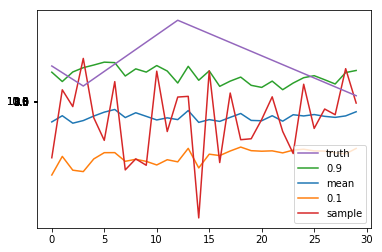

In [36]:
month = 'March' # “He who controls the past controls the future. He who controls the present controls the past.”
year = 2013

prediction_data = buildPredictionData(month, year, trainingSet)

result = predictor.predict(prediction_data).encode('utf-8')

plotSeries(result, 
           truth=True, 
           truth_data=testSet["{} {}".format(month, year)][-prediction_length:], 
           truth_label='truth')

In [48]:
json.loads(prediction_data)["instances"][0]

{u'start': u'2013-3-01 00:00:00',
 u'target': [153.82142857142858,
  152.92857142857142,
  152.03571428571428,
  151.14285714285714,
  150.25,
  149.35714285714286,
  148.46428571428572,
  147.57142857142856,
  146.67857142857142,
  145.78571428571428,
  144.89285714285714,
  144.0,
  140.8695652173913,
  137.7391304347826,
  134.6086956521739,
  131.47826086956522,
  128.34782608695653,
  125.21739130434784,
  122.08695652173913,
  118.95652173913044,
  115.82608695652172,
  112.69565217391305,
  109.56521739130434,
  106.43478260869566,
  103.30434782608695,
  100.17391304347824,
  97.04347826086956,
  93.91304347826087,
  90.78260869565216,
  87.65217391304346,
  84.52173913043478,
  81.3913043478261,
  78.26086956521739,
  75.13043478260869,
  72.0,
  68.8695652173913,
  65.73913043478261,
  62.60869565217391,
  59.47826086956522,
  56.34782608695652,
  53.21739130434783,
  50.08695652173913,
  46.95652173913044,
  43.82608695652173,
  40.69565217391303,
  37.56521739130434,
  34.4

In [170]:
truth_data=testSet["{} {}".format(month, year)][-prediction_length:]

# Left off

In [171]:
truth_data

[188.0,
 154.0,
 120.0,
 86.0,
 123.22222222222223,
 160.44444444444446,
 197.66666666666663,
 234.88888888888889,
 272.1111111111111,
 309.3333333333333,
 346.5555555555556,
 383.77777777777777,
 421.0,
 398.38888888888886,
 375.77777777777777,
 353.16666666666674,
 330.5555555555556,
 307.9444444444445,
 285.33333333333337,
 262.72222222222223,
 240.11111111111111,
 217.5,
 194.88888888888889,
 172.27777777777774,
 149.66666666666669,
 127.05555555555556,
 104.44444444444444,
 81.83333333333331,
 59.22222222222222,
 36.61111111111114]

## Example: predict temperature for the next 'prediction_length' days

In [34]:
buildFuturePredictionData(month, year, month_delays)

'{"instances": [{"start": "2019-4-01 00:00:00", "target": {"April 2019": [9.612699803782533, 9.409918941134306, 10.625155546489596, 8.877015485537557, 10.292000455681759, 9.8318114245997, 9.968082938872435, 8.52870580746306, 6.992335227437626, 9.617133371420882, 7.088532378656444, 7.87627107461993, 5.838729541987895, 6.655582550155413, 10.324592174538438, 7.518153411460117, 6.513511527185068, 9.37479074672046, 10.04697287292797, 9.11243201558035, 11.208703214831424, 9.0566756230641, 6.699556169395228, 9.891080577284765, 9.781366829853994, 7.967801970534121, 8.114023260006304, 10.839385756097013, 10.048332799693464, 9.6488627296914, 10.070493125183583, 10.753478491735436, 10.001365757737933, 9.992071529591477, 7.162938218334681, 8.63791187952843, 8.289134325298788, 9.0499298772805, 9.105466456941972, 8.568393405753485, 11.242184937284156, 7.407083619394697, 9.366401956551087, 9.631836577264341, 10.352061569637538, 10.578769493330698, 9.811028098609992, 10.240295483421907, 9.067790767465

In [35]:
# Predict temperature for the next 'prediction_length' days of 2018
year = 2019
month = "April"
month_delays={}
month_delays["{} {}".format(month, year)] = np.random.normal(9, 1.5, 8640).tolist()

prediction_data = buildFuturePredictionData(month, year, month_delays)
result = predictor.predict(prediction_data).encode('utf-8')
plotSeries(result)

ModelError: An error occurred (ModelError) when calling the InvokeEndpoint operation: Received client error (400) from model with message "Invalid request: {u'April 2019': [8.31168893767789, 9.239835753780637, 11.095206381348502, 8.244028166444137, 9.022477980204272, 8.94324390034624, 10.252612477617404, 10.853735665537402, 9.010746376293852, 8.925742432685496, 9.888799643548639, 8.773894267552366, 8.8080987879981, 7.6228206549556585, 10.407648271978474, 8.865802978397506, 9.706410087754628, 10.300441324391691, 8.622696304948107, 10.832377054723048, 9.017529885504299, 7.752669826637044, 9.315343873572061, 8.644639168468489, 13.02235814507112, 10.791594683905211, 6.510984439172331, 9.815695666850248, 9.536365882326416, 8.901540022729462, 8.753247904277698, 8.500331213788597, 7.685909632993639, 7.560197726354721, 9.281937687820468, 7.614586274785401, 8.719391970522185, 8.49844358323212, 10.576502652730188, 8.934092335532679, 9.37101483035937, 8.46583694193179, 8.433843601776735, 9.435680677186232, 10.045921077899116, 11.123904885056039, 8.386986087794561, 8.844799160777704, 7.232024883006169, 10.000397278769134, 9.445751499110829, 8.66361546420926, 10.59336845870145, 9.268235538358415, 7.329890341669149, 9.460352397279655, 9.692456965926455, 8.985930897054574, 9.921151611782188, 11.285437184478035, 6.633283487250074, 11.184808355221753, 10.569984350600134, 9.008762272429719, 8.774359326441727, 10.246833387611762, 8.758168841676786, 7.3349833640800615, 10.615679437701289, 8.895676322633687, 11.267567566586113, 8.551883288175006, 8.775718277079674, 4.752334364124083, 12.836756015597414, 9.925419144122417, 10.269090340836303, 9.906720849404756, 9.804370295824086, 8.116357595940116, 10.045583076482723, 10.49222477522567, 9.402544819738376, 9.827992807486867, 9.049001979568489, 7.9755342766575295, 10.326326735830126, 8.324947040172356, 7.744498382559673, 11.79883506861131, 10.289105955174545, 9.770522159547424, 10.236930399407099, 10.099867958448982, 7.223489626280886, 10.261662714129592, 8.300149772926176, 12.096441201589755, 14.103793373573314, 9.144608294392812, 8.23514353479554, 9.209323290359094, 7.381727910000467, 8.60662187765151, 8.598232674388166, 7.763227330621241, 6.845130094700732, 7.586985393238191, 9.333176282291927, 10.758093231531415, 7.345445451399418, 8.726005695840582, 6.71951470194453, 11.53408218257144, 6.940954153301048, 6.951393372025176, 8.653832508771124, 7.64087861341625, 10.642262284045316, 9.376393868263253, 7.427609772784146, 9.89413956731698, 7.8990775840327405, 8.77507854972344, 8.551341330530576, 11.60297946089065, 11.552778718394904, 9.549996964424807, 10.669508460609377, 8.335545150572681, 8.826160642458944, 9.556716958335635, 10.28410348385569, 10.180100209791686, 9.929566287655224, 11.224471225259114, 11.791466745670272, 6.322288710113261, 7.488414053725578, 7.829288655916356, 9.081905646410474, 7.249884328738384, 8.373644911527728, 11.571340615300466, 6.605957246754919, 9.842106954705313, 11.834398117266183, 7.841035741751682, 10.826492736362441, 10.74812278872192, 10.585830551197052, 7.890965882045203, 10.243461466926906, 6.399936775652403, 6.4038519722717915, 10.752878675785803, 10.923678189763692, 6.770802148295404, 9.186057902436207, 10.133739792199485, 8.337767835835642, 9.564498910096486, 12.653177091395879, 11.728726991238066, 10.228405946212824, 7.777560070720043, 8.231551308791152, 9.934398435701493, 9.519175400766347, 9.723650169849947, 8.626992642960976, 7.977105261889074, 10.517579243745928, 9.679708174846272, 9.290812269029187, 9.032810663797676, 7.176591674373943, 10.277245922021404, 11.635563342918282, 9.487041814515832, 8.472025985911522, 9.199909622982801, 9.055398654994368, 7.305769568793688, 8.201177170689084, 10.647733641894803, 8.802922701884375, 9.617180682971455, 7.979482282802547, 8.737113354181302, 6.19421860959852, 9.035005311751636, 9.569527369341056, 8.339927673335934, 6.272802308835731, 10.493194366798573, 9.621974047577766, 8.891670507141551, 9.01656245171271, 7.689960040735086, 8.656590741094275, 7.880907011706933, 11.125983396485967, 10.4299032148845, 10.203655029463892, 7.930318545009987, 6.697486858808066, 11.16110527002158, 8.169732838533182, 9.372934758769272, 6.943344430282414, 7.338100253189811, 9.874795188569749, 8.921101846214505, 9.344391743784092, 11.815251785947556, 8.222084063361702, 10.159958281059032, 8.730453440765702, 9.034014092737275, 11.263637482346024, 9.534709381910021, 7.44572767573359, 8.54821068660625, 8.787683878941058, 7.854323610862982, 6.965832884095986, 11.943090987190423, 8.243595465034998, 10.44323087948816, 11.102731091952336, 7.528668027107207, 9.308965830106532, 6.746368099769179, 10.595790046113857, 8.262020603115811, 11.994625131710926, 9.254009080545428, 10.38543070462334, 9.349872109577925, 5.6061599547343075, 11.168552063279956, 7.603595543550516, 8.177890679032513, 8.550376561718547, 6.15495275225495, 9.227751682011604, 6.164671880949672, 9.189801964584099, 10.787168384804001, 7.888215211821497, 10.07079583040895, 9.811446930064596, 8.679370700478227, 9.943072813480192, 8.683878301225105, 5.831823309538137, 8.38214172538187, 9.746697949073283, 10.336190228804616, 8.728506118273305, 8.320518922054157, 10.04681932683257, 12.32845658188877, 8.062532797731949, 8.63738329043238, 11.159718102715694, 8.788681930397816, 10.998558580878342, 7.167223540987345, 7.327417876339838, 9.225587034265603, 8.893244333043192, 9.397721156562293, 8.403436694282917, 9.266096614074055, 7.556242082577891, 10.35654711189648, 7.297478109841189, 8.571929073620103, 10.42257497615193, 10.597434835293283, 10.589808991434756, 6.695006728290376, 10.092458452503013, 9.700106037435068, 11.049647017690152, 8.0530182199097, 7.390311090889968, 8.167890560729047, 9.405018435191005, 6.39247040881625, 7.491632064399742, 8.12349148224513, 8.353370852672954, 8.07777880173228, 12.320431633732262, 8.21137015060675, 12.266279525707619, 9.522590323910165, 11.240933179366401, 8.425841697557422, 9.906712408966243, 10.090823648994336, 8.444615437055777, 9.298108331579636, 8.05229202248801, 5.9620646103262445, 7.164947231658989, 8.63181052409766, 9.160173300976584, 9.015187667714128, 7.5041836873602605, 9.207075625407823, 6.5102387452220505, 8.749865614837313, 10.696719653781072, 10.804751041258971, 10.397072182486415, 9.503395247365937, 7.203316050181114, 5.155497873398117, 7.478494988433945, 8.856964638955533, 7.753855940461948, 8.120847818549178, 6.626799120895351, 8.739808519536362, 7.757844449110873, 9.248175371679569, 9.37967378608488, 9.364559311703774, 7.998333703591266, 6.231394917571428, 13.68013574725124, 7.388229853297563, 7.309406623775131, 8.665777964677195, 9.564043078818504, 10.774552059412969, 6.9557315858853555, 8.478571726289102, 9.727100663318376, 7.181856430286636, 7.447275423386737, 9.064001962419574, 9.529884817102543, 10.11873731267777, 7.586957608759422, 9.465955745666232, 8.459749276016508, 8.205389906919978, 9.452006958194833, 8.452138610421644, 9.165813653786794, 6.976024645767209, 8.914251843524944, 11.859028326458027, 8.225057892969183, 8.45746195159377, 10.572223852662878, 10.150264864999741, 8.862985966309683, 9.879762551732695, 10.885431927473762, 7.091611205227956, 11.400722708243435, 7.350283367659666, 8.462684446471389, 10.559163315650824, 10.01828507524831, 7.259301899424775, 7.77478308614231, 10.852636893467897, 9.147705169667965, 9.100593790668439, 10.57709172098075, 7.742124943455585, 4.199828399466444, 9.819742233293862, 10.78370720235788, 8.121892080956059, 10.566983041472177, 6.508811895941125, 9.969004458009273, 11.224770250159, 9.087580613020853, 8.87707011479478, 7.746300746410007, 6.949652656814717, 9.477307432429633, 7.076876863222049, 7.521795267046812, 10.492768501918613, 8.284078872525537, 7.9357074904441856, 6.785576444282221, 8.310695559966298, 8.840958331916513, 10.629274540570155, 6.247890600224383, 7.067713248998789, 11.463916769128776, 9.667364820483105, 8.246759721607383, 13.01753569682541, 9.594538658302051, 11.118393382231703, 8.387385067017089, 9.133261920676246, 9.928288179985417, 10.58764296744393, 9.624825312550222, 10.229996171684592, 8.242290422474836, 8.468176588755046, 9.081620718965285, 9.439426530002885, 9.265446255068047, 10.55550863259377, 10.371966129747658, 9.607584931521988, 9.655621500161804, 8.033011477216567, 11.554445673624961, 11.341226360716965, 9.025706875802216, 8.169952807402108, 9.65734019583487, 10.183542098254163, 10.004633123830134, 6.9243336037434915, 8.277930698379548, 9.529683177044138, 9.59794517061776, 8.82404899274758, 10.578687768374287, 10.684421106655835, 9.061199476247726, 11.151058315067644, 8.771745942116157, 6.682987530968838, 10.608518691722912, 9.034031713366222, 5.430680535238487, 11.1645681752114, 10.168997278395203, 11.181444812158265, 9.265853754907777, 9.01448326232254, 7.607767978289129, 10.423144161947418, 7.310181766210887, 10.921747163877132, 8.674345329615969, 7.5532006746264795, 7.830010638504454, 10.137132250708381, 10.64153022759264, 6.571085481215934, 9.077943469624932, 9.668301734868137, 7.466077786093459, 7.084890337437596, 8.809530110511599, 8.446284675279388, 8.394534839849067, 8.318379033082298, 10.681363001536605, 11.771507430063995, 10.43037922061923, 7.109069818736645, 9.850938708178319, 9.16776837702179, 8.057988991235968, 10.509650113626325, 8.740224543977433, 10.622772468140937, 10.206551586256818, 6.889719564234721, 10.090669926026996, 8.224370510892669, 6.549050379291711, 8.75903028931637, 6.802405960240365, 10.07304919775433, 9.607436870148739, 9.15735371425412, 11.003472701125135, 8.31744565279017, 7.584741238955564, 10.805974597192188, 10.677445967773522, 5.994507062183384, 8.419542990375358, 7.861658282720012, 7.7291317612107395, 9.017727869663904, 8.932674372971977, 7.580549122043087, 8.776756815766387, 8.069510614719162, 9.279366030799196, 13.11139181720439, 11.896998705862057, 10.675387932379333, 11.519704158113438, 10.331996188181833, 6.383081332061703, 9.935466826731641, 8.833864245678376, 7.043550210438034, 7.899362297247688, 8.277908302656634, 8.220400799190934, 10.09412573758475, 7.214959089997608, 8.292605004458409, 8.470307696426726, 10.084807263490182, 8.157641191795202, 9.87460925951449, 7.7721932547018096, 6.7600154826155, 9.78784245291339, 10.113253043452588, 7.579201710713216, 10.876067259203499, 10.026952054714023, 7.365926068766735, 12.119255661304804, 10.869766803220179, 6.5598595602041385, 8.196127962341244, 7.907833307416711, 7.900757230432097, 7.458881359029397, 9.972703946857882, 9.652432772376415, 8.252850343965873, 7.558485984548659, 10.259945702236392, 8.628635415065265, 9.597311358750806, 10.313379270196739, 8.602320667822097, 8.099884118502864, 8.706164494789071, 10.901701196119294, 9.0363019916611, 8.469006159123118, 8.676842161717543, 11.197314462041817, 8.297404379476994, 9.32733437288172, 8.69339794438121, 6.930174420549167, 9.423474838655034, 8.853980520617787, 8.808655474199155, 8.443172638834687, 8.555741273064138, 7.469504037771318, 7.047410971357811, 7.015154106025617, 11.112605684129539, 10.755192186737021, 10.20236436378404, 8.996571763475547, 11.301179670832049, 9.384371134457048, 7.04464292663611, 9.951557866500181, 10.079190560335427, 8.46924699955033, 8.772594612793513, 7.679772155352625, 8.19631820184216, 6.901187855995808, 8.034065106167755, 7.99104763905335, 9.85486593389908, 8.881374693488404, 8.816532838092797, 10.732514566109355, 6.113381308783192, 6.44822944117432, 8.071620719991364, 6.298162970420172, 11.553775148743867, 12.053460523144576, 9.66427062617098, 5.712409322773203, 5.706889854018293, 9.601708136887826, 7.637153950368397, 7.193143946711765, 6.977240185573544, 8.637799905384748, 7.011446273583901, 11.383238596557998, 10.500797988881374, 9.224167249968637, 11.390587298423657, 9.087120143432573, 6.356844703098554, 7.304402984852718, 9.677965030389277, 10.321415872995326, 7.857539727564776, 10.407439913502042, 8.965232820750968, 5.345259066749921, 7.516629597491971, 9.894260978187104, 8.098378947279752, 7.727321668913433, 8.925304971442596, 11.506175576032998, 8.76683515382994, 6.961778322802902, 7.94544048248493, 8.354469504680184, 11.457260818242244, 7.903525018199011, 7.535830229873642, 9.806952582825701, 9.235998649735617, 10.661418583953363, 8.79446693582459, 8.999520377566958, 11.168936659860055, 7.627187415154287, 9.294448356857357, 10.571563135586203, 6.6077755590090295, 8.305451567672248, 7.265235038696108, 8.771510188361889, 8.364406588367597, 8.006302297054896, 11.74521929381328, 7.780384657657873, 8.09490811886761, 9.221917315704877, 10.57036726690006, 9.459965796217949, 7.421050871161153, 6.336835272048256, 8.981921251215587, 11.357257082773534, 7.715125248438952, 8.111458586910727, 8.921049242791149, 10.112203144174348, 8.93081577825322, 12.428489818225263, 8.507394900673823, 7.758485979816761, 6.925368184924382, 10.020883351557199, 9.852365846376141, 9.611865775328845, 10.021046970252169, 10.562574424142122, 8.511076907862773, 8.848194108279246, 9.742750427760349, 8.429114065580377, 10.890391202076806, 8.886383094424804, 7.4325378500159545, 9.883265091314344, 9.186341902598828, 10.588212997642781, 10.204258194735537, 7.059747945340543, 5.793365748399353, 8.70607726199309, 10.444361272881531, 9.843434732364166, 9.32107852018171, 10.634128330411242, 9.819417922046782, 10.028166283904223, 10.825229052821758, 9.63594129951991, 11.111907695863461, 10.119821509530334, 9.972254470135573, 9.6393319962439, 6.810072211839321, 12.132633976296699, 11.05350757593183, 7.871990844334588, 7.19752039805479, 10.227930988725404, 7.097314774067929, 8.90190441029264, 8.634155859942286, 9.682338935191563, 8.63702177831272, 10.018782290228133, 8.993429329894015, 7.881954493625452, 8.957981667956155, 9.100756084647111, 8.727182619138878, 7.497768006596719, 7.486150044599588, 11.978925617257254, 8.676076773040968, 6.499991157818342, 10.703758685478114, 9.81012419312492, 11.03923962065259, 9.091549806203078, 9.697935648565403, 8.021820344911216, 5.71188697097072, 8.714093092366262, 9.927013399588562, 10.745573609198932, 6.914753602755223, 8.613705997194998, 10.207607737399467, 9.906004561189889, 10.007846404710246, 8.221400076897652, 10.203078925806585, 7.774793533155583, 10.17509931661308, 8.89454588676462, 7.141074090276197, 12.119639176617524, 10.599661183354208, 11.187726310836165, 9.103025489904383, 9.147635072250253, 9.944037344255328, 8.893808810126092, 7.532093454199422, 9.36516906747131, 8.847715723606248, 7.8007908163234, 4.58978836672717, 9.174603074274202, 7.95111477305746, 9.473484167197723, 10.69140206497616, 9.370692689542983, 8.443507485184169, 7.555019970950073, 8.947425804658804, 10.201843754562553, 8.03764410155116, 8.703880578723068, 9.783388237736059, 9.680114502513236, 9.772528217309837, 8.4241465782701, 8.564378537096566, 10.887772959409093, 8.510141604428961, 8.196453016650393, 7.76364465845394, 9.676476883573628, 7.755111482506075, 8.552986056677769, 11.116499832409996, 8.567905618812887, 10.290993235372317, 9.776548041174614, 10.32972786727534, 9.842288987558799, 7.056819333293296, 8.3176746044203, 9.916786649294984, 9.42283205636989, 7.38143440906015, 7.747992374447481, 7.709203680011879, 11.130148838804086, 7.366379185527747, 10.573529507291319, 9.431343270828384, 9.967311980746212, 8.22942042960477, 8.449755186112606, 10.16985489478904, 10.814444810092414, 8.975794089076656, 7.967935606475502, 9.019050988542414, 9.639044719917779, 8.664073061644267, 8.706986224273697, 9.511496155214672, 10.060994468121722, 8.92560346667267, 9.015606241661567, 7.197476611114778, 8.621189494540968, 7.403971258229474, 9.098699829295837, 9.09325942926942, 6.197430150978758, 9.340530947982831, 11.30383264037441, 6.440862114818371, 7.6974338184089035, 11.717223752321509, 7.776325726663468, 8.766272648130467, 9.21211294814444, 7.761346705927537, 8.325155752863038, 7.432574969127789, 7.9095615588151444, 10.274381948216021, 9.620651013383208, 10.627335164328521, 8.397766011058888, 9.052314939412234, 7.419731094545934, 7.828164954241602, 8.293311415834033, 8.438238315151748, 8.701410746733277, 8.968345255214466, 9.154128375212636, 8.654255040417942, 11.062227560879094, 7.99340848705897, 5.424285048464933, 10.613121013238251, 7.337402596731317, 8.60307179248903, 10.057016110655008, 6.943672996589113, 8.91741383904025, 10.088803073953809, 6.462551845431568, 10.188890839209481, 9.03118730346216, 9.449972681819233, 7.631806211200725, 7.036368728589955, 7.97322780643481, 8.17034927919551, 10.490286411010091, 8.572207922388607, 7.899330361244941, 12.779858549947201, 11.365432516447964, 8.453649977748178, 10.605184363583671, 6.474242459523998, 7.863980966878817, 9.333167866143919, 11.490099662460793, 9.124968989016985, 10.06347376782609, 6.506918801896715, 7.208902164765326, 9.69938018766079, 6.929634110004255, 12.002552414921697, 8.367302008064033, 10.104940455633288, 9.570878458488819, 9.06698519186384, 9.805609825050958, 6.860377057980977, 9.930273205444458, 7.644611348223265, 11.809385065282335, 8.373718128230552, 8.926018635957744, 9.301289613426192, 6.941947294234077, 8.270589650432822, 9.557673376168324, 8.744380247562175, 9.386999525043297, 8.530874484481297, 7.169543117969946, 10.171760757561692, 7.847954800442759, 5.605190974061246, 9.295461752616573, 9.121978632459543, 10.592710277232436, 10.438868735519556, 10.582766866517103, 7.207918510576496, 9.481656476207625, 7.609287019088413, 7.9731500784453, 8.956826037606943, 8.349358079668205, 11.145530699203247, 9.943572745661001, 7.370779356254717, 10.190528754769641, 9.993407387257408, 10.229536933885905, 5.851844646603431, 7.421222775179309, 8.133209191900004, 11.033133228950785, 7.293431545530549, 8.91508517391603, 7.948229513529683, 9.193784102237903, 11.95100081236857, 7.894453852586562, 8.176953665197555, 11.12973658650563, 9.641014151919823, 9.35346347265548, 7.746316855096085, 10.61753067461844, 7.635088790189564, 8.461722436191275, 8.64769670180585, 7.670962394751969, 9.911716329064738, 8.475358768120714, 8.845092119211674, 5.813578351441911, 9.508269561350147, 8.916119488059675, 7.864631472091063, 7.652495915983071, 8.645713566251725, 7.779179925414062, 9.804515370114691, 8.918655321961, 6.658557371301345, 8.049265595720847, 6.396407900239201, 8.66415247107037, 6.560112031650979, 8.153262486534707, 9.775014501984762, 7.769848261987541, 10.147925224246169, 9.723342397655669, 7.847773778558162, 5.654138138941768, 11.598064814685099, 10.610628786042346, 9.674846708259684, 7.58720569668616, 10.655741336698778, 8.554882296668557, 7.982582710913486, 9.867532244056159, 11.11269169693597, 9.120598312487518, 10.120517084159069, 9.016192647326463, 9.922648684188024, 9.282297906002853, 7.43234787922266, 10.02915445341833, 9.261712646115718, 7.561052626875634, 8.206233330543148, 8.651969712796133, 8.147364114357165, 9.048840133978842, 7.023191186280476, 8.311853861034976, 6.146803348806484, 8.13229017987594, 7.473984520804063, 9.815866565465045, 9.637855126770319, 10.911838655431618, 8.520988363221628, 8.391869104599577, 7.8795321931341995, 10.885650012220486, 8.712692577072312, 11.264938097838511, 8.615059105229781, 7.702697870568771, 6.402385612694506, 9.978210784423787, 9.092484038128763, 10.201901615425985, 6.980843065915552, 7.825010440585821, 11.14301813564085, 7.065232776373891, 8.582875692158337, 8.608035029364286, 7.97734072820638, 11.95564656026953, 7.420649233596423, 7.3116156556346, 6.609344119944773, 9.609255861563728, 11.065151704237106, 9.768787806807095, 12.049234818804033, 8.895255668759976, 10.415585819211795, 8.484928229062309, 9.770229915850134, 7.871714707340377, 6.845363858581063, 8.102681659714552, 10.099287537766996, 10.336771226250425, 8.410301503351644, 8.046637577632255, 5.187531364097558, 8.313994585660364, 6.932143223442305, 7.5773382646853165, 10.765085366022436, 7.138537539847958, 9.49740855391185, 8.942679571574732, 8.001973180312635, 7.4356424757346975, 9.55072236179051, 9.400512217512416, 9.849087212779878, 12.262501830486933, 8.500233800074096, 7.694313587787024, 11.209399320420184, 8.366208556564818, 9.266156885524191, 10.86939725746218, 8.929088423847764, 9.705561864487377, 11.157998095900108, 9.16790491248094, 6.442760294670187, 9.206098485476115, 11.265016274510472, 10.02339113267247, 8.927179170896805, 10.656706946473083, 10.347296601875058, 8.844823698283202, 9.153839199841174, 13.035742198033464, 7.232588846402146, 10.236098054814814, 9.113939136479607, 10.605307877211578, 10.96466525858032, 8.930706995098287, 8.7065447708134, 10.36332950450945, 5.720836628171037, 11.974559700053838, 9.942874823247077, 10.048291688798097, 8.03087621299704, 9.145966553906229, 10.792634854682216, 8.483452281702297, 10.164346950497862, 11.86789184834321, 9.206331679174438, 8.863595091305015, 10.391531194683921, 9.955567679869178, 9.664637191286339, 10.047518847004643, 8.069627192771321, 8.551758070064736, 9.855276068902528, 8.697506617348662, 7.594733511297751, 7.678845122452731, 8.637467485651387, 9.283789288689844, 8.210563274111177, 9.518451406788296, 10.453753230039059, 8.167413276530866, 8.024141202879342, 9.13756759144826, 11.425772659884544, 11.863798265338902, 8.967145390482562, 9.903071764143979, 8.522607519235272, 10.49428007752031, 8.809865893087675, 10.802244614335903, 7.200502959307641, 10.644458847066483, 7.6022365795836855, 9.876805207054247, 8.265987410873473, 10.77079910423109, 7.778525095436246, 9.56248595065647, 10.155697160403246, 10.223443269284658, 10.299165625358839, 9.287672644554442, 9.039214200908088, 7.94120998363106, 6.716928089086032, 8.476926704609589, 9.85510711386963, 9.29257409054307, 9.549530245621744, 8.282357806687077, 9.762947583693316, 6.318600140116374, 10.229853780539235, 8.942262598214315, 9.648975548953636, 9.730710648788104, 6.9589015956754565, 8.146975852244873, 6.266054112363118, 9.688619435952177, 9.640156377967593, 8.23099623460279, 7.511671795210449, 8.778929462755135, 7.984239403081604, 8.782667008265493, 10.884078349733235, 10.315552668265507, 9.129692907153537, 10.75828367746201, 8.76984016750777, 7.118791795353875, 6.856535840074777, 8.665846464703865, 7.718483619296953, 9.764896409786822, 7.908679908323137, 9.832260110221565, 7.069946821090716, 9.792814427519104, 8.107014415349118, 7.817114906367169, 7.706307662856625, 5.540586109231965, 7.555147249005744, 9.206542970217157, 10.796746594090118, 10.17537118880246, 8.115035194319947, 8.703814363926885, 8.593996529605922, 10.134882918037889, 8.60131566385575, 8.86605190714225, 9.305152504598386, 9.680227236645955, 9.26060041597535, 10.039895765736913, 9.853426472053824, 8.733838000788605, 9.462862947723455, 8.45405291474033, 9.62011263162513, 11.31777079494287, 8.094986924558604, 6.709546749562042, 9.49145689523849, 7.990919123378983, 10.713922534340774, 9.018796176072566, 8.331065282134615, 6.544473686992705, 9.469127852816285, 8.255252327238235, 10.335418548274, 7.097726422596482, 8.295757059140518, 8.331571028152508, 9.807819461611171, 10.345605870789802, 10.21111857040734, 10.606264821901302, 8.898924892408345, 8.922351631348032, 7.379959253927536, 10.160651360827082, 9.006650763274532, 6.24632795900023, 8.102310444763507, 10.36467386035312, 10.125762937546959, 9.884621573759835, 6.405346569000571, 7.23861051992428, 7.472485432524527, 8.069953587894366, 7.203225197581126, 6.6067793020657515, 6.876218823922963, 8.971403896266086, 8.342708740547792, 8.14919593288516, 10.092072971441839, 10.437877540079125, 7.010487762901199, 7.173634950635569, 10.751766748738628, 10.414967824561533, 8.990823690803106, 8.743379784606223, 9.957037173079808, 9.061796641386868, 9.232198977237871, 8.164195056539025, 13.158339650040494, 7.674980342949182, 8.469538769880323, 10.628008129410293, 8.867615021272567, 8.490641935661138, 9.302245959488632, 9.471598867215778, 9.963892652136945, 8.421087839295973, 10.976218070493546, 7.884975915014972, 7.919050068156734, 7.423130326912902, 8.354848796103619, 9.690405885736604, 9.55271452067099, 8.720664647382584, 7.474351910732164, 8.999831873037635, 9.312348898539772, 10.49500098314869, 6.770053202457785, 8.008250783717687, 7.802289953248266, 8.588068106395134, 8.714747774131881, 8.24400484011949, 10.245227464078308, 8.954317442869176, 7.7482506054389635, 10.409203223319764, 9.059012683881464, 10.387126053582207, 7.046120026011688, 9.853130941751502, 7.9561044050052505, 7.9489609623321265, 7.549410064564535, 9.199946386068985, 8.462774815157323, 9.85386591058866, 9.369423699108056, 8.51675473350134, 9.44384941735027, 9.509522120477337, 9.889594154251412, 10.549462646287884, 8.206419903722477, 8.508382892357224, 10.15456175724052, 11.507375852786545, 8.931640295206567, 5.671523712397984, 12.502501810024789, 10.045525904944531, 7.788836183998968, 6.971366407714259, 10.138840497284015, 11.588591281206943, 7.828841355681348, 7.611179052144317, 8.757805052373724, 10.161318234617772, 8.434737395219692, 8.139621513977856, 9.232793952095209, 7.143535509605464, 10.493555419016106, 7.102767086107681, 6.567237965793325, 7.436956146840833, 8.932414726973077, 8.992458834315116, 8.037867331051052, 9.215201900572202, 7.309601866659291, 9.582020941307688, 8.805889902057594, 8.912962220826197, 7.230929923873046, 9.640135403653133, 8.73008575021126, 9.48820453201096, 10.32510141619145, 9.499045440048668, 7.740901281104148, 9.534821508944885, 10.303020151474701, 10.904905610284308, 9.737742387591464, 8.123726640346913, 7.36555464099204, 11.839022367503262, 9.085511296107562, 9.198807808447524, 10.532002909851375, 8.365670397786245, 8.444926781943217, 12.355610642144203, 12.646137426609748, 9.354024848371436, 11.82545060585921, 10.082853692174826, 9.354718876268722, 8.09715083240451, 10.218379835229866, 10.550376595670016, 10.005103282249502, 7.57341334137527, 8.647635405914631, 7.560411641458683, 5.560785008622258, 11.364454767244517, 7.802022040445676, 10.218720079166616, 8.06555808949849, 6.214841471656702, 11.103166580487006, 7.3688219526097996, 7.561283593821678, 7.464750964409164, 7.9222107831847115, 9.551553203777363, 10.755102857415006, 9.938090539425438, 8.464503059282386, 9.69301766059825, 9.804391738916824, 8.349218213716373, 10.498991339336161, 9.385564186373081, 9.63425290753592, 9.21865451822581, 9.455690783872459, 10.788445696843699, 11.400438569527982, 8.103006837825687, 8.5739846234976, 9.083262775336943, 12.17331078785184, 9.95706519018248, 8.855060778102313, 7.162612428049394, 7.222554682190609, 8.333353185882324, 5.235283365669752, 7.198743119993121, 10.091068819920505, 7.55194443356988, 8.772271761433329, 8.168781377900709, 10.685103072561951, 10.861217425952738, 7.012161590302796, 6.662932991993439, 12.224721147327685, 9.881317363709552, 8.894861733491105, 8.274390941684155, 10.557036021273182, 7.744439036857148, 8.877123176609045, 6.487667721017637, 10.00080665873268, 8.79611264038662, 8.559923088867695, 7.265520931775035, 7.675734145882438, 6.7442745104974815, 9.390902912639811, 7.430581122942906, 9.40362678161641, 8.865404553529576, 10.599880071236077, 11.424586296903172, 8.924571819866447, 10.501708375102151, 6.603282682507435, 9.908052708451223, 7.826932491846513, 9.347418498586922, 8.146483396474379, 8.11888363401984, 7.690755717000331, 8.835648865095171, 10.932754207027736, 10.608590567710676, 7.896481276906014, 6.4300141054042275, 6.54539740965627, 7.515294576656201, 8.258868427114306, 9.443897410794415, 11.266137155909838, 11.218838007085967, 8.253950784393385, 10.36605415750496, 8.235601206737003, 11.249869109233725, 7.767165099398639, 7.838148695319907, 9.331361643656951, 8.365256349149686, 8.01413413571778, 8.881764762118223, 8.084070912236049, 9.902220288281708, 11.130373044196848, 9.20491269846671, 8.908177890178294, 8.988420699427373, 10.991298776754201, 8.750317130871087, 9.637548728561177, 6.113971981925383, 9.2853733847601, 8.303648938364098, 8.35769308732397, 8.944801773660128, 8.216136729782026, 6.141923186926226, 7.873572096791187, 8.493318655607883, 7.89576997308653, 10.080112645262314, 8.104279981648597, 7.900852730534773, 5.620233347211948, 9.078137567121619, 8.73382814611456, 6.7839547592778136, 7.933421427285397, 9.532302136995309, 8.656945808895165, 11.398317489438853, 8.376190915797508, 8.373633623327862, 6.969761092891039, 7.593675153899865, 10.201530554462051, 10.746920908715339, 10.092574206088713, 9.531221973700795, 8.401278765203394, 9.198414389455305, 12.022159182159669, 11.232514417885248, 9.158377354248469, 10.618624112233668, 5.829052931018867, 9.39943919274513, 8.601537919833833, 8.013218998917505, 7.02177627046964, 6.769832426384125, 11.00123524481592, 11.03329721947879, 8.35650877472037, 5.933765165091401, 11.530877844139546, 9.50547064944058, 7.65864338860339, 7.407597079644491, 10.273484830494594, 9.92078770896413, 10.658598665369787, 9.765793585473459, 8.121323608808087, 6.8402725637719834, 10.163729388614424, 11.763154161723236, 8.596748995827074, 9.775027887447898, 9.804767959733795, 9.402468732814768, 10.872010047587109, 10.318624491584465, 10.21784510343105, 9.129407393401424, 7.669055294216709, 10.097776219361878, 10.675054868254543, 7.6224872680847, 11.241259713246865, 6.108592225252567, 7.428046144477105, 4.821661747187822, 9.194526717857805, 7.239260349861956, 11.405897085025423, 7.23470396172011, 7.872127372330509, 9.940004372534776, 12.785045561880297, 8.737313485511358, 9.570252324600183, 10.17638906237232, 10.397386443575149, 9.676761433957557, 7.837075812600566, 8.948322102025724, 9.548865041444179, 8.561839571386873, 12.445007526481637, 6.575771178671433, 9.065176488941173, 8.017674479706951, 10.68650239572802, 9.679043107801597, 9.885450506853822, 10.393056872989362, 7.194187424817261, 8.310680442801894, 10.938034898235511, 9.085923300420085, 10.727985813993344, 9.409724925896509, 10.256664783599291, 10.26305123883964, 11.517145502814948, 9.725347371722297, 9.754231948428867, 10.943590557674584, 7.185475848983145, 6.449694994761634, 9.666526563566155, 8.679809944258684, 9.305413457141592, 10.788375454951282, 9.426145434899633, 6.809833779886327, 10.114465876253947, 8.705600527638254, 9.91104950413587, 11.391435942260287, 7.993115559622098, 9.646791580522908, 9.936853749093673, 8.684887520693925, 8.517191268149734, 8.35380068038169, 5.806087785735328, 8.163971638425847, 7.791295520500183, 7.156033492514276, 8.808082430865904, 9.10075427301545, 10.848449188098947, 11.313001982458188, 9.547053947567893, 9.945838849567336, 9.313831493188419, 10.90167767272539, 8.849154153751499, 8.507480275046786, 10.473050112689235, 8.685898843244283, 7.005142179474491, 8.25437992371458, 9.1215828920255, 5.86784300029481, 9.639332617127975, 7.033781732642754, 12.366655192743652, 8.685856888217648, 10.502173224704693, 7.717181154942214, 9.599682051518961, 11.611243181520305, 11.135911642689077, 10.643153930866395, 9.526195531232593, 8.515533586371042, 8.391851587142758, 10.93231147757753, 10.09550892952613, 9.228459009527608, 8.492858480912512, 8.589732442302427, 8.31494234509261, 10.10420631407593, 6.4494302593025115, 8.389980313762578, 7.175784881444894, 11.323884594312826, 9.36702280890751, 8.141851172751368, 6.6423637150952395, 9.850673272093601, 8.01324420924397, 9.906462395564697, 7.647403932372335, 6.9449200047158675, 8.033233687582884, 8.634463454102862, 6.367977093746622, 10.926720588670866, 12.586557324481758, 6.746159729650463, 10.32912261148497, 8.91301338555991, 10.43181416924104, 9.194102334101, 8.001901179872002, 9.082151261866334, 8.005574099626775, 9.244550604256995, 10.85420419590562, 7.98876793153055, 11.501323642406845, 8.896474074050891, 8.120393366445848, 11.67369851064397, 7.879441681163951, 8.42739873333638, 4.822756531164298, 9.477378677746891, 7.846524762808855, 6.185878528192069, 12.011374055176894, 9.19888284187798, 8.272679239692424, 9.829073188890172, 8.483343968083338, 8.418398534758818, 8.761148325274995, 7.88928315538224, 7.545997030143651, 11.026904630746785, 9.165516503809217, 5.873946438514835, 9.994557236316599, 9.442270665809403, 8.615238873621376, 6.8670675228361215, 8.097922196643694, 8.410960952772529, 9.696342189112604, 8.728918194338094, 7.679518156189907, 8.882770589276385, 11.249963308273147, 8.02796634497847, 10.863145885215042, 10.790918911179322, 9.219016939600207, 6.356554794689253, 7.6831244538613195, 7.361932118545717, 9.72971104948596, 7.607683348793117, 9.436438298408799, 7.152802454151336, 6.180691015698461, 11.006016701473866, 7.197712013069013, 8.943992104060033, 7.487922791813544, 9.333847674181355, 9.229404599701235, 9.626460304429342, 9.29242172729299, 7.797924843243664, 10.627768249640408, 8.256892771975679, 11.874980969122419, 7.656310788093705, 11.734178766355175, 7.053773645382403, 5.088288836319411, 8.424551850663136, 9.361805278478927, 8.106493317832046, 7.613554797199364, 10.15933895207642, 10.149200271524771, 10.614155960058698, 9.511582327431608, 11.530480934879145, 7.461371177835341, 9.873457720975399, 8.368573295667364, 11.20036361071183, 9.673106672574178, 10.175067677612716, 10.564124361738969, 7.056402384976652, 10.57651528889835, 7.562961945114739, 8.607167509007528, 7.48339388141482, 9.265764131472546, 7.024234967794371, 9.751944698153332, 6.39811729683765, 10.641102076053809, 7.395555664551289, 10.710738660805642, 8.706930714166516, 8.966099808386268, 8.73227119595516, 8.528732153701677, 11.57060974270289, 7.11477436472678, 6.783154977354336, 9.444969881246083, 11.142051729338164, 9.585891902610534, 7.531346892655998, 7.804006746944445, 7.974433682006778, 7.517450034677729, 6.754043223495961, 8.116806451386703, 7.655857585179419, 9.010268998874347, 9.845885563758818, 7.003860760863644, 7.679073465192969, 8.743986621027982, 9.796479513526856, 9.088898598764553, 9.542452478278724, 10.213595630221622, 11.511728619503499, 6.840973650416349, 11.160004739201536, 9.540109112865537, 9.58671325163085, 6.891014739593143, 14.016968796635851, 9.448309518128509, 7.565504606946538, 9.558287540654627, 8.967385150437789, 10.817925580727017, 13.015517308291546, 10.466556661754424, 7.6782868819241745, 7.498119855075735, 9.181553840857925, 7.472349850789643, 7.777118621702034, 6.960769382482881, 9.314421268079291, 12.764951350101581, 9.505855619216195, 7.475223905641459, 8.295339003391307, 10.883046885914766, 11.63613216524762, 10.536373619797859, 8.36526959511266, 8.915719053762038, 7.770660205980959, 9.301127320844603, 8.037265075742212, 5.591941086441891, 8.890751075825913, 9.301008755001455, 7.912652378298626, 8.258770221878027, 9.321533343249802, 8.272473083760541, 10.101336907229868, 9.388085880491378, 9.931677125652511, 9.381417843739333, 7.399541073699869, 9.581996508434058, 8.669050687130687, 7.958734194924194, 6.476128611058826, 7.144636354506209, 9.789406476917298, 9.903305030911605, 8.678582030815589, 10.106449202712454, 7.509139109192409, 11.05763428370253, 9.178061219844949, 11.699356361803954, 12.743507129232427, 8.791979436966889, 8.727380359710011, 8.641257585177627, 10.691154829016401, 7.3695086218841634, 6.612781979015004, 10.342994212132677, 10.994526675129029, 7.311782915731836, 8.128553264881013, 8.769366922190128, 8.53096239440676, 8.34266640827872, 10.855871894893848, 7.119775074610329, 9.172775517600032, 11.281135445580777, 11.600473676347828, 9.277356329679657, 8.789757238104247, 7.574069986148757, 3.346248225088447, 9.000799175655652, 9.873899857587134, 11.561521342309609, 9.21752486437114, 7.415328131402202, 12.510256245499342, 10.484401393033584, 8.735736378331781, 8.018066439469255, 7.207044638000112, 10.475784657545931, 10.316270016890844, 8.041810509652915, 9.620007212520271, 6.647674643560218, 10.31045894579664, 5.384336899342739, 10.244826687333445, 6.091919975698463, 9.302191828744675, 8.409547825320487, 9.541138723239103, 8.519109040331582, 8.774886463984497, 9.788750675947322, 6.361831340318237, 9.877604969782558, 7.419473678385907, 6.433988845768564, 9.377154916911612, 9.90654503780604, 9.748401623342513, 11.140078821393516, 8.909264986439432, 10.10707228302111, 8.081147814789379, 8.481977429370568, 6.264686590087649, 10.121174850422227, 7.4260917998883205, 9.587845362361763, 10.924437465708772, 9.905091098384585, 9.847210962132747, 10.187681419516169, 7.879958989335072, 9.424937067601833, 9.66454984129653, 9.604217874822545, 9.481689442376513, 4.242295770931462, 11.09994064437239, 6.99112555793813, 11.057031662841991, 9.449921382284519, 10.714044024346753, 10.821531807219364, 9.63428560995028, 5.844354191813318, 7.088027718132649, 12.91218744869003, 8.943618424815705, 6.2897308936604315, 10.012620862142017, 7.5512095867692715, 8.147346623193084, 8.7444000935168, 8.075532498273125, 7.024639794472481, 8.069333426925374, 9.246875472601634, 7.853186686310199, 8.587359389628055, 5.49565105760734, 6.425239011309483, 7.540925047204859, 11.010654749450753, 11.887711873304651, 8.218270600073728, 8.145470275264248, 8.8617506637984, 8.650900692928877, 7.401819829433119, 10.185303611625026, 6.397823979749649, 6.4601961914012005, 7.2680550676196845, 7.703893419682885, 7.960698263645968, 7.747184377803615, 7.477176856587434, 9.860095212112322, 6.07379217134666, 9.762147794351907, 7.406574875370845, 8.874116900894833, 8.805643950203901, 4.941830751425762, 11.226732106874186, 10.178510188649584, 8.148935585196885, 9.104435995063067, 9.711948875453812, 8.251414872249022, 5.572653632534623, 7.858380096616962, 8.434289681572407, 8.24179399900248, 8.755382032098538, 8.890404563646591, 6.108838323064259, 8.581745178733145, 10.472116255698271, 9.54000035774326, 8.745625251927372, 8.556054756170614, 8.412121725702939, 11.70500271666615, 7.23167045846627, 8.830396790842837, 7.250602047828851, 10.176180070836741, 9.413301897159664, 8.706335797325389, 7.872665152259508, 6.544140649064565, 7.961464545203225, 7.87712319282434, 8.534591722682098, 6.843255743108294, 7.958208885000344, 4.8228497665261525, 7.339125392718572, 8.505756169310777, 8.297913147095642, 10.60253828741852, 11.401849033707526, 10.539586411470824, 8.521743345660285, 9.170149328451282, 7.769152435201952, 8.519866672354603, 10.268385437813667, 7.168057586494671, 8.095075425243573, 9.451060750832953, 9.484051193838098, 10.206255052337674, 10.878136919000513, 10.249429887464471, 9.109248233939773, 9.107222646771364, 7.391015276704476, 9.432998452694456, 10.666106888032587, 8.908647207236411, 8.874660450163457, 9.943129684186452, 9.842113364265265, 6.498987072986246, 9.626509988063026, 10.646435403671028, 10.188737305015783, 9.006505544133761, 10.743262813032999, 10.611058472823379, 11.143773014264406, 6.305724333409825, 9.378468552406591, 8.132720073560387, 8.800093158094041, 8.704245394156493, 8.084881261876081, 11.11693266158929, 8.659387614224777, 9.660252008076606, 11.987674396238251, 9.119813485881277, 10.188405712965764, 9.575057553179764, 8.973741706302759, 7.00960351559439, 8.87078669531039, 9.809883854385111, 8.407194892552582, 11.21919062136014, 9.232951127987787, 9.64203591583331, 9.45202652225976, 9.06239617304902, 11.25409604820618, 11.005101618925078, 6.379222653688743, 10.403458068408053, 8.135921375732437, 9.135259509711572, 7.361993240124937, 9.65125440225055, 7.8747781635228264, 7.232365988521736, 7.997543193148617, 8.033238594437726, 11.468239579269316, 10.084445746173637, 9.70340910889924, 9.936387454800904, 9.159290240839129, 10.579551753443981, 10.773578252617584, 6.030021203995929, 9.871867563746832, 8.7050847291078, 8.429063367382183, 9.98174654868732, 10.579438299702272, 12.001408225915029, 11.15201436505689, 6.888948054121332, 8.416286525255295, 5.178072072780982, 9.535741186564849, 9.378567335132004, 7.541099123085569, 8.045660515087588, 8.202544844056119, 9.012396405191392, 8.505560672817767, 6.098847902153967, 9.564634410861313, 13.604398806741296, 8.894067679483372, 9.302423669135559, 9.573316648774426, 9.291631661139647, 7.889162816363779, 10.250156437437832, 7.826525419567011, 5.341170711536915, 10.31653542466923, 7.562120485324169, 8.423174664321579, 9.06090490725202, 8.559072770407708, 7.315928409158211, 8.790843758772438, 11.56401540456099, 10.01680111216828, 9.908004317573821, 6.770293939733952, 8.365168663131087, 8.288692664897987, 9.258534252937716, 8.683347406056882, 9.791788534836849, 12.099205953246024, 11.535672281295685, 11.361303387148983, 11.671947758952985, 11.389286843251767, 11.056348351056155, 9.386642750732275, 7.154915912700146, 8.736502595598706, 10.866258156172428, 9.68444596619324, 7.584533735851019, 11.336618449641742, 10.495494526838359, 6.145033006683993, 8.130598336225777, 9.225755242945167, 8.622641966185917, 8.963497776448344, 9.450919864009308, 8.902853921020586, 10.052967210445274, 9.786988792871325, 10.59349053024902, 8.073184403295848, 8.294556785530041, 7.984624225011849, 6.540470306559366, 6.911014350866374, 8.557242829208302, 11.743090774333709, 6.969309910712614, 10.982450947097709, 9.237410914043336, 10.218337348456329, 7.403839567743891, 7.683792257937672, 8.024468396476413, 7.048148723905159, 8.14372773457832, 9.625944847961007, 11.749875364412974, 9.909798873612491, 9.359172141088871, 8.188729578274696, 11.468660200440802, 10.444697170723037, 9.837865302038436, 9.73774271628355, 10.274886726524503, 8.848503224568608, 7.781101410885025, 8.926094347131567, 5.41552804030384, 8.131237630764343, 7.775772400466483, 10.712966324731436, 7.182085793327795, 11.208646559476179, 9.504169680128223, 8.777509866051233, 11.024472223040945, 8.2914647196992, 6.281130796300987, 9.340865224194852, 9.879015853198089, 9.59317910158439, 10.875947116107739, 8.142639300750497, 8.533063970666174, 10.647556400263948, 9.575530582629419, 9.236232204314437, 9.66839024704568, 6.807397327439409, 8.481964117674922, 9.358141515710148, 8.167125721668928, 7.787819881886284, 9.953599900924006, 11.94681812875093, 9.222051668974878, 10.4766007765751, 7.199668031000965, 10.61802859977378, 9.664974315107068, 10.235630107339892, 8.506482472531825, 10.704708190801725, 11.692776422762908, 10.812376754601319, 7.773132638211138, 9.570744516006048, 9.515338886436377, 8.59782447662438, 9.795681170550276, 9.058665681995283, 8.288434319929669, 6.848968461631256, 8.7568595147905, 8.890282121281734, 8.710989948672626, 11.699872289823993, 7.686509858958453, 9.981886658051426, 7.604756626740496, 12.0269423862918, 10.739648652303122, 7.220563918275546, 6.011700584614488, 5.79945529895031, 7.572610273167362, 8.568533504961465, 8.680427004310443, 7.094152086354629, 8.728957620774036, 9.042572815225105, 7.141724475361267, 9.544546708810838, 8.317878717433613, 7.991845610658672, 8.067272034760576, 9.189294049837791, 12.771381103184932, 8.861937246527713, 9.149754193468524, 7.56410205798391, 7.928816544711771, 7.195689598598895, 8.040967432351295, 8.819200195716869, 7.597791471845214, 12.794326230934693, 11.144157530092823, 8.242067210547745, 9.99850436828305, 8.601385221716066, 8.870590686517966, 8.375747989225816, 7.518408028599611, 8.076385935584026, 9.62965150227917, 9.152960009273261, 8.63255547836872, 9.46134213465436, 9.18911046180219, 7.375635019403843, 10.259185859612323, 9.48739565742705, 7.005035499693967, 7.346826100761165, 9.474079497839291, 10.27120546035093, 9.220219951121813, 10.076798501275736, 7.700170136101707, 10.757578868672773, 12.325541145257246, 8.120202718769608, 11.256528065334848, 8.721934371955257, 8.86889783035428, 8.780994827875983, 8.366129286772196, 10.777438874539108, 9.582338436899926, 9.189123563347101, 9.375278715070229, 8.901558218182597, 9.21303527907612, 6.223556873012674, 8.322405832607132, 10.490352479426914, 9.813113998716748, 10.182186025214213, 8.369733255532779, 9.949552414431302, 9.314026064157302, 7.514400244067273, 11.570725316717258, 6.427543730022782, 11.007383945181001, 10.721124914283983, 9.497264054731492, 6.962095615959675, 11.439823099849587, 10.143839000476374, 9.038354156937963, 8.861389559962683, 6.780027518161065, 7.456675723860148, 8.587268980022898, 8.24072170231638, 10.386654963880984, 10.72917588450304, 10.7061580012839, 7.565112290399787, 8.365924883703183, 8.554631874728635, 8.108885896782018, 8.910809948151291, 8.57229715207662, 8.402791060077643, 7.459791752379068, 11.414671684140458, 9.719762445153576, 8.998611207535106, 6.420536525719919, 6.234855768005961, 6.791831490242833, 10.313221296689061, 7.8999875574357645, 8.676016581066623, 7.777498345353228, 10.525132883278129, 7.942310450272961, 10.177051864239287, 10.549639201903776, 9.688518749963734, 8.546770130122441, 10.486166485827818, 10.67338289683731, 8.673047082462716, 9.789795189598957, 8.572558235700589, 9.68638940411921, 10.990544823680942, 7.796309079936192, 12.940370241093149, 7.833947432120203, 7.787715527255324, 9.799707596805105, 9.616493739542936, 9.947516012805123, 12.436486137776118, 9.3870317720064, 10.2028955720737, 11.639911986542677, 8.688631312186105, 7.9586444563861125, 9.169050937169052, 6.718901819547618, 9.025261097954594, 8.62482474156628, 8.460586307393909, 10.489791022356318, 6.213973458443251, 8.274194214589958, 9.251966541246555, 7.451148951563852, 10.134405942123452, 10.394385583968942, 8.805042182544536, 10.449413266592794, 11.304212570856295, 9.444448675112133, 9.319307505011858, 9.607040113017435, 11.489557903376392, 9.0526832302676, 11.08319273419718, 8.899379298788995, 8.820691493553452, 8.306018591924134, 10.822064762128752, 8.211765043056072, 7.567611597709608, 9.259997353111835, 8.761593836853855, 8.237978968499492, 9.077103760669356, 8.58645771974899, 7.966072809222409, 6.128956295912144, 11.599591447545901, 8.642512159952044, 8.696218616872258, 7.765209235283081, 7.726581073116106, 9.425129894783192, 10.179684413951788, 7.416670420286797, 6.5500905127310585, 8.090423843657504, 10.153581784665024, 8.699837165381563, 8.417562003229596, 7.25163503588869, 10.194470235896569, 7.585047924743687, 7.884101234480291, 12.26638523334871, 8.733172301026475, 10.401219079074883, 9.672000330451391, 9.505408267579536, 6.9351229531865, 12.420270063359716, 7.849618232862069, 10.25342412217709, 6.741853908596283, 6.264483951500125, 11.176970292287193, 8.451140682542826, 8.938899995154383, 8.778050691098793, 9.667455113480697, 10.671573302661457, 10.308483009207492, 9.227967982520966, 6.925819978629417, 12.924008279811387, 7.521779567929735, 10.797350558076754, 10.621838559362875, 8.577206077595626, 8.995898365668774, 7.707838056384107, 7.546844526285183, 8.72134372402648, 8.786716314547473, 6.8172205866002, 9.3525571797418, 6.593311392429161, 8.44262884522844, 11.226117428904315, 6.854188174252288, 6.82304405618455, 6.649699490340582, 6.642036056818976, 9.136410491881902, 8.666185779550766, 10.09687912964075, 11.724748175029005, 8.504966122201822, 8.549208002288033, 8.56645463137607, 9.037312743214876, 9.262525633163067, 9.893880286910763, 9.558009992748977, 9.303161973189773, 10.916447024709361, 9.199545213429362, 6.17462230122873, 9.129876345961438, 8.730936472568839, 9.746222726769389, 9.36147646918868, 8.891714918434419, 10.30346922225463, 9.043918795848278, 9.352248276453986, 12.961980912289825, 9.49458299356151, 8.047111222441856, 5.380950537009013, 8.233213494987163, 11.326831331450702, 7.840635532782995, 9.164954794822025, 10.018283981400247, 5.839054218943202, 7.283641390170636, 8.366081359489264, 8.410716369242236, 9.67991595812714, 7.3891784798239755, 5.937309823282996, 7.467451974952591, 6.651847999167109, 6.417954861819984, 8.925474827631206, 7.102230870616607, 10.037635955358589, 10.17764072431417, 9.763767232876493, 9.623949463861385, 10.101358224615565, 9.16854445061777, 7.441072091561125, 11.153434982853081, 7.815634633239515, 9.051840754214528, 9.575206124073137, 9.048320084350003, 8.94544533304154, 8.062277407654518, 9.10731089008856, 10.72922087772352, 8.710742398512352, 9.673755540001512, 8.512244596036998, 7.87642233660035, 8.939633526824819, 7.314040998166254, 10.889820278506624, 9.298296964946422, 10.76888730781587, 10.357858088306529, 5.427008015702015, 7.932902951122841, 7.451771548940669, 7.405797865432166, 9.709987536828807, 12.1007465490971, 9.20545729901324, 11.743560722725107, 8.943939362409814, 11.265437889127732, 8.443831206508937, 9.268117263279445, 11.519766028324275, 10.945593344578775, 10.62587716606255, 7.770960912877754, 7.428610425397375, 7.527805275259104, 9.388880114518464, 9.151311082390396, 10.290030100751805, 9.217449405872292, 10.160221574303197, 7.690866537537435, 9.945137071884853, 10.030013340713545, 6.791641039046891, 9.107813763715614, 8.19969397004256, 13.169718510981614, 6.16859816466861, 9.043351129274035, 9.245843042450584, 8.309702736148335, 9.970003921471509, 10.66573892692209, 8.462669630005697, 8.278580000908924, 9.096122340943184, 11.9262480722833, 10.247399714921357, 7.368664999621322, 10.625497572178642, 7.087244949728561, 7.992305485145314, 8.721137134743396, 8.886707906030974, 11.494111282632849, 10.967474074338588, 8.689613727353397, 8.353889190998188, 10.591647789063003, 9.215416135151127, 8.25848163125521, 10.494249887044157, 8.940481687352467, 10.70277221534224, 8.54611890185346, 9.047892713265572, 11.442465127211381, 9.339564292220112, 9.452933536264387, 7.010732456524266, 9.35355651230726, 8.860978985213253, 10.331523917586491, 9.046697742897406, 11.314300055507584, 11.389625729287353, 8.116731165732268, 9.652461134441685, 10.570940180672881, 10.059025017746823, 9.755716541095463, 10.00164331797993, 9.063229510751043, 9.01781459561703, 7.991329127109735, 8.6552282418014, 6.910159025923374, 5.23362376257374, 8.679922731198557, 7.709551787816505, 8.258909927223774, 9.727877204441212, 8.160017867028134, 10.63659896443905, 10.268404479976303, 11.32603581042919, 10.070595822398312, 9.483782261172468, 10.981988525947932, 7.119676564973316, 8.922874126566583, 7.5959712631980665, 10.716759314118772, 9.551777636911426, 9.466300464583622, 9.458563353535707, 7.301251313561304, 8.284561633936736, 8.510999072158198, 7.274332816195264, 8.562795082481752, 8.608978019015831, 9.00415284142257, 11.650631543589494, 9.249185445712335, 11.432679469764956, 11.967397940738099, 8.985250480307108, 8.23854344597647, 9.622476710120788, 10.628046652258314, 8.72002234146316, 6.731831273311384, 8.087268829188373, 9.21416913774513, 10.698895630160923, 7.595516964657403, 9.245971221626155, 7.953482436821743, 10.944264051859196, 9.907199121351123, 9.363138072628377, 8.845795403874773, 7.862058064229398, 9.136053718724055, 10.598435899316886, 10.73980785085023, 7.93270772502951, 10.625709509494365, 9.690798161130449, 9.504091916443882, 11.640139248513549, 6.543952971051237, 8.322366142219275, 10.32022830689325, 9.608054729590833, 9.408730519565616, 8.331199995908, 11.567473785380372, 10.740726832016856, 6.219117129579136, 6.363446002283645, 10.364182902970407, 9.370946522401656, 10.327595478414183, 4.58021308483194, 10.17979721628092, 7.533156854205019, 10.270280093358645, 7.725357522441456, 8.719400260359878, 9.220484278273316, 8.826045750520127, 11.716700843674046, 7.065181596816863, 10.550856218764107, 7.391657237601663, 7.716222219269854, 8.429644676214814, 8.653618351961601, 10.21231586112571, 8.99785189561879, 7.7699214257745925, 13.037780073559457, 10.946081132982583, 6.473513111835484, 10.515986267781704, 10.701660475650606, 4.603093344891908, 10.397867140591377, 6.244790174402381, 10.414411284224725, 8.698768123139308, 9.654233578152589, 8.477245335437722, 7.208847678704281, 9.671611717588984, 7.444776368825235, 10.223301450326787, 4.641347167853358, 11.055546604413975, 7.380203053967909, 7.68156918851715, 9.749199509789925, 8.36399424799972, 10.245939506143804, 9.996841216517895, 8.609011405155943, 7.510521891719709, 8.646561457582177, 9.667068389580148, 8.270065401425407, 8.485919974273049, 8.201750919379046, 9.798477124561401, 9.705928753085328, 9.63085561953499, 10.963153433277489, 8.372261794689965, 8.347176396000451, 11.438671364801511, 7.352367106506669, 6.754162860320792, 7.53306205752279, 8.107940372350718, 9.25097297528283, 11.013545237848918, 9.827961266535805, 9.495846659128341, 8.690064765665495, 10.222538750019652, 9.403604423378255, 9.59956760375005, 8.117189692792074, 7.155291437462849, 10.336555882130998, 9.468711493464106, 9.859664288269036, 10.128984788039126, 7.461652725454281, 8.402406019657231, 8.603269831319125, 8.46397577346417, 9.004947728258289, 6.314075531763199, 6.812131520836618, 10.360805367022895, 7.135171223639182, 12.189667211631043, 7.930904944138678, 10.765927689479547, 9.530745199805903, 9.154161535026597, 8.370040619946657, 9.7355002678536, 8.312057318966321, 10.400758991595751, 8.635765262300525, 9.340080097212054, 5.522401262573654, 10.49433591650881, 6.995665669372459, 9.03797829923484, 6.7768522249419885, 9.45253887390627, 11.23224800584391, 8.484272848753317, 9.374090384982408, 10.262369847760812, 9.059621219282914, 11.090112115550907, 8.508974433953902, 6.568098021439607, 12.062491098598533, 8.503276360039145, 5.625982702274177, 8.193529026495682, 5.148262677164265, 9.258673493218335, 9.109126342836618, 9.8317498207535, 9.684019750764712, 8.047368607972514, 8.113654542717562, 9.723030011192005, 8.359168607304248, 8.921189643023972, 6.85031899303216, 9.233183190257776, 10.049320870900631, 9.901337593454036, 9.093163298147738, 8.695307723865728, 8.72017979433037, 10.890373382013738, 8.130592810002565, 9.11041716421685, 10.505730733148637, 11.370583656697264, 8.500399278283957, 8.50642192721917, 8.49722966886155, 9.949567456407301, 8.425212376409728, 9.453999496866308, 10.923286791363795, 10.006359326546375, 8.519001623644064, 9.38610950428194, 10.683300717366762, 12.40109871170024, 11.516019373972483, 9.204530303064018, 11.366429028834162, 12.164441820151437, 7.079080252077543, 6.134939457674491, 9.375289737455345, 7.379795023240255, 9.711992472792417, 8.088630609756045, 7.346653937248016, 7.795442260255914, 9.392614369436338, 8.798189913994328, 6.876432172957499, 10.747121125669084, 9.796504320417247, 10.633735203279329, 10.254554296430339, 6.53230405436619, 12.154991962727964, 10.708088018249672, 7.710598438351753, 9.68798637622461, 10.993937992916692, 7.6814060711739955, 10.653945728757622, 7.883979675169055, 8.738238316824894, 9.405608720170392, 10.749632287700543, 9.246805342713866, 8.393157515751227, 10.108020777810307, 8.37697393388136, 8.84836767198593, 10.48301184983281, 7.863310876812082, 12.58993534395128, 10.564551716198466, 5.609386246640938, 10.885505408401693, 6.669002543616694, 10.233571567496563, 6.682566505060697, 6.767122129428955, 7.273801885674574, 8.289035890623182, 9.152130719214265, 9.247436990996766, 8.986861397072932, 6.895123716764296, 9.015143816274437, 10.102318266067234, 6.61093845048336, 8.09579361511532, 10.409525379023284, 9.747253204989821, 11.582268859699294, 8.367000971603382, 8.10737193530506, 7.522292824712732, 9.66028174045752, 12.372955538175106, 10.189940078760255, 8.20631661258541, 8.563662892524354, 8.414307074174337, 8.569542707285427, 7.68260150334811, 8.074751827684457, 6.292662356302934, 12.362564082192197, 8.463924785234326, 8.89480262043653, 10.798980996671014, 7.727228449382405, 7.511041190965486, 8.877906273728538, 11.423342100324511, 8.957038752806065, 10.036171615342814, 10.820007736407224, 8.604359638856048, 9.056289706489848, 9.586567101880725, 8.780403969579181, 5.71575226432849, 9.948388697999922, 8.278254417285714, 11.241427144829615, 8.716114618076242, 6.865426090496881, 7.923569425633497, 10.441887438409834, 8.831676305733609, 5.701943630915749, 9.578358127248382, 6.317483716681518, 9.860995664346252, 12.083283394889687, 8.724623382643976, 9.37991346183243, 9.127353244508573, 8.748434144641172, 11.368763559434248, 7.481628094835809, 11.238109853137834, 9.726884255163679, 7.855696685098617, 8.968897008601603, 8.954425712796477, 10.44480950012339, 10.219209034741827, 10.306750172440331, 8.510789498310743, 6.944763785494875, 9.024640825316249, 7.807446317834352, 9.622460712479803, 9.475898143928692, 10.460515412361788, 8.166954384566017, 7.432378664344497, 7.622086911867491, 10.26809737954259, 8.87373501162343, 9.497917005238307, 8.794332348184426, 9.943475467959104, 8.344544694839232, 9.322251462856983, 8.29381157614849, 10.171686592346523, 8.45430127608309, 10.366322383979197, 8.1961231837354, 7.822902795397145, 8.641872261408096, 9.905833521262243, 7.236050433344276, 6.766153501091613, 10.03285677905884, 5.885537352034657, 7.375996721444114, 7.736448788932471, 6.942190688255967, 7.191247906687016, 9.037226719909802, 7.471603358081708, 11.122449717527045, 6.22906259519822, 10.30718659829876, 10.630886315391987, 8.079475733378496, 8.797849976245185, 10.075982848327394, 5.473270443073423, 9.61373923381512, 8.481260340606775, 10.211090178622952, 7.980266401398416, 13.014477976821023, 7.975772253496441, 8.683481140203108, 7.9849840852621154, 9.171037294441861, 11.563014841116516, 6.806012075114011, 7.690872830633818, 11.6467674806434, 8.547782363437127, 7.706334806218613, 11.686977335112477, 8.358397917355143, 9.345707306948805, 7.420982553024253, 9.840745987664414, 6.429150897861311, 9.55251429687724, 8.84936518191139, 6.845319417612352, 10.781541280584388, 9.35184864336369, 7.956025999633266, 9.020325363896355, 8.389025267167014, 8.127054260181083, 5.377050184950919, 6.621553905798768, 10.494378510953979, 9.333169851337733, 8.550167926980668, 7.231403586217556, 10.99260342332502, 6.181455234749318, 10.954931770471116, 10.384082862168311, 9.593978141833906, 5.820293155446957, 9.918044813435575, 7.5504293091646435, 8.239256076786877, 9.960588153327166, 10.60737138992236, 9.237903545842254, 8.228342235390066, 8.867239559756026, 10.562931739309864, 8.77649609390552, 10.518445039629825, 8.58128055872507, 6.665492974474759, 10.295964648646944, 10.124422271619945, 10.467916828276284, 9.643167725538023, 10.230084818238515, 9.197642839379402, 8.72017486212622, 8.630950876979941, 4.488521870608299, 8.169076257815409, 8.53082110133628, 6.721874564209875, 7.3566359590782895, 8.220232190033002, 7.834354123719631, 9.186861451969277, 9.270996199543129, 8.623904933202322, 9.426110524878007, 8.778650475072729, 8.399879072003714, 7.862952891903586, 8.231926598257411, 10.437826086654717, 8.805114691218819, 10.350362768302956, 9.387113695919185, 8.9173473036601, 8.851714900369016, 8.950461318767278, 8.41085518237446, 10.047660937006391, 9.405476505905451, 8.030084181287712, 10.772975927229755, 12.224912621365988, 10.93854177939822, 7.382807522264939, 10.179070497318017, 11.003988929169324, 8.750775879671169, 9.338443430884753, 9.325279934492082, 7.510554782847603, 9.251321024283175, 8.327486755409087, 8.479256723265777, 10.14295121570728, 9.087876584132012, 9.920510223541447, 8.380737340319367, 11.13001958384777, 9.550408359484612, 8.080082102233462, 10.352887938377542, 9.959351670462762, 9.677829718764773, 7.927668672193426, 9.34240208683639, 9.738413670462347, 6.062517577851848, 9.416667565999079, 8.427559394542765, 10.714969144308647, 6.162590866398739, 8.711722974250167, 9.297723302886611, 10.232681578682435, 9.876533600757579, 9.619987910851211, 8.519124510677399, 9.793427865607569, 12.018030300962241, 9.383102369130913, 9.060214079540266, 9.359070991062564, 9.69662398181971, 10.735583903871174, 7.979067170005758, 9.640009656686354, 10.890788866274804, 8.70480704603144, 7.457537197815922, 8.140038419834733, 8.196606846504512, 11.35002699510076, 10.444623887045616, 9.615863095208272, 9.181695598089298, 9.165848289742971, 10.57316779604886, 10.626908725680956, 8.35134715768141, 10.162830638472753, 9.083518068899942, 12.51717140224137, 10.672673480646374, 6.968560444883755, 10.480468467318659, 9.051488280502351, 7.710508827523997, 8.506551492857865, 8.663522020087289, 8.60113572910672, 10.69768980292339, 8.905659072979699, 7.50525256149773, 8.779235982042625, 11.424212888773656, 7.761053918569267, 8.191772984800975, 11.521840717228374, 9.631592221206688, 8.764440620963038, 7.685056001701151, 8.570233076304323, 8.229717719314213, 9.500714362074163, 8.637091231547949, 8.440799114052362, 10.351041001792556, 9.496981377069169, 6.8092012607429755, 8.237345384415372, 10.898389133314613, 7.474161440304709, 9.71305684310329, 9.62665708066142, 10.21591019347316, 6.194302643750737, 10.480154008448329, 10.11342379981805, 8.305303356042884, 8.409580503328598, 7.310663185353409, 5.697355703529523, 7.085381657725499, 8.650754657419021, 8.56766491803275, 8.252197283549055, 7.463203055740644, 9.96741636493506, 7.397893066477986, 10.655789266196049, 8.882955513118736, 9.496143592313581, 9.082279187133409, 7.950464620162477, 7.543293847277761, 8.469024111552164, 10.64950269594545, 9.067990809955967, 8.580619764287917, 10.082026596312263, 9.341875604572254, 9.601848135105582, 9.895303271613747, 9.147272435856845, 9.11245660150555, 8.333097542394794, 8.269868826061822, 9.302776597222632, 7.722163231511525, 8.496295169403416, 8.393943252187803, 7.125449022438651, 7.361080879293703, 8.207685767576727, 6.755160573588037, 10.209993182966647, 8.141686492677028, 10.594625059548472, 11.384641355157461, 6.603512284672048, 8.760858198129228, 9.398943741567535, 8.254647172584987, 8.241999926922116, 9.505163311258102, 10.311925224663357, 11.110873711146768, 9.634407785423262, 9.176860764491522, 9.35938235704001, 7.607244987405686, 8.685089305032887, 8.755319554402305, 6.607167412384026, 7.9460397244151135, 11.439573188836425, 6.402676911988829, 8.326661589197037, 10.39152049982469, 7.205932155506337, 9.604743217180808, 9.555924078076984, 9.54106521370778, 10.186065956516963, 10.124537054673135, 7.69518028157216, 9.354578703784892, 8.553976048879234, 10.567725727817399, 9.069760126177611, 6.939344732119423, 5.382208216577404, 9.31842998073642, 10.507978745039592, 7.12069615976754, 7.919941619091327, 7.294045041710788, 8.61814823890013, 8.3542556228369, 11.792789860048412, 11.257227673306925, 8.57751229775301, 10.401495984743505, 7.281341292700738, 8.200660131654146, 12.046937413466996, 5.913286822606602, 6.9424702482969565, 7.492087956499399, 8.026238387733413, 6.581934800350723, 10.899080062321243, 8.856574107986404, 10.327598636444351, 8.050296108472025, 8.484047023151117, 9.137533376585969, 9.231464440612244, 10.460667080064685, 7.973729651160493, 8.166709644182045, 8.994662805329511, 10.16048101675235, 9.233724376131347, 9.738459758313851, 9.720755719575466, 6.953494625399816, 9.370114794756672, 9.190650478570452, 7.295819821485855, 8.962471737565474, 7.933482166350737, 11.9021740480357, 8.229003370422804, 7.434999059445801, 6.670801477067169, 12.520991799282179, 8.537459421530187, 7.632754416319484, 9.672469478671841, 7.644971188771857, 8.69156375512831, 8.629241147375696, 8.264215179452396, 10.62968397818289, 10.248379345210004, 9.63799341366589, 9.236056419088388, 9.465588182527988, 8.449357615946361, 8.73173241866856, 7.250378147065527, 7.660357183434876, 10.698233849899204, 10.341130381650064, 11.466645996494485, 9.328032643190289, 9.705321405902549, 6.271734670463818, 10.47461955176417, 6.446960634712132, 10.745690923091097, 8.802363465782895, 9.47873943454477, 11.645303723280481, 8.326034109285198, 9.443320221191856, 9.522327720468454, 8.399138366566, 7.244350757080832, 9.500299007751238, 10.404674146488105, 10.593880879963567, 11.579049515556271, 9.215446553765352, 9.190016893181408, 7.986803559373799, 9.231591876328991, 9.145501875972368, 7.07443979673171, 9.117377244477797, 6.473691380394242, 8.873863530655855, 9.816580490490256, 11.510391247637479, 9.057060939761275, 10.742132063965741, 9.704222359173503, 6.23065000969647, 7.224825671315581, 4.957516419924599, 8.43632223549123, 7.498607764277982, 8.226106617321928, 10.469500401634125, 5.760809879850967, 10.702820510481232, 10.583934684174565, 7.446622529518722, 7.499999082966447, 9.26508461403056, 8.508604524185014, 8.763830984300304, 6.928184551173064, 11.537262232607508, 10.133371347182056, 8.712312402163937, 8.771958149128595, 10.031155359996626, 11.28322313383619, 9.80124921689568, 8.055409983877688, 9.380079198429964, 9.540181450711142, 7.042431071589362, 8.984608970632012, 7.968802923543122, 10.481115029698525, 8.294000636483199, 10.8717570520459, 10.816485250258143, 8.619258273943966, 9.021106078267072, 8.332483680124216, 4.908187035750431, 9.733076516578675, 9.408834770235655, 8.484005476470477, 10.20812010406726, 9.601363087849707, 6.089888345047095, 7.672520325507511, 9.509671167309321, 6.784271822450247, 7.583741308960847, 9.832859352004615, 11.080962239424398, 5.860906041233383, 7.025340220385026, 7.5808042735632, 9.3927245330408, 6.08215682651273, 10.97650520183538, 8.715614541606962, 11.106420674407953, 7.001904010797384, 7.985779813364151, 9.467169412007923, 9.515297451511746, 8.86510200134504, 8.126606565251093, 9.082960219167175, 7.659435164675851, 9.544805063129036, 8.488001923654181, 8.702841957165976, 8.591884305174993, 10.46880695662172, 8.667644526016625, 11.68928408788623, 7.950451781751772, 10.905488368005173, 10.06975652507038, 8.323293899281376, 10.255381325487562, 9.887479979264716, 7.494648338205859, 6.5562782394900765, 7.936587915512462, 9.352713985152123, 5.60092209295564, 10.179563443527888, 9.433831453440586, 6.69758204057547, 10.52740246329471, 8.844021335286943, 9.18257700516966, 10.53161791265102, 6.69528502212458, 8.979837541819414, 7.076195157509469, 10.591186892948665, 7.2194458115344, 7.521148815874733, 8.838782544999573, 8.472906571818925, 9.165868563770639, 9.458672892800752, 9.071389498760777, 10.686836026880702, 7.932262756890285, 7.51638064660439, 10.855628878528945, 9.079057314551672, 8.429026924974917, 6.036469466039675, 9.431639367298224, 10.382874479458806, 7.930847436340305, 10.24628889982237, 10.608458648066382, 8.933055522806916, 8.930147288499539, 8.546593702697903, 8.62468128744976, 8.780354081020029, 7.788813183267932, 7.823831496408847, 8.40791143670572, 9.267303796177332, 10.579296311419395, 11.274370782460498, 8.62613799316461, 8.208235463170414, 7.778666613625559, 8.64835474084502, 9.78842906155762, 10.623997553735885, 9.714147480570082, 7.912831516900935, 7.5896543537032635, 11.456065651488668, 8.569312487956497, 6.89787879594927, 12.51745805474099, 9.394123447231124, 8.273583514818188, 8.067817580762783, 7.662390045819031, 8.081446312137459, 8.196229620745164, 6.841248002970552, 9.54877069053947, 10.479694501821388, 6.5569905857324535, 8.27032853359927, 8.915379789653834, 9.005394116249152, 9.02901833019879, 10.423960068329116, 8.33505179652673, 9.46839147489853, 11.053952678034445, 7.492165872546401, 10.123511742302911, 9.020247792534304, 6.806988150537002, 7.821360659528008, 9.943581302069664, 9.346498173842242, 7.294292576097176, 6.688079973806516, 7.8959097383707135, 8.218256686012255, 9.365317273658627, 11.041954676783329, 11.238343312456287, 10.277568348166639, 6.583076719692601, 9.985124583141895, 10.47607729777544, 10.270218338429956, 8.219279735414494, 10.761665885884216, 7.766498955175866, 8.143020728529027, 9.06630386380212, 7.010895684922801, 9.140582568891137, 9.111766392164558, 9.28004513876028, 7.571115683722436, 9.592868381267396, 8.392613881691961, 9.049543588987499, 9.666005809031587, 10.033354057225015, 8.178055209625192, 9.604210645710726, 7.145371469357403, 8.62032563614058, 8.407698870292286, 8.934422712559064, 7.310076982292287, 10.310710257525637, 8.717660409554817, 6.810236032657975, 11.042683757156482, 8.847808875066454, 9.900315070172747, 8.939244716633006, 10.909269160228858, 12.498599920441515, 6.897968990407821, 7.8206311914684115, 7.567833098309239, 9.52498268984096, 6.9653068874293655, 7.436727590707314, 8.74917797536279, 12.58044970688702, 10.355929235825428, 8.267524232335106, 8.803992485473357, 7.819406752826164, 10.943406036951675, 8.363765132355018, 7.510665086575861, 8.214147306524948, 7.491474828905549, 9.933415954772123, 8.899745301540934, 12.296874844262266, 9.391039366647016, 5.568789155937042, 6.730796180599738, 7.898102716121096, 9.684241518890131, 10.180836033786884, 10.904390853730185, 9.694022611064764, 7.880197078528212, 6.980939995510109, 10.531316284196468, 9.170678789894623, 12.609825992944167, 7.834242227023835, 7.777038455729213, 8.583264672329982, 8.618781484062453, 6.985948386743296, 8.011939769642801, 7.888455964693854, 10.431876680585592, 13.095923646003124, 8.136880839232152, 8.085152324853347, 10.75940681945513, 10.566915953765829, 7.237804302630399, 6.839589525244392, 10.798665333035034, 11.57013806287544, 9.15585043579603, 9.095362145806162, 7.961003353520726, 8.197312038308281, 9.746013694783711, 8.544030081329344, 7.197812596406026, 6.328926860836036, 8.702007114977606, 9.859198796353564, 7.600985318785073, 8.56554806182152, 13.099164000364892, 10.08661747612816, 7.092632841771461, 8.449737705661988, 8.276170426705525, 8.125684810652768, 9.96911241938912, 6.302601341264357, 9.990791727807597, 8.440025355491748, 12.57141174892729, 10.120009642982547, 9.812878589017526, 6.458378587738823, 7.737386926886703, 11.008982246461407, 9.250562715843646, 9.300850171105072, 9.70948480570705, 8.480728374961947, 8.102954530652799, 9.056860266754342, 7.5706862718071815, 8.083754721992275, 10.02968210050529, 7.98784799043201, 8.545245892966262, 9.36636536865511, 9.473258318719987, 9.48299899310439, 10.66708230249624, 9.917869521134419, 8.964742529924537, 7.765205582486819, 12.043763155096013, 9.842450850067275, 5.465686806294117, 8.75780332728831, 8.195853782387687, 10.40860227315532, 7.5441564940347146, 7.8424428746247425, 8.160607140446007, 8.577123799006454, 10.673963834325056, 8.997602310850475, 8.078643714062991, 10.829000664214888, 8.743664854976176, 10.274381323265745, 9.424443226063719, 7.912205000564746, 7.017177696125038, 6.786384254323874, 9.14870999526622, 10.608007837982843, 7.466646218941411, 5.93631487309869, 8.923340939287847, 10.193053368771727, 8.744480391048116, 8.829914519883063, 7.476102364260503, 7.67198157497533, 9.529537926106062, 8.803683097579595, 10.464981433023432, 9.45885112491846, 7.451209517841468, 8.133815164036548, 7.656162566764207, 6.669919296403775, 9.24643350927403, 7.38209756570209, 9.496933827395932, 7.511809265486566, 10.859022318756823, 7.529515194323418, 9.292162410382167, 10.410939473972444, 9.878360471747506, 7.8264838213601795, 6.737009405538208, 9.725458284052399, 9.834035628600912, 13.027472565980464, 10.981965471331716, 10.525293534860122, 10.293160199648801, 11.58054860233172, 8.123243234311225, 9.519216082654793, 8.931016978581429, 8.150992633829514, 6.9521737990468715, 9.074086285900075, 9.875600773518137, 9.767127635228931, 11.684258928513298, 10.474946887118955, 10.234976153134449, 9.677386470166622, 9.487463132364436, 9.675730473846196, 7.871154047195708, 9.022004519235741, 7.7448905213242405, 5.455536222695199, 8.883501636745674, 10.806642985236437, 9.517252487236712, 13.244953870049025, 9.65479827485648, 7.764338532929326, 10.62121115191545, 9.59201630040136, 7.183986231100844, 8.854278844369535, 7.906073440408559, 6.190454807904581, 8.34658945134999, 7.911313409156384, 7.931845393829558, 7.510303865766085, 9.398311710034612, 8.276523783775195, 9.64288504931298, 7.980798760067918, 6.192203823486333, 7.374920696646106, 9.386752212293963, 11.022036897126764, 11.382087357634495, 8.81073930440915, 8.531306671544291, 8.834268640723396, 10.46031456362745, 10.063812232462825, 8.18933865328709, 9.205198635009898, 8.432637464898628, 13.291426969210173, 9.499941243198815, 11.114295131447694, 10.812358543321785, 8.786957100741276, 8.492599457501244, 9.210794941926364, 10.595630072762862, 7.968210057815956, 11.424663212089039, 10.01767960784984, 7.718259149267775, 9.969554817382493, 8.713132742019456, 7.721154837951187, 8.26688696379549, 8.024011039274253, 7.707624021751801, 6.483899456415463, 7.792214876824332, 10.144632878965702, 8.293149606992268, 9.775862282650225, 9.493710297421824, 8.712690619837812, 12.861832450462654, 9.66138298683453, 8.316448632147319, 6.460191146571764, 7.949381324464765, 8.89677795175402, 9.120870562146935, 10.633045245534127, 10.727042089177678, 11.220486068221366, 8.19984185524585, 9.337574211299456, 11.038024688593875, 8.87934995273411, 9.193306354192098, 6.949787532535682, 10.212603727103314, 8.247875203534031, 8.224493790100363, 12.806347740217118, 7.00941276814511, 8.573514117960485, 14.448566137697831, 10.754325626585496, 6.8407803800366676, 6.87940715848781, 9.624603566176944, 9.370487013345869, 8.07486878952104, 7.942421654451611, 9.637890545373514, 9.27407371257695, 7.937307246621627, 8.873072876354883, 10.619401932209115, 12.680082644918462, 8.958280953490252, 9.606081585447477, 10.015739102241925, 9.195585735229214, 7.218736570930784, 8.059563597558821, 8.317011239379186, 8.125134711480213, 10.453758044471593, 8.818992464293455, 9.014061547544824, 8.80087565661766, 8.99310773970994, 8.832972305309577, 8.018040073426636, 8.159092032597824, 8.082563629481355, 9.12548220756737, 6.623183638062906, 11.582186769575133, 8.779074440378498, 5.713091117188109, 9.13081532631747, 9.018633665462124, 10.040478967288262, 7.230733739050139, 10.504120532558472, 9.477556720741086, 9.276707662440922, 10.53776260884403, 7.873448778059879, 6.739379730448372, 8.600592440427418, 11.035727396050792, 6.711387709829806, 11.323233110472048, 9.265189263921114, 9.965320128693635, 7.728896336353829, 7.375578248250404, 6.018773729125193, 8.11161188768984, 9.076455354879682, 8.164681963227608, 8.995321456320907, 9.191440652879686, 8.197448117606099, 10.754723320410672, 12.293552516609418, 8.282415171962525, 9.241003032213762, 6.784068582543156, 7.84051474414108, 10.016645795729781, 8.967975186288593, 10.673599915894176, 10.180885023623578, 7.266001621245106, 10.600255804002279, 9.875617230643854, 5.828113077091809, 11.568348479890552, 10.531141977997542, 10.95505405941903, 10.66057307692289, 9.4579154964911, 8.63770637342088, 11.426026844515972, 8.618099097102396, 9.147625574877377, 8.228306286311948, 10.500662108538627, 9.03726806302951, 10.687256502213295, 7.534168205299592, 6.670758570759135, 9.021482141320961, 8.570913759249041, 10.234678949678528, 5.231977448232627, 10.714564592003986, 9.618794618722507, 8.807430947624749, 7.613855677514945, 11.298230716266326, 5.95924778112397, 12.268520489761142, 5.347831507690422, 7.814290162152542, 8.922500052777337, 9.501752689592912, 8.93246451294005, 7.248581995329157, 8.734941354931038, 10.19703641538391, 10.624311486541846, 9.982854061998607, 6.199297756013268, 9.143334434964029, 7.164935476981586, 7.814927278735752, 10.976119032435081, 5.449052033968626, 9.932555337661215, 8.723404573222787, 10.489844317116335, 8.316559669471195, 8.56442727270277, 7.940689976716818, 8.757017946591054, 9.162393550039438, 9.277202217780513, 7.900746390380635, 8.381195673363878, 9.116379945180544, 7.96234807894977, 9.105776141988876, 9.191894586557524, 11.787842137266145, 8.92485803218194, 9.245219771691435, 9.107700636451169, 8.816639574426105, 11.81441182064215, 8.970034706169875, 10.553378573955483, 7.829627509367047, 7.008767719606915, 9.650303518362518, 10.925261665957974, 8.434903107999734, 7.375359709774253, 9.083411129277211, 9.607903111496158, 6.936448686273474, 9.4758871824123, 8.237244001009193, 9.550951259066235, 10.381003306484631, 12.235237226917052, 6.590502037713666, 9.502161297639624, 9.36758828639097, 7.531910579878622, 10.321198472523294, 9.79327989228366, 11.320932696029772, 9.921491474183455, 7.121223947275336, 10.840875498032634, 8.24791948056656, 11.71994489024615, 10.599575547812211, 9.577922643669552, 9.229595888414147, 6.871437538748946, 8.364443087693331, 6.808172741268616, 9.170894218909316, 8.144446180703628, 9.816812412466462, 11.291404599218104, 8.343948987979756, 8.152194161166515, 6.933164391258012, 9.345396499157905, 8.010663547830926, 6.892429854384542, 11.454754969045993, 8.100877326305675, 7.681197396947825, 10.050057975344693, 9.768961400281569, 8.730781607249705, 9.065946415878797, 7.779334194409659, 9.529954480232243, 8.118017979142499, 10.73453385809615, 10.488256507790101, 8.42098543045673, 8.801562298413277, 8.398505765405408, 7.910197430069995, 7.539165577509856, 10.054180434571148, 5.884097159447584, 9.357884653761126, 8.608482488322851, 10.49581378983687, 8.178786948726867, 11.249616940388243, 11.560156966560193, 8.341757763496103, 9.199416484130738, 10.29758861638189, 10.91520553571079, 7.7384809140964865, 8.395143303804804, 8.835426004139574, 8.279813872055371, 8.966850166999842, 9.643350280666645, 8.157950197550804, 7.164811551700372, 6.916148005421837, 9.70572500340106, 7.595500730121511, 7.1625968821377, 10.135482339270652, 8.49308558104329, 12.977879323330072, 10.868716585257676, 8.327596935937251, 9.245706400314717, 9.5158538903609, 6.09695931245871, 6.71419821033944, 6.022161673444413, 7.824911612375622, 8.087042565469185, 10.552380111276157, 10.693666968474112, 10.055533778847705, 10.129718806377626, 9.876181785532752, 9.836709918250676, 7.858224330891929, 11.765464952211456, 9.468690586605067, 11.49798980985669, 9.814945321351228, 7.106037961689145, 7.29736305824685, 7.05231756782605, 7.756723344200574, 9.017335155945327, 6.005252631813489, 7.853619018462025, 7.702391789636393, 10.633874303411284, 9.362821544176185, 9.73876028526877, 7.46478741104417, 8.574053580018031, 5.670071392880491, 10.369581568441578, 8.001002870884076, 10.8399880589191, 8.642250311726874, 4.835749012748441, 9.074123799460102, 6.325426809779088, 11.068455922074001, 7.947103353421203, 9.24022739209357, 12.076715818128449, 10.462278036744188, 7.842443970535889, 8.861096752789555, 7.79838016922956, 10.197776156047954, 8.471349947537812, 10.256573374767868, 10.164988842509278, 8.033671311719493, 9.282426931090612, 6.459090926536227, 8.334677352193808, 9.465887995506087, 9.001979483675393, 9.303409990364013, 5.319602215785429, 7.31068806524639, 8.027973614018224, 6.901676906610243, 10.767032756504813, 14.422142195144714, 9.025139929680282, 11.794590482117295, 11.277425232493979, 9.117276951722932, 6.372854241245548, 8.966828904609956, 9.212126030988498, 8.33474431968305, 8.168229987950008, 11.647249888764675, 7.492309208399782, 8.425777737707888, 10.257916169613779, 7.790857406276205, 10.990727763438457, 8.413329021743651, 8.851557692304654, 10.724435930034959, 9.415476908876256, 7.021220246542567, 9.539661609503987, 10.35898994324676, 8.01422920855658, 8.607603511836746, 9.561885088134089, 7.9058552202718335, 10.498735211600565, 10.350718389775183, 9.799236715713555, 9.284795850928713, 10.179307420491446, 9.410405452508611, 9.21805923903981, 9.341739072314207, 9.788340491550251, 9.838010838378178, 9.323715397176969, 11.919911087038269, 11.389308097562443, 10.04901289112615, 8.535831980221662, 10.177333910359513, 9.151764753432849, 9.555632032413945, 10.315381630137676, 9.565242770177596, 11.06070721342984, 9.6673912222278, 7.728702143334516, 9.831126153603861, 7.687895939472584, 7.294389591143997, 9.47295644650801, 9.666705520906657, 8.745743353441666, 9.905205589427402, 10.273098520151802, 7.068926959823019, 8.51694665901787, 12.00146071861005, 11.114210105753667, 8.26448905869764, 11.377442362494486, 10.365405793305891, 7.584675289710747, 9.498067833155233, 6.385059244867127, 9.27191923995935, 9.343884326453516, 9.819520630744519, 6.996899848155728, 9.300303946443899, 5.881323592056601, 10.228642432583563, 8.38913999211882, 8.787018085839394, 5.211596782410225, 10.050628015010675, 10.089916685748921, 9.88584158731748, 8.154214526856354, 10.808590737295047, 7.87499914204827, 10.225117120742777, 9.892272143375697, 8.95085436066477, 9.374379750471018, 10.29031620968889, 9.572004650767887, 7.642564127377218, 9.278836160119045, 9.624231599991198, 7.012782535652823, 7.422704973783354, 9.29859659552282, 7.75363243610548, 7.97049898241135, 11.161027370594436, 9.627135932222927, 6.618650092256861, 7.528982928033086, 12.824205539143398, 10.479838552539656, 9.902625973226282, 6.370336696335141, 8.531064020187864, 11.034249839461351, 7.359938287682128, 9.012346468054792, 7.841290022417899, 8.274204807931836, 9.344028162300155, 9.951884732049628, 10.263321664480852, 6.039645200089208, 9.117922366518867, 11.124666450168634, 8.763438661082295, 10.524387078778915, 9.765472423451776, 6.914282290062885, 7.6268738326497445, 9.805425475010336, 9.32510000909142, 8.555671083685077, 7.937551879473771, 10.648206658596047, 6.107349251361137, 7.816345600073068, 9.369244098786073, 8.277841608031409, 7.107789822559416, 8.439739590611657, 9.973845574904892, 10.889976031771123, 8.189707136215514, 6.126429679518932, 8.851708254826109, 7.502679982769438, 8.757234029693976, 9.824160118017272, 7.300357922693673, 8.137166154232599, 8.905222173411515, 11.536487287965155, 9.746060982019005, 7.224736876341372, 9.821556261397483, 7.983052172141079, 9.60587400114543, 9.136493077834627, 8.433954489024753, 6.6609424130667545, 10.32112090393924, 8.816809224608075, 9.47855451120024, 6.749220584255952, 9.714437888290156, 10.127534528980055, 8.411359960783136, 10.106733618323453, 7.429288800213539, 7.193784381161425, 9.257197344050757, 10.38322592167921, 10.330503497045916, 5.443400926657819, 12.407069624799831, 10.350968986176724, 6.582222061247025, 8.748317804511471, 7.946099078359094, 9.639956851034103, 10.030124656648905, 8.217973796131593, 9.369892443830922, 9.898085649171552, 9.124263534569677, 9.674637689216103, 9.951009070006277, 10.962456214156795, 5.725295133142408, 7.111362311315416, 6.678532958505967, 8.112629838314048, 6.450969167096786, 8.211752231869077, 10.110432715617536, 9.36501175976315, 9.333712666106042, 9.19666886161171, 11.004870846250522, 8.077577016244462, 7.436113933868188, 10.286687849710974, 12.638891334819363, 7.019497667593679, 8.302785643817993, 9.04880322367916, 10.153189887370534, 8.05022599577345, 10.876965223899994, 9.058135411004104, 8.243273697398875, 9.635135740294812, 11.47464769592262, 9.16328313472208, 7.7414636638406815, 9.83949762557589, 9.849215179420764, 8.462209494085888, 8.874938103016088, 9.368888445534006, 7.733278285503356, 9.773368770574818, 9.748349588251449, 7.337401597366574, 5.927579784561466, 8.591361025537363, 10.437622539719172, 9.071266068075152, 10.032287002114101, 9.791791435844543, 9.770018081555332, 10.89905146680498, 9.800112890260923, 9.222748535308476, 9.39611752732864, 9.508787407498701, 7.341283398639423, 8.61282701808417, 9.106477734496279, 9.32170017259876, 9.25612299000896, 9.624580091012955, 8.567398655034507, 9.231545961192413, 6.907375565053667, 11.367819569877042, 9.08360201629902, 8.892388786993317, 8.288020471688888, 9.415341269782331, 8.230777008819988, 8.601851196559696, 8.66793666013533, 6.939903178389823, 12.620258657110753, 8.077489052442996, 10.717875960115734, 5.832697711431746, 8.842437897753523, 8.231975858500327, 5.779082599307612, 7.36836609663545, 9.137746412002876, 12.58523134190272, 8.420512145706025, 9.838546806735128, 8.040627215919702, 10.039394834895027, 9.044965666263868, 10.27800626667662, 10.926312936395409, 9.559974456588998, 9.009443799111306, 9.298370035364146, 7.62623977819668, 7.644938636279656, 9.084749324984742, 8.562831742830518, 8.27171701086718, 8.928377792497752, 9.715023642154907, 11.782123253200186, 10.128954372589956, 11.769579448071816, 6.062577929627833, 7.561025855272556, 10.137734802082665, 7.955312109128552, 9.415508527051767, 11.598920332425507, 9.779488945329353, 8.943245391635033, 10.854915625102294, 8.35166255724091, 7.492203233487089, 8.033039039492321, 8.476709992671934, 6.298952638805826, 8.79163187176505, 11.132552648386733, 11.012925988307138, 11.154969559871283, 10.949681475730733, 7.55607089348885, 8.251066959038639, 9.524686197804781, 7.62440380960555, 10.933584223518288, 9.86080339195868, 9.657221554482108, 8.949999343605507, 7.579163924445231, 8.267893120421416, 9.576634806576978, 10.149603245183213, 9.548510879443565, 7.913230813743042, 9.33373128782853, 9.582461400321396, 10.171497237943951, 10.37120181368313, 11.03587298630812, 7.7445419339829344, 8.097657333969511, 10.563039631015682, 10.90998020069198, 8.562192463193217, 10.836728154072944, 9.5789477948609, 6.368397164783092, 9.144764005414466, 8.306225700337354, 8.932980298812998, 6.262934289857009, 9.159885202572127, 10.089469380022337, 8.112001558366664, 8.519067731023636, 10.439331616010076, 10.437666390761892, 7.682392462002555, 8.422573417735467, 10.682456162084758, 9.679125393068299, 8.868137840689899, 11.529832956742206, 8.926024096551261, 8.144509551464205, 10.911371755828906, 8.718227520671542, 7.983732725783116, 7.358727850426996, 10.34910719585696, 12.54147652254914, 9.496067997828868, 9.860971240215678, 11.024345692778844, 9.466316887911765, 9.160858991271969, 8.052899534441885, 9.083110218081387, 7.911162222729173, 8.635403878223382, 8.250238843872115, 7.9813885499704265, 10.089367225696405, 11.092222930075476, 12.137662745905189, 9.117127033651814, 7.7502914817113755, 6.955831767069579, 9.161027453863, 11.007978858716768, 8.14027195088024, 8.73297885732571, 8.297950768443554, 10.419753736041582, 8.573974831988108, 7.275210298758553, 10.241899623152637, 8.107519882603304, 8.847696957379528, 7.6616619430643, 6.606720752989, 8.956862234231505, 8.523766467359948, 7.206554380688981, 7.389805943710336, 7.956042959561058, 7.9532970599309625, 6.35230346980216, 6.961384913833538, 9.600417769337687, 8.80245625361358, 10.622309406406101, 9.622686194775042, 7.566045079685333, 7.71570659877001, 8.809486097231865, 8.266478738380108, 9.080261926169907, 10.21089993965143, 9.367161059842125, 7.048144519555579, 8.867966076695158, 6.258641922639176, 9.214155372947321, 8.449665784845944, 7.038234445562628, 9.056699338958046, 11.458239981408779, 7.40808628019054, 8.24258261459884, 10.312493675505866, 9.178744944149516, 10.371807380892633, 7.20652564763435, 9.511356551246982, 8.528165371691859, 9.911467714031414, 9.80616688231095, 8.540869588691752, 7.764503718008751, 11.330074631167754, 10.357257752115828, 8.46575284774843, 9.100891496994965, 7.188980626787696, 6.952067307958538, 9.114462045984116, 10.685234953535444, 10.143719094870725, 8.047521765564902, 10.990883952654572, 12.420132483212608, 9.723090873442434, 9.795365987939359, 7.384197966058213, 9.132756082173671, 8.897087706848152, 9.863527698937892, 9.7291879388601, 9.912803374956686, 7.891339573087354, 8.628815601162565, 9.794556845055734, 8.681313188328637, 8.137264581642999, 10.972513503510502, 8.495192209195286, 8.998929611739898, 8.737470713940192, 8.462242670452824, 9.158965104222272, 9.11095647374414, 11.338366461111551, 9.180913591867418, 6.220595780725063, 10.198790495319138, 7.903078641915499, 10.361846608105807, 6.38806255000926, 10.989575014761268, 9.334087626361399, 7.760906305329137, 12.092691194268285, 6.309395329022688, 6.3015753123273655, 11.482939119759079, 9.559112218017262, 7.834490496854803, 9.721393513591257, 9.708006723835647, 9.489280908997726, 10.157442728811892, 8.57229069489301, 7.238208693755714, 12.08984496472054, 8.047373574233951, 9.912216577896112, 8.742491970925833, 8.607330411983476, 7.594596480940937, 9.986287906155068, 8.107114118135549, 10.263575861523037, 7.979483703459325, 7.451330540690314, 8.555427953210367, 11.355028196571906, 8.04797219908636, 6.582282434163701, 10.170837884150872, 12.882236032516708, 10.882016422946192, 8.168094055239873, 7.739547920464284, 10.094587669204458, 9.01597391291067, 7.507157695162414, 9.249766122424358, 6.87550203301655, 9.428330478356859, 8.721275401831138, 12.575810001482884, 9.731648530157145, 10.813520944834622, 9.6212451839612, 8.36724506616554, 9.874386871423294, 9.37354805232765, 7.065340065255099, 7.4971914219904034, 10.284461001984937, 10.269381806108255, 9.608580452777035, 7.389680440992546, 10.870008801214817, 10.587117546657588, 9.138447196491743, 9.621127701393071, 11.866504030728208, 9.733166047381538, 9.044039627235058, 10.673769520081077, 12.135829186216842, 9.717911247217963, 10.765078294506797, 7.165834686356855, 9.184346436905942, 9.666670010770135, 9.226123476494974, 7.727510921929968, 7.108498274040196, 7.493176062405872, 9.11306043629846, 8.999972958980878, 9.229198720167991, 9.329963918320301, 9.72490954806329, 8.215412249480336, 8.21941435457679, 9.761580837695867, 9.421017513301866, 7.226150107499716, 10.265763739134282, 7.898254488867063, 7.863758799433383, 10.264755935803601, 8.998178958689293, 8.011126337879931, 11.060689555971159, 10.002575689970792, 6.353732134578204, 10.454153590057874, 8.677329170411934, 10.210893365257046, 10.538219457523034, 8.247545712937036, 7.516340372616789, 8.19375213325717, 10.25407944568867, 8.653260926089507, 11.37301288475303, 7.579420236146618, 10.940155639463363, 9.93211728900875, 8.63780181727491, 9.049546980873982, 10.801670968084832, 10.772575439671401, 11.426397732393859, 10.304499141397239, 10.198774709462338, 9.676601448491748, 7.475196475911888, 7.052307751748573, 8.425815978554228, 8.439415927619152, 9.409372556101113, 11.518594482813453, 9.26311701424634, 8.79567945580716, 7.232489039939777, 7.137639272645664, 8.597469798785562, 10.443262835755952, 8.014992409935683, 8.287866936471346, 9.070817279164736, 7.550854232142613, 7.149773986480399, 8.579587252132507, 9.699122654137165, 9.191274645702634, 8.248427342851635, 11.34068718694041, 5.768221686212986, 8.66344225301501, 8.804955591411899, 8.411699938815193, 9.90256415751837, 9.273527415077236, 6.720683103678929, 8.708433935467646, 6.669017275309555, 11.637216253071209, 4.673871757865471, 7.458822450177992, 11.607723223068783, 6.798563007087915, 8.530202322468687, 10.175383505912471, 11.158620186527294, 7.867522684618444, 9.10061860412587, 10.029551111957803, 8.481794676148395, 9.636886919854028, 8.714216797457057, 8.308383185533383, 9.358577498551519, 9.166067875908336, 7.19409071356054, 7.7400156833485685, 9.789321954756435, 9.403281363092036, 9.202484380066371, 7.69763854505209, 11.2244349748167, 6.789707238988209, 10.585552820477304, 10.958633268417557, 11.97545579185031, 7.671061336564726, 9.931620661616833, 10.292603620560362, 8.430111267729073, 10.447499438714228, 6.234011681953721, 6.982243302233498, 9.515633055271305, 9.068666107525969, 5.658505440840248, 9.408093662319303, 9.471994635213381, 11.076985855795773, 11.998701801135383, 9.330209430323714, 9.49790943175442, 8.366590233905473, 10.55769974828724, 8.746980101341784, 6.881010175676347, 8.682936048205601, 8.228830845252897, 10.85833004298741, 8.317594789827472, 7.353214560251862, 9.191298644892532, 6.763292193569877, 7.894227266523734, 8.797507748953853, 8.055629097709938, 10.65756606186362, 7.204126797858944, 8.568309463530477, 8.579405718736862, 5.402712771999196, 7.936651357067603, 10.316325883201479, 9.813883829653381, 9.559882571871908, 8.320952684112243, 9.872551499758174, 9.918764080983234, 9.6855672224214, 9.572383561828248, 5.258740792685134, 5.625915591113535, 7.169577433109451, 7.03694457752716, 10.157622663604943, 6.287483260629585, 8.013694935924011, 8.480161505530942, 7.52491775991275, 10.135038236437648, 9.730209776927467, 13.666898525806939, 8.787722309735335, 7.128900036030604, 5.597683731450445, 8.23066215036863, 8.146551314758945, 7.791290055920809, 8.80142321092405, 8.652829329189007, 11.846312046322076, 10.989747466683713, 9.33811605883248, 11.27481640588531, 9.592923955287167, 10.88478189183342, 8.752166522629675, 7.876856972212577, 4.0844647247417, 9.91393759422237, 8.27583084645318, 8.238887940653775, 8.481740489558435, 6.512931585777864, 10.319253869090597, 9.199028891284145, 9.495057944028552, 7.911654643493298, 11.662784299357632, 8.753243970769853, 7.122502690027945, 10.628234748305998, 10.386311270488251, 7.192083464911038, 8.48720826390664, 9.358410107573125, 7.259117562706974, 9.874912253084469, 7.690100691562131, 6.672663883463471, 6.732549224086255, 8.517702134076623, 7.541077167877612, 6.621182326919017, 6.724659388077466, 9.195186442522497, 5.015408919167212, 10.174707103525582, 8.08346362002103, 7.561129832794668, 9.860443412906887, 9.352643994119303, 6.5729798501228345, 10.260153713119768, 9.083114153924743, 6.886290431748616, 7.9184326800889995, 7.886023351041681, 8.769162026833724, 10.70164915100542, 9.904502572438997, 7.97698577416778, 9.331161628474094, 8.523795716146505, 11.448967895280326, 8.318991636855772, 7.641527966751193, 9.85010683678738, 8.109800886394043, 9.234428735143142, 7.40688512095122, 9.229525092637674, 10.41694244888976, 8.200585374350545, 7.446499221920963, 8.498517264917911, 11.45784316159928, 9.202798471748762, 7.800960991674217, 10.650637773531518, 8.345262174068099, 11.373330261178694, 9.787730777223612, 11.926322251206152, 9.90982797328677, 8.264668296325409, 9.653409361248276, 9.811433440171648, 8.39004557847673, 9.80663946893732, 8.837298453794173, 8.45605601893434, 11.510382222339754, 7.4373164568991115, 8.541486123973097, 7.030177093058972, 8.54411084592315, 7.561677820478392, 9.501080985469418, 9.650093946761455, 11.377077459701956, 6.7776273111720124, 9.25045333636211, 11.277871641203335, 10.282590057014765, 8.555537237907474, 8.896583007592282, 7.0657374341326, 9.528840742221401, 12.045420967639068, 8.02382099836446, 7.813658226804133, 9.365840105542132, 8.280016817050235, 10.866011577130749, 7.028889673303425, 9.460485008813382, 5.7322869508888115, 6.806242042725776, 9.197496319351714, 8.515415977048864, 8.138455646901816, 11.93698056022331, 9.958503836733875, 8.057762817398867, 7.317841065891176, 8.484619640213896, 6.869043218433253, 8.548478462644669, 7.924014678863091, 8.781818819200415, 8.748119382561601, 10.216840376621434, 10.943041702211891, 10.85251317563053, 7.916618189147458, 9.295897696318406, 11.331812936689403, 7.658292791764385, 10.757570852422457, 12.912065379397674, 10.995552610087712, 8.509103857747064, 6.38903949007954, 11.946281069288203, 7.922283324047008, 7.005694466853861, 5.845644605428128, 8.1043278422067, 8.511327254097194, 10.090493914040637, 10.878300460615078, 11.218268056515422, 6.25688864932815, 9.718272545797811, 8.09972419715376, 8.269568184397086, 10.271841029031076, 10.356066973870375, 8.929868287179342, 9.34206143846462, 10.62977816761185, 7.052567320680376, 11.454036750414714, 11.703677521366687, 10.01161786868498, 8.020110389786508, 10.61094282922833, 8.85331939636228, 9.095867767328173, 9.294881364075659, 11.562932831476164, 9.508765186480334, 11.35697482395643, 9.021688802735452, 8.470645370111392, 10.7611711532391, 9.266961466118808, 9.432435173366336, 10.612144882888101, 6.757196204612365, 8.358262203446623, 11.10998998743981, 8.687549589667611, 9.698514514582252, 10.727524352527613, 8.282014642727374, 11.776605554820307, 8.749094922604582, 8.217307564761319, 8.76990522873155, 8.757259773252729, 8.889423972544474, 7.949886321570215, 7.190466462139494, 9.638412203827023, 6.996279617375752, 9.270462249109597, 9.546834763022922, 8.076575155327411, 9.103327999064847, 10.230842920919356, 6.932320498553906, 10.758153809707348, 11.3000680930358, 6.773827277611036, 10.551830173246465, 9.204020446780572, 8.607156237292653, 10.319693619144406, 9.37526286284577, 9.786477110682721, 8.464683415048079, 9.150841239081855, 10.74389698951591, 9.392861084937952, 5.142015591027514, 8.836855188565176, 10.684160462962705, 7.406557432692105, 8.879411657570975, 8.988038462368493, 11.044585672036572, 9.285510222078956, 7.677380221853882, 7.889823411340178, 8.302920203303723, 8.594091949882362, 9.096461038768519, 8.658055128023904, 9.871868768530955, 7.641617851264554, 8.220122687486748, 9.862352600469508, 11.572465346631507, 11.760685655644117, 7.411772938301988, 10.692845667364972, 8.043223679763598, 7.191440122488714, 7.5209447445847175, 7.698186971262924, 10.89944530084251, 8.065913848008758, 9.036357529686624, 7.6769959125416545, 9.984802419897266, 8.998322198956867, 9.880602874345765, 6.52922195323902, 10.226673199273652, 6.937934644480758, 8.337467737740011, 10.452020030748102, 6.91335641219688, 10.423662937727283, 8.613242186605099, 9.069573603949944, 6.791029517423443, 7.821490552424258, 11.517589798796067, 8.16837234342898, 10.169168855063628, 8.640252528294088, 7.983464832998299, 7.073082705594787, 8.895822053288517, 7.726511386227084, 7.510426825493064, 8.944360856250183, 12.057547443546294, 11.432581900472549, 9.74959635665254, 8.238523950668736, 10.050665945691872, 9.246954880109126, 10.817599846575702, 9.016578527101212, 9.241003690721003, 8.285012334073308, 7.469028412207331, 8.68424739178177, 9.176975401876962, 9.235583790598914, 9.628164172973598, 10.800794452383204, 10.472256758591808, 8.808861381104938, 13.292117693958918, 8.3261341043463, 9.639514953541902, 8.276879383764854, 10.39504885761615, 8.020840681565604, 8.89634904416291, 12.236563235310355, 8.495821973486075, 10.305490902825834, 8.198170608393813, 10.512069403755106, 9.157879957198482, 7.450670165469291, 9.625509980082407, 7.6342503996944036, 9.490523247682063, 7.013922548771758, 7.213650841868186, 8.525076702459915, 9.244541865529952, 9.41033984552796, 5.570472796293529, 8.181166793796024, 6.00088316709753, 8.014083254887039, 8.442639494401128, 9.970922262551131, 9.517645205309105, 9.414495590580897, 7.145115869205195, 7.077287399826403, 9.364482432488186, 8.184473414658786, 12.8774366095642, 8.063719929510567, 11.628958785871784, 11.171684677970571, 13.213626369698572, 7.006512087754036, 8.648283129878225, 7.8805929869858975, 11.526513463697778, 6.605039191510006, 8.975905351315308, 9.5463041856162, 9.11226710365269, 10.207450569734652, 8.755233662990078, 8.871817865447186, 9.908042940773408, 9.674817440813374, 10.665777676339353, 10.51426626449018, 10.705508374862914, 9.653595973813665, 9.904017380839452, 8.593175101377247, 8.090164466214464, 7.893660814897246, 7.601604714851217, 7.744250211863225, 7.180431938609938, 10.009780563775022, 7.227863088672342, 8.635285953763004, 7.359837410374419, 8.984435235841186, 9.346272195271261, 8.584695196619192, 10.903943085126873, 10.503412088535216, 10.200257966175123, 9.846059351384334, 9.418087969027939, 9.049896422904187, 11.249139993444523, 6.901444265168929, 8.134840990802056, 8.464321131129799, 10.212209721712023, 8.182149057607575, 7.150804224508743, 8.863869758843034, 10.1167365719237, 8.560218309717719, 10.101018843088283, 7.985337985093349, 9.131280353130698, 9.517679853883706, 4.448031367440201, 6.453355717928264, 7.361334864118886, 6.929918044410073, 8.505403372521528, 9.044470206950042, 6.562023895586272, 8.514444709619537, 9.074428004944707, 6.268978078280166, 9.046266086512317, 8.56071606461026, 10.20355651229762, 10.910743415774602, 8.445596002612236, 9.210566731201702, 9.90266349133109, 9.419515532168665, 8.380233677115609, 9.372383496437823, 9.174227246685987, 8.781709334379366, 8.55923485279498, 8.521433914982014, 8.235468116419145, 8.488911818020572, 8.178226647974215, 8.291766795958281, 8.808993989147611, 9.146408814955942, 7.654601206660919, 8.397129655728275, 11.308219634832424, 6.577248093583184, 8.595385250161359, 11.978053149804682, 9.247018033228793, 9.018969138914933, 10.182566195860332, 10.607423359552978, 7.630910419512672, 7.345779589761801, 11.790442639133204, 8.863206999583507, 7.811046635737225, 9.237523793027364, 10.79497506984599, 8.474437460677956, 9.060583986603527, 7.316369261833687, 9.310532340625835, 11.15320872600024, 9.364325059838556, 11.66325920183278, 11.82644747861712, 10.151776704943217, 8.527610994214381, 9.09990197848485, 10.40589455964136, 10.060283370055615, 7.133110172618913, 6.824668967112375, 9.515999678844226, 8.976398971046127, 8.916410308374399, 9.958734451767734, 9.374225470735118, 8.065192705064195, 10.413467685944422, 10.019825464829697, 8.227679763225604, 10.229742960976788, 7.594468524303807, 9.800822004191843, 6.102675724978501, 8.13175602866381, 8.279940320353775, 11.338486525606974, 7.671031930934899, 8.222275483881184, 8.456463071501053, 10.256430594059406, 9.991434343605466, 11.648571701669187, 10.49707091585879, 8.09117914160598, 7.4445643316642585, 9.327375327904301, 7.28509593223644, 8.537986727295369, 8.846560656686693, 10.493877113451914, 9.427693126766782, 9.36936495648219, 9.401833478653062, 8.61471225451816, 9.201922586832, 12.965930949854865, 10.08784844285113, 12.02578860545035, 9.129244810937008, 10.32617438111017, 6.470606061660079, 8.308173280424837, 7.978309283880176, 11.209122834770263, 10.329865598373926, 6.602951629457167, 5.500665534699597, 8.375637822863753, 8.08869639116182, 8.938159851420068, 8.77506384195333, 7.12024710576568, 7.685027119537303, 7.591080761783225, 9.63929270814433, 9.574793931632646, 8.598948934152634, 9.66316627760318, 9.973485673916, 7.549121449308495, 9.181131664075433, 9.426603065560299, 9.344255121908539, 11.836951929777296, 9.580452731133946, 7.519500395033587, 10.084731884948054, 8.083550880818335, 10.084630425085784, 6.965243513370373, 10.605775950297328, 7.853174804378368, 8.94013238919572, 9.120813176771433, 10.199644967978482, 10.18326880251598, 9.468152134841468, 10.298812395072547, 7.865053392763775, 10.727161038439322, 8.936989902880594, 9.20410018094745, 10.60662371645887, 7.650666208442688, 11.62024020123392, 7.723145076404026, 9.114480801863714, 10.202401479733712, 8.771826893971681, 9.712753815784676, 9.498021919803607, 9.33939504553094, 6.552890135945949, 7.703139469142753, 9.705504845038897, 8.233962229203513, 10.19051799847123, 10.641410583502678, 9.37058223943216, 8.035829009034325, 8.69499735774482, 10.717294052124794, 8.334609320986239, 8.478254685030409, 5.785419525472746, 9.095518369590739, 8.700362761933926, 8.837983634084752, 8.189197193039556, 10.543891937993736, 7.722527012242805, 9.895711977776708, 8.373271115762664, 10.30647300601619, 8.207467394537478, 8.144238240474651, 9.85109252974749, 8.006569680042627, 8.215935383252381, 6.604326673896727, 9.45967787642781, 7.647356382418337, 8.342210318588027, 6.938558627978267, 9.10338813846614, 6.166776535218395, 9.105020048574577, 9.714722041014127, 7.595682398501879, 8.85781710972476, 7.532692530215125, 8.528052169714769, 7.874001926756419, 9.652314383992897, 10.056600596986184, 6.996555437812214, 10.142045680910535, 9.602777918835091, 8.709299795752706, 9.415285475602712, 9.121202051072427, 9.033352261736878, 9.464082058043218, 7.772764107905371, 8.01899168037122, 7.442524003971968, 9.841113900388502, 7.6567992822817725, 8.898107220499792, 8.356826385195067, 6.354819465930386, 9.568622607690592, 9.858713010789797, 8.934724821454388, 7.193309548048182, 7.7543758846028, 9.121038210342336, 9.08159539880229, 9.903381162772583, 8.02004593370286, 9.636762606682302, 9.229137789147131, 8.323437740753116, 10.332529123433176, 8.966691399316469, 9.127647424442355, 11.659212865154267, 7.001477371376909, 9.7744131890569, 7.460065814467091, 9.828409027459712, 8.015903136432748, 9.218078981887805, 9.961095837783878, 8.24561534162159, 9.151357444687427, 8.472302806385771, 6.344601056780524, 7.64684807075234, 7.570495237677289, 9.296365135514225, 8.01203066348344, 7.977809309105395, 7.853509909632599, 11.026774998069534, 11.564371960121328, 10.77186262667156, 10.075252267212427, 9.867698954535985, 5.379793072865653, 7.875316929789491, 8.685378011381886, 7.440935560404918, 8.219248147409548, 6.389107007289844, 12.476502676245538, 7.946696756018939, 9.0382523819073, 8.50589189414836, 6.843620736089831, 9.19143823252465, 7.298082384786473, 5.524382060995801, 7.997866983292321, 9.924013904963722, 9.147520017496037, 7.334840571056699, 7.673167602458559, 7.863931163149616, 7.138406240484796, 7.3028846360999164, 8.376291013724897, 6.020611019895722, 8.98733221031532, 8.947966419192921, 12.273086453166263, 12.610063530377598, 13.47308195975836, 10.855949042833144, 10.140718205104724, 7.442961902762831, 8.428965451165737, 9.41841847287721, 10.04681520916427, 9.121081668271653, 9.279603843627712, 8.248627706347975, 9.890371015860811, 6.9591889759760654, 7.720561176178229, 8.324061676460657, 8.447685228059862, 11.568093789029191, 8.477594455783512, 7.728448826837484, 9.599352333159786, 9.220146984915665, 8.852173674828554, 11.532584018988945, 11.016731223950162, 8.861734639664318, 12.83159880924201, 10.721641254508455, 10.802929832342684, 9.674003119594019, 8.159143806356553, 9.412859173583177, 9.455855793464098, 7.718426784865946, 9.003326436123423, 9.411085664014243, 10.382879668319331, 9.864648434565648, 10.514163144286888, 12.746635645602485, 7.158480444141155, 9.93384729172724, 8.802507231479629, 9.012944111092889, 8.222418967359003, 10.369853052376788, 9.338846962784087, 8.75970469738164, 12.124204084444322, 10.92732969339304, 5.559650716654922, 7.502698202265642, 8.406850680190939, 5.1560288889385, 8.453909408504602, 9.100875626350136, 7.721057029542614, 10.482773683201797, 10.465941825208795, 11.632247226297302, 11.496161350067151, 9.489362577805988, 9.670321479094124, 9.693054506156658, 8.45091579887806, 7.590189419404441, 6.564760709780494, 10.693034945986787, 9.388243030186498, 8.910908217441111, 9.41210021418135, 10.214068423972588, 7.676580956644431, 8.470539952028178, 7.4637099956572674, 7.044690646780506, 6.003293497564149, 8.90399196468053, 9.505911013367353, 6.173408409614975, 7.425879594686317, 6.34649425989898, 9.764298099595745, 10.119846657623238, 10.161565553599921, 7.794770290659773, 9.7280732387937, 10.430773664486342, 7.995627799422471, 9.737906376709704, 8.87529177913678, 10.779854221310032, 9.315104729273052, 9.774619387675788, 7.929833558147195, 10.040959909994879, 9.75227755141138, 8.758077146912726, 8.941517110402344, 10.016749186640535, 9.095504067203082, 5.975925361076305, 7.789424776383703, 8.235160722462245, 7.736030939934842, 9.737550823998689, 6.993683466223017, 9.441901382431471, 10.305598772396447, 11.162454075012528, 7.240027771675106, 8.21869081585759, 9.760296901085667, 8.019226985790871, 7.6886970763690545, 8.860021071519808, 9.106143950241963, 7.49022190158513, 10.533209974475511, 7.105559800910045, 7.229206808587996, 11.330100222649211, 7.316229642961782, 8.686540912094868, 9.786289604408736, 9.029813331273553, 8.175986896862806, 8.418003813700313, 9.472987835487595, 9.638420539973335, 9.257870024289824, 8.125103991281366, 10.029642674755515, 8.35721058441456, 7.601161767836331, 10.37361321609763, 7.347745759683107, 9.742892261832154, 10.969081201353342, 9.188165572839383, 10.47635197321755, 12.263386700120666, 8.035173203370077, 9.129111337496441, 7.436876631545495, 9.029084699826214, 11.353800628320773, 11.985098779171025, 7.826908013199332, 6.9417585724455435, 10.350550321055586, 6.763970358749781, 8.273043717199675, 8.635996499019361, 9.67205225549965, 8.277758857687465, 9.125600425473284, 9.244394822952152, 7.630538329049549, 12.503343596546845, 9.77182922242157, 8.075171650218422, 11.518574976343594, 6.840431171164311, 5.897249093887633, 9.668063561976778, 9.737878746177081, 7.914538560331395, 10.22717559196478, 10.5027688496096, 8.469655848731579, 7.2944400840126224, 9.948655751884447, 8.324786427875484, 7.534330625955953, 6.3023917800463884, 10.379433314834914, 6.4669190157361385, 9.370272046334225, 9.534191041247366, 7.43532895483652, 7.37820178785214, 9.46216226021769, 7.914527139508755, 10.347435681941565, 10.135707414761987, 9.222185255094175, 11.53968819871643, 9.017267318374644, 8.559873556499674, 9.34673030965508, 9.848555713871018, 8.875683498093277, 10.382131152081005, 8.750040625162631, 10.702167998970861, 11.200018580362666, 8.634664562204227, 8.105800579382219, 10.821977254229484, 6.287798167963523, 9.390803180934581, 9.531930014939794, 4.676941396339143, 8.143481429453423, 11.676125238795866, 7.423072208220457, 7.952787067952519, 10.178251983234507, 10.970011187867525, 9.27190098103312, 6.911196923226873, 7.119931342790332, 9.686093509961754, 8.377041167430136, 9.842774624541152, 7.313815176454529, 8.194923256807908, 10.098516394467227, 8.409304637755485, 7.479993618479817, 9.223815292407076, 7.683571379881517, 7.014972534376765, 9.548305550459741, 8.585084809370642, 10.392108216712323, 8.382765297749009, 9.172016097874188, 9.567344339622185, 9.974863009422332, 9.399612349853513, 9.428061421977015, 10.816403853733355, 12.025997942630369, 6.299241865996475, 7.349070918087287, 11.869236964083148, 12.303309116690276, 8.963076264013939, 5.458539932334791, 9.281360573399335, 5.931131470049193, 8.873511165589496, 7.412440662669621, 7.563139878644831, 8.864610031761778, 10.641440163305182, 9.152082945625159, 9.337987735158789, 5.811552868116874, 7.101770067840072, 9.15016398924122, 6.891861944337687, 9.420050042197746, 7.652713634754212, 8.660165553358805, 8.18757494901761, 7.397886079178905, 7.583198033083444, 4.103023683047104, 8.40630564308139, 8.807436982992959, 7.94971544680376, 7.496846705045147, 10.640856760017792, 9.713813799832424, 12.355208605657419, 8.68626458388241, 11.489736364206966, 10.550093533622316, 6.715213048787026, 11.394375877678641, 10.408839259074382, 8.83228182516277, 9.845754282330667, 7.633136095550006, 7.375466775773351, 8.788580835103879, 10.887445387921689, 6.395213459821219, 9.22533429411427, 8.160176032791721, 7.99222476489331, 9.870668481054887, 10.092608626845841, 10.47373579733998, 8.837173444907755, 8.259702127953044, 9.108815653268733, 8.337891133320328, 10.58956589833113, 8.676474083179889, 9.612863474916443, 10.396987707035867, 8.49696191913789, 5.536824179314283, 10.028145320911516, 8.251628332379248, 11.09385852843551, 8.273330402541049, 7.684046983424995, 6.051193993406232, 7.030546465445739, 8.345834116739576, 8.4461575637522, 9.15029333430009, 10.182065224505468, 6.236002258190753, 9.761707315911258, 8.863732074941115, 8.009648117363918, 9.315016678549547, 5.8523452530608395, 9.737355955034241, 6.111102924122468, 4.413059306524717, 9.472755761536282, 8.3504032049118, 7.772440074398601, 10.795044230061615, 11.041592978781875, 9.68174255794658, 9.755505559668102, 8.912380472601305, 7.9313125322126385, 7.7746294557656785, 8.655256933815743, 11.401694998816904, 9.115402044228839, 11.112657330729503, 8.259081774013083, 8.112940327868309, 6.781642781730767, 8.561650246807362, 8.256140353072885, 9.950014824541537, 8.150644498458202, 6.565758175117082, 9.151333648497085, 8.746014956582686, 8.860931211016185, 8.635659343042795, 7.709358997178699, 7.675702614928885, 9.524220671376305, 7.176940919185044, 7.837572542261125, 7.968235997347049, 9.460232033087822, 9.076158020990245, 9.34769387945623, 10.832224251312002, 8.582394379649047, 5.9601734513102205, 10.853640786009441, 10.236922134081038, 9.149723344111925, 8.91236451088527, 9.015322973276795, 8.98042075631697, 8.629231327131752, 7.202496489237048, 9.415369709321109, 8.83227883674727, 9.838221414438053, 12.67953349373705, 9.952455894138723, 10.208196668515232, 9.876707790853626, 8.228189059622503, 8.752301972340703, 8.87968252153931, 6.7383187905645965, 9.60352170347468, 6.069225898723452, 10.879226229128776, 9.406285894673578, 7.852302794579327, 8.283240737955108, 9.79315271553714, 9.13941640431085, 10.270859879877676, 9.246066451645923, 6.852407153836227, 8.37984380536529, 8.118302908099828, 8.506261055906611, 6.3293350119280305, 9.95479857936906, 7.7894321100144985, 8.495310888824214, 9.371588401365818, 9.419103605506614, 6.385808067786032, 8.987960905693726, 7.534687361857457, 9.386021624489695, 12.676172065637374, 9.983715299491372, 10.505838259360187, 7.6474401804869725, 6.715769779315977, 10.880438301351957, 7.422644054728783, 8.513462515896816, 10.11372367989811, 9.561464887152821, 9.752417562625837, 9.821567815403904, 9.495895845737708, 9.309612673803285, 9.369030004822719, 9.997302304527798, 9.33302786678076, 9.28782635036093, 10.926375685163105, 8.93867738104602, 10.430784605552756, 10.37158418753029, 8.65074274210313, 5.986623945224196, 7.8789707872058194, 6.6532301532760645, 13.479762915000597, 9.803782137824696, 6.117976061140497, 8.730993972766525, 8.66704978324675, 6.820190032255141, 5.630520288983111, 6.372190447187858, 6.816923715737656, 8.91704825319448, 9.685037300772821, 9.95215872539051, 8.490217338535462, 10.207896622965134, 10.208234000901275, 11.097264875328605, 8.87946657094518, 7.572855332180298, 9.455628591702622, 11.80349365582355, 9.58016882471901, 7.846686721307052, 8.220738269037088, 10.93608733040098, 11.812945602886206, 9.641124112353085, 8.368052637608226, 10.782997625658313, 9.933855280681176, 12.275075582734003, 8.564988212299507, 9.253696475040643, 9.207270652783098, 8.896074948198317, 6.604336375833809, 8.055241228573117, 8.803235512145768, 10.183590859039693, 7.971018101225861, 9.13797912029562, 8.547249847011562, 12.275610344291792, 10.363992329223972, 9.745030329385239, 12.393746555438188, 6.92235031974136, 11.84262814224203, 10.291589131171904, 8.489508139172834, 9.026544425793135, 10.976769921968858, 10.728439851037642, 6.811409210929024, 11.600671101484885, 6.904485327884232, 10.06730709308407, 7.973860425461809, 5.367500187553814, 5.607912046170961, 9.67700467678509, 8.995858009055485, 11.080861458117434, 9.074575108878857, 11.933125048109913, 9.455410487406832, 9.294722981940923, 6.777201129025269, 9.788149995093216, 8.046720224444215, 6.196706797139843, 7.848698535259553, 7.962046931315875, 8.78094898407695, 11.533790598867334, 9.10902718330075, 8.731559558109572, 8.703282618109048, 7.065799727108513, 9.73993617698507, 7.837556930156276, 9.044331255502511, 14.559513017121505, 11.831947188552993, 10.337668732490714, 11.126190924809748, 8.94601665190049, 8.341449284509808, 9.4590186587132, 8.202572348366692, 10.905557978459996, 6.916437896269414, 7.316042565960716, 8.292342847333112, 8.31366171634269, 4.940417138149758, 12.734008924603181, 8.16223739217377, 9.821799750287061, 7.680829192786362, 9.691570172952051, 9.621404255712488, 8.196402952722528, 6.31537588460879, 10.06892699084857, 6.402322275684486, 9.333947863688165, 9.823359252174038, 14.170974198121966, 8.58656940983427, 7.568840250090335, 11.852512729983248, 7.311444164064985, 10.51221277077959, 9.378036074461077, 9.034983593937318, 10.020042235241647, 11.778619595646655, 7.7598561697288595, 8.865452612242201, 8.39177031615998, 8.20329113613227, 9.445588196134825, 8.979834507165812, 8.41606268421537, 10.343837616013355, 8.754149453855286, 9.33734791553649, 9.755687540356124, 8.082209180679047, 5.602315280109542, 9.121589624722443, 11.80481635035816, 8.169889689669311, 10.196342581926766, 10.175873833238322, 8.20979171418486, 6.665200714715899, 10.127882428663373, 9.789779562522035, 9.837131020191249, 7.779834282039872, 9.510524801013766, 10.884793680964126, 11.473954763035017, 9.047425954714978, 8.985200865280305, 7.100724034078228, 6.955974020569684, 5.259130310560166, 7.222699258812703, 7.696117120512425, 7.148441897359552, 6.296290586287987, 9.808718319865978, 10.630720776688594, 9.28980570295861, 9.795054039165487, 7.900653029028503, 9.818538562271325, 10.664676299735374, 8.070737422654702, 8.173161244085128, 8.05993481365968, 8.627539428763832, 9.813425849850626, 9.103493835917126, 9.407127505214483, 6.913453106094007, 8.401916153135215, 10.64893653312894, 8.494240070499234, 11.584113450194732, 10.222399107111363, 8.132090388337996, 10.681808745120222, 10.321241984477728, 10.436583872345006, 9.39875046668316, 8.864719334030724, 11.092813077709653, 8.791886532378069, 8.376684977199044, 6.958468897422615, 9.169284725139304, 7.923856571954095, 9.838455720061598, 9.639167423212022, 8.52664318610382, 8.70556959378948, 9.729233344356354, 8.165324512066778, 7.381536807222244, 8.885010589989777, 8.0342458006782, 10.715415641481371, 8.943359991344737, 6.281485091649765, 7.086401785825811, 7.971674314685044, 10.777477405555386, 10.14090279194442, 7.616611314297355, 8.960768118736347, 8.712478013111912, 10.736574539744995, 9.719276887585522, 10.074786693861583, 8.829198480789763, 14.146627948678466, 8.724935172260055, 8.767008242211318, 7.487018153380246, 6.396549238951658, 8.08319835653052, 7.316153519991348, 8.575110873893818, 7.843791612531557, 8.968868065815029, 7.856923030216592, 9.934582055814367, 9.531202453817063, 10.205642397023961, 10.067525574468252, 8.711682416736636, 6.782129869731461, 9.122431924777384, 9.555511397132491, 10.350253608206202, 10.45908365983344, 9.495617125255704, 11.633953988468285, 7.804907224453027, 10.140733561268458, 10.412160717602491, 6.894307524733108, 9.19219359527011, 6.77335843037857, 7.50831479576058, 8.543422917637312, 7.726696800678516, 10.123321407499112, 9.372923293489466, 8.931577516760973, 9.174630889950087, 9.891080728918329, 9.321350256185974, 8.078568388756652, 5.713027388517137, 10.355680825311179, 9.090034041073205, 9.612045666952328, 8.56709055901363, 9.776381518125657, 9.274963717124429, 7.33787854501421, 10.49702413357838, 7.565575226027322, 7.780767340625201, 8.287897687861793, 10.60695618741846, 8.413452229861134, 8.188462754530232, 9.39310889927035, 9.507618383588994, 10.438939486988987, 7.038880721012142, 6.018349439247588, 9.211390631860885, 10.295855733076195, 10.37546778519087, 10.425450710974175, 7.829107613114925, 11.314693723326062, 8.345633095262235, 11.025178759167044, 10.73896726964755, 10.709037257969317, 10.482540318214104, 8.189096035798327, 9.392661240255727, 7.7720756777916, 9.29933762975229, 10.528986886296032, 10.5317234006931, 7.3509741605552215, 11.086805771366777, 8.371078791769552, 9.16454360317469, 9.343011237369439, 7.116266136842867, 6.7981325112512305, 10.138675658643436, 8.535896370992656, 9.847156207685522, 11.537538767097498, 9.769572605544097, 9.196831973523334, 10.89341164166749, 8.30001527761366, 9.412669597900734, 5.742873961930766, 8.477318710109182, 8.688833356946937, 9.151051396507327, 9.157891817979127, 10.98535568947285, 8.379984332138456, 9.568130182516565, 8.6193688563684, 9.295215035379561, 11.291596301847726, 9.973351857592322, 7.243485984969627, 7.278767208461229, 9.23845661913849, 10.473561501734983, 10.360914091529697, 10.030125164793045, 8.657849891618842, 8.278921041046516, 9.987153446685424, 8.658556258112718, 10.832971916228479, 8.56384129110986, 7.142158255965278, 9.00428943294829, 8.777198942819634, 6.599047423639144, 8.431401524199389, 9.310344763384844, 7.858181203204554, 7.6339640541147, 6.002965189900759, 10.867646663015943, 13.004275576318776, 9.101821752951615, 8.052827936512989, 8.725241552234898, 9.637319443777756, 10.026883216853097, 10.37005122851577, 10.593163292024004, 9.81605013172021, 8.891541596097959, 8.232277603653431, 7.257022332334969, 10.283733875069087, 6.175247263991822, 9.143236239209827, 10.442416608667198, 6.190082325695425, 9.48995093017222, 8.689706703389525, 9.100377102522446, 8.717796812917504, 9.557582168465832, 9.108685248691234, 6.514652389002576, 8.927377563466443, 8.895683819430568, 8.762747234400573, 7.42017853672092, 10.194847377732406, 9.65886594213931, 7.790573125389835, 6.903558719856222, 8.63096873003718, 10.752115142320097, 12.878352295700202, 7.734501185881543, 7.397744833019365, 6.940151025356492, 6.748850836095867, 8.881505226105368, 8.645051151047321, 9.91373105617537, 8.940252461098229, 9.562309678461112, 10.69207519075662, 9.096232175470291, 8.988837823437903, 8.52592811274389, 8.532899934023288, 7.9813412265629236, 8.773959257392228, 10.038499340992288, 6.6451038145106605, 9.037591342098231, 11.94872715066765, 8.492752562232017, 7.392665358674508, 9.253023738942593, 8.11737474761831, 11.33014415299914, 9.245254366930133, 9.511324951225799, 9.888406826956897, 9.038748314427535, 9.875483678156469, 10.731050517906237, 7.736642665617853, 9.968463676927751, 7.197229238468143, 9.263913474561425, 8.714645590549484, 8.599322049849174, 8.887196212061877, 8.924760251321475, 7.959962743277082, 7.501369699298795, 9.192217604971097, 11.240825469492083, 9.025082696170942, 9.047751560923166, 8.178804277904845, 9.191984622122654, 7.751641059537356, 8.357087232913932, 9.438463774415089, 9.580464075247505, 9.895237628828772, 9.918733455230232, 6.756242470204172, 7.335864711405986, 9.368582103685522, 6.773434523348983, 10.23580007032854, 10.438888266989498, 7.197272870885221, 9.085623636078989, 11.00731149388412, 9.803628350654494, 8.41226997234286, 10.80042981520457, 10.687628414779125, 8.384940016626942, 9.04052129381027, 9.0060271763866, 9.062646352319913, 4.894121940975296, 11.6347902939761, 10.265215198744617, 7.363849697300673, 8.130654301471372, 8.544102682616316, 10.80969637314719, 7.565236339514993, 10.856090381920364, 7.08002082465447, 10.21526508157919, 8.945264262599352, 10.206186309417266, 7.611862398191776, 12.08570201675143, 10.374415764585178, 9.655438677897621, 9.779103909939428, 7.917392492956181, 9.289416500831999, 5.32948661495182, 6.678660288151668, 7.232600021187386, 7.731969618120015, 10.28467275094378, 10.92676000455121, 7.57429315309618, 9.075448777025475, 8.934141783390826, 12.018652938281175, 8.09518639739968, 8.608602751236022, 9.808901737525012, 9.125481549970303, 8.929696811858381, 9.770835566692638, 9.312113053520955, 8.05058728525734, 8.088281795019933, 6.707879031349174, 8.203580025965497, 11.418064223920126, 10.206914195577854, 9.41477721085884, 8.189049498356205, 9.489753693947108, 7.5767393823558145, 9.445338560214953, 8.636884779494723, 7.783562546697114, 9.254817514820033, 8.52257149804924, 8.445072088005809, 8.58344151371741, 8.212265543859123, 7.820576815873043, 8.950146264097391, 9.994805303862059, 8.05974445229723, 10.10875955236864, 8.952811973916395, 7.6175395778462445, 8.27239703595049, 8.464857678234432, 10.723717782477827, 8.111584863272844, 13.811976974199059, 9.33521613051082, 8.676993285186635, 7.093195566166687, 10.854081323849107, 6.588404249590129, 10.604996844994186, 8.582535563772844, 8.547106191678656, 10.36697209801055, 9.636806306884836, 8.910853138245347, 9.222958619160512, 10.119923019978643, 5.5602679323884665, 8.592921947267563, 7.831455948945624, 7.542066041547195, 8.107305856938467, 8.008249958924116, 11.198854218903584, 8.333243235949768, 9.664446499296536, 6.837723066779201, 12.157737229775028, 9.135034740102855, 7.52567227537802, 12.131044665760193, 10.056125851786307, 7.480225920001198, 8.771323703757725, 8.335078545588077, 6.747878417733844, 8.231999313931201, 10.60235031959513, 10.648393370438342, 9.704974997290119, 8.338383032400099, 8.361269132959018, 8.213515294509138, 7.985002691750024, 7.9139884343896085, 8.670568231777159, 11.347569654679884, 9.207312447675466, 6.173755443167407, 8.63853868273789, 7.937759900602869, 12.3627254128638, 9.195712281946701, 11.310749564088006, 10.267849305579805, 10.352814948095277, 9.684080184714189, 9.46702594621275, 10.024113123889707, 8.609438875166662, 10.918652475686871, 10.327176708635108, 9.620762503631695, 7.330644797863571, 8.540936668933746, 11.060400801219775, 6.327121803864244, 9.20840179901825, 8.507329484816582, 10.301219682570956, 10.143123195174788, 5.943083163820878, 8.764600540955621, 8.51400488046968, 8.146009189444284, 10.04124742163677, 10.609303211044203, 9.267211182454407, 9.97853689898584, 8.468282125442267, 8.338206207427051, 11.27711291812388, 7.649541696765638, 13.277826398635789, 8.97104563001103, 9.129086428123301, 9.531917458603935, 7.321115561943507, 8.741307073249077, 10.451173948566032, 9.605318111827344, 7.6258340856832465, 11.940778700154254, 9.698834248792314, 9.441414891637283, 10.686157418068483, 8.731775146768506, 10.78204875224838, 8.408017847930054, 11.084491058802055, 6.974278137069137, 9.114036644860247, 10.265274194768136, 8.048106347265836, 7.133116005919851, 10.429839596440178, 5.722595118499027, 7.778636019173342, 9.974881425387544, 8.979918103571023, 6.947305281567398, 9.210551980346432, 6.774523019281123, 10.113816398679027, 10.344241080063064, 8.92382467083428, 6.082422180217558, 8.544698193417084, 9.916007404556591, 9.336230043354455, 11.030479094108918, 9.60491576755766, 9.109463650377256, 9.204736673531801, 10.06402114440752, 10.992192072456676, 9.838732216919626, 7.20270495818993, 8.217824183391212, 8.945132515360301, 9.05258446063923, 10.618654000997415, 7.623912642161746, 7.832295787841324, 7.981662874770153, 7.730116018990358, 9.740186119343477, 9.115562777029146, 8.355108674090795, 8.503882420858265, 8.060564596331279, 11.231565398272988, 10.328161697470334, 8.681387549260783, 8.441281918272056, 10.928193188236708, 11.412287529475295, 7.841143985384652, 11.451032010246578, 8.823940210845825, 7.450327152881917, 8.438321256028582, 8.957039496759851, 10.524857481301325, 6.785141046323799, 9.648098281689894, 6.697543677450185, 8.49627008345966, 8.66970892246456, 9.879177623766441, 8.099198179196197, 9.650449903227651, 9.833301497694414, 8.57336339380613, 8.65398102236799, 10.279521491501653, 9.636434010428216, 10.304805250339289, 9.045747047263282, 10.568546215959984, 7.660392635269062, 8.963933995347737, 8.31830074318815, 8.925793695588105, 10.852018890359547, 7.189384835291122, 6.850869640081527, 12.68945163753483, 10.406432124297373, 4.4017969376931, 9.69962961125572, 8.850158879071223, 8.652639612402407, 10.975301695659773, 4.57907489762912, 9.008998330924605, 9.400152876311772, 7.812993515026509, 8.078780876186114, 7.803175280444323, 11.18686846056653, 6.08295124823394, 7.792744022129634, 10.584826129519834, 8.431125880886174, 10.151426166552927, 9.54938540110231, 10.01347042215755, 10.878135237027525, 11.754989940389265, 8.388183220040824, 7.7448807562370074, 9.672161259501344, 8.46672019869624, 6.972529555073628, 10.194544887029595, 8.339220420377714, 10.205089888088455, 10.080383314356194, 7.411398541030512, 10.998851323968001, 9.894887121519, 7.2807766416665896, 11.027674256436221, 9.351277498210369, 9.00583891206092, 10.475460887127017, 8.117630631821367, 5.434546796866187, 8.39253322814177, 8.726482843694734, 9.704936564318716, 11.250278569992904, 7.6390679132552, 9.197660345853434, 10.158698443710575, 6.959794904033216, 9.889371501440118, 7.561433871559276, 6.606512263986405, 9.221352615606714, 7.065635252860856, 9.569589195810421, 9.467028165238588, 10.276403966553065, 11.033426709137322, 10.697190021511831, 8.258487730616428, 9.519134131738806, 6.787337739343252, 9.558348237633167, 7.909209195175642, 11.418084004020438, 7.782723742090397, 9.163666160393321, 8.79195104581058, 8.605532957295436, 8.79929919405694, 9.512871508594763, 7.806808021289189, 7.560829663909601, 9.470381004966585, 9.810308695988137, 9.625167482253502, 10.708668315130911, 7.8617115323930005, 7.649108770665078, 8.868247252977772, 8.693281002165492, 9.825161711275724, 9.31337041403457, 10.151488768926088, 10.87527974874619, 9.941139150212724, 8.07870515664707, 8.060091020414825, 10.952580789508204, 9.03586145275887, 9.162524527059386, 9.531996910870177, 10.794413157467343, 9.061466132065236, 11.890588417867662, 8.923317022687435, 6.853099333739017, 8.045917707461516, 8.127040650403213, 7.737643536411629, 7.22003831471965, 9.54727707811731, 9.652456385950256, 9.021178186970927, 9.425428011765202, 6.627949058045768, 8.952949091059626, 9.222427097294513, 8.552503640127298, 9.15233726619434, 9.588319087188067, 10.239419350401239, 10.707478965984498, 6.043973878246987, 7.377035309974763, 8.378433409226542, 9.886911735648248, 12.131630402011732, 8.565108513799421, 7.471735884405627, 9.146158932318057, 11.252012888562568, 9.064092958508041, 9.267865476709384, 12.081446890464282, 6.073014911841979, 8.53814089911228, 8.957152744092657, 8.996058557334276, 8.389938290827883, 9.775965836059912, 7.996556895297502, 11.445504849993313, 9.232923104058528, 10.251121034770113, 7.662122424701529, 8.639360053942463, 7.494516259061689, 7.6149788381877315, 10.784065614810311, 10.946132605262063, 9.160846354142947, 9.227915888509912, 11.037466407602253, 9.441183693847538, 8.643910877867489, 7.6710655834761035, 9.927305748430111, 8.042215958619375, 13.463766810250217, 9.968970691612121, 8.049153034665727, 8.503847981223926, 7.066717827027952, 6.745365985422336, 9.711866048057605, 8.688754231336675, 8.009185830287167, 7.591104765591314, 7.985216848994282, 8.869745906052415, 9.408774538850292, 10.293087052278802, 8.387642942223131, 7.711698024032922, 9.43112067046906, 7.4605800793061, 6.902318847130124, 9.283567682616958, 10.014508086523959, 9.60017439940642, 6.6375926050856595, 8.952994925145784, 9.434949492091615, 8.994974288541705, 8.166060347952202, 9.627344295045065, 10.180946060997057, 9.491328116555616, 7.97456239178053, 7.662813836166833, 8.445748005810891, 8.630875911599166, 9.63288572323838, 10.43606690549798, 8.484825963429397, 7.889314455865192, 7.084909811415875, 5.105527887962369, 6.866126250628515, 9.419732131400005, 10.215347560088404, 10.749195931584373, 7.114044658790672, 8.549645052990147, 8.547690884283943, 9.292412488457417, 8.129234387107044, 10.287801904081178, 10.273528745877599, 10.143510991859053, 8.312485227395962, 8.331482236409233, 6.78216174077782, 8.614465082086571, 9.778038506217854, 10.951930631874253, 9.0472399664422, 9.697363898787453, 9.841625308418557, 10.264613876093588, 12.032012820130909, 6.27334110788513, 10.766122576388407, 8.547793406124812, 8.9344875705537, 10.603323505996672, 8.522499416418233, 9.00677191308726, 10.144381909837648, 9.714184595341296, 9.065992605526294, 8.741353572495127, 9.435000769729797, 10.257969132299657, 8.068702364721213, 7.221587504838517, 10.114013604225073, 10.275785138506086, 8.732801010296704, 8.24346099747485, 9.721337397036654, 6.059382024821177, 7.802187003944512, 7.956149212670693, 6.956251970485827, 8.656654904155312, 8.541354977341733, 10.093908842902753, 5.969289738031316, 9.725549077445189, 10.840369641543587, 10.717893032277125, 7.999467182487797, 7.112212044791224, 7.8735514726915135, 9.425013529297111, 9.835758243114526, 8.570337386316272, 12.317139910253594, 7.885483662324001, 9.143848727506889, 6.876334867083545, 8.221184604388988, 7.08121302075494, 8.202334066654515, 8.820112157116567, 8.092498784099583, 9.357476965375346, 10.761198707926539, 11.452180129233918, 10.491603937625301, 10.313486023513697, 6.346190290036979, 8.931856565499166, 8.824069847883674, 8.523392407452546, 8.159583923558904, 7.297156009668244, 9.913932854840452, 5.223562327206269, 11.172496556307442, 10.327120245684311, 7.753171118143776, 7.083642935505429, 8.904249746439703, 7.758100840224948, 10.423830520999301, 10.468556415758773, 8.866098884688995, 11.27340112338154, 9.146285462098275, 8.506255182901857, 6.707539594772559, 9.588062658451456, 9.001087801461695, 11.56348131060303, 5.688665245098324, 9.893567557498587, 8.329418231390022, 8.382451095449879, 8.223643759744055, 6.813931548540868, 11.303887686235544, 8.943540820351371, 9.171416943926323, 11.682619783301801, 11.861327702188442, 10.646188504082652, 11.300640115213268, 12.443059500718206, 7.664410038591511, 7.9894453952540445, 8.915326701828507, 8.278491880752624, 9.701915623858785, 11.033187863203446, 10.04736198899983, 8.67107452457925, 10.637319346276612, 5.62949685025257, 7.090024150938198, 7.723067801584929, 9.18606660036135, 8.91030138887677, 8.206799714069206, 7.4791775092416835, 7.904545056351958, 9.421476900679304, 7.8828768254622394, 8.349150774198115, 9.275750692420926, 9.391696693047775, 8.065985656775979, 8.13430456497557, 8.817482217007992, 9.934001215983205, 8.803154700582754, 7.374771508845608, 11.220115282181778, 8.542047534210234, 10.538928994871542, 8.24214354832768, 10.155194884879483, 9.47470249628016, 5.571216727071255, 8.907333058603145, 9.659735096581288, 9.424461654942599, 7.38151949655151, 8.051516979728833, 7.631680760600384, 12.060677964883991, 8.793496042421644, 8.952122841539891, 7.5558296281054425, 6.910558930430254, 6.766115490351677, 10.210456163012411, 10.343008415436302, 9.430414355484787, 5.759894293275687, 9.77777766821721, 11.126526738641296, 7.7577153027989425, 9.745841044661727, 7.474811752822239, 7.215485656459559, 10.796992667551319, 9.00287593297055, 9.618020367494314, 8.824848797926428, 9.64482716307133, 9.568611624095995, 7.522903424331732, 8.628256955110496, 8.819497213931426, 9.05535462933954, 11.539806029192933, 9.575189707460378, 10.540259645338558, 8.8840384484422, 9.76163367463739, 8.790311092674337, 9.159975797073512, 9.326546422218968, 6.907884065309107, 8.564991782591864, 10.101135428245993, 10.61842744730102, 9.533191564233828, 8.825856127455053, 6.803614887109143, 8.455679982989565, 9.538765716621857, 10.601980722546848, 7.384620820004624, 7.977845621848622, 6.065539680339815, 8.668650348668919, 9.345111085409513, 8.573123505700728, 9.206244422877443, 10.504468266463173, 8.344511516170092, 6.9803525641219455, 9.765989058649899, 9.717996183223086, 10.115361963974292, 10.865635722031806, 9.37829785639082, 9.189876308029536, 9.25857642842329, 6.461844563017598, 8.611621915331487, 8.59986451578047, 10.128452317116631, 7.984431583286755, 9.767956602682213, 9.50314207073787, 11.323405708410743, 8.101461616543354, 11.225946670226945, 9.195178349522712, 10.091461850619524, 6.155672956730442, 9.196375952715037, 8.337669487159143, 8.421293057102359, 8.905763601872968, 7.665008319409555, 8.071278094623086, 8.476888951064142, 9.093694458407116, 10.291595820748384, 9.097253080020877, 10.58125735991126, 7.663307234135587, 10.089059222759017, 10.206379031761674, 8.706859675585138, 7.641108288048504, 12.67874110259741, 6.43716482032017, 9.520881254169689, 9.548943721403685, 7.297708673345975, 9.699495172104633, 9.054026207483567, 9.381614603111252, 7.171043776044777, 7.246426886468094, 8.900207592634354, 8.385858664945276, 9.479245897978792, 11.620107766623981, 7.923535603968304, 9.382527166725328, 11.453004298176593, 9.433013286060216, 11.49977018798866, 8.41662791829641, 9.564018587611086, 10.162025934367483, 10.481287517375899, 9.057504623605697, 9.454581464832145, 5.864042430213295, 6.771561418993318, 6.614684960309038, 9.377932310218627, 9.184336143943309, 10.596504094408287, 8.398707163636491, 9.866570964478093, 8.44316939480253, 9.57695349978839, 5.469618665510037, 8.1584574896985, 9.230279487743026, 7.401220430588244, 8.001621944139584, 9.08749467022085, 10.113039147354174, 12.756088998575464, 10.619923805699441, 10.16862023584538, 8.635042368397613, 9.056683374565745, 8.484322023877434, 7.648663512503186, 10.078375729694798, 8.77189241314588, 9.346573305210187, 10.75830405957716, 10.732598928545645, 8.957411877156117, 11.706969034104052, 9.025480426203744, 8.07681071068735, 8.706257348117896, 9.942169433313806, 7.471249383785944, 11.88815720109284, 6.543076075112529, 8.29646850383624, 8.43045051658999, 8.104818021162236, 9.169997035485666, 12.796687700976918, 9.326672592466966, 6.5392007093225875, 10.347046425740539, 6.74874240220697, 8.108547539286837, 8.687261574650714, 8.97219831347313, 8.56650595906876, 10.242370022259651, 6.8705147677127645, 7.594160665329521, 7.962422275987702, 6.6432121246111, 10.176612361279616, 9.908148694615496, 10.438627018000885, 10.001317806720746, 9.050957077205922, 6.68161225413247, 9.21093525362487, 8.782071931678198, 10.06945565324207, 11.144725504370209, 9.664981064186371, 10.245744474236982, 10.357988256072504, 9.634913092128228, 8.317711697656843, 10.248714126112716, 9.332299594806972, 9.17344336200123, 8.801888445839971, 8.964869807843337, 9.238202291898704, 10.498888507068303, 11.297716529887545, 11.178276081530173, 8.251015218698019, 8.062528998756184, 10.007604048722344, 8.510808630469388, 11.470077197555302, 8.347464436643863, 6.458058142526662, 6.805897647609751, 8.449857767943962, 9.649251308011943, 9.480537871646616, 8.485841157005476, 10.416000919383253, 8.302660882252807, 6.421681338079725, 10.343551365742744, 5.7278632113877475, 7.165151613918193, 9.130162552715129, 10.746720519964006, 10.877822352305312, 8.704609593406403, 8.102852932659577, 9.851802174859158, 7.782483839278193, 8.68365295643403, 8.601971581632254, 8.842433425128062, 7.14267698479903, 7.860478231255588, 8.971275441610059, 9.891874471462657, 11.562191296912939, 11.496748956919724, 8.896426303232825, 9.308101828872024, 11.033020163385196, 8.797959553764137, 7.23966088853136, 8.525294411502763, 7.460670744625566, 7.697010765369966, 9.793861909306358, 10.10248324039072, 11.112147458042823, 8.099387263231609, 5.495341848510686, 6.844221612995115, 8.983909594903826, 8.487056424499297, 9.778142009633726, 7.118723486192703, 9.790449971365602, 8.66247260312621, 10.992989006600416, 7.934955882933329, 9.729545777032465, 9.378278829480728, 9.412620195130451, 8.019049371249718, 10.104466594959817, 7.661497276520196, 9.239690518216387, 10.584928560324492, 8.68648862000336, 8.096120337450497, 8.246368114472851, 6.17753903555985, 11.50188467901732, 9.153789699179061, 6.430419738243497, 7.837618883375628, 9.889108081998296, 7.296834025358901, 12.284286143333343, 8.506649616328296, 8.575426370893819, 12.373352404633799, 8.991352288742346, 6.963367303681024, 7.770846656565508, 9.661387569587124, 8.181424113807697, 8.075385367937427, 4.729938300106634, 10.560397385752376, 6.487957421168489, 8.108227827538375, 10.559181598216497, 8.42567735621764, 9.261742326416803, 6.321579980749309, 10.31033947521871, 6.273766439963049, 7.781165495008211, 8.728120484977357, 9.202307137021581, 9.687748572887346, 6.905360259507408, 7.397911616309516, 8.83188063365839, 6.776866712442374, 5.304074952403549, 7.47984662701101, 9.273022101187893, 8.064331135052022, 7.111977353509832, 8.522199230599105, 6.652815022577231, 8.977211545709013, 8.699626475498555, 8.198674462674987, 7.415634339930863, 7.913674054242234, 7.584463521776554, 10.548294853240456, 8.51455843576326, 10.460921227309774, 8.89157567911732, 9.523894260918489, 6.861314559348132, 6.253934956862265, 8.908532525906502, 10.242449866289508, 8.732871668751448, 6.146284817988965, 10.919079564522887, 11.478604510695265, 9.531896106219946, 5.477872559440866, 9.459583987156536, 8.07948905658341, 9.330321464332059, 9.447994348357913, 6.544293150325704, 6.484485451262181, 7.420692003652501, 9.237502732052851, 7.366047355715244, 8.415701646422203, 11.424320730117831, 8.278598319703578, 9.46462216708451, 8.857305093542573, 9.619117110617625, 7.181437164604354, 8.48778992442664, 8.802440060410648, 7.704607467746862, 6.824158554692852, 8.59520106215611, 7.35911280276369, 7.141849068401328, 8.266135540509172, 11.768433711730667, 11.272702510764441, 8.674700943988904, 7.496694823059042, 9.685207004098451, 7.795192526371427, 8.134976641154774, 8.930932740030878, 8.43248995489556, 9.509496226139623, 7.9768820245225065, 12.162417037175107, 11.151769899853818, 9.101555753757752, 11.510511519942357, 12.854233118289503, 7.857546905824794, 8.091834819799352, 7.72905117152084, 11.37317759702734, 10.979040553176576, 7.295097837457447, 12.148827541784541, 6.7224135825256415, 9.063755497851638, 10.694952472751378, 7.642675689259637, 8.380727069605157, 11.792978386196278, 8.06332109104023, 10.976603998386501, 8.438232338462079, 9.264254708289428, 9.834766290155756, 10.246742881732525, 8.647221774731195, 11.130044514389164, 10.217144086187243, 9.882038227034068, 8.912653516542079, 8.91819974134839, 9.179481800645323, 8.46505765353585, 9.914010457506407, 9.616719423387822, 9.15645398079711, 8.09138503424786, 7.907790854685404, 9.355588424996442, 10.450522164994894, 8.853351183113112, 6.398102679675251, 7.174594806853937, 8.140480899717621, 11.600599289694149, 7.775401904847209, 10.488452675126423, 7.640725739232853, 7.580729801183216, 5.93596109979938, 7.845251694237513, 9.395416785042247, 9.16173452514956, 10.559205618331191, 4.604518693545781, 11.23619767432244, 9.19717441103956, 6.690282642941007, 9.232298755136531, 11.444189795951745, 9.543423837065909, 10.511116184111653, 8.621921364500333, 8.419313953000342, 9.000594436279385, 8.171721472055134, 6.801124267520665, 11.82989377390361, 10.940208005140262, 9.514112613068738, 8.003635347190327, 6.859677672495415, 11.879859610667001, 8.096498488342977, 9.981158767410836, 8.01354513001953, 12.417232673289535, 9.619724402283389, 7.903007270161222, 9.113693113919869, 9.50925205962371, 7.883461504055466, 10.26499171312032, 4.363916990446049, 6.481677250969476, 4.331334981696407, 9.31462043034258, 9.16797317190667, 11.198854091678449, 6.556442105595659, 8.682815449924114, 5.939075812385012, 8.178039149903725, 9.513298227209306, 7.6465045531983975, 7.501554204611456, 8.957625037411104, 7.63788221021929, 8.013294092946147, 10.110463248884823, 11.21163690812365, 8.398468530064426, 10.748068075914535, 8.467513094633649, 9.404389046625605, 9.506891159606884, 6.647583959980626, 8.915448814849068, 9.48866341746459, 7.798264908598485, 7.970388384569731, 11.083705541523388, 7.520002517309946, 9.913378808452643, 10.820559295726794, 7.595090352894529, 9.812802508427188, 9.819167399492493, 10.62757797631638, 10.035126985336635, 7.87479931276968, 7.569900716870626, 10.941953223407221, 7.911388767952822, 9.125869552569155, 10.709652519071781, 7.398583882293045, 7.965015409221934, 8.024904526550891, 7.546229457636406, 7.849585172095974, 10.575900649056766, 9.072358214632485, 11.205030886332231, 8.568405586286099, 9.284556390535462, 11.11591580105941, 6.782324392093318, 6.137228398492734, 9.484105237665254, 8.823737241194959, 6.503999825284826, 9.00454847396687, 9.024005923240983, 8.037685638911828, 6.414739512286724, 6.9191442616090955, 8.8290086552117, 8.172374832723468, 7.881260407773156, 10.772920284139301, 7.8525796785810265, 9.233017869293223, 10.241764049783162, 8.662601531003194, 7.077049569142325, 8.74118571675592, 11.371127781537673, 9.269037149533126, 9.286286263706767, 11.91509031893214, 11.32901415649674, 6.958600616627697, 8.656574023913818, 9.837851660855481, 11.438196924699755, 8.74554477749788, 9.521098797635416, 8.044993150175712, 7.161843824727571, 9.40618767831647, 8.341822356137714, 11.078508271666735, 9.920055876866657, 5.476588082240843, 11.58303516484662, 8.640690578644758, 9.769165557499187, 7.371867808503573, 8.350209815790624, 9.558936970582689, 8.478966033568957, 7.920277292794728, 9.077602521898056, 8.653030808742182, 8.124072189453344, 10.340997279662412, 7.920160359974392, 7.355090756193236, 6.387714555639746, 7.7172072434474845, 9.765454917905746, 8.472094568535752, 9.900623208968643, 11.402299101438267, 8.953421863074652, 11.949488099173697, 10.109626130180247, 11.257892568988993, 11.306344661230519, 9.184473063470662, 8.039198680497579, 9.286607815495605, 7.625265954688591, 8.33391150234551, 10.335062553286988, 9.45856431945251, 8.331278805283926, 8.70865356498177, 7.592204170905971, 10.226444338121121, 8.945676216903063, 10.035236630828903, 6.978356486295963, 8.494801675046642, 10.126686502817659, 9.071399164357853, 9.794371721307645, 10.618735218827176, 10.963860069894526, 7.208121135673757, 10.246553176002106, 10.24622393282653, 11.545967591585146, 8.21636864307633, 7.115896085933867, 9.679361037266967, 8.329881025786479, 9.806910737872837, 8.613656122013014, 9.042730350324554, 11.527539852296776, 8.915146550925831, 9.28527036481525, 7.886286443848874, 9.100843581794091, 10.469919884482053, 9.53675740815871, 7.485895671517388, 7.658016483430702, 9.722258922074285, 7.594395095682009, 9.625830743148468, 8.017202852181544, 8.860872921736247, 7.910549359923892, 8.995122460359596, 9.446192702344794, 10.805301817561242, 8.954579925908972, 8.76451455176269, 10.328153711567987, 10.059320672162956, 7.774263307304588, 4.71095909694688, 8.221655812861663, 7.581166913242607, 7.365537735021689, 9.364525285778791, 9.698396137295102, 9.06450215295202, 8.756313227863172, 5.898948548075847, 7.440234257726885, 10.37076408287652, 8.6433231459794, 7.1922635671729385, 10.298358265574201, 9.89744299938295, 9.152371172123734, 9.157701911597957, 8.059836702084072, 11.951048838810859, 10.309828505171218, 8.526722407377084, 9.401169569220363, 10.357577972885, 9.77502750716101, 8.69188657113148, 7.796352856795111, 9.511098164227837, 8.890820632796283, 6.649456322176945, 5.514107742097735, 9.561971980358186, 9.623061142094896, 8.61519763765754, 8.731161414314913, 7.542063406574784, 11.249309749881572, 10.731596030026664, 9.414278250648705, 11.686863845196452, 10.203837460939345, 7.558124394665889, 9.719900391679905, 9.729274915548235, 10.844573937389326, 8.545592794223497, 10.325391960923769, 9.159539209335689, 10.497613146842617, 9.930069740446902, 10.648198322542273, 12.227554593693478, 9.905725343954686, 9.710758748792616, 8.382025322644099, 9.872196874528353, 10.054467191651991, 9.440144895836868, 12.557651682077514, 8.893947335252857, 12.084528854883416, 10.275868781763881, 7.346789423073493, 8.604322848426833, 10.114137438333602, 11.949605036325746, 10.132445783991562, 9.434327512627705, 6.532573638783601, 9.637701962164586, 7.930329932177993, 10.543492694738042, 8.720184757677359, 8.17033362504201, 9.016219424281246, 10.845353660796327, 7.27460400412222, 6.655632413538491, 7.668750680440314, 9.915054700116182, 9.341022178036285, 6.978966394425292, 9.612672128441034, 10.530791164609614, 6.905992553806195, 6.700999249496604, 10.543498689146464, 9.920077271816712, 8.368344444298488, 8.053042932144034, 7.996953837701547, 7.331719529101363, 8.164779386124067, 7.724961031731084, 8.970318408167298, 9.222554228334328, 10.253789431394937, 8.415492796949911, 8.082675708606715, 8.484714382281672, 10.650373726730196, 9.86180235998817, 7.42882172597829, 10.331375818620165, 8.48370302951563, 8.365435861668807, 11.836518999946438, 10.889828822155744, 6.226429969983405, 10.547765077245863, 8.90859789987021, 9.372289923174693, 7.978273778370174, 10.007220922733497, 10.238249390356307, 8.978816616197916, 5.632305926546255, 7.128066365418997, 9.4081184372021, 9.569526974021827, 9.78171690118982, 5.981886485185507, 9.043119340140732, 10.168958302590633, 10.760393274480569, 8.385377655089275, 8.984567459075048, 9.873891665546456, 8.784634526511907, 8.79602152379892, 9.515093555976131, 9.117617537334395, 8.316001462976416, 11.37076640871884, 9.747206968457915, 10.794362912475059, 9.773304694109365, 10.940814904430257, 8.74688134539, 8.12349882942212, 9.113839623732611, 8.980372254616181, 11.202192778343978, 10.626319878134883, 8.350780129183619, 8.50904787112627, 9.139844917974196, 8.446766092271067, 9.354685828767666, 11.844448468208682, 7.26498162312037, 10.50074000521817, 7.552187225722215, 12.179402032167335, 11.780742952250664, 10.808264545586395, 9.265841167752924, 7.662328912897218, 10.737065251034918, 8.091993774287427, 9.148494449171002, 9.620927708264716, 8.852106526572435, 9.464289944995686, 7.46891361611031, 7.86710606241602, 8.764545736631124, 9.446894890250697, 11.328051528923902, 8.31822752454756, 9.79984882921593, 8.03043493605272, 5.682322053560914, 10.50832949719089, 9.757870036844997, 8.098510109892837, 12.047143414760537, 9.860255096469945, 9.514234603710875, 7.869285825334721, 6.995914454906063, 11.76839691779056, 8.017417463970258, 10.322823637243275, 7.023318785403362, 9.984228158466507, 7.993387888639236, 7.561249600196485, 10.95132143878655, 10.406386157359446, 10.325010426304392, 9.171894895761035, 8.254519493144858, 7.836283387660654, 9.185446114981962, 7.98995345374771, 6.984886079550013, 9.232355044282441, 7.179340668752137, 8.904518655326726, 10.152894001441995, 8.888610153020108, 9.067897288760111, 10.912845837091384, 8.059207220435402, 9.201099695406635, 10.479202226538439, 10.499887356632732, 8.359122866493818, 9.876783046923352, 11.397297268271604, 10.135916025416503, 8.704236683751521, 7.837019569655572, 9.605885561683634, 10.397957958892286, 10.62343150520924, 8.850709087516268, 9.29884133933422, 7.431993998852882, 11.208653337355107, 9.521320556792256, 7.330215806585686, 7.9465467475250655, 10.747513415175122, 6.157819685794301, 7.617201576618472, 8.211884756838078, 10.659055528256628, 7.901501439039322, 9.736342104360308, 8.326988817925635, 9.734585374813587, 5.363468787634005, 8.687592078836719, 8.91371037467337, 11.503344392251048, 7.207314934368082, 8.186454848426079, 8.246937197619824, 9.564363741151935, 9.692996861595743, 6.64423379026496, 9.561248755337537, 7.489630361591255, 8.479856057178175, 9.151988754422034, 9.547981477885822, 10.617824456521559, 9.861919939073827, 9.279170063761622, 9.902223056928104, 7.232950333664263, 11.386086718616433, 9.195145963729125, 9.89210920205787, 7.691507882320369, 7.348516365734181, 5.583899687204177, 8.244065393145986, 7.373238528615037, 9.110093984651266, 10.235322199534949, 10.446125535924464, 9.286288891585222, 8.857673930035533, 5.997702678647551, 12.020244792622744, 9.002020724805034, 10.511470540372986, 7.673705709109379, 7.27596184080398, 6.982008666856888, 9.501091871864649, 6.816980921539939, 8.318154566142962, 7.52596523421227, 9.637812140800257, 8.346184469906207, 7.30288085361991, 9.163198343010249, 11.148238370190324, 8.979091002723381, 8.721786904415703, 10.70857618426049, 10.759869457027927, 8.189073589464744, 11.680239183625526, 9.236371902971792, 10.985356531867463, 9.472564503145348, 7.129982313182201, 4.468719523045374, 9.044380946037366, 10.609728345103782, 9.343056887277834, 11.569829850403776, 10.273428554451632, 8.426477774842814, 9.56090845362111, 9.317614384187234, 4.211727254175772, 8.17248380017556, 9.64349807741741, 8.3296831267224, 10.036704965843066, 10.54642826326641, 7.419285118160708, 9.209788153830639, 10.711331388311656, 8.844419336502485, 8.32420451268775, 7.854804160262791, 9.914976131413637, 9.430839158089073, 8.619172310155399, 10.896175903847446, 8.379345121764553, 7.918010179177383, 10.328903839141994, 8.089062191760098, 9.349031451500986, 7.830124658845105, 10.217296236962655, 9.474900307924667, 10.587400964898737, 8.20875454708423, 6.4368993561582855, 7.984833326429635, 8.24048060046837, 6.333996315438621, 8.82978192080791, 9.70403359858592, 7.687271277018051, 8.581717558603577, 10.012632435362603, 9.288865608955943, 7.004810913958154, 11.075480958363919, 9.772758518599895, 11.18390681181055, 9.130475052770882, 7.6996256527833395, 9.454317231603506, 7.757472703725386, 7.624129658485205, 10.104481207378086, 10.187750558574118, 11.055801369932466, 9.239023052273154, 8.35846167297681, 9.805209724911588, 10.287161906669574, 8.976991475586528, 10.47935344732442, 8.914278562564967, 9.525874940628077, 9.307094059734087, 7.424547372419093, 6.67800078536856, 9.631636238297103, 6.638931532502769, 9.447749755487973, 8.916998996317194, 6.75162317769237, 10.746652156651301, 8.182304068536387, 8.60754580506079, 9.310041967857636, 9.962523262844032, 9.715266177153747, 8.35523322136853, 9.92221964531776, 8.008625807244234, 6.906557082288986, 10.614550330777917, 9.09811843333123, 8.789985459046584, 8.906935806602599, 10.812990562306442, 9.39626687452363, 8.080354183061461, 8.779036798656321, 8.369592802667833, 9.68024926638275, 8.18045290026153, 7.512853055468847, 10.293045912509713, 6.462252889681231, 9.258862801065606, 6.047896328785361, 8.668878753105197, 8.437767400933526, 9.40845681265578, 8.621603241018454, 11.144560342765574, 11.910386433019426, 6.187889832320943, 5.388155995780848, 7.61738759729384, 9.511028909394273, 9.576537717750094, 8.305663022973024, 9.05397944231566, 7.119206458465688, 9.491667573367861, 6.412125186373686, 8.896381482756352, 10.924715893021586, 8.348020023430813, 7.122445108354537, 9.002744792793045, 7.6251568290731395, 9.895781329183052, 10.383032730942686, 8.32096495538254, 10.337964806089115, 8.564266003588232, 8.283253128218568, 10.678806330841942, 9.736828272238244, 9.478629028075014, 8.873558929384561, 9.582560273078634, 9.866966756777378, 11.064676105439105, 9.028426849222916, 12.315333265110569, 10.824703239926734, 8.389546336026077, 8.820424591602833, 10.425740472426789, 9.755911938458901, 7.7425441324628235, 7.00784731376514, 8.480367084342616, 8.828099053105918, 8.980175734674887, 9.439967139021531, 10.189333065851198, 8.554114957865561, 10.374249313101412, 9.772842883908636, 10.19745231510113, 9.092121531232472, 9.789055173202035, 8.613687124191976, 11.4151460505118, 9.117342607078873, 7.688478876980319, 7.990374187683814, 8.323908284031521, 8.081282403365506, 10.882017085034507, 8.449685580476913, 7.827720922044315, 9.777787158153956, 7.930911807190295, 9.493727977532512, 9.595714449927312, 9.756291954571061, 12.278288495845064, 9.353847745118058, 5.9084840569291845, 11.732756200609408, 8.95707178553493, 10.953493089401917, 9.068696545534298, 8.764602861729166, 7.8337704869618285, 10.485900183926946, 9.55296567185011, 10.086835113450128, 8.319106900447004, 8.493627926113179, 11.505437694286051, 9.275436808908978, 9.425979621231134, 7.286662763445265, 9.265204619192913, 10.068062868032108, 9.936527348839787, 7.574115712077804, 7.496463870744055, 10.490620825223711, 11.122982197978871, 9.279355335838625, 11.887691957907435, 6.403782496459588, 6.805665548570403, 9.251834976446899, 9.932564424983141, 10.073288491457097, 8.799180813611084, 11.037164243709954, 8.654238318561001, 11.581343817934389, 7.951271664927086, 11.978365384420933, 10.773654482731825, 9.762825760877732, 6.062611852879887, 8.404900191679529, 8.750370259268568, 8.303007933950017, 6.522781456218192, 10.400758786199383, 6.746093281913252, 10.550495987818765, 10.463645648971266, 9.656928691673718, 10.183439638628606, 7.862815566097035, 11.045138106226096, 10.66361735965123, 7.599645315167203, 10.111528208534594, 7.836375923957928, 7.412877486034876, 11.63020983427832, 10.19260287895932, 10.074382237832733, 6.491671579943169, 7.074784209002313, 8.376859566014897, 9.939532757227791, 6.543508654008386, 6.58411462381899, 10.070895349329076, 7.665783442800451, 9.947971204613303, 8.137267903232978, 10.731123450647654, 9.116595992029684, 6.243191196735251, 7.899959662763436, 7.108908689927921, 10.689539358605362, 13.644210638557984, 8.194912459963586, 9.704916308084261, 9.222003062616666, 7.629903726952541, 10.874995597261794, 8.848980906186092, 8.701701885902283, 9.575479167245927, 10.020049306953284, 6.799982503478879, 7.605697020057638, 10.468349338184114, 10.07660740762836, 8.97757110156729, 7.71612784716749, 7.6465365427515195, 9.416449522511126, 7.486509230798806, 11.873870800157693, 10.236862916989448, 8.516502039252671, 7.8500927226901265, 11.947104994551893, 7.646033852587367, 10.114685366977724, 6.526812983413165, 8.178306257832809, 6.11006992532783, 9.88905147628735, 10.649939338244012, 7.464948623898447, 9.084860234779324, 9.817393312603333, 7.188220949373774, 11.71323540905849, 9.871673749625419, 7.895716015392865, 10.494633014953203, 9.223463942464399, 9.695733007905904, 7.973197201832296, 9.805103487488886, 9.002712717338596, 10.326634980254026, 8.747882634531583, 4.98916986942953, 10.066621546123576, 9.526976957531456, 7.677301302377526, 8.70512123327654, 9.639241438999514, 9.837049564063914, 9.601764705427842, 11.101671450586903, 9.484007110050475, 8.088442605182577, 8.83688141693921, 7.54795471780788, 10.302504087086092, 9.757106676517783, 8.292370448391033, 9.37575789390543, 9.02995351132869, 12.230324481706758, 8.867797272477777, 8.372550931335873, 8.337264337714828, 8.79118675523224, 7.77864578428152, 6.484307053122899, 9.020426025404044, 9.391110639074437, 8.916047535339052, 10.754119423329165, 7.172445505624712, 7.797578360676388, 6.956437821836076, 6.952892617563309, 8.793797192075507, 9.093921966586075, 10.40372553371755, 8.266763708656754, 8.529132378657652, 7.765467908720928, 8.088091321422258, 10.306826970408977, 9.059325018704243, 7.91723378946934, 7.1507259648226125, 10.207546759829707, 9.440261581585155, 9.772229624677003, 7.193705053696812, 9.001731796904078, 7.408096223559258, 10.952187383917249, 10.656143901084265, 10.599169908757508, 8.649083619672547, 7.893774742463327, 9.035517159886558, 7.685330935154354, 10.828645673289223, 8.6140093091757, 8.366928750415415, 8.29564897010339, 9.674093019279212, 10.140230335815763, 8.1681820659129, 7.232864163210079, 8.636047587648955, 6.650994976787855, 8.970581453548649, 10.250158118102572, 9.801053431770214, 10.421913940803398, 11.814687770399185, 9.55472965801092, 9.230675189433278, 8.987328655306166, 8.918240806580721, 10.672411924047477, 7.76810120988919, 10.106356716384058, 10.984893047973346, 10.829132279038344, 6.7982899765437725, 8.75356886408016, 10.734475057182646, 9.900199564915072, 7.19421954107584, 6.983411866516474, 7.834965479953407, 9.223770598596625, 10.31459364717549, 9.09528481689633, 9.074255294991776, 9.500696979797164, 6.229864149866142, 6.10085603680842, 11.304581389654942, 8.927807057577436, 10.495562541284363, 10.685236655091284, 11.606119454503594, 9.137922742816675, 8.51272498459838, 9.739783055597556, 10.679614722782603, 9.05371782392142, 10.91343546919255, 8.892194742467625, 8.12301624102051, 9.46254286768817, 10.817428311550598, 8.588123650744778, 7.250358549588363, 7.48011649369621, 10.20296870077068, 8.321142361277534, 6.425730954129467, 10.054967992252983, 8.363188494499047, 10.633251365913688, 7.90198385504416, 10.454275896693732, 7.964014449888726, 9.83533140077579, 10.385216984162327, 9.943823802189925, 9.692887495780669, 10.776035321558348, 8.222459348822431, 9.806461592355541, 9.36739567807471, 9.333856780378852, 7.858869042250406, 9.964445997807564, 9.04656444014593, 7.732559390232854, 8.898735495246516, 8.578121148748291, 10.055796106614597, 9.293402179416619, 10.151416731270771, 9.9121197601427, 9.067162218266148, 10.643558703612987, 8.310377902777052, 10.169412898998052, 9.162210789021673, 8.701483374342478, 10.152454367604543, 11.807803405580431, 10.384622675780305, 8.931907286537752, 8.94729424888335, 9.371744752402822, 9.278830305247418, 6.765658777179413, 9.19548620563468, 11.476712945315478, 9.262461385759512, 11.227274956438219, 6.928685341179747, 8.43347541175883, 6.745721887058327, 8.782575320677593, 9.165565979642635, 7.72488356993206, 9.41933818062183, 7.222121940126643, 10.349929867665766, 10.109274732130558, 5.137805768253008, 8.66328326304318, 8.379403090824733, 7.773896185258421, 8.271396715256731, 9.181698667581454, 10.696035444741387, 9.269811397919247, 7.272898808606078, 12.565567399912524, 10.7126258975412, 9.933325123023831, 7.772131937665909, 10.972560045555902, 8.372486079603362, 8.629677302570842, 7.779021874074689, 12.367806465477223, 11.286234769828368, 9.750641948871976, 9.483187443424379, 7.867447176312476, 9.433506954979475, 10.543256041523138, 8.377337066229543, 10.259981438848133, 8.081738762571314, 10.820298148636248, 7.404556728334874, 10.896334444004248, 7.841134196320816, 7.983606001839428, 10.323026309755392, 6.050300751144872, 10.954856914358864, 10.827822930575785, 7.07639004505903, 7.569386925485607, 11.066505134139286, 7.568574948719923, 10.948600563223017, 7.612320270378807, 9.378038890953352, 5.9227787101795535, 5.64007400936164, 6.510066432350675, 9.106060099126795, 10.162342784322675, 8.365111491824702, 7.694945847640021, 8.253200279573266, 8.21772537923694, 8.264497232611578, 9.80108671178942, 9.523978965444098, 6.296914717574421, 8.092836701399975, 7.5247529001811735, 9.44281818914853, 7.68001252226048, 7.742919820758419, 9.176347344690527, 8.62932780788706, 10.266193643559527, 10.9727978595992, 11.718206606739802, 9.506332860634862, 8.298950312825527, 8.707514735505296, 6.103401369492483, 7.723552662525934, 8.949296650819358, 10.787989569686268, 8.599187380313111, 11.174049364909873, 7.691108293702656, 8.832396387240665, 11.259343510455082, 12.253838877881504, 6.190598191383086, 8.578482967753185, 9.542999535041984, 9.352394939990393, 8.911846470823015, 5.909572571239978, 6.536333479829483, 5.638201813334932, 9.340748666139557, 9.029831070854407, 8.369397327500959, 12.337298772059116, 10.056320557021927, 8.603088443422568, 9.243628036090293, 7.792982467148372, 12.616823749230015, 9.44342059184872, 7.071082293848471, 9.328541224134407, 9.850887601816881, 8.043817511731964, 7.350010810752946, 7.200140235409631, 9.657157416708188, 8.578111825396507, 10.444921426477004, 7.540032305067822, 5.62194052206681, 9.060680359263404, 10.483192145168548, 10.252617855748728, 10.308479557224777, 8.819295911803312, 9.052690938790676, 6.221696262526083, 10.004145756704917, 10.809799363168116, 6.562188725121822, 8.951841262437032, 10.978733090909078, 7.210897823985826, 7.971384951419504, 9.411682498579138, 9.700032428320426, 8.590051353165933, 10.958255509618734, 11.928584155710558, 9.683693244895046, 10.862513110354307, 8.01582219344095, 10.823588166891057, 10.205912928919144, 9.888172101012804, 7.297777994300956, 9.691953451748939, 8.735260300340443, 8.547346628189453, 8.763704805572097, 7.954920767798889, 8.07439258417928, 9.03627225034871, 8.852955884430616, 9.523910899120406, 9.935543294630559, 9.958915206780642, 9.787520792878677, 10.975190218785379, 9.085741814703102, 9.50260912792406, 8.21020879793231, 8.40704754951764, 12.195895048055034, 9.427575928771988, 9.381370383239602, 7.816586590695894, 8.733367337636407, 10.316314294963805, 9.678127994313332, 9.628386003168584, 7.4467203766250325, 9.768779696704833, 9.981093340255734, 8.867237602318234, 11.38889043254672, 8.719823379757115, 9.027050108550478, 8.650322284974973, 10.857214920496526, 12.362900151946759, 8.543975911825875, 9.96005730438104, 10.032303413478198, 11.712838699566785, 8.98719876953976, 9.587925005230323, 8.074903293864972, 7.143230894707648, 8.823070277436255, 7.1765559545165765, 8.623847782975746, 9.429194748964253, 11.031471393794389, 7.783554317156338, 6.7124892181679545, 7.948491918814569, 8.317461563862565, 9.946318782450492, 10.190967274153438, 9.760097471133387, 10.934683887407205, 8.595774824863076, 8.315980699067829, 7.877878505166573, 8.657848270563184, 7.4526485402860505, 10.078530233177792, 8.008524133963085, 8.561149720422955, 7.231874323175875, 7.212925433055356, 10.669105977505112, 7.661427730392942, 7.9452570411004615, 9.304471820300694, 9.863270647676792, 8.976051574327235, 9.119605521169886, 9.453225683267798, 11.643198844170762, 8.21557728224276, 9.71360349166592, 8.132859100538148, 7.12408216135818, 12.059319233357852, 8.608235904332467, 6.758164327270147, 11.796608775516924, 9.91962900550287, 9.11436634088406, 9.52485497222945, 9.127855987452307, 7.425425751621427, 8.444810972197324, 9.280411722406026, 8.648051896866601, 9.70398476333219, 8.88691467181171, 7.9792801472994, 8.38033363415173, 8.327347708721376, 8.579862860785706, 7.86858281340634, 7.930011364731564, 6.147045015736579, 10.644507781193465, 10.759721718883636, 8.209192924903345, 11.848161464918128, 10.974473854166785, 8.07813892156582, 8.558713257322017, 11.268755765701053, 11.908472561481195, 8.893426336126232, 8.566693972760415, 9.393459477158457, 11.541117036806906, 10.17912552261091, 9.621476805177997, 7.725191722074527, 10.437456520356273, 9.649108586105367, 8.399572763685152, 9.599579650714698, 10.736895655613997, 7.115609848582396, 9.573646437088755, 7.730953525473349, 10.726133757458655, 8.045855874227543, 7.799254490041044, 7.7030965231518564, 10.782087055718865, 8.670033638021806, 9.35675112392286, 9.52611682683025, 9.841899576965146, 5.638736550932132, 7.257783313692678, 10.124099642956166, 9.711037526634021, 8.612768958693206, 8.493456538399613, 7.996677428827596, 9.41418407780429, 8.437941170657634, 10.172144287679066, 5.707034487304058, 8.722111241510722, 9.900287836380517, 8.515073866600146, 10.669489739140266, 9.136147714883114, 6.838013957939247, 9.958457976822764, 10.694373992617082, 9.216823305451692, 5.953320836541668, 9.744813283061198, 8.700778776468756, 10.027862611824247, 9.19724393392079, 6.480538596438882, 7.868400088768199, 9.552429461682753, 9.147163045034791, 6.9574810556178885, 8.567228177218002, 11.098678525046205, 10.270495627191124, 7.9370150405908255, 8.492587537148397, 12.115085647086996, 7.213969468359361, 9.899257706275419, 8.514098929545227, 9.292830780606543, 8.06842138081892, 9.714326727733988, 5.419139995236689, 9.115374535191552, 6.8474098044045455, 8.609632081238923, 6.336710446407439, 10.2845416076984, 11.636433104008637, 10.182754125028872, 7.075281982952397, 9.267360910565511, 12.422614262191471, 10.779908337171237, 7.432767034147336, 6.957273753782291, 6.377638737042392, 10.596421489442884, 9.514928422552115, 10.914517709468775, 8.561045640288603, 9.351152794469286, 8.189534059703927, 5.729948743625275, 10.49157690421515, 11.731629626582313, 8.578620554216174, 7.129264406897924, 6.065313035962642, 10.082213459114744, 11.030326102207695, 10.20855652531218, 8.140460458813587, 7.271519535133741, 9.523663722951198, 9.4568244542551, 7.909520592618941, 11.348682759163026, 8.73127315463401, 10.03672522926898, 8.680748186796883, 7.835603662571222, 8.655043704868708, 6.784358658853492, 9.107865187217156, 10.986369245582328, 9.913455511014908, 9.899368088119497, 8.6465917196902, 7.206946457553649, 10.27021652560178, 10.048319292831843, 8.217266773900604, 9.081578539925298, 10.14249114795339, 8.292978569540768, 11.21375837681408, 9.408435183623368, 7.356836191284006, 12.184344964412809, 11.215525056962488, 9.452527248247367, 7.149076915593346, 8.42489351417332, 10.037122765622359, 11.403951015015839, 8.017450451348772, 9.432690800668562, 8.321762172581863, 9.601712964527481, 6.687877978169333, 5.87128603585477, 10.942537282283917, 10.419309368288378, 7.497038727298428, 8.636671592592345, 8.156998669331879, 9.564227965271542, 6.655551937654388, 6.784033611895801, 10.677882904822678, 9.632352086945662, 8.764340670055262, 8.984855297644456, 7.112104896399403, 7.923383846156689, 9.483780934595943, 10.410419147104259, 9.9794894306169, 7.184687409669232, 8.290483536074865, 9.134497480104715, 8.734713826749623, 9.244376979902135, 7.084710244742824, 7.4564854036973145, 9.751897662185943, 9.998308352181397, 8.989862909139221, 8.612251786960314, 10.218411443290778, 9.102271264118038, 8.482669084511418, 7.973037716484486, 11.197855157774892, 8.288569923615398, 7.487435108198247, 9.71764469459726, 5.843317174226175, 8.87600822610121, 9.131463239805603, 8.41281977209344, 9.195871180591249, 8.891297113980606, 7.082616789673755, 6.967841352025842, 9.940655936624305, 5.803273398646857, 8.841715230448377, 9.820456245156652, 5.706913084377879, 8.496289489101397, 8.104536931998982, 7.848772289445212, 7.453460128963615, 8.894110239831766, 11.03451512680697, 7.132216464708017, 7.954323453192682, 7.474993616745433, 9.581397821024867, 8.52225260715997, 11.459053245776776, 7.174838925695333, 9.687956425687704, 9.252399083052685, 8.322370031150394, 7.849911798103081, 6.910237846250663, 9.0682808244243, 10.10867797075036, 9.356925708552048, 8.459864657126138, 10.463630939832825, 8.817630934556242, 9.340148992261737, 6.293490259668923]} is not of type 'array'

Failed validating 'type' in schema['properties']['instances']['items']['properties']['target']:
    {'items': {'anyOf': [{'type': ['number', 'string', 'null']}]},
     'type': 'array'}

On instance['instances'][0]['target']:
    {u'April 2019': [8.31168893767789,
                     9.239835753780637,
                     11.095206381348502,
                     8.244028166444137,
                     9.022477980204272,
                     8.94324390034624,
                     10.252612477617404,
                     10.853735665537402,
                     9.010746376293852,
                     8.925742432685496,
                     9.888799643548639,
                     8.773894267552366,
                     8.8080987879981,
                     7.6228206549556585,
                     10.407648271978474,
                     8.865802978397506,
                     9.706410087754628,
                     10.300441324391691,
                     8.622696304948107,
                     10.832377054723048,
                     9.017529885504299,
                     7.752669826637044,
                     9.315343873572061,
                     8.644639168468489,
                     13.02235814507112,
                     10.791594683905211,
                     6.510984439172331,
                     9.815695666850248,
                     9.536365882326416,
                     8.901540022729462,
                     8.753247904277698,
                     8.500331213788597,
                     7.685909632993639,
                     7.560197726354721,
                     9.281937687820468,
                     7.614586274785401,
                     8.719391970522185,
                     8.49844358323212,
                     10.576502652730188,
                     8.934092335532679,
                     9.37101483035937,
                     8.46583694193179,
                     8.433843601776735,
                     9.435680677186232,
                     10.045921077899116,
                     11.123904885056039,
                     8.386986087794561,
                     8.844799160777704,
                     7.232024883006169,
                     10.000397278769134,
                     9.445751499110829,
                     8.66361546420926,
                     10.59336845870145,
                     9.268235538358415,
                     7.329890341669149,
                     9.460352397279655,
                     9.692456965926455,
                     8.985930897054574,
                     9.921151611782188,
                     11.285437184478035,
                     6.633283487250074,
                     11.184808355221753,
                     10.569984350600134,
                     9.008762272429719,
                     8.774359326441727,
                     10.246833387611762,
                     8.758168841676786,
                     7.3349833640800615,
                     10.615679437701289,
                     8.895676322633687,
                     11.267567566586113,
                     8.551883288175006,
                     8.775718277079674,
                     4.752334364124083,
                     12.836756015597414,
                     9.925419144122417,
                     10.269090340836303,
                     9.906720849404756,
                     9.804370295824086,
                     8.116357595940116,
                     10.045583076482723,
                     10.49222477522567,
                     9.402544819738376,
                     9.827992807486867,
                     9.049001979568489,
                     7.9755342766575295,
                     10.326326735830126,
                     8.324947040172356,
                     7.744498382559673,
                     11.79883506861131,
                     10.289105955174545,
                     9.770522159547424,
                     10.236930399407099,
                     10.099867958448982,
                     7.223489626280886,
                     10.261662714129592,
                     8.300149772926176,
                     12.096441201589755,
                     14.103793373573314,
                     9.144608294392812,
                     8.23514353479554,
                     9.209323290359094,
                     7.381727910000467,
                     8.60662187765151,
                     8.598232674388166,
                     7.763227330621241,
                     6.845130094700732,
                     7.586985393238191,
                     9.333176282291927,
                     10.758093231531415,
                     7.345445451399418,
                     8.726005695840582,
                     6.71951470194453,
                     11.53408218257144,
                     6.940954153301048,
                     6.951393372025176,
                     8.653832508771124,
                     7.64087861341625,
                     10.642262284045316,
                     9.376393868263253,
                     7.427609772784146,
                     9.89413956731698,
                     7.8990775840327405,
                     8.77507854972344,
                     8.551341330530576,
                     11.60297946089065,
                     11.552778718394904,
                     9.549996964424807,
                     10.669508460609377,
                     8.335545150572681,
                     8.826160642458944,
                     9.556716958335635,
                     10.28410348385569,
                     10.180100209791686,
                     9.929566287655224,
                     11.224471225259114,
                     11.791466745670272,
                     6.322288710113261,
                     7.488414053725578,
                     7.829288655916356,
                     9.081905646410474,
                     7.249884328738384,
                     8.373644911527728,
                     11.571340615300466,
                     6.605957246754919,
                     9.842106954705313,
                     11.834398117266183,
                     7.841035741751682,
                     10.826492736362441,
                     10.74812278872192,
                     10.585830551197052,
                     7.890965882045203,
                     10.243461466926906,
                     6.399936775652403,
                     6.4038519722717915,
                     10.752878675785803,
                     10.923678189763692,
                     6.770802148295404,
                     9.186057902436207,
                     10.133739792199485,
                     8.337767835835642,
                     9.564498910096486,
                     12.653177091395879,
                     11.728726991238066,
                     10.228405946212824,
                     7.777560070720043,
                     8.231551308791152,
                     9.934398435701493,
                     9.519175400766347,
                     9.723650169849947,
                     8.626992642960976,
                     7.977105261889074,
                     10.517579243745928,
                     9.679708174846272,
                     9.290812269029187,
                     9.032810663797676,
                     7.176591674373943,
                     10.277245922021404,
                     11.635563342918282,
                     9.487041814515832,
                     8.472025985911522,
                     9.199909622982801,
                     9.055398654994368,
                     7.305769568793688,
                     8.201177170689084,
                     10.647733641894803,
                     8.802922701884375,
                     9.617180682971455,
                     7.979482282802547,
                     8.737113354181302,
                     6.19421860959852,
                     9.035005311751636,
                     9.569527369341056,
                     8.339927673335934,
                     6.272802308835731,
                     10.493194366798573,
                     9.621974047577766,
                     8.891670507141551,
                     9.01656245171271,
                     7.689960040735086,
                     8.656590741094275,
                     7.880907011706933,
                     11.125983396485967,
                     10.4299032148845,
                     10.203655029463892,
                     7.930318545009987,
                     6.697486858808066,
                     11.16110527002158,
                     8.169732838533182,
                     9.372934758769272,
                     6.943344430282414,
                     7.338100253189811,
                     9.874795188569749,
                     8.921101846214505,
                     9.344391743784092,
                     11.815251785947556,
                     8.222084063361702,
                     10.159958281059032,
                     8.730453440765702,
                     9.034014092737275,
                     11.263637482346024,
                     9.534709381910021,
                     7.44572767573359,
                     8.54821068660625,
                     8.787683878941058,
                     7.854323610862982,
                     6.965832884095986,
                     11.943090987190423,
                     8.243595465034998,
                     10.44323087948816,
                     11.102731091952336,
                     7.528668027107207,
                     9.308965830106532,
                     6.746368099769179,
                     10.595790046113857,
                     8.262020603115811,
                     11.994625131710926,
                     9.254009080545428,
                     10.38543070462334,
                     9.349872109577925,
                     5.6061599547343075,
                     11.168552063279956,
                     7.603595543550516,
                     8.177890679032513,
                     8.550376561718547,
                     6.15495275225495,
                     9.227751682011604,
                     6.164671880949672,
                     9.189801964584099,
                     10.787168384804001,
                     7.888215211821497,
                     10.07079583040895,
                     9.811446930064596,
                     8.679370700478227,
                     9.943072813480192,
                     8.683878301225105,
                     5.831823309538137,
                     8.38214172538187,
                     9.746697949073283,
                     10.336190228804616,
                     8.728506118273305,
                     8.320518922054157,
                     10.04681932683257,
                     12.32845658188877,
                     8.062532797731949,
                     8.63738329043238,
                     11.159718102715694,
                     8.788681930397816,
                     10.998558580878342,
                     7.167223540987345,
                     7.327417876339838,
                     9.225587034265603,
                     8.893244333043192,
                     9.397721156562293,
                     8.403436694282917,
                     9.266096614074055,
                     7.556242082577891,
                     10.35654711189648,
                     7.297478109841189,
                     8.571929073620103,
                     10.42257497615193,
                     10.597434835293283,
                     10.589808991434756,
                     6.695006728290376,
                     10.092458452503013,
                     9.700106037435068,
                     11.049647017690152,
                     8.0530182199097,
                     7.390311090889968,
                     8.167890560729047,
                     9.405018435191005,
                     6.39247040881625,
                     7.491632064399742,
                     8.12349148224513,
                     8.353370852672954,
                     8.07777880173228,
                     12.320431633732262,
                     8.21137015060675,
                     12.266279525707619,
                     9.522590323910165,
                     11.240933179366401,
                     8.425841697557422,
                     9.906712408966243,
                     10.090823648994336,
                     8.444615437055777,
                     9.298108331579636,
                     8.05229202248801,
                     5.9620646103262445,
                     7.164947231658989,
                     8.63181052409766,
                     9.160173300976584,
                     9.015187667714128,
                     7.5041836873602605,
                     9.207075625407823,
                     6.5102387452220505,
                     8.749865614837313,
                     10.696719653781072,
                     10.804751041258971,
                     10.397072182486415,
                     9.503395247365937,
                     7.203316050181114,
                     5.155497873398117,
                     7.478494988433945,
                     8.856964638955533,
                     7.753855940461948,
                     8.120847818549178,
                     6.626799120895351,
                     8.739808519536362,
                     7.757844449110873,
                     9.248175371679569,
                     9.37967378608488,
                     9.364559311703774,
                     7.998333703591266,
                     6.231394917571428,
                     13.68013574725124,
                     7.388229853297563,
                     7.309406623775131,
                     8.665777964677195,
                     9.564043078818504,
                     10.774552059412969,
                     6.9557315858853555,
                     8.478571726289102,
                     9.727100663318376,
                     7.181856430286636,
                     7.447275423386737,
                     9.064001962419574,
                     9.529884817102543,
                     10.11873731267777,
                     7.586957608759422,
                     9.465955745666232,
                     8.459749276016508,
                     8.205389906919978,
                     9.452006958194833,
                     8.452138610421644,
                     9.165813653786794,
                     6.976024645767209,
                     8.914251843524944,
                     11.859028326458027,
                     8.225057892969183,
                     8.45746195159377,
                     10.572223852662878,
                     10.150264864999741,
                     8.862985966309683,
                     9.879762551732695,
                     10.885431927473762,
                     7.091611205227956,
                     11.400722708243435,
                     7.350283367659666,
                     8.462684446471389,
                     10.559163315650824,
                     10.01828507524831,
                     7.259301899424775,
                     7.77478308614231,
                     10.852636893467897,
                     9.147705169667965,
                     9.100593790668439,
                     10.57709172098075,
                     7.742124943455585,
                     4.199828399466444,
                     9.819742233293862,
                     10.78370720235788,
                     8.121892080956059,
                     10.566983041472177,
                     6.508811895941125,
                     9.969004458009273,
                     11.224770250159,
                     9.087580613020853,
                     8.87707011479478,
                     7.746300746410007,
                     6.949652656814717,
                     9.477307432429633,
                     7.076876863222049,
                     7.521795267046812,
                     10.492768501918613,
                     8.284078872525537,
                     7.9357074904441856,
                     6.785576444282221,
                     8.310695559966298,
                     8.840958331916513,
                     10.629274540570155,
                     6.247890600224383,
                     7.067713248998789,
                     11.463916769128776,
                     9.667364820483105,
                     8.246759721607383,
                     13.01753569682541,
                     9.594538658302051,
                     11.118393382231703,
                     8.387385067017089,
                     9.133261920676246,
                     9.928288179985417,
                     10.58764296744393,
                     9.624825312550222,
                     10.229996171684592,
                     8.242290422474836,
                     8.468176588755046,
                     9.081620718965285,
                     9.439426530002885,
                     9.265446255068047,
                     10.55550863259377,
                     10.371966129747658,
                     9.607584931521988,
                     9.655621500161804,
                     8.033011477216567,
                     11.554445673624961,
                     11.341226360716965,
                     9.025706875802216,
                     8.169952807402108,
                     9.65734019583487,
                     10.183542098254163,
                     10.004633123830134,
                     6.9243336037434915,
                     8.277930698379548,
                     9.529683177044138,
                     9.59794517061776,
                     8.82404899274758,
                     10.578687768374287,
                     10.684421106655835,
                     9.061199476247726,
                     11.151058315067644,
                     8.771745942116157,
                     6.682987530968838,
                     10.608518691722912,
                     9.034031713366222,
                     5.430680535238487,
                     11.1645681752114,
                     10.168997278395203,
                     11.181444812158265,
                     9.265853754907777,
                     9.01448326232254,
                     7.607767978289129,
                     10.423144161947418,
                     7.310181766210887,
                     10.921747163877132,
                     8.674345329615969,
                     7.5532006746264795,
                     7.830010638504454,
                     10.137132250708381,
                     10.64153022759264,
                     6.571085481215934,
                     9.077943469624932,
                     9.668301734868137,
                     7.466077786093459,
                     7.084890337437596,
                     8.809530110511599,
                     8.446284675279388,
                     8.394534839849067,
                     8.318379033082298,
                     10.681363001536605,
                     11.771507430063995,
                     10.43037922061923,
                     7.109069818736645,
                     9.850938708178319,
                     9.16776837702179,
                     8.057988991235968,
                     10.509650113626325,
                     8.740224543977433,
                     10.622772468140937,
                     10.206551586256818,
                     6.889719564234721,
                     10.090669926026996,
                     8.224370510892669,
                     6.549050379291711,
                     8.75903028931637,
                     6.802405960240365,
                     10.07304919775433,
                     9.607436870148739,
                     9.15735371425412,
                     11.003472701125135,
                     8.31744565279017,
                     7.584741238955564,
                     10.805974597192188,
                     10.677445967773522,
                     5.994507062183384,
                     8.419542990375358,
                     7.861658282720012,
                     7.7291317612107395,
                     9.017727869663904,
                     8.932674372971977,
                     7.580549122043087,
                     8.776756815766387,
                     8.069510614719162,
                     9.279366030799196,
                     13.11139181720439,
                     11.896998705862057,
                     10.675387932379333,
                     11.519704158113438,
                     10.331996188181833,
                     6.383081332061703,
                     9.935466826731641,
                     8.833864245678376,
                     7.043550210438034,
                     7.899362297247688,
                     8.277908302656634,
                     8.220400799190934,
                     10.09412573758475,
                     7.214959089997608,
                     8.292605004458409,
                     8.470307696426726,
                     10.084807263490182,
                     8.157641191795202,
                     9.87460925951449,
                     7.7721932547018096,
                     6.7600154826155,
                     9.78784245291339,
                     10.113253043452588,
                     7.579201710713216,
                     10.876067259203499,
                     10.026952054714023,
                     7.365926068766735,
                     12.119255661304804,
                     10.869766803220179,
                     6.5598595602041385,
                     8.196127962341244,
                     7.907833307416711,
                     7.900757230432097,
                     7.458881359029397,
                     9.972703946857882,
                     9.652432772376415,
                     8.252850343965873,
                     7.558485984548659,
                     10.259945702236392,
                     8.628635415065265,
                     9.597311358750806,
                     10.313379270196739,
                     8.602320667822097,
                     8.099884118502864,
                     8.706164494789071,
                     10.901701196119294,
                     9.0363019916611,
                     8.469006159123118,
                     8.676842161717543,
                     11.197314462041817,
                     8.297404379476994,
                     9.32733437288172,
                     8.69339794438121,
                     6.930174420549167,
                     9.423474838655034,
                     8.853980520617787,
                     8.808655474199155,
                     8.443172638834687,
                     8.555741273064138,
                     7.469504037771318,
                     7.047410971357811,
                     7.015154106025617,
                     11.112605684129539,
                     10.755192186737021,
                     10.20236436378404,
                     8.996571763475547,
                     11.301179670832049,
                     9.384371134457048,
                     7.04464292663611,
                     9.951557866500181,
                     10.079190560335427,
                     8.46924699955033,
                     8.772594612793513,
                     7.679772155352625,
                     8.19631820184216,
                     6.901187855995808,
                     8.034065106167755,
                     7.99104763905335,
                     9.85486593389908,
                     8.881374693488404,
                     8.816532838092797,
                     10.732514566109355,
                     6.113381308783192,
                     6.44822944117432,
                     8.071620719991364,
                     6.298162970420172,
                     11.553775148743867,
                     12.053460523144576,
                     9.66427062617098,
                     5.712409322773203,
                     5.706889854018293,
                     9.601708136887826,
                     7.637153950368397,
                     7.193143946711765,
                     6.977240185573544,
                     8.637799905384748,
                     7.011446273583901,
                     11.383238596557998,
                     10.500797988881374,
                     9.224167249968637,
                     11.390587298423657,
                     9.087120143432573,
                     6.356844703098554,
                     7.304402984852718,
                     9.677965030389277,
                     10.321415872995326,
                     7.857539727564776,
                     10.407439913502042,
                     8.965232820750968,
                     5.345259066749921,
                     7.516629597491971,
                     9.894260978187104,
                     8.098378947279752,
                     7.727321668913433,
                     8.925304971442596,
                     11.506175576032998,
                     8.76683515382994,
                     6.961778322802902,
                     7.94544048248493,
                     8.354469504680184,
                     11.457260818242244,
                     7.903525018199011,
                     7.535830229873642,
                     9.806952582825701,
                     9.235998649735617,
                     10.661418583953363,
                     8.79446693582459,
                     8.999520377566958,
                     11.168936659860055,
                     7.627187415154287,
                     9.294448356857357,
                     10.571563135586203,
                     6.6077755590090295,
                     8.305451567672248,
                     7.265235038696108,
                     8.771510188361889,
                     8.364406588367597,
                     8.006302297054896,
                     11.74521929381328,
                     7.780384657657873,
                     8.09490811886761,
                     9.221917315704877,
                     10.57036726690006,
                     9.459965796217949,
                     7.421050871161153,
                     6.336835272048256,
                     8.981921251215587,
                     11.357257082773534,
                     7.715125248438952,
                     8.111458586910727,
                     8.921049242791149,
                     10.112203144174348,
                     8.93081577825322,
                     12.428489818225263,
                     8.507394900673823,
                     7.758485979816761,
                     6.925368184924382,
                     10.020883351557199,
                     9.852365846376141,
                     9.611865775328845,
                     10.021046970252169,
                     10.562574424142122,
                     8.511076907862773,
                     8.848194108279246,
                     9.742750427760349,
                     8.429114065580377,
                     10.890391202076806,
                     8.886383094424804,
                     7.4325378500159545,
                     9.883265091314344,
                     9.186341902598828,
                     10.588212997642781,
                     10.204258194735537,
                     7.059747945340543,
                     5.793365748399353,
                     8.70607726199309,
                     10.444361272881531,
                     9.843434732364166,
                     9.32107852018171,
                     10.634128330411242,
                     9.819417922046782,
                     10.028166283904223,
                     10.825229052821758,
                     9.63594129951991,
                     11.111907695863461,
                     10.119821509530334,
                     9.972254470135573,
                     9.6393319962439,
                     6.810072211839321,
                     12.132633976296699,
                     11.05350757593183,
                     7.871990844334588,
                     7.19752039805479,
                     10.227930988725404,
                     7.097314774067929,
                     8.90190441029264,
                     8.634155859942286,
                     9.682338935191563,
                     8.63702177831272,
                     10.018782290228133,
                     8.993429329894015,
                     7.881954493625452,
                     8.957981667956155,
                     9.100756084647111,
                     8.727182619138878,
                     7.497768006596719,
                     7.486150044599588,
                     11.978925617257254,
                     8.676076773040968,
                     6.499991157818342,
                     10.703758685478114,
                     9.81012419312492,
                     11.03923962065259,
                     9.091549806203078,
                     9.697935648565403,
                     8.021820344911216,
                     5.71188697097072,
                     8.714093092366262,
                     9.927013399588562,
                     10.745573609198932,
                     6.914753602755223,
                     8.613705997194998,
                     10.207607737399467,
                     9.906004561189889,
                     10.007846404710246,
                     8.221400076897652,
                     10.203078925806585,
                     7.774793533155583,
                     10.17509931661308,
                     8.89454588676462,
                     7.141074090276197,
                     12.119639176617524,
                     10.599661183354208,
                     11.187726310836165,
                     9.103025489904383,
                     9.147635072250253,
                     9.944037344255328,
                     8.893808810126092,
                     7.532093454199422,
                     9.36516906747131,
                     8.847715723606248,
                     7.8007908163234,
                     4.58978836672717,
                     9.174603074274202,
                     7.95111477305746,
                     9.473484167197723,
                     10.69140206497616,
                     9.370692689542983,
                     8.443507485184169,
                     7.555019970950073,
                     8.947425804658804,
                     10.201843754562553,
                     8.03764410155116,
                     8.703880578723068,
                     9.783388237736059,
                     9.680114502513236,
                     9.772528217309837,
                     8.4241465782701,
                     8.564378537096566,
                     10.887772959409093,
                     8.510141604428961,
                     8.196453016650393,
                     7.76364465845394,
                     9.676476883573628,
                     7.755111482506075,
                     8.552986056677769,
                     11.116499832409996,
                     8.567905618812887,
                     10.290993235372317,
                     9.776548041174614,
                     10.32972786727534,
                     9.842288987558799,
                     7.056819333293296,
                     8.3176746044203,
                     9.916786649294984,
                     9.42283205636989,
                     7.38143440906015,
                     7.747992374447481,
                     7.709203680011879,
                     11.130148838804086,
                     7.366379185527747,
                     10.573529507291319,
                     9.431343270828384,
                     9.967311980746212,
                     8.22942042960477,
                     8.449755186112606,
                     10.16985489478904,
                     10.814444810092414,
                     8.975794089076656,
                     7.967935606475502,
                     9.019050988542414,
                     9.639044719917779,
                     8.664073061644267,
                     8.706986224273697,
                     9.511496155214672,
                     10.060994468121722,
                     8.92560346667267,
                     9.015606241661567,
                     7.197476611114778,
                     8.621189494540968,
                     7.403971258229474,
                     9.098699829295837,
                     9.09325942926942,
                     6.197430150978758,
                     9.340530947982831,
                     11.30383264037441,
                     6.440862114818371,
                     7.6974338184089035,
                     11.717223752321509,
                     7.776325726663468,
                     8.766272648130467,
                     9.21211294814444,
                     7.761346705927537,
                     8.325155752863038,
                     7.432574969127789,
                     7.9095615588151444,
                     10.274381948216021,
                     9.620651013383208,
                     10.627335164328521,
                     8.397766011058888,
                     9.052314939412234,
                     7.419731094545934,
                     7.828164954241602,
                     8.293311415834033,
                     8.438238315151748,
                     8.701410746733277,
                     8.968345255214466,
                     9.154128375212636,
                     8.654255040417942,
                     11.062227560879094,
                     7.99340848705897,
                     5.424285048464933,
                     10.613121013238251,
                     7.337402596731317,
                     8.60307179248903,
                     10.057016110655008,
                     6.943672996589113,
                     8.91741383904025,
                     10.088803073953809,
                     6.462551845431568,
                     10.188890839209481,
                     9.03118730346216,
                     9.449972681819233,
                     7.631806211200725,
                     7.036368728589955,
                     7.97322780643481,
                     8.17034927919551,
                     10.490286411010091,
                     8.572207922388607,
                     7.899330361244941,
                     12.779858549947201,
                     11.365432516447964,
                     8.453649977748178,
                     10.605184363583671,
                     6.474242459523998,
                     7.863980966878817,
                     9.333167866143919,
                     11.490099662460793,
                     9.124968989016985,
                     10.06347376782609,
                     6.506918801896715,
                     7.208902164765326,
                     9.69938018766079,
                     6.929634110004255,
                     12.002552414921697,
                     8.367302008064033,
                     10.104940455633288,
                     9.570878458488819,
                     9.06698519186384,
                     9.805609825050958,
                     6.860377057980977,
                     9.930273205444458,
                     7.644611348223265,
                     11.809385065282335,
                     8.373718128230552,
                     8.926018635957744,
                     9.301289613426192,
                     6.941947294234077,
                     8.270589650432822,
                     9.557673376168324,
                     8.744380247562175,
                     9.386999525043297,
                     8.530874484481297,
                     7.169543117969946,
                     10.171760757561692,
                     7.847954800442759,
                     5.605190974061246,
                     9.295461752616573,
                     9.121978632459543,
                     10.592710277232436,
                     10.438868735519556,
                     10.582766866517103,
                     7.207918510576496,
                     9.481656476207625,
                     7.609287019088413,
                     7.9731500784453,
                     8.956826037606943,
                     8.349358079668205,
                     11.145530699203247,
                     9.943572745661001,
                     7.370779356254717,
                     10.190528754769641,
                     9.993407387257408,
                     10.229536933885905,
                     5.851844646603431,
                     7.421222775179309,
                     8.133209191900004,
                     11.033133228950785,
                     7.293431545530549,
                     8.91508517391603,
                     7.948229513529683,
                     9.193784102237903,
                     11.95100081236857,
                     7.894453852586562,
                     8.176953665197555,
                     11.12973658650563,
                     9.641014151919823,
                     9.35346347265548,
                     7.746316855096085,
                     10.61753067461844,
                     7.635088790189564,
                     8.461722436191275,
                     8.64769670180585,
                     7.670962394751969,
                     9.911716329064738,
                     8.475358768120714,
                     8.845092119211674,
                     5.813578351441911,
                     9.508269561350147,
                     8.916119488059675,
                     7.864631472091063,
                     7.652495915983071,
                     8.645713566251725,
                     7.779179925414062,
                     9.804515370114691,
                     8.918655321961,
                     6.658557371301345,
                     8.049265595720847,
                     6.396407900239201,
                     8.66415247107037,
                     6.560112031650979,
                     8.153262486534707,
                     9.775014501984762,
                     7.769848261987541,
                     10.147925224246169,
                     9.723342397655669,
                     7.847773778558162,
                     5.654138138941768,
                     11.598064814685099,
                     10.610628786042346,
                     9.674846708259684,
                     7.58720569668616,
                     10.655741336698778,
                     8.554882296668557,
                     7.982582710913486,
                     9.867532244056159,
                     11.11269169693597,
                     9.120598312487518,
                     10.120517084159069,
                     9.016192647326463,
                     9.922648684188024,
                     9.282297906002853,
                     7.43234787922266,
                     10.02915445341833,
                     9.261712646115718,
                     7.561052626875634,
                     8.206233330543148,
                     8.651969712796133,
                     8.147364114357165,
                     9.048840133978842,
                     7.023191186280476,
                     8.311853861034976,
                     6.146803348806484,
                     8.13229017987594,
                     7.473984520804063,
                     9.815866565465045,
                     9.637855126770319,
                     10.911838655431618,
                     8.520988363221628,
                     8.391869104599577,
                     7.8795321931341995,
                     10.885650012220486,
                     8.712692577072312,
                     11.264938097838511,
                     8.615059105229781,
                     7.702697870568771,
                     6.402385612694506,
                     9.978210784423787,
                     9.092484038128763,
                     10.201901615425985,
                     6.980843065915552,
                     7.825010440585821,
                     11.14301813564085,
                     7.065232776373891,
                     8.582875692158337,
                     8.608035029364286,
                     7.97734072820638,
                     11.95564656026953,
                     7.420649233596423,
                     7.3116156556346,
                     6.609344119944773,
                     9.609255861563728,
                     11.065151704237106,
                     9.768787806807095,
                     12.049234818804033,
                     8.895255668759976,
                     10.415585819211795,
                     8.484928229062309,
                     9.770229915850134,
                     7.871714707340377,
                     6.845363858581063,
                     8.102681659714552,
                     10.099287537766996,
                     10.336771226250425,
                     8.410301503351644,
                     8.046637577632255,
                     5.187531364097558,
                     8.313994585660364,
                     6.932143223442305,
                     7.5773382646853165,
                     10.765085366022436,
                     7.138537539847958,
                     9.49740855391185,
                     8.942679571574732,
                     8.001973180312635,
                     7.4356424757346975,
                     9.55072236179051,
                     9.400512217512416,
                     9.849087212779878,
                     12.262501830486933,
                     8.500233800074096,
                     7.694313587787024,
                     11.209399320420184,
                     8.366208556564818,
                     9.266156885524191,
                     10.86939725746218,
                     8.929088423847764,
                     9.705561864487377,
                     11.157998095900108,
                     9.16790491248094,
                     6.442760294670187,
                     9.206098485476115,
                     11.265016274510472,
                     10.02339113267247,
                     8.927179170896805,
                     10.656706946473083,
                     10.347296601875058,
                     8.844823698283202,
                     9.153839199841174,
                     13.035742198033464,
                     7.232588846402146,
                     10.236098054814814,
                     9.113939136479607,
                     10.605307877211578,
                     10.96466525858032,
                     8.930706995098287,
                     8.7065447708134,
                     10.36332950450945,
                     5.720836628171037,
                     11.974559700053838,
                     9.942874823247077,
                     10.048291688798097,
                     8.03087621299704,
                     9.145966553906229,
                     10.792634854682216,
                     8.483452281702297,
                     10.164346950497862,
                     11.86789184834321,
                     9.206331679174438,
                     8.863595091305015,
                     10.391531194683921,
                     9.955567679869178,
                     9.664637191286339,
                     10.047518847004643,
                     8.069627192771321,
                     8.551758070064736,
                     9.855276068902528,
                     8.697506617348662,
                     7.594733511297751,
                     7.678845122452731,
                     8.637467485651387,
                     9.283789288689844,
                     8.210563274111177,
                     9.518451406788296,
                     10.453753230039059,
                     8.167413276530866,
                     8.024141202879342,
                     9.13756759144826,
                     11.425772659884544,
                     11.863798265338902,
                     8.967145390482562,
                     9.903071764143979,
                     8.522607519235272,
                     10.49428007752031,
                     8.809865893087675,
                     10.802244614335903,
                     7.200502959307641,
                     10.644458847066483,
                     7.6022365795836855,
                     9.876805207054247,
                     8.265987410873473,
                     10.77079910423109,
                     7.778525095436246,
                     9.56248595065647,
                     10.155697160403246,
                     10.223443269284658,
                     10.299165625358839,
                     9.287672644554442,
                     9.039214200908088,
                     7.94120998363106,
                     6.716928089086032,
                     8.476926704609589,
                     9.85510711386963,
                     9.29257409054307,
                     9.549530245621744,
                     8.282357806687077,
                     9.762947583693316,
                     6.318600140116374,
                     10.229853780539235,
                     8.942262598214315,
                     9.648975548953636,
                     9.730710648788104,
                     6.9589015956754565,
                     8.146975852244873,
                     6.266054112363118,
                     9.688619435952177,
                     9.640156377967593,
                     8.23099623460279,
                     7.511671795210449,
                     8.778929462755135,
                     7.984239403081604,
                     8.782667008265493,
                     10.884078349733235,
                     10.315552668265507,
                     9.129692907153537,
                     10.75828367746201,
                     8.76984016750777,
                     7.118791795353875,
                     6.856535840074777,
                     8.665846464703865,
                     7.718483619296953,
                     9.764896409786822,
                     7.908679908323137,
                     9.832260110221565,
                     7.069946821090716,
                     9.792814427519104,
                     8.107014415349118,
                     7.817114906367169,
                     7.706307662856625,
                     5.540586109231965,
                     7.555147249005744,
                     9.206542970217157,
                     10.796746594090118,
                     10.17537118880246,
                     8.115035194319947,
                     8.703814363926885,
                     8.593996529605922,
                     10.134882918037889,
                     8.60131566385575,
                     8.86605190714225,
                     9.305152504598386,
                     9.680227236645955,
                     9.26060041597535,
                     10.039895765736913,
                     9.853426472053824,
                     8.733838000788605,
                     9.462862947723455,
                     8.45405291474033,
                     9.62011263162513,
                     11.31777079494287,
                     8.094986924558604,
                     6.709546749562042,
                     9.49145689523849,
                     7.990919123378983,
                     10.713922534340774,
                     9.018796176072566,
                     8.331065282134615,
                     6.544473686992705,
                     9.469127852816285,
                     8.255252327238235,
                     10.335418548274,
                     7.097726422596482,
                     8.295757059140518,
                     8.331571028152508,
                     9.807819461611171,
                     10.345605870789802,
                     10.21111857040734,
                     10.606264821901302,
                     8.898924892408345,
                     8.922351631348032,
                     7.379959253927536,
                     10.160651360827082,
                     9.006650763274532,
                     6.24632795900023,
                     8.102310444763507,
                     10.36467386035312,
                     10.125762937546959,
                     9.884621573759835,
                     6.405346569000571,
                     7.23861051992428,
                     7.472485432524527,
                     8.069953587894366,
                     7.203225197581126,
                     6.6067793020657515,
                     6.876218823922963,
                     8.971403896266086,
                     8.342708740547792,
                     8.14919593288516,
                     10.092072971441839,
                     10.437877540079125,
                     7.010487762901199,
                     7.173634950635569,
                     10.751766748738628,
                     10.414967824561533,
                     8.990823690803106,
                     8.743379784606223,
                     9.957037173079808,
                     9.061796641386868,
                     9.232198977237871,
                     8.164195056539025,
                     13.158339650040494,
                     7.674980342949182,
                     8.469538769880323,
                     10.628008129410293,
                     8.867615021272567,
                     8.490641935661138,
                     9.302245959488632,
                     9.471598867215778,
                     9.963892652136945,
                     8.421087839295973,
                     10.976218070493546,
                     7.884975915014972,
                     7.919050068156734,
                     7.423130326912902,
                     8.354848796103619,
                     9.690405885736604,
                     9.55271452067099,
                     8.720664647382584,
                     7.474351910732164,
                     8.999831873037635,
                     9.312348898539772,
                     10.49500098314869,
                     6.770053202457785,
                     8.008250783717687,
                     7.802289953248266,
                     8.588068106395134,
                     8.714747774131881,
                     8.24400484011949,
                     10.245227464078308,
                     8.954317442869176,
                     7.7482506054389635,
                     10.409203223319764,
                     9.059012683881464,
                     10.387126053582207,
                     7.046120026011688,
                     9.853130941751502,
                     7.9561044050052505,
                     7.9489609623321265,
                     7.549410064564535,
                     9.199946386068985,
                     8.462774815157323,
                     9.85386591058866,
                     9.369423699108056,
                     8.51675473350134,
                     9.44384941735027,
                     9.509522120477337,
                     9.889594154251412,
                     10.549462646287884,
                     8.206419903722477,
                     8.508382892357224,
                     10.15456175724052,
                     11.507375852786545,
                     8.931640295206567,
                     5.671523712397984,
                     12.502501810024789,
                     10.045525904944531,
                     7.788836183998968,
                     6.971366407714259,
                     10.138840497284015,
                     11.588591281206943,
                     7.828841355681348,
                     7.611179052144317,
                     8.757805052373724,
                     10.161318234617772,
                     8.434737395219692,
                     8.139621513977856,
                     9.232793952095209,
                     7.143535509605464,
                     10.493555419016106,
                     7.102767086107681,
                     6.567237965793325,
                     7.436956146840833,
                     8.932414726973077,
                     8.992458834315116,
                     8.037867331051052,
                     9.215201900572202,
                     7.309601866659291,
                     9.582020941307688,
                     8.805889902057594,
                     8.912962220826197,
                     7.230929923873046,
                     9.640135403653133,
                     8.73008575021126,
                     9.48820453201096,
                     10.32510141619145,
                     9.499045440048668,
                     7.740901281104148,
                     9.534821508944885,
                     10.303020151474701,
                     10.904905610284308,
                     9.737742387591464,
                     8.123726640346913,
                     7.36555464099204,
                     11.839022367503262,
                     9.085511296107562,
                     9.198807808447524,
                     10.532002909851375,
                     8.365670397786245,
                     8.444926781943217,
                     12.355610642144203,
                     12.646137426609748,
                     9.354024848371436,
                     11.82545060585921,
                     10.082853692174826,
                     9.354718876268722,
                     8.09715083240451,
                     10.218379835229866,
                     10.550376595670016,
                     10.005103282249502,
                     7.57341334137527,
                     8.647635405914631,
                     7.560411641458683,
                     5.560785008622258,
                     11.364454767244517,
                     7.802022040445676,
                     10.218720079166616,
                     8.06555808949849,
                     6.214841471656702,
                     11.103166580487006,
                     7.3688219526097996,
                     7.561283593821678,
                     7.464750964409164,
                     7.9222107831847115,
                     9.551553203777363,
                     10.755102857415006,
                     9.938090539425438,
                     8.464503059282386,
                     9.69301766059825,
                     9.804391738916824,
                     8.349218213716373,
                     10.498991339336161,
                     9.385564186373081,
                     9.63425290753592,
                     9.21865451822581,
                     9.455690783872459,
                     10.788445696843699,
                     11.400438569527982,
                     8.103006837825687,
                     8.5739846234976,
                     9.083262775336943,
                     12.17331078785184,
                     9.95706519018248,
                     8.855060778102313,
                     7.162612428049394,
                     7.222554682190609,
                     8.333353185882324,
                     5.235283365669752,
                     7.198743119993121,
                     10.091068819920505,
                     7.55194443356988,
                     8.772271761433329,
                     8.168781377900709,
                     10.685103072561951,
                     10.861217425952738,
                     7.012161590302796,
                     6.662932991993439,
                     12.224721147327685,
                     9.881317363709552,
                     8.894861733491105,
                     8.274390941684155,
                     10.557036021273182,
                     7.744439036857148,
                     8.877123176609045,
                     6.487667721017637,
                     10.00080665873268,
                     8.79611264038662,
                     8.559923088867695,
                     7.265520931775035,
                     7.675734145882438,
                     6.7442745104974815,
                     9.390902912639811,
                     7.430581122942906,
                     9.40362678161641,
                     8.865404553529576,
                     10.599880071236077,
                     11.424586296903172,
                     8.924571819866447,
                     10.501708375102151,
                     6.603282682507435,
                     9.908052708451223,
                     7.826932491846513,
                     9.347418498586922,
                     8.146483396474379,
                     8.11888363401984,
                     7.690755717000331,
                     8.835648865095171,
                     10.932754207027736,
                     10.608590567710676,
                     7.896481276906014,
                     6.4300141054042275,
                     6.54539740965627,
                     7.515294576656201,
                     8.258868427114306,
                     9.443897410794415,
                     11.266137155909838,
                     11.218838007085967,
                     8.253950784393385,
                     10.36605415750496,
                     8.235601206737003,
                     11.249869109233725,
                     7.767165099398639,
                     7.838148695319907,
                     9.331361643656951,
                     8.365256349149686,
                     8.01413413571778,
                     8.881764762118223,
                     8.084070912236049,
                     9.902220288281708,
                     11.130373044196848,
                     9.20491269846671,
                     8.908177890178294,
                     8.988420699427373,
                     10.991298776754201,
                     8.750317130871087,
                     9.637548728561177,
                     6.113971981925383,
                     9.2853733847601,
                     8.303648938364098,
                     8.35769308732397,
                     8.944801773660128,
                     8.216136729782026,
                     6.141923186926226,
                     7.873572096791187,
                     8.493318655607883,
                     7.89576997308653,
                     10.080112645262314,
                     8.104279981648597,
                     7.900852730534773,
                     5.620233347211948,
                     9.078137567121619,
                     8.73382814611456,
                     6.7839547592778136,
                     7.933421427285397,
                     9.532302136995309,
                     8.656945808895165,
                     11.398317489438853,
                     8.376190915797508,
                     8.373633623327862,
                     6.969761092891039,
                     7.593675153899865,
                     10.201530554462051,
                     10.746920908715339,
                     10.092574206088713,
                     9.531221973700795,
                     8.401278765203394,
                     9.198414389455305,
                     12.022159182159669,
                     11.232514417885248,
                     9.158377354248469,
                     10.618624112233668,
                     5.829052931018867,
                     9.39943919274513,
                     8.601537919833833,
                     8.013218998917505,
                     7.02177627046964,
                     6.769832426384125,
                     11.00123524481592,
                     11.03329721947879,
                     8.35650877472037,
                     5.933765165091401,
                     11.530877844139546,
                     9.50547064944058,
                     7.65864338860339,
                     7.407597079644491,
                     10.273484830494594,
                     9.92078770896413,
                     10.658598665369787,
                     9.765793585473459,
                     8.121323608808087,
                     6.8402725637719834,
                     10.163729388614424,
                     11.763154161723236,
                     8.596748995827074,
                     9.775027887447898,
                     9.804767959733795,
                     9.402468732814768,
                     10.872010047587109,
                     10.318624491584465,
                     10.21784510343105,
                     9.129407393401424,
                     7.669055294216709,
                     10.097776219361878,
                     10.675054868254543,
                     7.6224872680847,
                     11.241259713246865,
                     6.108592225252567,
                     7.428046144477105,
                     4.821661747187822,
                     9.194526717857805,
                     7.239260349861956,
                     11.405897085025423,
                     7.23470396172011,
                     7.872127372330509,
                     9.940004372534776,
                     12.785045561880297,
                     8.737313485511358,
                     9.570252324600183,
                     10.17638906237232,
                     10.397386443575149,
                     9.676761433957557,
                     7.837075812600566,
                     8.948322102025724,
                     9.548865041444179,
                     8.561839571386873,
                     12.445007526481637,
                     6.575771178671433,
                     9.065176488941173,
                     8.017674479706951,
                     10.68650239572802,
                     9.679043107801597,
                     9.885450506853822,
                     10.393056872989362,
                     7.194187424817261,
                     8.310680442801894,
                     10.938034898235511,
                     9.085923300420085,
                     10.727985813993344,
                     9.409724925896509,
                     10.256664783599291,
                     10.26305123883964,
                     11.517145502814948,
                     9.725347371722297,
                     9.754231948428867,
                     10.943590557674584,
                     7.185475848983145,
                     6.449694994761634,
                     9.666526563566155,
                     8.679809944258684,
                     9.305413457141592,
                     10.788375454951282,
                     9.426145434899633,
                     6.809833779886327,
                     10.114465876253947,
                     8.705600527638254,
                     9.91104950413587,
                     11.391435942260287,
                     7.993115559622098,
                     9.646791580522908,
                     9.936853749093673,
                     8.684887520693925,
                     8.517191268149734,
                     8.35380068038169,
                     5.806087785735328,
                     8.163971638425847,
                     7.791295520500183,
                     7.156033492514276,
                     8.808082430865904,
                     9.10075427301545,
                     10.848449188098947,
                     11.313001982458188,
                     9.547053947567893,
                     9.945838849567336,
                     9.313831493188419,
                     10.90167767272539,
                     8.849154153751499,
                     8.507480275046786,
                     10.473050112689235,
                     8.685898843244283,
                     7.005142179474491,
                     8.25437992371458,
                     9.1215828920255,
                     5.86784300029481,
                     9.639332617127975,
                     7.033781732642754,
                     12.366655192743652,
                     8.685856888217648,
                     10.502173224704693,
                     7.717181154942214,
                     9.599682051518961,
                     11.611243181520305,
                     11.135911642689077,
                     10.643153930866395,
                     9.526195531232593,
                     8.515533586371042,
                     8.391851587142758,
                     10.93231147757753,
                     10.09550892952613,
                     9.228459009527608,
                     8.492858480912512,
                     8.589732442302427,
                     8.31494234509261,
                     10.10420631407593,
                     6.4494302593025115,
                     8.389980313762578,
                     7.175784881444894,
                     11.323884594312826,
                     9.36702280890751,
                     8.141851172751368,
                     6.6423637150952395,
                     9.850673272093601,
                     8.01324420924397,
                     9.906462395564697,
                     7.647403932372335,
                     6.9449200047158675,
                     8.033233687582884,
                     8.634463454102862,
                     6.367977093746622,
                     10.926720588670866,
                     12.586557324481758,
                     6.746159729650463,
                     10.32912261148497,
                     8.91301338555991,
                     10.43181416924104,
                     9.194102334101,
                     8.001901179872002,
                     9.082151261866334,
                     8.005574099626775,
                     9.244550604256995,
                     10.85420419590562,
                     7.98876793153055,
                     11.501323642406845,
                     8.896474074050891,
                     8.120393366445848,
                     11.67369851064397,
                     7.879441681163951,
                     8.42739873333638,
                     4.822756531164298,
                     9.477378677746891,
                     7.846524762808855,
                     6.185878528192069,
                     12.011374055176894,
                     9.19888284187798,
                     8.272679239692424,
                     9.829073188890172,
                     8.483343968083338,
                     8.418398534758818,
                     8.761148325274995,
                     7.88928315538224,
                     7.545997030143651,
                     11.026904630746785,
                     9.165516503809217,
                     5.873946438514835,
                     9.994557236316599,
                     9.442270665809403,
                     8.615238873621376,
                     6.8670675228361215,
                     8.097922196643694,
                     8.410960952772529,
                     9.696342189112604,
                     8.728918194338094,
                     7.679518156189907,
                     8.882770589276385,
                     11.249963308273147,
                     8.02796634497847,
                     10.863145885215042,
                     10.790918911179322,
                     9.219016939600207,
                     6.356554794689253,
                     7.6831244538613195,
                     7.361932118545717,
                     9.72971104948596,
                     7.607683348793117,
                     9.436438298408799,
                     7.152802454151336,
                     6.180691015698461,
                     11.006016701473866,
                     7.197712013069013,
                     8.943992104060033,
                     7.487922791813544,
                     9.333847674181355,
                     9.229404599701235,
                     9.626460304429342,
                     9.29242172729299,
                     7.797924843243664,
                     10.627768249640408,
                     8.256892771975679,
                     11.874980969122419,
                     7.656310788093705,
                     11.734178766355175,
                     7.053773645382403,
                     5.088288836319411,
                     8.424551850663136,
                     9.361805278478927,
                     8.106493317832046,
                     7.613554797199364,
                     10.15933895207642,
                     10.149200271524771,
                     10.614155960058698,
                     9.511582327431608,
                     11.530480934879145,
                     7.461371177835341,
                     9.873457720975399,
                     8.368573295667364,
                     11.20036361071183,
                     9.673106672574178,
                     10.175067677612716,
                     10.564124361738969,
                     7.056402384976652,
                     10.57651528889835,
                     7.562961945114739,
                     8.607167509007528,
                     7.48339388141482,
                     9.265764131472546,
                     7.024234967794371,
                     9.751944698153332,
                     6.39811729683765,
                     10.641102076053809,
                     7.395555664551289,
                     10.710738660805642,
                     8.706930714166516,
                     8.966099808386268,
                     8.73227119595516,
                     8.528732153701677,
                     11.57060974270289,
                     7.11477436472678,
                     6.783154977354336,
                     9.444969881246083,
                     11.142051729338164,
                     9.585891902610534,
                     7.531346892655998,
                     7.804006746944445,
                     7.974433682006778,
                     7.517450034677729,
                     6.754043223495961,
                     8.116806451386703,
                     7.655857585179419,
                     9.010268998874347,
                     9.845885563758818,
                     7.003860760863644,
                     7.679073465192969,
                     8.743986621027982,
                     9.796479513526856,
                     9.088898598764553,
                     9.542452478278724,
                     10.213595630221622,
                     11.511728619503499,
                     6.840973650416349,
                     11.160004739201536,
                     9.540109112865537,
                     9.58671325163085,
                     6.891014739593143,
                     14.016968796635851,
                     9.448309518128509,
                     7.565504606946538,
                     9.558287540654627,
                     8.967385150437789,
                     10.817925580727017,
                     13.015517308291546,
                     10.466556661754424,
                     7.6782868819241745,
                     7.498119855075735,
                     9.181553840857925,
                     7.472349850789643,
                     7.777118621702034,
                     6.960769382482881,
                     9.314421268079291,
                     12.764951350101581,
                     9.505855619216195,
                     7.475223905641459,
                     8.295339003391307,
                     10.883046885914766,
                     11.63613216524762,
                     10.536373619797859,
                     8.36526959511266,
                     8.915719053762038,
                     7.770660205980959,
                     9.301127320844603,
                     8.037265075742212,
                     5.591941086441891,
                     8.890751075825913,
                     9.301008755001455,
                     7.912652378298626,
                     8.258770221878027,
                     9.321533343249802,
                     8.272473083760541,
                     10.101336907229868,
                     9.388085880491378,
                     9.931677125652511,
                     9.381417843739333,
                     7.399541073699869,
                     9.581996508434058,
                     8.669050687130687,
                     7.958734194924194,
                     6.476128611058826,
                     7.144636354506209,
                     9.789406476917298,
                     9.903305030911605,
                     8.678582030815589,
                     10.106449202712454,
                     7.509139109192409,
                     11.05763428370253,
                     9.178061219844949,
                     11.699356361803954,
                     12.743507129232427,
                     8.791979436966889,
                     8.727380359710011,
                     8.641257585177627,
                     10.691154829016401,
                     7.3695086218841634,
                     6.612781979015004,
                     10.342994212132677,
                     10.994526675129029,
                     7.311782915731836,
                     8.128553264881013,
                     8.769366922190128,
                     8.53096239440676,
                     8.34266640827872,
                     10.855871894893848,
                     7.119775074610329,
                     9.172775517600032,
                     11.281135445580777,
                     11.600473676347828,
                     9.277356329679657,
                     8.789757238104247,
                     7.574069986148757,
                     3.346248225088447,
                     9.000799175655652,
                     9.873899857587134,
                     11.561521342309609,
                     9.21752486437114,
                     7.415328131402202,
                     12.510256245499342,
                     10.484401393033584,
                     8.735736378331781,
                     8.018066439469255,
                     7.207044638000112,
                     10.475784657545931,
                     10.316270016890844,
                     8.041810509652915,
                     9.620007212520271,
                     6.647674643560218,
                     10.31045894579664,
                     5.384336899342739,
                     10.244826687333445,
                     6.091919975698463,
                     9.302191828744675,
                     8.409547825320487,
                     9.541138723239103,
                     8.519109040331582,
                     8.774886463984497,
                     9.788750675947322,
                     6.361831340318237,
                     9.877604969782558,
                     7.419473678385907,
                     6.433988845768564,
                     9.377154916911612,
                     9.90654503780604,
                     9.748401623342513,
                     11.140078821393516,
                     8.909264986439432,
                     10.10707228302111,
                     8.081147814789379,
                     8.481977429370568,
                     6.264686590087649,
                     10.121174850422227,
                     7.4260917998883205,
                     9.587845362361763,
                     10.924437465708772,
                     9.905091098384585,
                     9.847210962132747,
                     10.187681419516169,
                     7.879958989335072,
                     9.424937067601833,
                     9.66454984129653,
                     9.604217874822545,
                     9.481689442376513,
                     4.242295770931462,
                     11.09994064437239,
                     6.99112555793813,
                     11.057031662841991,
                     9.449921382284519,
                     10.714044024346753,
                     10.821531807219364,
                     9.63428560995028,
                     5.844354191813318,
                     7.088027718132649,
                     12.91218744869003,
                     8.943618424815705,
                     6.2897308936604315,
                     10.012620862142017,
                     7.5512095867692715,
                     8.147346623193084,
                     8.7444000935168,
                     8.075532498273125,
                     7.024639794472481,
                     8.069333426925374,
                     9.246875472601634,
                     7.853186686310199,
                     8.587359389628055,
                     5.49565105760734,
                     6.425239011309483,
                     7.540925047204859,
                     11.010654749450753,
                     11.887711873304651,
                     8.218270600073728,
                     8.145470275264248,
                     8.8617506637984,
                     8.650900692928877,
                     7.401819829433119,
                     10.185303611625026,
                     6.397823979749649,
                     6.4601961914012005,
                     7.2680550676196845,
                     7.703893419682885,
                     7.960698263645968,
                     7.747184377803615,
                     7.477176856587434,
                     9.860095212112322,
                     6.07379217134666,
                     9.762147794351907,
                     7.406574875370845,
                     8.874116900894833,
                     8.805643950203901,
                     4.941830751425762,
                     11.226732106874186,
                     10.178510188649584,
                     8.148935585196885,
                     9.104435995063067,
                     9.711948875453812,
                     8.251414872249022,
                     5.572653632534623,
                     7.858380096616962,
                     8.434289681572407,
                     8.24179399900248,
                     8.755382032098538,
                     8.890404563646591,
                     6.108838323064259,
                     8.581745178733145,
                     10.472116255698271,
                     9.54000035774326,
                     8.745625251927372,
                     8.556054756170614,
                     8.412121725702939,
                     11.70500271666615,
                     7.23167045846627,
                     8.830396790842837,
                     7.250602047828851,
                     10.176180070836741,
                     9.413301897159664,
                     8.706335797325389,
                     7.872665152259508,
                     6.544140649064565,
                     7.961464545203225,
                     7.87712319282434,
                     8.534591722682098,
                     6.843255743108294,
                     7.958208885000344,
                     4.8228497665261525,
                     7.339125392718572,
                     8.505756169310777,
                     8.297913147095642,
                     10.60253828741852,
                     11.401849033707526,
                     10.539586411470824,
                     8.521743345660285,
                     9.170149328451282,
                     7.769152435201952,
                     8.519866672354603,
                     10.268385437813667,
                     7.168057586494671,
                     8.095075425243573,
                     9.451060750832953,
                     9.484051193838098,
                     10.206255052337674,
                     10.878136919000513,
                     10.249429887464471,
                     9.109248233939773,
                     9.107222646771364,
                     7.391015276704476,
                     9.432998452694456,
                     10.666106888032587,
                     8.908647207236411,
                     8.874660450163457,
                     9.943129684186452,
                     9.842113364265265,
                     6.498987072986246,
                     9.626509988063026,
                     10.646435403671028,
                     10.188737305015783,
                     9.006505544133761,
                     10.743262813032999,
                     10.611058472823379,
                     11.143773014264406,
                     6.305724333409825,
                     9.378468552406591,
                     8.132720073560387,
                     8.800093158094041,
                     8.704245394156493,
                     8.084881261876081,
                     11.11693266158929,
                     8.659387614224777,
                     9.660252008076606,
                     11.987674396238251,
                     9.119813485881277,
                     10.188405712965764,
                     9.575057553179764,
                     8.973741706302759,
                     7.00960351559439,
                     8.87078669531039,
                     9.809883854385111,
                     8.407194892552582,
                     11.21919062136014,
                     9.232951127987787,
                     9.64203591583331,
                     9.45202652225976,
                     9.06239617304902,
                     11.25409604820618,
                     11.005101618925078,
                     6.379222653688743,
                     10.403458068408053,
                     8.135921375732437,
                     9.135259509711572,
                     7.361993240124937,
                     9.65125440225055,
                     7.8747781635228264,
                     7.232365988521736,
                     7.997543193148617,
                     8.033238594437726,
                     11.468239579269316,
                     10.084445746173637,
                     9.70340910889924,
                     9.936387454800904,
                     9.159290240839129,
                     10.579551753443981,
                     10.773578252617584,
                     6.030021203995929,
                     9.871867563746832,
                     8.7050847291078,
                     8.429063367382183,
                     9.98174654868732,
                     10.579438299702272,
                     12.001408225915029,
                     11.15201436505689,
                     6.888948054121332,
                     8.416286525255295,
                     5.178072072780982,
                     9.535741186564849,
                     9.378567335132004,
                     7.541099123085569,
                     8.045660515087588,
                     8.202544844056119,
                     9.012396405191392,
                     8.505560672817767,
                     6.098847902153967,
                     9.564634410861313,
                     13.604398806741296,
                     8.894067679483372,
                     9.302423669135559,
                     9.573316648774426,
                     9.291631661139647,
                     7.889162816363779,
                     10.250156437437832,
                     7.826525419567011,
                     5.341170711536915,
                     10.31653542466923,
                     7.562120485324169,
                     8.423174664321579,
                     9.06090490725202,
                     8.559072770407708,
                     7.315928409158211,
                     8.790843758772438,
                     11.56401540456099,
                     10.01680111216828,
                     9.908004317573821,
                     6.770293939733952,
                     8.365168663131087,
                     8.288692664897987,
                     9.258534252937716,
                     8.683347406056882,
                     9.791788534836849,
                     12.099205953246024,
                     11.535672281295685,
                     11.361303387148983,
                     11.671947758952985,
                     11.389286843251767,
                     11.056348351056155,
                     9.386642750732275,
                     7.154915912700146,
                     8.736502595598706,
                     10.866258156172428,
                     9.68444596619324,
                     7.584533735851019,
                     11.336618449641742,
                     10.495494526838359,
                     6.145033006683993,
                     8.130598336225777,
                     9.225755242945167,
                     8.622641966185917,
                     8.963497776448344,
                     9.450919864009308,
                     8.902853921020586,
                     10.052967210445274,
                     9.786988792871325,
                     10.59349053024902,
                     8.073184403295848,
                     8.294556785530041,
                     7.984624225011849,
                     6.540470306559366,
                     6.911014350866374,
                     8.557242829208302,
                     11.743090774333709,
                     6.969309910712614,
                     10.982450947097709,
                     9.237410914043336,
                     10.218337348456329,
                     7.403839567743891,
                     7.683792257937672,
                     8.024468396476413,
                     7.048148723905159,
                     8.14372773457832,
                     9.625944847961007,
                     11.749875364412974,
                     9.909798873612491,
                     9.359172141088871,
                     8.188729578274696,
                     11.468660200440802,
                     10.444697170723037,
                     9.837865302038436,
                     9.73774271628355,
                     10.274886726524503,
                     8.848503224568608,
                     7.781101410885025,
                     8.926094347131567,
                     5.41552804030384,
                     8.131237630764343,
                     7.775772400466483,
                     10.712966324731436,
                     7.182085793327795,
                     11.208646559476179,
                     9.504169680128223,
                     8.777509866051233,
                     11.024472223040945,
                     8.2914647196992,
                     6.281130796300987,
                     9.340865224194852,
                     9.879015853198089,
                     9.59317910158439,
                     10.875947116107739,
                     8.142639300750497,
                     8.533063970666174,
                     10.647556400263948,
                     9.575530582629419,
                     9.236232204314437,
                     9.66839024704568,
                     6.807397327439409,
                     8.481964117674922,
                     9.358141515710148,
                     8.167125721668928,
                     7.787819881886284,
                     9.953599900924006,
                     11.94681812875093,
                     9.222051668974878,
                     10.4766007765751,
                     7.199668031000965,
                     10.61802859977378,
                     9.664974315107068,
                     10.235630107339892,
                     8.506482472531825,
                     10.704708190801725,
                     11.692776422762908,
                     10.812376754601319,
                     7.773132638211138,
                     9.570744516006048,
                     9.515338886436377,
                     8.59782447662438,
                     9.795681170550276,
                     9.058665681995283,
                     8.288434319929669,
                     6.848968461631256,
                     8.7568595147905,
                     8.890282121281734,
                     8.710989948672626,
                     11.699872289823993,
                     7.686509858958453,
                     9.981886658051426,
                     7.604756626740496,
                     12.0269423862918,
                     10.739648652303122,
                     7.220563918275546,
                     6.011700584614488,
                     5.79945529895031,
                     7.572610273167362,
                     8.568533504961465,
                     8.680427004310443,
                     7.094152086354629,
                     8.728957620774036,
                     9.042572815225105,
                     7.141724475361267,
                     9.544546708810838,
                     8.317878717433613,
                     7.991845610658672,
                     8.067272034760576,
                     9.189294049837791,
                     12.771381103184932,
                     8.861937246527713,
                     9.149754193468524,
                     7.56410205798391,
                     7.928816544711771,
                     7.195689598598895,
                     8.040967432351295,
                     8.819200195716869,
                     7.597791471845214,
                     12.794326230934693,
                     11.144157530092823,
                     8.242067210547745,
                     9.99850436828305,
                     8.601385221716066,
                     8.870590686517966,
                     8.375747989225816,
                     7.518408028599611,
                     8.076385935584026,
                     9.62965150227917,
                     9.152960009273261,
                     8.63255547836872,
                     9.46134213465436,
                     9.18911046180219,
                     7.375635019403843,
                     10.259185859612323,
                     9.48739565742705,
                     7.005035499693967,
                     7.346826100761165,
                     9.474079497839291,
                     10.27120546035093,
                     9.220219951121813,
                     10.076798501275736,
                     7.700170136101707,
                     10.757578868672773,
                     12.325541145257246,
                     8.120202718769608,
                     11.256528065334848,
                     8.721934371955257,
                     8.86889783035428,
                     8.780994827875983,
                     8.366129286772196,
                     10.777438874539108,
                     9.582338436899926,
                     9.189123563347101,
                     9.375278715070229,
                     8.901558218182597,
                     9.21303527907612,
                     6.223556873012674,
                     8.322405832607132,
                     10.490352479426914,
                     9.813113998716748,
                     10.182186025214213,
                     8.369733255532779,
                     9.949552414431302,
                     9.314026064157302,
                     7.514400244067273,
                     11.570725316717258,
                     6.427543730022782,
                     11.007383945181001,
                     10.721124914283983,
                     9.497264054731492,
                     6.962095615959675,
                     11.439823099849587,
                     10.143839000476374,
                     9.038354156937963,
                     8.861389559962683,
                     6.780027518161065,
                     7.456675723860148,
                     8.587268980022898,
                     8.24072170231638,
                     10.386654963880984,
                     10.72917588450304,
                     10.7061580012839,
                     7.565112290399787,
                     8.365924883703183,
                     8.554631874728635,
                     8.108885896782018,
                     8.910809948151291,
                     8.57229715207662,
                     8.402791060077643,
                     7.459791752379068,
                     11.414671684140458,
                     9.719762445153576,
                     8.998611207535106,
                     6.420536525719919,
                     6.234855768005961,
                     6.791831490242833,
                     10.313221296689061,
                     7.8999875574357645,
                     8.676016581066623,
                     7.777498345353228,
                     10.525132883278129,
                     7.942310450272961,
                     10.177051864239287,
                     10.549639201903776,
                     9.688518749963734,
                     8.546770130122441,
                     10.486166485827818,
                     10.67338289683731,
                     8.673047082462716,
                     9.789795189598957,
                     8.572558235700589,
                     9.68638940411921,
                     10.990544823680942,
                     7.796309079936192,
                     12.940370241093149,
                     7.833947432120203,
                     7.787715527255324,
                     9.799707596805105,
                     9.616493739542936,
                     9.947516012805123,
                     12.436486137776118,
                     9.3870317720064,
                     10.2028955720737,
                     11.639911986542677,
                     8.688631312186105,
                     7.9586444563861125,
                     9.169050937169052,
                     6.718901819547618,
                     9.025261097954594,
                     8.62482474156628,
                     8.460586307393909,
                     10.489791022356318,
                     6.213973458443251,
                     8.274194214589958,
                     9.251966541246555,
                     7.451148951563852,
                     10.134405942123452,
                     10.394385583968942,
                     8.805042182544536,
                     10.449413266592794,
                     11.304212570856295,
                     9.444448675112133,
                     9.319307505011858,
                     9.607040113017435,
                     11.489557903376392,
                     9.0526832302676,
                     11.08319273419718,
                     8.899379298788995,
                     8.820691493553452,
                     8.306018591924134,
                     10.822064762128752,
                     8.211765043056072,
                     7.567611597709608,
                     9.259997353111835,
                     8.761593836853855,
                     8.237978968499492,
                     9.077103760669356,
                     8.58645771974899,
                     7.966072809222409,
                     6.128956295912144,
                     11.599591447545901,
                     8.642512159952044,
                     8.696218616872258,
                     7.765209235283081,
                     7.726581073116106,
                     9.425129894783192,
                     10.179684413951788,
                     7.416670420286797,
                     6.5500905127310585,
                     8.090423843657504,
                     10.153581784665024,
                     8.699837165381563,
                     8.417562003229596,
                     7.25163503588869,
                     10.194470235896569,
                     7.585047924743687,
                     7.884101234480291,
                     12.26638523334871,
                     8.733172301026475,
                     10.401219079074883,
                     9.672000330451391,
                     9.505408267579536,
                     6.9351229531865,
                     12.420270063359716,
                     7.849618232862069,
                     10.25342412217709,
                     6.741853908596283,
                     6.264483951500125,
                     11.176970292287193,
                     8.451140682542826,
                     8.938899995154383,
                     8.778050691098793,
                     9.667455113480697,
                     10.671573302661457,
                     10.308483009207492,
                     9.227967982520966,
                     6.925819978629417,
                     12.924008279811387,
                     7.521779567929735,
                     10.797350558076754,
                     10.621838559362875,
                     8.577206077595626,
                     8.995898365668774,
                     7.707838056384107,
                     7.546844526285183,
                     8.72134372402648,
                     8.786716314547473,
                     6.8172205866002,
                     9.3525571797418,
                     6.593311392429161,
                     8.44262884522844,
                     11.226117428904315,
                     6.854188174252288,
                     6.82304405618455,
                     6.649699490340582,
                     6.642036056818976,
                     9.136410491881902,
                     8.666185779550766,
                     10.09687912964075,
                     11.724748175029005,
                     8.504966122201822,
                     8.549208002288033,
                     8.56645463137607,
                     9.037312743214876,
                     9.262525633163067,
                     9.893880286910763,
                     9.558009992748977,
                     9.303161973189773,
                     10.916447024709361,
                     9.199545213429362,
                     6.17462230122873,
                     9.129876345961438,
                     8.730936472568839,
                     9.746222726769389,
                     9.36147646918868,
                     8.891714918434419,
                     10.30346922225463,
                     9.043918795848278,
                     9.352248276453986,
                     12.961980912289825,
                     9.49458299356151,
                     8.047111222441856,
                     5.380950537009013,
                     8.233213494987163,
                     11.326831331450702,
                     7.840635532782995,
                     9.164954794822025,
                     10.018283981400247,
                     5.839054218943202,
                     7.283641390170636,
                     8.366081359489264,
                     8.410716369242236,
                     9.67991595812714,
                     7.3891784798239755,
                     5.937309823282996,
                     7.467451974952591,
                     6.651847999167109,
                     6.417954861819984,
                     8.925474827631206,
                     7.102230870616607,
                     10.037635955358589,
                     10.17764072431417,
                     9.763767232876493,
                     9.623949463861385,
                     10.101358224615565,
                     9.16854445061777,
                     7.441072091561125,
                     11.153434982853081,
                     7.815634633239515,
                     9.051840754214528,
                     9.575206124073137,
                     9.048320084350003,
                     8.94544533304154,
                     8.062277407654518,
                     9.10731089008856,
                     10.72922087772352,
                     8.710742398512352,
                     9.673755540001512,
                     8.512244596036998,
                     7.87642233660035,
                     8.939633526824819,
                     7.314040998166254,
                     10.889820278506624,
                     9.298296964946422,
                     10.76888730781587,
                     10.357858088306529,
                     5.427008015702015,
                     7.932902951122841,
                     7.451771548940669,
                     7.405797865432166,
                     9.709987536828807,
                     12.1007465490971,
                     9.20545729901324,
                     11.743560722725107,
                     8.943939362409814,
                     11.265437889127732,
                     8.443831206508937,
                     9.268117263279445,
                     11.519766028324275,
                     10.945593344578775,
                     10.62587716606255,
                     7.770960912877754,
                     7.428610425397375,
                     7.527805275259104,
                     9.388880114518464,
                     9.151311082390396,
                     10.290030100751805,
                     9.217449405872292,
                     10.160221574303197,
                     7.690866537537435,
                     9.945137071884853,
                     10.030013340713545,
                     6.791641039046891,
                     9.107813763715614,
                     8.19969397004256,
                     13.169718510981614,
                     6.16859816466861,
                     9.043351129274035,
                     9.245843042450584,
                     8.309702736148335,
                     9.970003921471509,
                     10.66573892692209,
                     8.462669630005697,
                     8.278580000908924,
                     9.096122340943184,
                     11.9262480722833,
                     10.247399714921357,
                     7.368664999621322,
                     10.625497572178642,
                     7.087244949728561,
                     7.992305485145314,
                     8.721137134743396,
                     8.886707906030974,
                     11.494111282632849,
                     10.967474074338588,
                     8.689613727353397,
                     8.353889190998188,
                     10.591647789063003,
                     9.215416135151127,
                     8.25848163125521,
                     10.494249887044157,
                     8.940481687352467,
                     10.70277221534224,
                     8.54611890185346,
                     9.047892713265572,
                     11.442465127211381,
                     9.339564292220112,
                     9.452933536264387,
                     7.010732456524266,
                     9.35355651230726,
                     8.860978985213253,
                     10.331523917586491,
                     9.046697742897406,
                     11.314300055507584,
                     11.389625729287353,
                     8.116731165732268,
                     9.652461134441685,
                     10.570940180672881,
                     10.059025017746823,
                     9.755716541095463,
                     10.00164331797993,
                     9.063229510751043,
                     9.01781459561703,
                     7.991329127109735,
                     8.6552282418014,
                     6.910159025923374,
                     5.23362376257374,
                     8.679922731198557,
                     7.709551787816505,
                     8.258909927223774,
                     9.727877204441212,
                     8.160017867028134,
                     10.63659896443905,
                     10.268404479976303,
                     11.32603581042919,
                     10.070595822398312,
                     9.483782261172468,
                     10.981988525947932,
                     7.119676564973316,
                     8.922874126566583,
                     7.5959712631980665,
                     10.716759314118772,
                     9.551777636911426,
                     9.466300464583622,
                     9.458563353535707,
                     7.301251313561304,
                     8.284561633936736,
                     8.510999072158198,
                     7.274332816195264,
                     8.562795082481752,
                     8.608978019015831,
                     9.00415284142257,
                     11.650631543589494,
                     9.249185445712335,
                     11.432679469764956,
                     11.967397940738099,
                     8.985250480307108,
                     8.23854344597647,
                     9.622476710120788,
                     10.628046652258314,
                     8.72002234146316,
                     6.731831273311384,
                     8.087268829188373,
                     9.21416913774513,
                     10.698895630160923,
                     7.595516964657403,
                     9.245971221626155,
                     7.953482436821743,
                     10.944264051859196,
                     9.907199121351123,
                     9.363138072628377,
                     8.845795403874773,
                     7.862058064229398,
                     9.136053718724055,
                     10.598435899316886,
                     10.73980785085023,
                     7.93270772502951,
                     10.625709509494365,
                     9.690798161130449,
                     9.504091916443882,
                     11.640139248513549,
                     6.543952971051237,
                     8.322366142219275,
                     10.32022830689325,
                     9.608054729590833,
                     9.408730519565616,
                     8.331199995908,
                     11.567473785380372,
                     10.740726832016856,
                     6.219117129579136,
                     6.363446002283645,
                     10.364182902970407,
                     9.370946522401656,
                     10.327595478414183,
                     4.58021308483194,
                     10.17979721628092,
                     7.533156854205019,
                     10.270280093358645,
                     7.725357522441456,
                     8.719400260359878,
                     9.220484278273316,
                     8.826045750520127,
                     11.716700843674046,
                     7.065181596816863,
                     10.550856218764107,
                     7.391657237601663,
                     7.716222219269854,
                     8.429644676214814,
                     8.653618351961601,
                     10.21231586112571,
                     8.99785189561879,
                     7.7699214257745925,
                     13.037780073559457,
                     10.946081132982583,
                     6.473513111835484,
                     10.515986267781704,
                     10.701660475650606,
                     4.603093344891908,
                     10.397867140591377,
                     6.244790174402381,
                     10.414411284224725,
                     8.698768123139308,
                     9.654233578152589,
                     8.477245335437722,
                     7.208847678704281,
                     9.671611717588984,
                     7.444776368825235,
                     10.223301450326787,
                     4.641347167853358,
                     11.055546604413975,
                     7.380203053967909,
                     7.68156918851715,
                     9.749199509789925,
                     8.36399424799972,
                     10.245939506143804,
                     9.996841216517895,
                     8.609011405155943,
                     7.510521891719709,
                     8.646561457582177,
                     9.667068389580148,
                     8.270065401425407,
                     8.485919974273049,
                     8.201750919379046,
                     9.798477124561401,
                     9.705928753085328,
                     9.63085561953499,
                     10.963153433277489,
                     8.372261794689965,
                     8.347176396000451,
                     11.438671364801511,
                     7.352367106506669,
                     6.754162860320792,
                     7.53306205752279,
                     8.107940372350718,
                     9.25097297528283,
                     11.013545237848918,
                     9.827961266535805,
                     9.495846659128341,
                     8.690064765665495,
                     10.222538750019652,
                     9.403604423378255,
                     9.59956760375005,
                     8.117189692792074,
                     7.155291437462849,
                     10.336555882130998,
                     9.468711493464106,
                     9.859664288269036,
                     10.128984788039126,
                     7.461652725454281,
                     8.402406019657231,
                     8.603269831319125,
                     8.46397577346417,
                     9.004947728258289,
                     6.314075531763199,
                     6.812131520836618,
                     10.360805367022895,
                     7.135171223639182,
                     12.189667211631043,
                     7.930904944138678,
                     10.765927689479547,
                     9.530745199805903,
                     9.154161535026597,
                     8.370040619946657,
                     9.7355002678536,
                     8.312057318966321,
                     10.400758991595751,
                     8.635765262300525,
                     9.340080097212054,
                     5.522401262573654,
                     10.49433591650881,
                     6.995665669372459,
                     9.03797829923484,
                     6.7768522249419885,
                     9.45253887390627,
                     11.23224800584391,
                     8.484272848753317,
                     9.374090384982408,
                     10.262369847760812,
                     9.059621219282914,
                     11.090112115550907,
                     8.508974433953902,
                     6.568098021439607,
                     12.062491098598533,
                     8.503276360039145,
                     5.625982702274177,
                     8.193529026495682,
                     5.148262677164265,
                     9.258673493218335,
                     9.109126342836618,
                     9.8317498207535,
                     9.684019750764712,
                     8.047368607972514,
                     8.113654542717562,
                     9.723030011192005,
                     8.359168607304248,
                     8.921189643023972,
                     6.85031899303216,
                     9.233183190257776,
                     10.049320870900631,
                     9.901337593454036,
                     9.093163298147738,
                     8.695307723865728,
                     8.72017979433037,
                     10.890373382013738,
                     8.130592810002565,
                     9.11041716421685,
                     10.505730733148637,
                     11.370583656697264,
                     8.500399278283957,
                     8.50642192721917,
                     8.49722966886155,
                     9.949567456407301,
                     8.425212376409728,
                     9.453999496866308,
                     10.923286791363795,
                     10.006359326546375,
                     8.519001623644064,
                     9.38610950428194,
                     10.683300717366762,
                     12.40109871170024,
                     11.516019373972483,
                     9.204530303064018,
                     11.366429028834162,
                     12.164441820151437,
                     7.079080252077543,
                     6.134939457674491,
                     9.375289737455345,
                     7.379795023240255,
                     9.711992472792417,
                     8.088630609756045,
                     7.346653937248016,
                     7.795442260255914,
                     9.392614369436338,
                     8.798189913994328,
                     6.876432172957499,
                     10.747121125669084,
                     9.796504320417247,
                     10.633735203279329,
                     10.254554296430339,
                     6.53230405436619,
                     12.154991962727964,
                     10.708088018249672,
                     7.710598438351753,
                     9.68798637622461,
                     10.993937992916692,
                     7.6814060711739955,
                     10.653945728757622,
                     7.883979675169055,
                     8.738238316824894,
                     9.405608720170392,
                     10.749632287700543,
                     9.246805342713866,
                     8.393157515751227,
                     10.108020777810307,
                     8.37697393388136,
                     8.84836767198593,
                     10.48301184983281,
                     7.863310876812082,
                     12.58993534395128,
                     10.564551716198466,
                     5.609386246640938,
                     10.885505408401693,
                     6.669002543616694,
                     10.233571567496563,
                     6.682566505060697,
                     6.767122129428955,
                     7.273801885674574,
                     8.289035890623182,
                     9.152130719214265,
                     9.247436990996766,
                     8.986861397072932,
                     6.895123716764296,
                     9.015143816274437,
                     10.102318266067234,
                     6.61093845048336,
                     8.09579361511532,
                     10.409525379023284,
                     9.747253204989821,
                     11.582268859699294,
                     8.367000971603382,
                     8.10737193530506,
                     7.522292824712732,
                     9.66028174045752,
                     12.372955538175106,
                     10.189940078760255,
                     8.20631661258541,
                     8.563662892524354,
                     8.414307074174337,
                     8.569542707285427,
                     7.68260150334811,
                     8.074751827684457,
                     6.292662356302934,
                     12.362564082192197,
                     8.463924785234326,
                     8.89480262043653,
                     10.798980996671014,
                     7.727228449382405,
                     7.511041190965486,
                     8.877906273728538,
                     11.423342100324511,
                     8.957038752806065,
                     10.036171615342814,
                     10.820007736407224,
                     8.604359638856048,
                     9.056289706489848,
                     9.586567101880725,
                     8.780403969579181,
                     5.71575226432849,
                     9.948388697999922,
                     8.278254417285714,
                     11.241427144829615,
                     8.716114618076242,
                     6.865426090496881,
                     7.923569425633497,
                     10.441887438409834,
                     8.831676305733609,
                     5.701943630915749,
                     9.578358127248382,
                     6.317483716681518,
                     9.860995664346252,
                     12.083283394889687,
                     8.724623382643976,
                     9.37991346183243,
                     9.127353244508573,
                     8.748434144641172,
                     11.368763559434248,
                     7.481628094835809,
                     11.238109853137834,
                     9.726884255163679,
                     7.855696685098617,
                     8.968897008601603,
                     8.954425712796477,
                     10.44480950012339,
                     10.219209034741827,
                     10.306750172440331,
                     8.510789498310743,
                     6.944763785494875,
                     9.024640825316249,
                     7.807446317834352,
                     9.622460712479803,
                     9.475898143928692,
                     10.460515412361788,
                     8.166954384566017,
                     7.432378664344497,
                     7.622086911867491,
                     10.26809737954259,
                     8.87373501162343,
                     9.497917005238307,
                     8.794332348184426,
                     9.943475467959104,
                     8.344544694839232,
                     9.322251462856983,
                     8.29381157614849,
                     10.171686592346523,
                     8.45430127608309,
                     10.366322383979197,
                     8.1961231837354,
                     7.822902795397145,
                     8.641872261408096,
                     9.905833521262243,
                     7.236050433344276,
                     6.766153501091613,
                     10.03285677905884,
                     5.885537352034657,
                     7.375996721444114,
                     7.736448788932471,
                     6.942190688255967,
                     7.191247906687016,
                     9.037226719909802,
                     7.471603358081708,
                     11.122449717527045,
                     6.22906259519822,
                     10.30718659829876,
                     10.630886315391987,
                     8.079475733378496,
                     8.797849976245185,
                     10.075982848327394,
                     5.473270443073423,
                     9.61373923381512,
                     8.481260340606775,
                     10.211090178622952,
                     7.980266401398416,
                     13.014477976821023,
                     7.975772253496441,
                     8.683481140203108,
                     7.9849840852621154,
                     9.171037294441861,
                     11.563014841116516,
                     6.806012075114011,
                     7.690872830633818,
                     11.6467674806434,
                     8.547782363437127,
                     7.706334806218613,
                     11.686977335112477,
                     8.358397917355143,
                     9.345707306948805,
                     7.420982553024253,
                     9.840745987664414,
                     6.429150897861311,
                     9.55251429687724,
                     8.84936518191139,
                     6.845319417612352,
                     10.781541280584388,
                     9.35184864336369,
                     7.956025999633266,
                     9.020325363896355,
                     8.389025267167014,
                     8.127054260181083,
                     5.377050184950919,
                     6.621553905798768,
                     10.494378510953979,
                     9.333169851337733,
                     8.550167926980668,
                     7.231403586217556,
                     10.99260342332502,
                     6.181455234749318,
                     10.954931770471116,
                     10.384082862168311,
                     9.593978141833906,
                     5.820293155446957,
                     9.918044813435575,
                     7.5504293091646435,
                     8.239256076786877,
                     9.960588153327166,
                     10.60737138992236,
                     9.237903545842254,
                     8.228342235390066,
                     8.867239559756026,
                     10.562931739309864,
                     8.77649609390552,
                     10.518445039629825,
                     8.58128055872507,
                     6.665492974474759,
                     10.295964648646944,
                     10.124422271619945,
                     10.467916828276284,
                     9.643167725538023,
                     10.230084818238515,
                     9.197642839379402,
                     8.72017486212622,
                     8.630950876979941,
                     4.488521870608299,
                     8.169076257815409,
                     8.53082110133628,
                     6.721874564209875,
                     7.3566359590782895,
                     8.220232190033002,
                     7.834354123719631,
                     9.186861451969277,
                     9.270996199543129,
                     8.623904933202322,
                     9.426110524878007,
                     8.778650475072729,
                     8.399879072003714,
                     7.862952891903586,
                     8.231926598257411,
                     10.437826086654717,
                     8.805114691218819,
                     10.350362768302956,
                     9.387113695919185,
                     8.9173473036601,
                     8.851714900369016,
                     8.950461318767278,
                     8.41085518237446,
                     10.047660937006391,
                     9.405476505905451,
                     8.030084181287712,
                     10.772975927229755,
                     12.224912621365988,
                     10.93854177939822,
                     7.382807522264939,
                     10.179070497318017,
                     11.003988929169324,
                     8.750775879671169,
                     9.338443430884753,
                     9.325279934492082,
                     7.510554782847603,
                     9.251321024283175,
                     8.327486755409087,
                     8.479256723265777,
                     10.14295121570728,
                     9.087876584132012,
                     9.920510223541447,
                     8.380737340319367,
                     11.13001958384777,
                     9.550408359484612,
                     8.080082102233462,
                     10.352887938377542,
                     9.959351670462762,
                     9.677829718764773,
                     7.927668672193426,
                     9.34240208683639,
                     9.738413670462347,
                     6.062517577851848,
                     9.416667565999079,
                     8.427559394542765,
                     10.714969144308647,
                     6.162590866398739,
                     8.711722974250167,
                     9.297723302886611,
                     10.232681578682435,
                     9.876533600757579,
                     9.619987910851211,
                     8.519124510677399,
                     9.793427865607569,
                     12.018030300962241,
                     9.383102369130913,
                     9.060214079540266,
                     9.359070991062564,
                     9.69662398181971,
                     10.735583903871174,
                     7.979067170005758,
                     9.640009656686354,
                     10.890788866274804,
                     8.70480704603144,
                     7.457537197815922,
                     8.140038419834733,
                     8.196606846504512,
                     11.35002699510076,
                     10.444623887045616,
                     9.615863095208272,
                     9.181695598089298,
                     9.165848289742971,
                     10.57316779604886,
                     10.626908725680956,
                     8.35134715768141,
                     10.162830638472753,
                     9.083518068899942,
                     12.51717140224137,
                     10.672673480646374,
                     6.968560444883755,
                     10.480468467318659,
                     9.051488280502351,
                     7.710508827523997,
                     8.506551492857865,
                     8.663522020087289,
                     8.60113572910672,
                     10.69768980292339,
                     8.905659072979699,
                     7.50525256149773,
                     8.779235982042625,
                     11.424212888773656,
                     7.761053918569267,
                     8.191772984800975,
                     11.521840717228374,
                     9.631592221206688,
                     8.764440620963038,
                     7.685056001701151,
                     8.570233076304323,
                     8.229717719314213,
                     9.500714362074163,
                     8.637091231547949,
                     8.440799114052362,
                     10.351041001792556,
                     9.496981377069169,
                     6.8092012607429755,
                     8.237345384415372,
                     10.898389133314613,
                     7.474161440304709,
                     9.71305684310329,
                     9.62665708066142,
                     10.21591019347316,
                     6.194302643750737,
                     10.480154008448329,
                     10.11342379981805,
                     8.305303356042884,
                     8.409580503328598,
                     7.310663185353409,
                     5.697355703529523,
                     7.085381657725499,
                     8.650754657419021,
                     8.56766491803275,
                     8.252197283549055,
                     7.463203055740644,
                     9.96741636493506,
                     7.397893066477986,
                     10.655789266196049,
                     8.882955513118736,
                     9.496143592313581,
                     9.082279187133409,
                     7.950464620162477,
                     7.543293847277761,
                     8.469024111552164,
                     10.64950269594545,
                     9.067990809955967,
                     8.580619764287917,
                     10.082026596312263,
                     9.341875604572254,
                     9.601848135105582,
                     9.895303271613747,
                     9.147272435856845,
                     9.11245660150555,
                     8.333097542394794,
                     8.269868826061822,
                     9.302776597222632,
                     7.722163231511525,
                     8.496295169403416,
                     8.393943252187803,
                     7.125449022438651,
                     7.361080879293703,
                     8.207685767576727,
                     6.755160573588037,
                     10.209993182966647,
                     8.141686492677028,
                     10.594625059548472,
                     11.384641355157461,
                     6.603512284672048,
                     8.760858198129228,
                     9.398943741567535,
                     8.254647172584987,
                     8.241999926922116,
                     9.505163311258102,
                     10.311925224663357,
                     11.110873711146768,
                     9.634407785423262,
                     9.176860764491522,
                     9.35938235704001,
                     7.607244987405686,
                     8.685089305032887,
                     8.755319554402305,
                     6.607167412384026,
                     7.9460397244151135,
                     11.439573188836425,
                     6.402676911988829,
                     8.326661589197037,
                     10.39152049982469,
                     7.205932155506337,
                     9.604743217180808,
                     9.555924078076984,
                     9.54106521370778,
                     10.186065956516963,
                     10.124537054673135,
                     7.69518028157216,
                     9.354578703784892,
                     8.553976048879234,
                     10.567725727817399,
                     9.069760126177611,
                     6.939344732119423,
                     5.382208216577404,
                     9.31842998073642,
                     10.507978745039592,
                     7.12069615976754,
                     7.919941619091327,
                     7.294045041710788,
                     8.61814823890013,
                     8.3542556228369,
                     11.792789860048412,
                     11.257227673306925,
                     8.57751229775301,
                     10.401495984743505,
                     7.281341292700738,
                     8.200660131654146,
                     12.046937413466996,
                     5.913286822606602,
                     6.9424702482969565,
                     7.492087956499399,
                     8.026238387733413,
                     6.581934800350723,
                     10.899080062321243,
                     8.856574107986404,
                     10.327598636444351,
                     8.050296108472025,
                     8.484047023151117,
                     9.137533376585969,
                     9.231464440612244,
                     10.460667080064685,
                     7.973729651160493,
                     8.166709644182045,
                     8.994662805329511,
                     10.16048101675235,
                     9.233724376131347,
                     9.738459758313851,
                     9.720755719575466,
                     6.953494625399816,
                     9.370114794756672,
                     9.190650478570452,
                     7.295819821485855,
                     8.962471737565474,
                     7.933482166350737,
                     11.9021740480357,
                     8.229003370422804,
                     7.434999059445801,
                     6.670801477067169,
                     12.520991799282179,
                     8.537459421530187,
                     7.632754416319484,
                     9.672469478671841,
                     7.644971188771857,
                     8.69156375512831,
                     8.629241147375696,
                     8.264215179452396,
                     10.62968397818289,
                     10.248379345210004,
                     9.63799341366589,
                     9.236056419088388,
                     9.465588182527988,
                     8.449357615946361,
                     8.73173241866856,
                     7.250378147065527,
                     7.660357183434876,
                     10.698233849899204,
                     10.341130381650064,
                     11.466645996494485,
                     9.328032643190289,
                     9.705321405902549,
                     6.271734670463818,
                     10.47461955176417,
                     6.446960634712132,
                     10.745690923091097,
                     8.802363465782895,
                     9.47873943454477,
                     11.645303723280481,
                     8.326034109285198,
                     9.443320221191856,
                     9.522327720468454,
                     8.399138366566,
                     7.244350757080832,
                     9.500299007751238,
                     10.404674146488105,
                     10.593880879963567,
                     11.579049515556271,
                     9.215446553765352,
                     9.190016893181408,
                     7.986803559373799,
                     9.231591876328991,
                     9.145501875972368,
                     7.07443979673171,
                     9.117377244477797,
                     6.473691380394242,
                     8.873863530655855,
                     9.816580490490256,
                     11.510391247637479,
                     9.057060939761275,
                     10.742132063965741,
                     9.704222359173503,
                     6.23065000969647,
                     7.224825671315581,
                     4.957516419924599,
                     8.43632223549123,
                     7.498607764277982,
                     8.226106617321928,
                     10.469500401634125,
                     5.760809879850967,
                     10.702820510481232,
                     10.583934684174565,
                     7.446622529518722,
                     7.499999082966447,
                     9.26508461403056,
                     8.508604524185014,
                     8.763830984300304,
                     6.928184551173064,
                     11.537262232607508,
                     10.133371347182056,
                     8.712312402163937,
                     8.771958149128595,
                     10.031155359996626,
                     11.28322313383619,
                     9.80124921689568,
                     8.055409983877688,
                     9.380079198429964,
                     9.540181450711142,
                     7.042431071589362,
                     8.984608970632012,
                     7.968802923543122,
                     10.481115029698525,
                     8.294000636483199,
                     10.8717570520459,
                     10.816485250258143,
                     8.619258273943966,
                     9.021106078267072,
                     8.332483680124216,
                     4.908187035750431,
                     9.733076516578675,
                     9.408834770235655,
                     8.484005476470477,
                     10.20812010406726,
                     9.601363087849707,
                     6.089888345047095,
                     7.672520325507511,
                     9.509671167309321,
                     6.784271822450247,
                     7.583741308960847,
                     9.832859352004615,
                     11.080962239424398,
                     5.860906041233383,
                     7.025340220385026,
                     7.5808042735632,
                     9.3927245330408,
                     6.08215682651273,
                     10.97650520183538,
                     8.715614541606962,
                     11.106420674407953,
                     7.001904010797384,
                     7.985779813364151,
                     9.467169412007923,
                     9.515297451511746,
                     8.86510200134504,
                     8.126606565251093,
                     9.082960219167175,
                     7.659435164675851,
                     9.544805063129036,
                     8.488001923654181,
                     8.702841957165976,
                     8.591884305174993,
                     10.46880695662172,
                     8.667644526016625,
                     11.68928408788623,
                     7.950451781751772,
                     10.905488368005173,
                     10.06975652507038,
                     8.323293899281376,
                     10.255381325487562,
                     9.887479979264716,
                     7.494648338205859,
                     6.5562782394900765,
                     7.936587915512462,
                     9.352713985152123,
                     5.60092209295564,
                     10.179563443527888,
                     9.433831453440586,
                     6.69758204057547,
                     10.52740246329471,
                     8.844021335286943,
                     9.18257700516966,
                     10.53161791265102,
                     6.69528502212458,
                     8.979837541819414,
                     7.076195157509469,
                     10.591186892948665,
                     7.2194458115344,
                     7.521148815874733,
                     8.838782544999573,
                     8.472906571818925,
                     9.165868563770639,
                     9.458672892800752,
                     9.071389498760777,
                     10.686836026880702,
                     7.932262756890285,
                     7.51638064660439,
                     10.855628878528945,
                     9.079057314551672,
                     8.429026924974917,
                     6.036469466039675,
                     9.431639367298224,
                     10.382874479458806,
                     7.930847436340305,
                     10.24628889982237,
                     10.608458648066382,
                     8.933055522806916,
                     8.930147288499539,
                     8.546593702697903,
                     8.62468128744976,
                     8.780354081020029,
                     7.788813183267932,
                     7.823831496408847,
                     8.40791143670572,
                     9.267303796177332,
                     10.579296311419395,
                     11.274370782460498,
                     8.62613799316461,
                     8.208235463170414,
                     7.778666613625559,
                     8.64835474084502,
                     9.78842906155762,
                     10.623997553735885,
                     9.714147480570082,
                     7.912831516900935,
                     7.5896543537032635,
                     11.456065651488668,
                     8.569312487956497,
                     6.89787879594927,
                     12.51745805474099,
                     9.394123447231124,
                     8.273583514818188,
                     8.067817580762783,
                     7.662390045819031,
                     8.081446312137459,
                     8.196229620745164,
                     6.841248002970552,
                     9.54877069053947,
                     10.479694501821388,
                     6.5569905857324535,
                     8.27032853359927,
                     8.915379789653834,
                     9.005394116249152,
                     9.02901833019879,
                     10.423960068329116,
                     8.33505179652673,
                     9.46839147489853,
                     11.053952678034445,
                     7.492165872546401,
                     10.123511742302911,
                     9.020247792534304,
                     6.806988150537002,
                     7.821360659528008,
                     9.943581302069664,
                     9.346498173842242,
                     7.294292576097176,
                     6.688079973806516,
                     7.8959097383707135,
                     8.218256686012255,
                     9.365317273658627,
                     11.041954676783329,
                     11.238343312456287,
                     10.277568348166639,
                     6.583076719692601,
                     9.985124583141895,
                     10.47607729777544,
                     10.270218338429956,
                     8.219279735414494,
                     10.761665885884216,
                     7.766498955175866,
                     8.143020728529027,
                     9.06630386380212,
                     7.010895684922801,
                     9.140582568891137,
                     9.111766392164558,
                     9.28004513876028,
                     7.571115683722436,
                     9.592868381267396,
                     8.392613881691961,
                     9.049543588987499,
                     9.666005809031587,
                     10.033354057225015,
                     8.178055209625192,
                     9.604210645710726,
                     7.145371469357403,
                     8.62032563614058,
                     8.407698870292286,
                     8.934422712559064,
                     7.310076982292287,
                     10.310710257525637,
                     8.717660409554817,
                     6.810236032657975,
                     11.042683757156482,
                     8.847808875066454,
                     9.900315070172747,
                     8.939244716633006,
                     10.909269160228858,
                     12.498599920441515,
                     6.897968990407821,
                     7.8206311914684115,
                     7.567833098309239,
                     9.52498268984096,
                     6.9653068874293655,
                     7.436727590707314,
                     8.74917797536279,
                     12.58044970688702,
                     10.355929235825428,
                     8.267524232335106,
                     8.803992485473357,
                     7.819406752826164,
                     10.943406036951675,
                     8.363765132355018,
                     7.510665086575861,
                     8.214147306524948,
                     7.491474828905549,
                     9.933415954772123,
                     8.899745301540934,
                     12.296874844262266,
                     9.391039366647016,
                     5.568789155937042,
                     6.730796180599738,
                     7.898102716121096,
                     9.684241518890131,
                     10.180836033786884,
                     10.904390853730185,
                     9.694022611064764,
                     7.880197078528212,
                     6.980939995510109,
                     10.531316284196468,
                     9.170678789894623,
                     12.609825992944167,
                     7.834242227023835,
                     7.777038455729213,
                     8.583264672329982,
                     8.618781484062453,
                     6.985948386743296,
                     8.011939769642801,
                     7.888455964693854,
                     10.431876680585592,
                     13.095923646003124,
                     8.136880839232152,
                     8.085152324853347,
                     10.75940681945513,
                     10.566915953765829,
                     7.237804302630399,
                     6.839589525244392,
                     10.798665333035034,
                     11.57013806287544,
                     9.15585043579603,
                     9.095362145806162,
                     7.961003353520726,
                     8.197312038308281,
                     9.746013694783711,
                     8.544030081329344,
                     7.197812596406026,
                     6.328926860836036,
                     8.702007114977606,
                     9.859198796353564,
                     7.600985318785073,
                     8.56554806182152,
                     13.099164000364892,
                     10.08661747612816,
                     7.092632841771461,
                     8.449737705661988,
                     8.276170426705525,
                     8.125684810652768,
                     9.96911241938912,
                     6.302601341264357,
                     9.990791727807597,
                     8.440025355491748,
                     12.57141174892729,
                     10.120009642982547,
                     9.812878589017526,
                     6.458378587738823,
                     7.737386926886703,
                     11.008982246461407,
                     9.250562715843646,
                     9.300850171105072,
                     9.70948480570705,
                     8.480728374961947,
                     8.102954530652799,
                     9.056860266754342,
                     7.5706862718071815,
                     8.083754721992275,
                     10.02968210050529,
                     7.98784799043201,
                     8.545245892966262,
                     9.36636536865511,
                     9.473258318719987,
                     9.48299899310439,
                     10.66708230249624,
                     9.917869521134419,
                     8.964742529924537,
                     7.765205582486819,
                     12.043763155096013,
                     9.842450850067275,
                     5.465686806294117,
                     8.75780332728831,
                     8.195853782387687,
                     10.40860227315532,
                     7.5441564940347146,
                     7.8424428746247425,
                     8.160607140446007,
                     8.577123799006454,
                     10.673963834325056,
                     8.997602310850475,
                     8.078643714062991,
                     10.829000664214888,
                     8.743664854976176,
                     10.274381323265745,
                     9.424443226063719,
                     7.912205000564746,
                     7.017177696125038,
                     6.786384254323874,
                     9.14870999526622,
                     10.608007837982843,
                     7.466646218941411,
                     5.93631487309869,
                     8.923340939287847,
                     10.193053368771727,
                     8.744480391048116,
                     8.829914519883063,
                     7.476102364260503,
                     7.67198157497533,
                     9.529537926106062,
                     8.803683097579595,
                     10.464981433023432,
                     9.45885112491846,
                     7.451209517841468,
                     8.133815164036548,
                     7.656162566764207,
                     6.669919296403775,
                     9.24643350927403,
                     7.38209756570209,
                     9.496933827395932,
                     7.511809265486566,
                     10.859022318756823,
                     7.529515194323418,
                     9.292162410382167,
                     10.410939473972444,
                     9.878360471747506,
                     7.8264838213601795,
                     6.737009405538208,
                     9.725458284052399,
                     9.834035628600912,
                     13.027472565980464,
                     10.981965471331716,
                     10.525293534860122,
                     10.293160199648801,
                     11.58054860233172,
                     8.123243234311225,
                     9.519216082654793,
                     8.931016978581429,
                     8.150992633829514,
                     6.9521737990468715,
                     9.074086285900075,
                     9.875600773518137,
                     9.767127635228931,
                     11.684258928513298,
                     10.474946887118955,
                     10.234976153134449,
                     9.677386470166622,
                     9.487463132364436,
                     9.675730473846196,
                     7.871154047195708,
                     9.022004519235741,
                     7.7448905213242405,
                     5.455536222695199,
                     8.883501636745674,
                     10.806642985236437,
                     9.517252487236712,
                     13.244953870049025,
                     9.65479827485648,
                     7.764338532929326,
                     10.62121115191545,
                     9.59201630040136,
                     7.183986231100844,
                     8.854278844369535,
                     7.906073440408559,
                     6.190454807904581,
                     8.34658945134999,
                     7.911313409156384,
                     7.931845393829558,
                     7.510303865766085,
                     9.398311710034612,
                     8.276523783775195,
                     9.64288504931298,
                     7.980798760067918,
                     6.192203823486333,
                     7.374920696646106,
                     9.386752212293963,
                     11.022036897126764,
                     11.382087357634495,
                     8.81073930440915,
                     8.531306671544291,
                     8.834268640723396,
                     10.46031456362745,
                     10.063812232462825,
                     8.18933865328709,
                     9.205198635009898,
                     8.432637464898628,
                     13.291426969210173,
                     9.499941243198815,
                     11.114295131447694,
                     10.812358543321785,
                     8.786957100741276,
                     8.492599457501244,
                     9.210794941926364,
                     10.595630072762862,
                     7.968210057815956,
                     11.424663212089039,
                     10.01767960784984,
                     7.718259149267775,
                     9.969554817382493,
                     8.713132742019456,
                     7.721154837951187,
                     8.26688696379549,
                     8.024011039274253,
                     7.707624021751801,
                     6.483899456415463,
                     7.792214876824332,
                     10.144632878965702,
                     8.293149606992268,
                     9.775862282650225,
                     9.493710297421824,
                     8.712690619837812,
                     12.861832450462654,
                     9.66138298683453,
                     8.316448632147319,
                     6.460191146571764,
                     7.949381324464765,
                     8.89677795175402,
                     9.120870562146935,
                     10.633045245534127,
                     10.727042089177678,
                     11.220486068221366,
                     8.19984185524585,
                     9.337574211299456,
                     11.038024688593875,
                     8.87934995273411,
                     9.193306354192098,
                     6.949787532535682,
                     10.212603727103314,
                     8.247875203534031,
                     8.224493790100363,
                     12.806347740217118,
                     7.00941276814511,
                     8.573514117960485,
                     14.448566137697831,
                     10.754325626585496,
                     6.8407803800366676,
                     6.87940715848781,
                     9.624603566176944,
                     9.370487013345869,
                     8.07486878952104,
                     7.942421654451611,
                     9.637890545373514,
                     9.27407371257695,
                     7.937307246621627,
                     8.873072876354883,
                     10.619401932209115,
                     12.680082644918462,
                     8.958280953490252,
                     9.606081585447477,
                     10.015739102241925,
                     9.195585735229214,
                     7.218736570930784,
                     8.059563597558821,
                     8.317011239379186,
                     8.125134711480213,
                     10.453758044471593,
                     8.818992464293455,
                     9.014061547544824,
                     8.80087565661766,
                     8.99310773970994,
                     8.832972305309577,
                     8.018040073426636,
                     8.159092032597824,
                     8.082563629481355,
                     9.12548220756737,
                     6.623183638062906,
                     11.582186769575133,
                     8.779074440378498,
                     5.713091117188109,
                     9.13081532631747,
                     9.018633665462124,
                     10.040478967288262,
                     7.230733739050139,
                     10.504120532558472,
                     9.477556720741086,
                     9.276707662440922,
                     10.53776260884403,
                     7.873448778059879,
                     6.739379730448372,
                     8.600592440427418,
                     11.035727396050792,
                     6.711387709829806,
                     11.323233110472048,
                     9.265189263921114,
                     9.965320128693635,
                     7.728896336353829,
                     7.375578248250404,
                     6.018773729125193,
                     8.11161188768984,
                     9.076455354879682,
                     8.164681963227608,
                     8.995321456320907,
                     9.191440652879686,
                     8.197448117606099,
                     10.754723320410672,
                     12.293552516609418,
                     8.282415171962525,
                     9.241003032213762,
                     6.784068582543156,
                     7.84051474414108,
                     10.016645795729781,
                     8.967975186288593,
                     10.673599915894176,
                     10.180885023623578,
                     7.266001621245106,
                     10.600255804002279,
                     9.875617230643854,
                     5.828113077091809,
                     11.568348479890552,
                     10.531141977997542,
                     10.95505405941903,
                     10.66057307692289,
                     9.4579154964911,
                     8.63770637342088,
                     11.426026844515972,
                     8.618099097102396,
                     9.147625574877377,
                     8.228306286311948,
                     10.500662108538627,
                     9.03726806302951,
                     10.687256502213295,
                     7.534168205299592,
                     6.670758570759135,
                     9.021482141320961,
                     8.570913759249041,
                     10.234678949678528,
                     5.231977448232627,
                     10.714564592003986,
                     9.618794618722507,
                     8.807430947624749,
                     7.613855677514945,
                     11.298230716266326,
                     5.95924778112397,
                     12.268520489761142,
                     5.347831507690422,
                     7.814290162152542,
                     8.922500052777337,
                     9.501752689592912,
                     8.93246451294005,
                     7.248581995329157,
                     8.734941354931038,
                     10.19703641538391,
                     10.624311486541846,
                     9.982854061998607,
                     6.199297756013268,
                     9.143334434964029,
                     7.164935476981586,
                     7.814927278735752,
                     10.976119032435081,
                     5.449052033968626,
                     9.932555337661215,
                     8.723404573222787,
                     10.489844317116335,
                     8.316559669471195,
                     8.56442727270277,
                     7.940689976716818,
                     8.757017946591054,
                     9.162393550039438,
                     9.277202217780513,
                     7.900746390380635,
                     8.381195673363878,
                     9.116379945180544,
                     7.96234807894977,
                     9.105776141988876,
                     9.191894586557524,
                     11.787842137266145,
                     8.92485803218194,
                     9.245219771691435,
                     9.107700636451169,
                     8.816639574426105,
                     11.81441182064215,
                     8.970034706169875,
                     10.553378573955483,
                     7.829627509367047,
                     7.008767719606915,
                     9.650303518362518,
                     10.925261665957974,
                     8.434903107999734,
                     7.375359709774253,
                     9.083411129277211,
                     9.607903111496158,
                     6.936448686273474,
                     9.4758871824123,
                     8.237244001009193,
                     9.550951259066235,
                     10.381003306484631,
                     12.235237226917052,
                     6.590502037713666,
                     9.502161297639624,
                     9.36758828639097,
                     7.531910579878622,
                     10.321198472523294,
                     9.79327989228366,
                     11.320932696029772,
                     9.921491474183455,
                     7.121223947275336,
                     10.840875498032634,
                     8.24791948056656,
                     11.71994489024615,
                     10.599575547812211,
                     9.577922643669552,
                     9.229595888414147,
                     6.871437538748946,
                     8.364443087693331,
                     6.808172741268616,
                     9.170894218909316,
                     8.144446180703628,
                     9.816812412466462,
                     11.291404599218104,
                     8.343948987979756,
                     8.152194161166515,
                     6.933164391258012,
                     9.345396499157905,
                     8.010663547830926,
                     6.892429854384542,
                     11.454754969045993,
                     8.100877326305675,
                     7.681197396947825,
                     10.050057975344693,
                     9.768961400281569,
                     8.730781607249705,
                     9.065946415878797,
                     7.779334194409659,
                     9.529954480232243,
                     8.118017979142499,
                     10.73453385809615,
                     10.488256507790101,
                     8.42098543045673,
                     8.801562298413277,
                     8.398505765405408,
                     7.910197430069995,
                     7.539165577509856,
                     10.054180434571148,
                     5.884097159447584,
                     9.357884653761126,
                     8.608482488322851,
                     10.49581378983687,
                     8.178786948726867,
                     11.249616940388243,
                     11.560156966560193,
                     8.341757763496103,
                     9.199416484130738,
                     10.29758861638189,
                     10.91520553571079,
                     7.7384809140964865,
                     8.395143303804804,
                     8.835426004139574,
                     8.279813872055371,
                     8.966850166999842,
                     9.643350280666645,
                     8.157950197550804,
                     7.164811551700372,
                     6.916148005421837,
                     9.70572500340106,
                     7.595500730121511,
                     7.1625968821377,
                     10.135482339270652,
                     8.49308558104329,
                     12.977879323330072,
                     10.868716585257676,
                     8.327596935937251,
                     9.245706400314717,
                     9.5158538903609,
                     6.09695931245871,
                     6.71419821033944,
                     6.022161673444413,
                     7.824911612375622,
                     8.087042565469185,
                     10.552380111276157,
                     10.693666968474112,
                     10.055533778847705,
                     10.129718806377626,
                     9.876181785532752,
                     9.836709918250676,
                     7.858224330891929,
                     11.765464952211456,
                     9.468690586605067,
                     11.49798980985669,
                     9.814945321351228,
                     7.106037961689145,
                     7.29736305824685,
                     7.05231756782605,
                     7.756723344200574,
                     9.017335155945327,
                     6.005252631813489,
                     7.853619018462025,
                     7.702391789636393,
                     10.633874303411284,
                     9.362821544176185,
                     9.73876028526877,
                     7.46478741104417,
                     8.574053580018031,
                     5.670071392880491,
                     10.369581568441578,
                     8.001002870884076,
                     10.8399880589191,
                     8.642250311726874,
                     4.835749012748441,
                     9.074123799460102,
                     6.325426809779088,
                     11.068455922074001,
                     7.947103353421203,
                     9.24022739209357,
                     12.076715818128449,
                     10.462278036744188,
                     7.842443970535889,
                     8.861096752789555,
                     7.79838016922956,
                     10.197776156047954,
                     8.471349947537812,
                     10.256573374767868,
                     10.164988842509278,
                     8.033671311719493,
                     9.282426931090612,
                     6.459090926536227,
                     8.334677352193808,
                     9.465887995506087,
                     9.001979483675393,
                     9.303409990364013,
                     5.319602215785429,
                     7.31068806524639,
                     8.027973614018224,
                     6.901676906610243,
                     10.767032756504813,
                     14.422142195144714,
                     9.025139929680282,
                     11.794590482117295,
                     11.277425232493979,
                     9.117276951722932,
                     6.372854241245548,
                     8.966828904609956,
                     9.212126030988498,
                     8.33474431968305,
                     8.168229987950008,
                     11.647249888764675,
                     7.492309208399782,
                     8.425777737707888,
                     10.257916169613779,
                     7.790857406276205,
                     10.990727763438457,
                     8.413329021743651,
                     8.851557692304654,
                     10.724435930034959,
                     9.415476908876256,
                     7.021220246542567,
                     9.539661609503987,
                     10.35898994324676,
                     8.01422920855658,
                     8.607603511836746,
                     9.561885088134089,
                     7.9058552202718335,
                     10.498735211600565,
                     10.350718389775183,
                     9.799236715713555,
                     9.284795850928713,
                     10.179307420491446,
                     9.410405452508611,
                     9.21805923903981,
                     9.341739072314207,
                     9.788340491550251,
                     9.838010838378178,
                     9.323715397176969,
                     11.919911087038269,
                     11.389308097562443,
                     10.04901289112615,
                     8.535831980221662,
                     10.177333910359513,
                     9.151764753432849,
                     9.555632032413945,
                     10.315381630137676,
                     9.565242770177596,
                     11.06070721342984,
                     9.6673912222278,
                     7.728702143334516,
                     9.831126153603861,
                     7.687895939472584,
                     7.294389591143997,
                     9.47295644650801,
                     9.666705520906657,
                     8.745743353441666,
                     9.905205589427402,
                     10.273098520151802,
                     7.068926959823019,
                     8.51694665901787,
                     12.00146071861005,
                     11.114210105753667,
                     8.26448905869764,
                     11.377442362494486,
                     10.365405793305891,
                     7.584675289710747,
                     9.498067833155233,
                     6.385059244867127,
                     9.27191923995935,
                     9.343884326453516,
                     9.819520630744519,
                     6.996899848155728,
                     9.300303946443899,
                     5.881323592056601,
                     10.228642432583563,
                     8.38913999211882,
                     8.787018085839394,
                     5.211596782410225,
                     10.050628015010675,
                     10.089916685748921,
                     9.88584158731748,
                     8.154214526856354,
                     10.808590737295047,
                     7.87499914204827,
                     10.225117120742777,
                     9.892272143375697,
                     8.95085436066477,
                     9.374379750471018,
                     10.29031620968889,
                     9.572004650767887,
                     7.642564127377218,
                     9.278836160119045,
                     9.624231599991198,
                     7.012782535652823,
                     7.422704973783354,
                     9.29859659552282,
                     7.75363243610548,
                     7.97049898241135,
                     11.161027370594436,
                     9.627135932222927,
                     6.618650092256861,
                     7.528982928033086,
                     12.824205539143398,
                     10.479838552539656,
                     9.902625973226282,
                     6.370336696335141,
                     8.531064020187864,
                     11.034249839461351,
                     7.359938287682128,
                     9.012346468054792,
                     7.841290022417899,
                     8.274204807931836,
                     9.344028162300155,
                     9.951884732049628,
                     10.263321664480852,
                     6.039645200089208,
                     9.117922366518867,
                     11.124666450168634,
                     8.763438661082295,
                     10.524387078778915,
                     9.765472423451776,
                     6.914282290062885,
                     7.6268738326497445,
                     9.805425475010336,
                     9.32510000909142,
                     8.555671083685077,
                     7.937551879473771,
                     10.648206658596047,
                     6.107349251361137,
                     7.816345600073068,
                     9.369244098786073,
                     8.277841608031409,
                     7.107789822559416,
                     8.439739590611657,
                     9.973845574904892,
                     10.889976031771123,
                     8.189707136215514,
                     6.126429679518932,
                     8.851708254826109,
                     7.502679982769438,
                     8.757234029693976,
                     9.824160118017272,
                     7.300357922693673,
                     8.137166154232599,
                     8.905222173411515,
                     11.536487287965155,
                     9.746060982019005,
                     7.224736876341372,
                     9.821556261397483,
                     7.983052172141079,
                     9.60587400114543,
                     9.136493077834627,
                     8.433954489024753,
                     6.6609424130667545,
                     10.32112090393924,
                     8.816809224608075,
                     9.47855451120024,
                     6.749220584255952,
                     9.714437888290156,
                     10.127534528980055,
                     8.411359960783136,
                     10.106733618323453,
                     7.429288800213539,
                     7.193784381161425,
                     9.257197344050757,
                     10.38322592167921,
                     10.330503497045916,
                     5.443400926657819,
                     12.407069624799831,
                     10.350968986176724,
                     6.582222061247025,
                     8.748317804511471,
                     7.946099078359094,
                     9.639956851034103,
                     10.030124656648905,
                     8.217973796131593,
                     9.369892443830922,
                     9.898085649171552,
                     9.124263534569677,
                     9.674637689216103,
                     9.951009070006277,
                     10.962456214156795,
                     5.725295133142408,
                     7.111362311315416,
                     6.678532958505967,
                     8.112629838314048,
                     6.450969167096786,
                     8.211752231869077,
                     10.110432715617536,
                     9.36501175976315,
                     9.333712666106042,
                     9.19666886161171,
                     11.004870846250522,
                     8.077577016244462,
                     7.436113933868188,
                     10.286687849710974,
                     12.638891334819363,
                     7.019497667593679,
                     8.302785643817993,
                     9.04880322367916,
                     10.153189887370534,
                     8.05022599577345,
                     10.876965223899994,
                     9.058135411004104,
                     8.243273697398875,
                     9.635135740294812,
                     11.47464769592262,
                     9.16328313472208,
                     7.7414636638406815,
                     9.83949762557589,
                     9.849215179420764,
                     8.462209494085888,
                     8.874938103016088,
                     9.368888445534006,
                     7.733278285503356,
                     9.773368770574818,
                     9.748349588251449,
                     7.337401597366574,
                     5.927579784561466,
                     8.591361025537363,
                     10.437622539719172,
                     9.071266068075152,
                     10.032287002114101,
                     9.791791435844543,
                     9.770018081555332,
                     10.89905146680498,
                     9.800112890260923,
                     9.222748535308476,
                     9.39611752732864,
                     9.508787407498701,
                     7.341283398639423,
                     8.61282701808417,
                     9.106477734496279,
                     9.32170017259876,
                     9.25612299000896,
                     9.624580091012955,
                     8.567398655034507,
                     9.231545961192413,
                     6.907375565053667,
                     11.367819569877042,
                     9.08360201629902,
                     8.892388786993317,
                     8.288020471688888,
                     9.415341269782331,
                     8.230777008819988,
                     8.601851196559696,
                     8.66793666013533,
                     6.939903178389823,
                     12.620258657110753,
                     8.077489052442996,
                     10.717875960115734,
                     5.832697711431746,
                     8.842437897753523,
                     8.231975858500327,
                     5.779082599307612,
                     7.36836609663545,
                     9.137746412002876,
                     12.58523134190272,
                     8.420512145706025,
                     9.838546806735128,
                     8.040627215919702,
                     10.039394834895027,
                     9.044965666263868,
                     10.27800626667662,
                     10.926312936395409,
                     9.559974456588998,
                     9.009443799111306,
                     9.298370035364146,
                     7.62623977819668,
                     7.644938636279656,
                     9.084749324984742,
                     8.562831742830518,
                     8.27171701086718,
                     8.928377792497752,
                     9.715023642154907,
                     11.782123253200186,
                     10.128954372589956,
                     11.769579448071816,
                     6.062577929627833,
                     7.561025855272556,
                     10.137734802082665,
                     7.955312109128552,
                     9.415508527051767,
                     11.598920332425507,
                     9.779488945329353,
                     8.943245391635033,
                     10.854915625102294,
                     8.35166255724091,
                     7.492203233487089,
                     8.033039039492321,
                     8.476709992671934,
                     6.298952638805826,
                     8.79163187176505,
                     11.132552648386733,
                     11.012925988307138,
                     11.154969559871283,
                     10.949681475730733,
                     7.55607089348885,
                     8.251066959038639,
                     9.524686197804781,
                     7.62440380960555,
                     10.933584223518288,
                     9.86080339195868,
                     9.657221554482108,
                     8.949999343605507,
                     7.579163924445231,
                     8.267893120421416,
                     9.576634806576978,
                     10.149603245183213,
                     9.548510879443565,
                     7.913230813743042,
                     9.33373128782853,
                     9.582461400321396,
                     10.171497237943951,
                     10.37120181368313,
                     11.03587298630812,
                     7.7445419339829344,
                     8.097657333969511,
                     10.563039631015682,
                     10.90998020069198,
                     8.562192463193217,
                     10.836728154072944,
                     9.5789477948609,
                     6.368397164783092,
                     9.144764005414466,
                     8.306225700337354,
                     8.932980298812998,
                     6.262934289857009,
                     9.159885202572127,
                     10.089469380022337,
                     8.112001558366664,
                     8.519067731023636,
                     10.439331616010076,
                     10.437666390761892,
                     7.682392462002555,
                     8.422573417735467,
                     10.682456162084758,
                     9.679125393068299,
                     8.868137840689899,
                     11.529832956742206,
                     8.926024096551261,
                     8.144509551464205,
                     10.911371755828906,
                     8.718227520671542,
                     7.983732725783116,
                     7.358727850426996,
                     10.34910719585696,
                     12.54147652254914,
                     9.496067997828868,
                     9.860971240215678,
                     11.024345692778844,
                     9.466316887911765,
                     9.160858991271969,
                     8.052899534441885,
                     9.083110218081387,
                     7.911162222729173,
                     8.635403878223382,
                     8.250238843872115,
                     7.9813885499704265,
                     10.089367225696405,
                     11.092222930075476,
                     12.137662745905189,
                     9.117127033651814,
                     7.7502914817113755,
                     6.955831767069579,
                     9.161027453863,
                     11.007978858716768,
                     8.14027195088024,
                     8.73297885732571,
                     8.297950768443554,
                     10.419753736041582,
                     8.573974831988108,
                     7.275210298758553,
                     10.241899623152637,
                     8.107519882603304,
                     8.847696957379528,
                     7.6616619430643,
                     6.606720752989,
                     8.956862234231505,
                     8.523766467359948,
                     7.206554380688981,
                     7.389805943710336,
                     7.956042959561058,
                     7.9532970599309625,
                     6.35230346980216,
                     6.961384913833538,
                     9.600417769337687,
                     8.80245625361358,
                     10.622309406406101,
                     9.622686194775042,
                     7.566045079685333,
                     7.71570659877001,
                     8.809486097231865,
                     8.266478738380108,
                     9.080261926169907,
                     10.21089993965143,
                     9.367161059842125,
                     7.048144519555579,
                     8.867966076695158,
                     6.258641922639176,
                     9.214155372947321,
                     8.449665784845944,
                     7.038234445562628,
                     9.056699338958046,
                     11.458239981408779,
                     7.40808628019054,
                     8.24258261459884,
                     10.312493675505866,
                     9.178744944149516,
                     10.371807380892633,
                     7.20652564763435,
                     9.511356551246982,
                     8.528165371691859,
                     9.911467714031414,
                     9.80616688231095,
                     8.540869588691752,
                     7.764503718008751,
                     11.330074631167754,
                     10.357257752115828,
                     8.46575284774843,
                     9.100891496994965,
                     7.188980626787696,
                     6.952067307958538,
                     9.114462045984116,
                     10.685234953535444,
                     10.143719094870725,
                     8.047521765564902,
                     10.990883952654572,
                     12.420132483212608,
                     9.723090873442434,
                     9.795365987939359,
                     7.384197966058213,
                     9.132756082173671,
                     8.897087706848152,
                     9.863527698937892,
                     9.7291879388601,
                     9.912803374956686,
                     7.891339573087354,
                     8.628815601162565,
                     9.794556845055734,
                     8.681313188328637,
                     8.137264581642999,
                     10.972513503510502,
                     8.495192209195286,
                     8.998929611739898,
                     8.737470713940192,
                     8.462242670452824,
                     9.158965104222272,
                     9.11095647374414,
                     11.338366461111551,
                     9.180913591867418,
                     6.220595780725063,
                     10.198790495319138,
                     7.903078641915499,
                     10.361846608105807,
                     6.38806255000926,
                     10.989575014761268,
                     9.334087626361399,
                     7.760906305329137,
                     12.092691194268285,
                     6.309395329022688,
                     6.3015753123273655,
                     11.482939119759079,
                     9.559112218017262,
                     7.834490496854803,
                     9.721393513591257,
                     9.708006723835647,
                     9.489280908997726,
                     10.157442728811892,
                     8.57229069489301,
                     7.238208693755714,
                     12.08984496472054,
                     8.047373574233951,
                     9.912216577896112,
                     8.742491970925833,
                     8.607330411983476,
                     7.594596480940937,
                     9.986287906155068,
                     8.107114118135549,
                     10.263575861523037,
                     7.979483703459325,
                     7.451330540690314,
                     8.555427953210367,
                     11.355028196571906,
                     8.04797219908636,
                     6.582282434163701,
                     10.170837884150872,
                     12.882236032516708,
                     10.882016422946192,
                     8.168094055239873,
                     7.739547920464284,
                     10.094587669204458,
                     9.01597391291067,
                     7.507157695162414,
                     9.249766122424358,
                     6.87550203301655,
                     9.428330478356859,
                     8.721275401831138,
                     12.575810001482884,
                     9.731648530157145,
                     10.813520944834622,
                     9.6212451839612,
                     8.36724506616554,
                     9.874386871423294,
                     9.37354805232765,
                     7.065340065255099,
                     7.4971914219904034,
                     10.284461001984937,
                     10.269381806108255,
                     9.608580452777035,
                     7.389680440992546,
                     10.870008801214817,
                     10.587117546657588,
                     9.138447196491743,
                     9.621127701393071,
                     11.866504030728208,
                     9.733166047381538,
                     9.044039627235058,
                     10.673769520081077,
                     12.135829186216842,
                     9.717911247217963,
                     10.765078294506797,
                     7.165834686356855,
                     9.184346436905942,
                     9.666670010770135,
                     9.226123476494974,
                     7.727510921929968,
                     7.108498274040196,
                     7.493176062405872,
                     9.11306043629846,
                     8.999972958980878,
                     9.229198720167991,
                     9.329963918320301,
                     9.72490954806329,
                     8.215412249480336,
                     8.21941435457679,
                     9.761580837695867,
                     9.421017513301866,
                     7.226150107499716,
                     10.265763739134282,
                     7.898254488867063,
                     7.863758799433383,
                     10.264755935803601,
                     8.998178958689293,
                     8.011126337879931,
                     11.060689555971159,
                     10.002575689970792,
                     6.353732134578204,
                     10.454153590057874,
                     8.677329170411934,
                     10.210893365257046,
                     10.538219457523034,
                     8.247545712937036,
                     7.516340372616789,
                     8.19375213325717,
                     10.25407944568867,
                     8.653260926089507,
                     11.37301288475303,
                     7.579420236146618,
                     10.940155639463363,
                     9.93211728900875,
                     8.63780181727491,
                     9.049546980873982,
                     10.801670968084832,
                     10.772575439671401,
                     11.426397732393859,
                     10.304499141397239,
                     10.198774709462338,
                     9.676601448491748,
                     7.475196475911888,
                     7.052307751748573,
                     8.425815978554228,
                     8.439415927619152,
                     9.409372556101113,
                     11.518594482813453,
                     9.26311701424634,
                     8.79567945580716,
                     7.232489039939777,
                     7.137639272645664,
                     8.597469798785562,
                     10.443262835755952,
                     8.014992409935683,
                     8.287866936471346,
                     9.070817279164736,
                     7.550854232142613,
                     7.149773986480399,
                     8.579587252132507,
                     9.699122654137165,
                     9.191274645702634,
                     8.248427342851635,
                     11.34068718694041,
                     5.768221686212986,
                     8.66344225301501,
                     8.804955591411899,
                     8.411699938815193,
                     9.90256415751837,
                     9.273527415077236,
                     6.720683103678929,
                     8.708433935467646,
                     6.669017275309555,
                     11.637216253071209,
                     4.673871757865471,
                     7.458822450177992,
                     11.607723223068783,
                     6.798563007087915,
                     8.530202322468687,
                     10.175383505912471,
                     11.158620186527294,
                     7.867522684618444,
                     9.10061860412587,
                     10.029551111957803,
                     8.481794676148395,
                     9.636886919854028,
                     8.714216797457057,
                     8.308383185533383,
                     9.358577498551519,
                     9.166067875908336,
                     7.19409071356054,
                     7.7400156833485685,
                     9.789321954756435,
                     9.403281363092036,
                     9.202484380066371,
                     7.69763854505209,
                     11.2244349748167,
                     6.789707238988209,
                     10.585552820477304,
                     10.958633268417557,
                     11.97545579185031,
                     7.671061336564726,
                     9.931620661616833,
                     10.292603620560362,
                     8.430111267729073,
                     10.447499438714228,
                     6.234011681953721,
                     6.982243302233498,
                     9.515633055271305,
                     9.068666107525969,
                     5.658505440840248,
                     9.408093662319303,
                     9.471994635213381,
                     11.076985855795773,
                     11.998701801135383,
                     9.330209430323714,
                     9.49790943175442,
                     8.366590233905473,
                     10.55769974828724,
                     8.746980101341784,
                     6.881010175676347,
                     8.682936048205601,
                     8.228830845252897,
                     10.85833004298741,
                     8.317594789827472,
                     7.353214560251862,
                     9.191298644892532,
                     6.763292193569877,
                     7.894227266523734,
                     8.797507748953853,
                     8.055629097709938,
                     10.65756606186362,
                     7.204126797858944,
                     8.568309463530477,
                     8.579405718736862,
                     5.402712771999196,
                     7.936651357067603,
                     10.316325883201479,
                     9.813883829653381,
                     9.559882571871908,
                     8.320952684112243,
                     9.872551499758174,
                     9.918764080983234,
                     9.6855672224214,
                     9.572383561828248,
                     5.258740792685134,
                     5.625915591113535,
                     7.169577433109451,
                     7.03694457752716,
                     10.157622663604943,
                     6.287483260629585,
                     8.013694935924011,
                     8.480161505530942,
                     7.52491775991275,
                     10.135038236437648,
                     9.730209776927467,
                     13.666898525806939,
                     8.787722309735335,
                     7.128900036030604,
                     5.597683731450445,
                     8.23066215036863,
                     8.146551314758945,
                     7.791290055920809,
                     8.80142321092405,
                     8.652829329189007,
                     11.846312046322076,
                     10.989747466683713,
                     9.33811605883248,
                     11.27481640588531,
                     9.592923955287167,
                     10.88478189183342,
                     8.752166522629675,
                     7.876856972212577,
                     4.0844647247417,
                     9.91393759422237,
                     8.27583084645318,
                     8.238887940653775,
                     8.481740489558435,
                     6.512931585777864,
                     10.319253869090597,
                     9.199028891284145,
                     9.495057944028552,
                     7.911654643493298,
                     11.662784299357632,
                     8.753243970769853,
                     7.122502690027945,
                     10.628234748305998,
                     10.386311270488251,
                     7.192083464911038,
                     8.48720826390664,
                     9.358410107573125,
                     7.259117562706974,
                     9.874912253084469,
                     7.690100691562131,
                     6.672663883463471,
                     6.732549224086255,
                     8.517702134076623,
                     7.541077167877612,
                     6.621182326919017,
                     6.724659388077466,
                     9.195186442522497,
                     5.015408919167212,
                     10.174707103525582,
                     8.08346362002103,
                     7.561129832794668,
                     9.860443412906887,
                     9.352643994119303,
                     6.5729798501228345,
                     10.260153713119768,
                     9.083114153924743,
                     6.886290431748616,
                     7.9184326800889995,
                     7.886023351041681,
                     8.769162026833724,
                     10.70164915100542,
                     9.904502572438997,
                     7.97698577416778,
                     9.331161628474094,
                     8.523795716146505,
                     11.448967895280326,
                     8.318991636855772,
                     7.641527966751193,
                     9.85010683678738,
                     8.109800886394043,
                     9.234428735143142,
                     7.40688512095122,
                     9.229525092637674,
                     10.41694244888976,
                     8.200585374350545,
                     7.446499221920963,
                     8.498517264917911,
                     11.45784316159928,
                     9.202798471748762,
                     7.800960991674217,
                     10.650637773531518,
                     8.345262174068099,
                     11.373330261178694,
                     9.787730777223612,
                     11.926322251206152,
                     9.90982797328677,
                     8.264668296325409,
                     9.653409361248276,
                     9.811433440171648,
                     8.39004557847673,
                     9.80663946893732,
                     8.837298453794173,
                     8.45605601893434,
                     11.510382222339754,
                     7.4373164568991115,
                     8.541486123973097,
                     7.030177093058972,
                     8.54411084592315,
                     7.561677820478392,
                     9.501080985469418,
                     9.650093946761455,
                     11.377077459701956,
                     6.7776273111720124,
                     9.25045333636211,
                     11.277871641203335,
                     10.282590057014765,
                     8.555537237907474,
                     8.896583007592282,
                     7.0657374341326,
                     9.528840742221401,
                     12.045420967639068,
                     8.02382099836446,
                     7.813658226804133,
                     9.365840105542132,
                     8.280016817050235,
                     10.866011577130749,
                     7.028889673303425,
                     9.460485008813382,
                     5.7322869508888115,
                     6.806242042725776,
                     9.197496319351714,
                     8.515415977048864,
                     8.138455646901816,
                     11.93698056022331,
                     9.958503836733875,
                     8.057762817398867,
                     7.317841065891176,
                     8.484619640213896,
                     6.869043218433253,
                     8.548478462644669,
                     7.924014678863091,
                     8.781818819200415,
                     8.748119382561601,
                     10.216840376621434,
                     10.943041702211891,
                     10.85251317563053,
                     7.916618189147458,
                     9.295897696318406,
                     11.331812936689403,
                     7.658292791764385,
                     10.757570852422457,
                     12.912065379397674,
                     10.995552610087712,
                     8.509103857747064,
                     6.38903949007954,
                     11.946281069288203,
                     7.922283324047008,
                     7.005694466853861,
                     5.845644605428128,
                     8.1043278422067,
                     8.511327254097194,
                     10.090493914040637,
                     10.878300460615078,
                     11.218268056515422,
                     6.25688864932815,
                     9.718272545797811,
                     8.09972419715376,
                     8.269568184397086,
                     10.271841029031076,
                     10.356066973870375,
                     8.929868287179342,
                     9.34206143846462,
                     10.62977816761185,
                     7.052567320680376,
                     11.454036750414714,
                     11.703677521366687,
                     10.01161786868498,
                     8.020110389786508,
                     10.61094282922833,
                     8.85331939636228,
                     9.095867767328173,
                     9.294881364075659,
                     11.562932831476164,
                     9.508765186480334,
                     11.35697482395643,
                     9.021688802735452,
                     8.470645370111392,
                     10.7611711532391,
                     9.266961466118808,
                     9.432435173366336,
                     10.612144882888101,
                     6.757196204612365,
                     8.358262203446623,
                     11.10998998743981,
                     8.687549589667611,
                     9.698514514582252,
                     10.727524352527613,
                     8.282014642727374,
                     11.776605554820307,
                     8.749094922604582,
                     8.217307564761319,
                     8.76990522873155,
                     8.757259773252729,
                     8.889423972544474,
                     7.949886321570215,
                     7.190466462139494,
                     9.638412203827023,
                     6.996279617375752,
                     9.270462249109597,
                     9.546834763022922,
                     8.076575155327411,
                     9.103327999064847,
                     10.230842920919356,
                     6.932320498553906,
                     10.758153809707348,
                     11.3000680930358,
                     6.773827277611036,
                     10.551830173246465,
                     9.204020446780572,
                     8.607156237292653,
                     10.319693619144406,
                     9.37526286284577,
                     9.786477110682721,
                     8.464683415048079,
                     9.150841239081855,
                     10.74389698951591,
                     9.392861084937952,
                     5.142015591027514,
                     8.836855188565176,
                     10.684160462962705,
                     7.406557432692105,
                     8.879411657570975,
                     8.988038462368493,
                     11.044585672036572,
                     9.285510222078956,
                     7.677380221853882,
                     7.889823411340178,
                     8.302920203303723,
                     8.594091949882362,
                     9.096461038768519,
                     8.658055128023904,
                     9.871868768530955,
                     7.641617851264554,
                     8.220122687486748,
                     9.862352600469508,
                     11.572465346631507,
                     11.760685655644117,
                     7.411772938301988,
                     10.692845667364972,
                     8.043223679763598,
                     7.191440122488714,
                     7.5209447445847175,
                     7.698186971262924,
                     10.89944530084251,
                     8.065913848008758,
                     9.036357529686624,
                     7.6769959125416545,
                     9.984802419897266,
                     8.998322198956867,
                     9.880602874345765,
                     6.52922195323902,
                     10.226673199273652,
                     6.937934644480758,
                     8.337467737740011,
                     10.452020030748102,
                     6.91335641219688,
                     10.423662937727283,
                     8.613242186605099,
                     9.069573603949944,
                     6.791029517423443,
                     7.821490552424258,
                     11.517589798796067,
                     8.16837234342898,
                     10.169168855063628,
                     8.640252528294088,
                     7.983464832998299,
                     7.073082705594787,
                     8.895822053288517,
                     7.726511386227084,
                     7.510426825493064,
                     8.944360856250183,
                     12.057547443546294,
                     11.432581900472549,
                     9.74959635665254,
                     8.238523950668736,
                     10.050665945691872,
                     9.246954880109126,
                     10.817599846575702,
                     9.016578527101212,
                     9.241003690721003,
                     8.285012334073308,
                     7.469028412207331,
                     8.68424739178177,
                     9.176975401876962,
                     9.235583790598914,
                     9.628164172973598,
                     10.800794452383204,
                     10.472256758591808,
                     8.808861381104938,
                     13.292117693958918,
                     8.3261341043463,
                     9.639514953541902,
                     8.276879383764854,
                     10.39504885761615,
                     8.020840681565604,
                     8.89634904416291,
                     12.236563235310355,
                     8.495821973486075,
                     10.305490902825834,
                     8.198170608393813,
                     10.512069403755106,
                     9.157879957198482,
                     7.450670165469291,
                     9.625509980082407,
                     7.6342503996944036,
                     9.490523247682063,
                     7.013922548771758,
                     7.213650841868186,
                     8.525076702459915,
                     9.244541865529952,
                     9.41033984552796,
                     5.570472796293529,
                     8.181166793796024,
                     6.00088316709753,
                     8.014083254887039,
                     8.442639494401128,
                     9.970922262551131,
                     9.517645205309105,
                     9.414495590580897,
                     7.145115869205195,
                     7.077287399826403,
                     9.364482432488186,
                     8.184473414658786,
                     12.8774366095642,
                     8.063719929510567,
                     11.628958785871784,
                     11.171684677970571,
                     13.213626369698572,
                     7.006512087754036,
                     8.648283129878225,
                     7.8805929869858975,
                     11.526513463697778,
                     6.605039191510006,
                     8.975905351315308,
                     9.5463041856162,
                     9.11226710365269,
                     10.207450569734652,
                     8.755233662990078,
                     8.871817865447186,
                     9.908042940773408,
                     9.674817440813374,
                     10.665777676339353,
                     10.51426626449018,
                     10.705508374862914,
                     9.653595973813665,
                     9.904017380839452,
                     8.593175101377247,
                     8.090164466214464,
                     7.893660814897246,
                     7.601604714851217,
                     7.744250211863225,
                     7.180431938609938,
                     10.009780563775022,
                     7.227863088672342,
                     8.635285953763004,
                     7.359837410374419,
                     8.984435235841186,
                     9.346272195271261,
                     8.584695196619192,
                     10.903943085126873,
                     10.503412088535216,
                     10.200257966175123,
                     9.846059351384334,
                     9.418087969027939,
                     9.049896422904187,
                     11.249139993444523,
                     6.901444265168929,
                     8.134840990802056,
                     8.464321131129799,
                     10.212209721712023,
                     8.182149057607575,
                     7.150804224508743,
                     8.863869758843034,
                     10.1167365719237,
                     8.560218309717719,
                     10.101018843088283,
                     7.985337985093349,
                     9.131280353130698,
                     9.517679853883706,
                     4.448031367440201,
                     6.453355717928264,
                     7.361334864118886,
                     6.929918044410073,
                     8.505403372521528,
                     9.044470206950042,
                     6.562023895586272,
                     8.514444709619537,
                     9.074428004944707,
                     6.268978078280166,
                     9.046266086512317,
                     8.56071606461026,
                     10.20355651229762,
                     10.910743415774602,
                     8.445596002612236,
                     9.210566731201702,
                     9.90266349133109,
                     9.419515532168665,
                     8.380233677115609,
                     9.372383496437823,
                     9.174227246685987,
                     8.781709334379366,
                     8.55923485279498,
                     8.521433914982014,
                     8.235468116419145,
                     8.488911818020572,
                     8.178226647974215,
                     8.291766795958281,
                     8.808993989147611,
                     9.146408814955942,
                     7.654601206660919,
                     8.397129655728275,
                     11.308219634832424,
                     6.577248093583184,
                     8.595385250161359,
                     11.978053149804682,
                     9.247018033228793,
                     9.018969138914933,
                     10.182566195860332,
                     10.607423359552978,
                     7.630910419512672,
                     7.345779589761801,
                     11.790442639133204,
                     8.863206999583507,
                     7.811046635737225,
                     9.237523793027364,
                     10.79497506984599,
                     8.474437460677956,
                     9.060583986603527,
                     7.316369261833687,
                     9.310532340625835,
                     11.15320872600024,
                     9.364325059838556,
                     11.66325920183278,
                     11.82644747861712,
                     10.151776704943217,
                     8.527610994214381,
                     9.09990197848485,
                     10.40589455964136,
                     10.060283370055615,
                     7.133110172618913,
                     6.824668967112375,
                     9.515999678844226,
                     8.976398971046127,
                     8.916410308374399,
                     9.958734451767734,
                     9.374225470735118,
                     8.065192705064195,
                     10.413467685944422,
                     10.019825464829697,
                     8.227679763225604,
                     10.229742960976788,
                     7.594468524303807,
                     9.800822004191843,
                     6.102675724978501,
                     8.13175602866381,
                     8.279940320353775,
                     11.338486525606974,
                     7.671031930934899,
                     8.222275483881184,
                     8.456463071501053,
                     10.256430594059406,
                     9.991434343605466,
                     11.648571701669187,
                     10.49707091585879,
                     8.09117914160598,
                     7.4445643316642585,
                     9.327375327904301,
                     7.28509593223644,
                     8.537986727295369,
                     8.846560656686693,
                     10.493877113451914,
                     9.427693126766782,
                     9.36936495648219,
                     9.401833478653062,
                     8.61471225451816,
                     9.201922586832,
                     12.965930949854865,
                     10.08784844285113,
                     12.02578860545035,
                     9.129244810937008,
                     10.32617438111017,
                     6.470606061660079,
                     8.308173280424837,
                     7.978309283880176,
                     11.209122834770263,
                     10.329865598373926,
                     6.602951629457167,
                     5.500665534699597,
                     8.375637822863753,
                     8.08869639116182,
                     8.938159851420068,
                     8.77506384195333,
                     7.12024710576568,
                     7.685027119537303,
                     7.591080761783225,
                     9.63929270814433,
                     9.574793931632646,
                     8.598948934152634,
                     9.66316627760318,
                     9.973485673916,
                     7.549121449308495,
                     9.181131664075433,
                     9.426603065560299,
                     9.344255121908539,
                     11.836951929777296,
                     9.580452731133946,
                     7.519500395033587,
                     10.084731884948054,
                     8.083550880818335,
                     10.084630425085784,
                     6.965243513370373,
                     10.605775950297328,
                     7.853174804378368,
                     8.94013238919572,
                     9.120813176771433,
                     10.199644967978482,
                     10.18326880251598,
                     9.468152134841468,
                     10.298812395072547,
                     7.865053392763775,
                     10.727161038439322,
                     8.936989902880594,
                     9.20410018094745,
                     10.60662371645887,
                     7.650666208442688,
                     11.62024020123392,
                     7.723145076404026,
                     9.114480801863714,
                     10.202401479733712,
                     8.771826893971681,
                     9.712753815784676,
                     9.498021919803607,
                     9.33939504553094,
                     6.552890135945949,
                     7.703139469142753,
                     9.705504845038897,
                     8.233962229203513,
                     10.19051799847123,
                     10.641410583502678,
                     9.37058223943216,
                     8.035829009034325,
                     8.69499735774482,
                     10.717294052124794,
                     8.334609320986239,
                     8.478254685030409,
                     5.785419525472746,
                     9.095518369590739,
                     8.700362761933926,
                     8.837983634084752,
                     8.189197193039556,
                     10.543891937993736,
                     7.722527012242805,
                     9.895711977776708,
                     8.373271115762664,
                     10.30647300601619,
                     8.207467394537478,
                     8.144238240474651,
                     9.85109252974749,
                     8.006569680042627,
                     8.215935383252381,
                     6.604326673896727,
                     9.45967787642781,
                     7.647356382418337,
                     8.342210318588027,
                     6.938558627978267,
                     9.10338813846614,
                     6.166776535218395,
                     9.105020048574577,
                     9.714722041014127,
                     7.595682398501879,
                     8.85781710972476,
                     7.532692530215125,
                     8.528052169714769,
                     7.874001926756419,
                     9.652314383992897,
                     10.056600596986184,
                     6.996555437812214,
                     10.142045680910535,
                     9.602777918835091,
                     8.709299795752706,
                     9.415285475602712,
                     9.121202051072427,
                     9.033352261736878,
                     9.464082058043218,
                     7.772764107905371,
                     8.01899168037122,
                     7.442524003971968,
                     9.841113900388502,
                     7.6567992822817725,
                     8.898107220499792,
                     8.356826385195067,
                     6.354819465930386,
                     9.568622607690592,
                     9.858713010789797,
                     8.934724821454388,
                     7.193309548048182,
                     7.7543758846028,
                     9.121038210342336,
                     9.08159539880229,
                     9.903381162772583,
                     8.02004593370286,
                     9.636762606682302,
                     9.229137789147131,
                     8.323437740753116,
                     10.332529123433176,
                     8.966691399316469,
                     9.127647424442355,
                     11.659212865154267,
                     7.001477371376909,
                     9.7744131890569,
                     7.460065814467091,
                     9.828409027459712,
                     8.015903136432748,
                     9.218078981887805,
                     9.961095837783878,
                     8.24561534162159,
                     9.151357444687427,
                     8.472302806385771,
                     6.344601056780524,
                     7.64684807075234,
                     7.570495237677289,
                     9.296365135514225,
                     8.01203066348344,
                     7.977809309105395,
                     7.853509909632599,
                     11.026774998069534,
                     11.564371960121328,
                     10.77186262667156,
                     10.075252267212427,
                     9.867698954535985,
                     5.379793072865653,
                     7.875316929789491,
                     8.685378011381886,
                     7.440935560404918,
                     8.219248147409548,
                     6.389107007289844,
                     12.476502676245538,
                     7.946696756018939,
                     9.0382523819073,
                     8.50589189414836,
                     6.843620736089831,
                     9.19143823252465,
                     7.298082384786473,
                     5.524382060995801,
                     7.997866983292321,
                     9.924013904963722,
                     9.147520017496037,
                     7.334840571056699,
                     7.673167602458559,
                     7.863931163149616,
                     7.138406240484796,
                     7.3028846360999164,
                     8.376291013724897,
                     6.020611019895722,
                     8.98733221031532,
                     8.947966419192921,
                     12.273086453166263,
                     12.610063530377598,
                     13.47308195975836,
                     10.855949042833144,
                     10.140718205104724,
                     7.442961902762831,
                     8.428965451165737,
                     9.41841847287721,
                     10.04681520916427,
                     9.121081668271653,
                     9.279603843627712,
                     8.248627706347975,
                     9.890371015860811,
                     6.9591889759760654,
                     7.720561176178229,
                     8.324061676460657,
                     8.447685228059862,
                     11.568093789029191,
                     8.477594455783512,
                     7.728448826837484,
                     9.599352333159786,
                     9.220146984915665,
                     8.852173674828554,
                     11.532584018988945,
                     11.016731223950162,
                     8.861734639664318,
                     12.83159880924201,
                     10.721641254508455,
                     10.802929832342684,
                     9.674003119594019,
                     8.159143806356553,
                     9.412859173583177,
                     9.455855793464098,
                     7.718426784865946,
                     9.003326436123423,
                     9.411085664014243,
                     10.382879668319331,
                     9.864648434565648,
                     10.514163144286888,
                     12.746635645602485,
                     7.158480444141155,
                     9.93384729172724,
                     8.802507231479629,
                     9.012944111092889,
                     8.222418967359003,
                     10.369853052376788,
                     9.338846962784087,
                     8.75970469738164,
                     12.124204084444322,
                     10.92732969339304,
                     5.559650716654922,
                     7.502698202265642,
                     8.406850680190939,
                     5.1560288889385,
                     8.453909408504602,
                     9.100875626350136,
                     7.721057029542614,
                     10.482773683201797,
                     10.465941825208795,
                     11.632247226297302,
                     11.496161350067151,
                     9.489362577805988,
                     9.670321479094124,
                     9.693054506156658,
                     8.45091579887806,
                     7.590189419404441,
                     6.564760709780494,
                     10.693034945986787,
                     9.388243030186498,
                     8.910908217441111,
                     9.41210021418135,
                     10.214068423972588,
                     7.676580956644431,
                     8.470539952028178,
                     7.4637099956572674,
                     7.044690646780506,
                     6.003293497564149,
                     8.90399196468053,
                     9.505911013367353,
                     6.173408409614975,
                     7.425879594686317,
                     6.34649425989898,
                     9.764298099595745,
                     10.119846657623238,
                     10.161565553599921,
                     7.794770290659773,
                     9.7280732387937,
                     10.430773664486342,
                     7.995627799422471,
                     9.737906376709704,
                     8.87529177913678,
                     10.779854221310032,
                     9.315104729273052,
                     9.774619387675788,
                     7.929833558147195,
                     10.040959909994879,
                     9.75227755141138,
                     8.758077146912726,
                     8.941517110402344,
                     10.016749186640535,
                     9.095504067203082,
                     5.975925361076305,
                     7.789424776383703,
                     8.235160722462245,
                     7.736030939934842,
                     9.737550823998689,
                     6.993683466223017,
                     9.441901382431471,
                     10.305598772396447,
                     11.162454075012528,
                     7.240027771675106,
                     8.21869081585759,
                     9.760296901085667,
                     8.019226985790871,
                     7.6886970763690545,
                     8.860021071519808,
                     9.106143950241963,
                     7.49022190158513,
                     10.533209974475511,
                     7.105559800910045,
                     7.229206808587996,
                     11.330100222649211,
                     7.316229642961782,
                     8.686540912094868,
                     9.786289604408736,
                     9.029813331273553,
                     8.175986896862806,
                     8.418003813700313,
                     9.472987835487595,
                     9.638420539973335,
                     9.257870024289824,
                     8.125103991281366,
                     10.029642674755515,
                     8.35721058441456,
                     7.601161767836331,
                     10.37361321609763,
                     7.347745759683107,
                     9.742892261832154,
                     10.969081201353342,
                     9.188165572839383,
                     10.47635197321755,
                     12.263386700120666,
                     8.035173203370077,
                     9.129111337496441,
                     7.436876631545495,
                     9.029084699826214,
                     11.353800628320773,
                     11.985098779171025,
                     7.826908013199332,
                     6.9417585724455435,
                     10.350550321055586,
                     6.763970358749781,
                     8.273043717199675,
                     8.635996499019361,
                     9.67205225549965,
                     8.277758857687465,
                     9.125600425473284,
                     9.244394822952152,
                     7.630538329049549,
                     12.503343596546845,
                     9.77182922242157,
                     8.075171650218422,
                     11.518574976343594,
                     6.840431171164311,
                     5.897249093887633,
                     9.668063561976778,
                     9.737878746177081,
                     7.914538560331395,
                     10.22717559196478,
                     10.5027688496096,
                     8.469655848731579,
                     7.2944400840126224,
                     9.948655751884447,
                     8.324786427875484,
                     7.534330625955953,
                     6.3023917800463884,
                     10.379433314834914,
                     6.4669190157361385,
                     9.370272046334225,
                     9.534191041247366,
                     7.43532895483652,
                     7.37820178785214,
                     9.46216226021769,
                     7.914527139508755,
                     10.347435681941565,
                     10.135707414761987,
                     9.222185255094175,
                     11.53968819871643,
                     9.017267318374644,
                     8.559873556499674,
                     9.34673030965508,
                     9.848555713871018,
                     8.875683498093277,
                     10.382131152081005,
                     8.750040625162631,
                     10.702167998970861,
                     11.200018580362666,
                     8.634664562204227,
                     8.105800579382219,
                     10.821977254229484,
                     6.287798167963523,
                     9.390803180934581,
                     9.531930014939794,
                     4.676941396339143,
                     8.143481429453423,
                     11.676125238795866,
                     7.423072208220457,
                     7.952787067952519,
                     10.178251983234507,
                     10.970011187867525,
                     9.27190098103312,
                     6.911196923226873,
                     7.119931342790332,
                     9.686093509961754,
                     8.377041167430136,
                     9.842774624541152,
                     7.313815176454529,
                     8.194923256807908,
                     10.098516394467227,
                     8.409304637755485,
                     7.479993618479817,
                     9.223815292407076,
                     7.683571379881517,
                     7.014972534376765,
                     9.548305550459741,
                     8.585084809370642,
                     10.392108216712323,
                     8.382765297749009,
                     9.172016097874188,
                     9.567344339622185,
                     9.974863009422332,
                     9.399612349853513,
                     9.428061421977015,
                     10.816403853733355,
                     12.025997942630369,
                     6.299241865996475,
                     7.349070918087287,
                     11.869236964083148,
                     12.303309116690276,
                     8.963076264013939,
                     5.458539932334791,
                     9.281360573399335,
                     5.931131470049193,
                     8.873511165589496,
                     7.412440662669621,
                     7.563139878644831,
                     8.864610031761778,
                     10.641440163305182,
                     9.152082945625159,
                     9.337987735158789,
                     5.811552868116874,
                     7.101770067840072,
                     9.15016398924122,
                     6.891861944337687,
                     9.420050042197746,
                     7.652713634754212,
                     8.660165553358805,
                     8.18757494901761,
                     7.397886079178905,
                     7.583198033083444,
                     4.103023683047104,
                     8.40630564308139,
                     8.807436982992959,
                     7.94971544680376,
                     7.496846705045147,
                     10.640856760017792,
                     9.713813799832424,
                     12.355208605657419,
                     8.68626458388241,
                     11.489736364206966,
                     10.550093533622316,
                     6.715213048787026,
                     11.394375877678641,
                     10.408839259074382,
                     8.83228182516277,
                     9.845754282330667,
                     7.633136095550006,
                     7.375466775773351,
                     8.788580835103879,
                     10.887445387921689,
                     6.395213459821219,
                     9.22533429411427,
                     8.160176032791721,
                     7.99222476489331,
                     9.870668481054887,
                     10.092608626845841,
                     10.47373579733998,
                     8.837173444907755,
                     8.259702127953044,
                     9.108815653268733,
                     8.337891133320328,
                     10.58956589833113,
                     8.676474083179889,
                     9.612863474916443,
                     10.396987707035867,
                     8.49696191913789,
                     5.536824179314283,
                     10.028145320911516,
                     8.251628332379248,
                     11.09385852843551,
                     8.273330402541049,
                     7.684046983424995,
                     6.051193993406232,
                     7.030546465445739,
                     8.345834116739576,
                     8.4461575637522,
                     9.15029333430009,
                     10.182065224505468,
                     6.236002258190753,
                     9.761707315911258,
                     8.863732074941115,
                     8.009648117363918,
                     9.315016678549547,
                     5.8523452530608395,
                     9.737355955034241,
                     6.111102924122468,
                     4.413059306524717,
                     9.472755761536282,
                     8.3504032049118,
                     7.772440074398601,
                     10.795044230061615,
                     11.041592978781875,
                     9.68174255794658,
                     9.755505559668102,
                     8.912380472601305,
                     7.9313125322126385,
                     7.7746294557656785,
                     8.655256933815743,
                     11.401694998816904,
                     9.115402044228839,
                     11.112657330729503,
                     8.259081774013083,
                     8.112940327868309,
                     6.781642781730767,
                     8.561650246807362,
                     8.256140353072885,
                     9.950014824541537,
                     8.150644498458202,
                     6.565758175117082,
                     9.151333648497085,
                     8.746014956582686,
                     8.860931211016185,
                     8.635659343042795,
                     7.709358997178699,
                     7.675702614928885,
                     9.524220671376305,
                     7.176940919185044,
                     7.837572542261125,
                     7.968235997347049,
                     9.460232033087822,
                     9.076158020990245,
                     9.34769387945623,
                     10.832224251312002,
                     8.582394379649047,
                     5.9601734513102205,
                     10.853640786009441,
                     10.236922134081038,
                     9.149723344111925,
                     8.91236451088527,
                     9.015322973276795,
                     8.98042075631697,
                     8.629231327131752,
                     7.202496489237048,
                     9.415369709321109,
                     8.83227883674727,
                     9.838221414438053,
                     12.67953349373705,
                     9.952455894138723,
                     10.208196668515232,
                     9.876707790853626,
                     8.228189059622503,
                     8.752301972340703,
                     8.87968252153931,
                     6.7383187905645965,
                     9.60352170347468,
                     6.069225898723452,
                     10.879226229128776,
                     9.406285894673578,
                     7.852302794579327,
                     8.283240737955108,
                     9.79315271553714,
                     9.13941640431085,
                     10.270859879877676,
                     9.246066451645923,
                     6.852407153836227,
                     8.37984380536529,
                     8.118302908099828,
                     8.506261055906611,
                     6.3293350119280305,
                     9.95479857936906,
                     7.7894321100144985,
                     8.495310888824214,
                     9.371588401365818,
                     9.419103605506614,
                     6.385808067786032,
                     8.987960905693726,
                     7.534687361857457,
                     9.386021624489695,
                     12.676172065637374,
                     9.983715299491372,
                     10.505838259360187,
                     7.6474401804869725,
                     6.715769779315977,
                     10.880438301351957,
                     7.422644054728783,
                     8.513462515896816,
                     10.11372367989811,
                     9.561464887152821,
                     9.752417562625837,
                     9.821567815403904,
                     9.495895845737708,
                     9.309612673803285,
                     9.369030004822719,
                     9.997302304527798,
                     9.33302786678076,
                     9.28782635036093,
                     10.926375685163105,
                     8.93867738104602,
                     10.430784605552756,
                     10.37158418753029,
                     8.65074274210313,
                     5.986623945224196,
                     7.8789707872058194,
                     6.6532301532760645,
                     13.479762915000597,
                     9.803782137824696,
                     6.117976061140497,
                     8.730993972766525,
                     8.66704978324675,
                     6.820190032255141,
                     5.630520288983111,
                     6.372190447187858,
                     6.816923715737656,
                     8.91704825319448,
                     9.685037300772821,
                     9.95215872539051,
                     8.490217338535462,
                     10.207896622965134,
                     10.208234000901275,
                     11.097264875328605,
                     8.87946657094518,
                     7.572855332180298,
                     9.455628591702622,
                     11.80349365582355,
                     9.58016882471901,
                     7.846686721307052,
                     8.220738269037088,
                     10.93608733040098,
                     11.812945602886206,
                     9.641124112353085,
                     8.368052637608226,
                     10.782997625658313,
                     9.933855280681176,
                     12.275075582734003,
                     8.564988212299507,
                     9.253696475040643,
                     9.207270652783098,
                     8.896074948198317,
                     6.604336375833809,
                     8.055241228573117,
                     8.803235512145768,
                     10.183590859039693,
                     7.971018101225861,
                     9.13797912029562,
                     8.547249847011562,
                     12.275610344291792,
                     10.363992329223972,
                     9.745030329385239,
                     12.393746555438188,
                     6.92235031974136,
                     11.84262814224203,
                     10.291589131171904,
                     8.489508139172834,
                     9.026544425793135,
                     10.976769921968858,
                     10.728439851037642,
                     6.811409210929024,
                     11.600671101484885,
                     6.904485327884232,
                     10.06730709308407,
                     7.973860425461809,
                     5.367500187553814,
                     5.607912046170961,
                     9.67700467678509,
                     8.995858009055485,
                     11.080861458117434,
                     9.074575108878857,
                     11.933125048109913,
                     9.455410487406832,
                     9.294722981940923,
                     6.777201129025269,
                     9.788149995093216,
                     8.046720224444215,
                     6.196706797139843,
                     7.848698535259553,
                     7.962046931315875,
                     8.78094898407695,
                     11.533790598867334,
                     9.10902718330075,
                     8.731559558109572,
                     8.703282618109048,
                     7.065799727108513,
                     9.73993617698507,
                     7.837556930156276,
                     9.044331255502511,
                     14.559513017121505,
                     11.831947188552993,
                     10.337668732490714,
                     11.126190924809748,
                     8.94601665190049,
                     8.341449284509808,
                     9.4590186587132,
                     8.202572348366692,
                     10.905557978459996,
                     6.916437896269414,
                     7.316042565960716,
                     8.292342847333112,
                     8.31366171634269,
                     4.940417138149758,
                     12.734008924603181,
                     8.16223739217377,
                     9.821799750287061,
                     7.680829192786362,
                     9.691570172952051,
                     9.621404255712488,
                     8.196402952722528,
                     6.31537588460879,
                     10.06892699084857,
                     6.402322275684486,
                     9.333947863688165,
                     9.823359252174038,
                     14.170974198121966,
                     8.58656940983427,
                     7.568840250090335,
                     11.852512729983248,
                     7.311444164064985,
                     10.51221277077959,
                     9.378036074461077,
                     9.034983593937318,
                     10.020042235241647,
                     11.778619595646655,
                     7.7598561697288595,
                     8.865452612242201,
                     8.39177031615998,
                     8.20329113613227,
                     9.445588196134825,
                     8.979834507165812,
                     8.41606268421537,
                     10.343837616013355,
                     8.754149453855286,
                     9.33734791553649,
                     9.755687540356124,
                     8.082209180679047,
                     5.602315280109542,
                     9.121589624722443,
                     11.80481635035816,
                     8.169889689669311,
                     10.196342581926766,
                     10.175873833238322,
                     8.20979171418486,
                     6.665200714715899,
                     10.127882428663373,
                     9.789779562522035,
                     9.837131020191249,
                     7.779834282039872,
                     9.510524801013766,
                     10.884793680964126,
                     11.473954763035017,
                     9.047425954714978,
                     8.985200865280305,
                     7.100724034078228,
                     6.955974020569684,
                     5.259130310560166,
                     7.222699258812703,
                     7.696117120512425,
                     7.148441897359552,
                     6.296290586287987,
                     9.808718319865978,
                     10.630720776688594,
                     9.28980570295861,
                     9.795054039165487,
                     7.900653029028503,
                     9.818538562271325,
                     10.664676299735374,
                     8.070737422654702,
                     8.173161244085128,
                     8.05993481365968,
                     8.627539428763832,
                     9.813425849850626,
                     9.103493835917126,
                     9.407127505214483,
                     6.913453106094007,
                     8.401916153135215,
                     10.64893653312894,
                     8.494240070499234,
                     11.584113450194732,
                     10.222399107111363,
                     8.132090388337996,
                     10.681808745120222,
                     10.321241984477728,
                     10.436583872345006,
                     9.39875046668316,
                     8.864719334030724,
                     11.092813077709653,
                     8.791886532378069,
                     8.376684977199044,
                     6.958468897422615,
                     9.169284725139304,
                     7.923856571954095,
                     9.838455720061598,
                     9.639167423212022,
                     8.52664318610382,
                     8.70556959378948,
                     9.729233344356354,
                     8.165324512066778,
                     7.381536807222244,
                     8.885010589989777,
                     8.0342458006782,
                     10.715415641481371,
                     8.943359991344737,
                     6.281485091649765,
                     7.086401785825811,
                     7.971674314685044,
                     10.777477405555386,
                     10.14090279194442,
                     7.616611314297355,
                     8.960768118736347,
                     8.712478013111912,
                     10.736574539744995,
                     9.719276887585522,
                     10.074786693861583,
                     8.829198480789763,
                     14.146627948678466,
                     8.724935172260055,
                     8.767008242211318,
                     7.487018153380246,
                     6.396549238951658,
                     8.08319835653052,
                     7.316153519991348,
                     8.575110873893818,
                     7.843791612531557,
                     8.968868065815029,
                     7.856923030216592,
                     9.934582055814367,
                     9.531202453817063,
                     10.205642397023961,
                     10.067525574468252,
                     8.711682416736636,
                     6.782129869731461,
                     9.122431924777384,
                     9.555511397132491,
                     10.350253608206202,
                     10.45908365983344,
                     9.495617125255704,
                     11.633953988468285,
                     7.804907224453027,
                     10.140733561268458,
                     10.412160717602491,
                     6.894307524733108,
                     9.19219359527011,
                     6.77335843037857,
                     7.50831479576058,
                     8.543422917637312,
                     7.726696800678516,
                     10.123321407499112,
                     9.372923293489466,
                     8.931577516760973,
                     9.174630889950087,
                     9.891080728918329,
                     9.321350256185974,
                     8.078568388756652,
                     5.713027388517137,
                     10.355680825311179,
                     9.090034041073205,
                     9.612045666952328,
                     8.56709055901363,
                     9.776381518125657,
                     9.274963717124429,
                     7.33787854501421,
                     10.49702413357838,
                     7.565575226027322,
                     7.780767340625201,
                     8.287897687861793,
                     10.60695618741846,
                     8.413452229861134,
                     8.188462754530232,
                     9.39310889927035,
                     9.507618383588994,
                     10.438939486988987,
                     7.038880721012142,
                     6.018349439247588,
                     9.211390631860885,
                     10.295855733076195,
                     10.37546778519087,
                     10.425450710974175,
                     7.829107613114925,
                     11.314693723326062,
                     8.345633095262235,
                     11.025178759167044,
                     10.73896726964755,
                     10.709037257969317,
                     10.482540318214104,
                     8.189096035798327,
                     9.392661240255727,
                     7.7720756777916,
                     9.29933762975229,
                     10.528986886296032,
                     10.5317234006931,
                     7.3509741605552215,
                     11.086805771366777,
                     8.371078791769552,
                     9.16454360317469,
                     9.343011237369439,
                     7.116266136842867,
                     6.7981325112512305,
                     10.138675658643436,
                     8.535896370992656,
                     9.847156207685522,
                     11.537538767097498,
                     9.769572605544097,
                     9.196831973523334,
                     10.89341164166749,
                     8.30001527761366,
                     9.412669597900734,
                     5.742873961930766,
                     8.477318710109182,
                     8.688833356946937,
                     9.151051396507327,
                     9.157891817979127,
                     10.98535568947285,
                     8.379984332138456,
                     9.568130182516565,
                     8.6193688563684,
                     9.295215035379561,
                     11.291596301847726,
                     9.973351857592322,
                     7.243485984969627,
                     7.278767208461229,
                     9.23845661913849,
                     10.473561501734983,
                     10.360914091529697,
                     10.030125164793045,
                     8.657849891618842,
                     8.278921041046516,
                     9.987153446685424,
                     8.658556258112718,
                     10.832971916228479,
                     8.56384129110986,
                     7.142158255965278,
                     9.00428943294829,
                     8.777198942819634,
                     6.599047423639144,
                     8.431401524199389,
                     9.310344763384844,
                     7.858181203204554,
                     7.6339640541147,
                     6.002965189900759,
                     10.867646663015943,
                     13.004275576318776,
                     9.101821752951615,
                     8.052827936512989,
                     8.725241552234898,
                     9.637319443777756,
                     10.026883216853097,
                     10.37005122851577,
                     10.593163292024004,
                     9.81605013172021,
                     8.891541596097959,
                     8.232277603653431,
                     7.257022332334969,
                     10.283733875069087,
                     6.175247263991822,
                     9.143236239209827,
                     10.442416608667198,
                     6.190082325695425,
                     9.48995093017222,
                     8.689706703389525,
                     9.100377102522446,
                     8.717796812917504,
                     9.557582168465832,
                     9.108685248691234,
                     6.514652389002576,
                     8.927377563466443,
                     8.895683819430568,
                     8.762747234400573,
                     7.42017853672092,
                     10.194847377732406,
                     9.65886594213931,
                     7.790573125389835,
                     6.903558719856222,
                     8.63096873003718,
                     10.752115142320097,
                     12.878352295700202,
                     7.734501185881543,
                     7.397744833019365,
                     6.940151025356492,
                     6.748850836095867,
                     8.881505226105368,
                     8.645051151047321,
                     9.91373105617537,
                     8.940252461098229,
                     9.562309678461112,
                     10.69207519075662,
                     9.096232175470291,
                     8.988837823437903,
                     8.52592811274389,
                     8.532899934023288,
                     7.9813412265629236,
                     8.773959257392228,
                     10.038499340992288,
                     6.6451038145106605,
                     9.037591342098231,
                     11.94872715066765,
                     8.492752562232017,
                     7.392665358674508,
                     9.253023738942593,
                     8.11737474761831,
                     11.33014415299914,
                     9.245254366930133,
                     9.511324951225799,
                     9.888406826956897,
                     9.038748314427535,
                     9.875483678156469,
                     10.731050517906237,
                     7.736642665617853,
                     9.968463676927751,
                     7.197229238468143,
                     9.263913474561425,
                     8.714645590549484,
                     8.599322049849174,
                     8.887196212061877,
                     8.924760251321475,
                     7.959962743277082,
                     7.501369699298795,
                     9.192217604971097,
                     11.240825469492083,
                     9.025082696170942,
                     9.047751560923166,
                     8.178804277904845,
                     9.191984622122654,
                     7.751641059537356,
                     8.357087232913932,
                     9.438463774415089,
                     9.580464075247505,
                     9.895237628828772,
                     9.918733455230232,
                     6.756242470204172,
                     7.335864711405986,
                     9.368582103685522,
                     6.773434523348983,
                     10.23580007032854,
                     10.438888266989498,
                     7.197272870885221,
                     9.085623636078989,
                     11.00731149388412,
                     9.803628350654494,
                     8.41226997234286,
                     10.80042981520457,
                     10.687628414779125,
                     8.384940016626942,
                     9.04052129381027,
                     9.0060271763866,
                     9.062646352319913,
                     4.894121940975296,
                     11.6347902939761,
                     10.265215198744617,
                     7.363849697300673,
                     8.130654301471372,
                     8.544102682616316,
                     10.80969637314719,
                     7.565236339514993,
                     10.856090381920364,
                     7.08002082465447,
                     10.21526508157919,
                     8.945264262599352,
                     10.206186309417266,
                     7.611862398191776,
                     12.08570201675143,
                     10.374415764585178,
                     9.655438677897621,
                     9.779103909939428,
                     7.917392492956181,
                     9.289416500831999,
                     5.32948661495182,
                     6.678660288151668,
                     7.232600021187386,
                     7.731969618120015,
                     10.28467275094378,
                     10.92676000455121,
                     7.57429315309618,
                     9.075448777025475,
                     8.934141783390826,
                     12.018652938281175,
                     8.09518639739968,
                     8.608602751236022,
                     9.808901737525012,
                     9.125481549970303,
                     8.929696811858381,
                     9.770835566692638,
                     9.312113053520955,
                     8.05058728525734,
                     8.088281795019933,
                     6.707879031349174,
                     8.203580025965497,
                     11.418064223920126,
                     10.206914195577854,
                     9.41477721085884,
                     8.189049498356205,
                     9.489753693947108,
                     7.5767393823558145,
                     9.445338560214953,
                     8.636884779494723,
                     7.783562546697114,
                     9.254817514820033,
                     8.52257149804924,
                     8.445072088005809,
                     8.58344151371741,
                     8.212265543859123,
                     7.820576815873043,
                     8.950146264097391,
                     9.994805303862059,
                     8.05974445229723,
                     10.10875955236864,
                     8.952811973916395,
                     7.6175395778462445,
                     8.27239703595049,
                     8.464857678234432,
                     10.723717782477827,
                     8.111584863272844,
                     13.811976974199059,
                     9.33521613051082,
                     8.676993285186635,
                     7.093195566166687,
                     10.854081323849107,
                     6.588404249590129,
                     10.604996844994186,
                     8.582535563772844,
                     8.547106191678656,
                     10.36697209801055,
                     9.636806306884836,
                     8.910853138245347,
                     9.222958619160512,
                     10.119923019978643,
                     5.5602679323884665,
                     8.592921947267563,
                     7.831455948945624,
                     7.542066041547195,
                     8.107305856938467,
                     8.008249958924116,
                     11.198854218903584,
                     8.333243235949768,
                     9.664446499296536,
                     6.837723066779201,
                     12.157737229775028,
                     9.135034740102855,
                     7.52567227537802,
                     12.131044665760193,
                     10.056125851786307,
                     7.480225920001198,
                     8.771323703757725,
                     8.335078545588077,
                     6.747878417733844,
                     8.231999313931201,
                     10.60235031959513,
                     10.648393370438342,
                     9.704974997290119,
                     8.338383032400099,
                     8.361269132959018,
                     8.213515294509138,
                     7.985002691750024,
                     7.9139884343896085,
                     8.670568231777159,
                     11.347569654679884,
                     9.207312447675466,
                     6.173755443167407,
                     8.63853868273789,
                     7.937759900602869,
                     12.3627254128638,
                     9.195712281946701,
                     11.310749564088006,
                     10.267849305579805,
                     10.352814948095277,
                     9.684080184714189,
                     9.46702594621275,
                     10.024113123889707,
                     8.609438875166662,
                     10.918652475686871,
                     10.327176708635108,
                     9.620762503631695,
                     7.330644797863571,
                     8.540936668933746,
                     11.060400801219775,
                     6.327121803864244,
                     9.20840179901825,
                     8.507329484816582,
                     10.301219682570956,
                     10.143123195174788,
                     5.943083163820878,
                     8.764600540955621,
                     8.51400488046968,
                     8.146009189444284,
                     10.04124742163677,
                     10.609303211044203,
                     9.267211182454407,
                     9.97853689898584,
                     8.468282125442267,
                     8.338206207427051,
                     11.27711291812388,
                     7.649541696765638,
                     13.277826398635789,
                     8.97104563001103,
                     9.129086428123301,
                     9.531917458603935,
                     7.321115561943507,
                     8.741307073249077,
                     10.451173948566032,
                     9.605318111827344,
                     7.6258340856832465,
                     11.940778700154254,
                     9.698834248792314,
                     9.441414891637283,
                     10.686157418068483,
                     8.731775146768506,
                     10.78204875224838,
                     8.408017847930054,
                     11.084491058802055,
                     6.974278137069137,
                     9.114036644860247,
                     10.265274194768136,
                     8.048106347265836,
                     7.133116005919851,
                     10.429839596440178,
                     5.722595118499027,
                     7.778636019173342,
                     9.974881425387544,
                     8.979918103571023,
                     6.947305281567398,
                     9.210551980346432,
                     6.774523019281123,
                     10.113816398679027,
                     10.344241080063064,
                     8.92382467083428,
                     6.082422180217558,
                     8.544698193417084,
                     9.916007404556591,
                     9.336230043354455,
                     11.030479094108918,
                     9.60491576755766,
                     9.109463650377256,
                     9.204736673531801,
                     10.06402114440752,
                     10.992192072456676,
                     9.838732216919626,
                     7.20270495818993,
                     8.217824183391212,
                     8.945132515360301,
                     9.05258446063923,
                     10.618654000997415,
                     7.623912642161746,
                     7.832295787841324,
                     7.981662874770153,
                     7.730116018990358,
                     9.740186119343477,
                     9.115562777029146,
                     8.355108674090795,
                     8.503882420858265,
                     8.060564596331279,
                     11.231565398272988,
                     10.328161697470334,
                     8.681387549260783,
                     8.441281918272056,
                     10.928193188236708,
                     11.412287529475295,
                     7.841143985384652,
                     11.451032010246578,
                     8.823940210845825,
                     7.450327152881917,
                     8.438321256028582,
                     8.957039496759851,
                     10.524857481301325,
                     6.785141046323799,
                     9.648098281689894,
                     6.697543677450185,
                     8.49627008345966,
                     8.66970892246456,
                     9.879177623766441,
                     8.099198179196197,
                     9.650449903227651,
                     9.833301497694414,
                     8.57336339380613,
                     8.65398102236799,
                     10.279521491501653,
                     9.636434010428216,
                     10.304805250339289,
                     9.045747047263282,
                     10.568546215959984,
                     7.660392635269062,
                     8.963933995347737,
                     8.31830074318815,
                     8.925793695588105,
                     10.852018890359547,
                     7.189384835291122,
                     6.850869640081527,
                     12.68945163753483,
                     10.406432124297373,
                     4.4017969376931,
                     9.69962961125572,
                     8.850158879071223,
                     8.652639612402407,
                     10.975301695659773,
                     4.57907489762912,
                     9.008998330924605,
                     9.400152876311772,
                     7.812993515026509,
                     8.078780876186114,
                     7.803175280444323,
                     11.18686846056653,
                     6.08295124823394,
                     7.792744022129634,
                     10.584826129519834,
                     8.431125880886174,
                     10.151426166552927,
                     9.54938540110231,
                     10.01347042215755,
                     10.878135237027525,
                     11.754989940389265,
                     8.388183220040824,
                     7.7448807562370074,
                     9.672161259501344,
                     8.46672019869624,
                     6.972529555073628,
                     10.194544887029595,
                     8.339220420377714,
                     10.205089888088455,
                     10.080383314356194,
                     7.411398541030512,
                     10.998851323968001,
                     9.894887121519,
                     7.2807766416665896,
                     11.027674256436221,
                     9.351277498210369,
                     9.00583891206092,
                     10.475460887127017,
                     8.117630631821367,
                     5.434546796866187,
                     8.39253322814177,
                     8.726482843694734,
                     9.704936564318716,
                     11.250278569992904,
                     7.6390679132552,
                     9.197660345853434,
                     10.158698443710575,
                     6.959794904033216,
                     9.889371501440118,
                     7.561433871559276,
                     6.606512263986405,
                     9.221352615606714,
                     7.065635252860856,
                     9.569589195810421,
                     9.467028165238588,
                     10.276403966553065,
                     11.033426709137322,
                     10.697190021511831,
                     8.258487730616428,
                     9.519134131738806,
                     6.787337739343252,
                     9.558348237633167,
                     7.909209195175642,
                     11.418084004020438,
                     7.782723742090397,
                     9.163666160393321,
                     8.79195104581058,
                     8.605532957295436,
                     8.79929919405694,
                     9.512871508594763,
                     7.806808021289189,
                     7.560829663909601,
                     9.470381004966585,
                     9.810308695988137,
                     9.625167482253502,
                     10.708668315130911,
                     7.8617115323930005,
                     7.649108770665078,
                     8.868247252977772,
                     8.693281002165492,
                     9.825161711275724,
                     9.31337041403457,
                     10.151488768926088,
                     10.87527974874619,
                     9.941139150212724,
                     8.07870515664707,
                     8.060091020414825,
                     10.952580789508204,
                     9.03586145275887,
                     9.162524527059386,
                     9.531996910870177,
                     10.794413157467343,
                     9.061466132065236,
                     11.890588417867662,
                     8.923317022687435,
                     6.853099333739017,
                     8.045917707461516,
                     8.127040650403213,
                     7.737643536411629,
                     7.22003831471965,
                     9.54727707811731,
                     9.652456385950256,
                     9.021178186970927,
                     9.425428011765202,
                     6.627949058045768,
                     8.952949091059626,
                     9.222427097294513,
                     8.552503640127298,
                     9.15233726619434,
                     9.588319087188067,
                     10.239419350401239,
                     10.707478965984498,
                     6.043973878246987,
                     7.377035309974763,
                     8.378433409226542,
                     9.886911735648248,
                     12.131630402011732,
                     8.565108513799421,
                     7.471735884405627,
                     9.146158932318057,
                     11.252012888562568,
                     9.064092958508041,
                     9.267865476709384,
                     12.081446890464282,
                     6.073014911841979,
                     8.53814089911228,
                     8.957152744092657,
                     8.996058557334276,
                     8.389938290827883,
                     9.775965836059912,
                     7.996556895297502,
                     11.445504849993313,
                     9.232923104058528,
                     10.251121034770113,
                     7.662122424701529,
                     8.639360053942463,
                     7.494516259061689,
                     7.6149788381877315,
                     10.784065614810311,
                     10.946132605262063,
                     9.160846354142947,
                     9.227915888509912,
                     11.037466407602253,
                     9.441183693847538,
                     8.643910877867489,
                     7.6710655834761035,
                     9.927305748430111,
                     8.042215958619375,
                     13.463766810250217,
                     9.968970691612121,
                     8.049153034665727,
                     8.503847981223926,
                     7.066717827027952,
                     6.745365985422336,
                     9.711866048057605,
                     8.688754231336675,
                     8.009185830287167,
                     7.591104765591314,
                     7.985216848994282,
                     8.869745906052415,
                     9.408774538850292,
                     10.293087052278802,
                     8.387642942223131,
                     7.711698024032922,
                     9.43112067046906,
                     7.4605800793061,
                     6.902318847130124,
                     9.283567682616958,
                     10.014508086523959,
                     9.60017439940642,
                     6.6375926050856595,
                     8.952994925145784,
                     9.434949492091615,
                     8.994974288541705,
                     8.166060347952202,
                     9.627344295045065,
                     10.180946060997057,
                     9.491328116555616,
                     7.97456239178053,
                     7.662813836166833,
                     8.445748005810891,
                     8.630875911599166,
                     9.63288572323838,
                     10.43606690549798,
                     8.484825963429397,
                     7.889314455865192,
                     7.084909811415875,
                     5.105527887962369,
                     6.866126250628515,
                     9.419732131400005,
                     10.215347560088404,
                     10.749195931584373,
                     7.114044658790672,
                     8.549645052990147,
                     8.547690884283943,
                     9.292412488457417,
                     8.129234387107044,
                     10.287801904081178,
                     10.273528745877599,
                     10.143510991859053,
                     8.312485227395962,
                     8.331482236409233,
                     6.78216174077782,
                     8.614465082086571,
                     9.778038506217854,
                     10.951930631874253,
                     9.0472399664422,
                     9.697363898787453,
                     9.841625308418557,
                     10.264613876093588,
                     12.032012820130909,
                     6.27334110788513,
                     10.766122576388407,
                     8.547793406124812,
                     8.9344875705537,
                     10.603323505996672,
                     8.522499416418233,
                     9.00677191308726,
                     10.144381909837648,
                     9.714184595341296,
                     9.065992605526294,
                     8.741353572495127,
                     9.435000769729797,
                     10.257969132299657,
                     8.068702364721213,
                     7.221587504838517,
                     10.114013604225073,
                     10.275785138506086,
                     8.732801010296704,
                     8.24346099747485,
                     9.721337397036654,
                     6.059382024821177,
                     7.802187003944512,
                     7.956149212670693,
                     6.956251970485827,
                     8.656654904155312,
                     8.541354977341733,
                     10.093908842902753,
                     5.969289738031316,
                     9.725549077445189,
                     10.840369641543587,
                     10.717893032277125,
                     7.999467182487797,
                     7.112212044791224,
                     7.8735514726915135,
                     9.425013529297111,
                     9.835758243114526,
                     8.570337386316272,
                     12.317139910253594,
                     7.885483662324001,
                     9.143848727506889,
                     6.876334867083545,
                     8.221184604388988,
                     7.08121302075494,
                     8.202334066654515,
                     8.820112157116567,
                     8.092498784099583,
                     9.357476965375346,
                     10.761198707926539,
                     11.452180129233918,
                     10.491603937625301,
                     10.313486023513697,
                     6.346190290036979,
                     8.931856565499166,
                     8.824069847883674,
                     8.523392407452546,
                     8.159583923558904,
                     7.297156009668244,
                     9.913932854840452,
                     5.223562327206269,
                     11.172496556307442,
                     10.327120245684311,
                     7.753171118143776,
                     7.083642935505429,
                     8.904249746439703,
                     7.758100840224948,
                     10.423830520999301,
                     10.468556415758773,
                     8.866098884688995,
                     11.27340112338154,
                     9.146285462098275,
                     8.506255182901857,
                     6.707539594772559,
                     9.588062658451456,
                     9.001087801461695,
                     11.56348131060303,
                     5.688665245098324,
                     9.893567557498587,
                     8.329418231390022,
                     8.382451095449879,
                     8.223643759744055,
                     6.813931548540868,
                     11.303887686235544,
                     8.943540820351371,
                     9.171416943926323,
                     11.682619783301801,
                     11.861327702188442,
                     10.646188504082652,
                     11.300640115213268,
                     12.443059500718206,
                     7.664410038591511,
                     7.9894453952540445,
                     8.915326701828507,
                     8.278491880752624,
                     9.701915623858785,
                     11.033187863203446,
                     10.04736198899983,
                     8.67107452457925,
                     10.637319346276612,
                     5.62949685025257,
                     7.090024150938198,
                     7.723067801584929,
                     9.18606660036135,
                     8.91030138887677,
                     8.206799714069206,
                     7.4791775092416835,
                     7.904545056351958,
                     9.421476900679304,
                     7.8828768254622394,
                     8.349150774198115,
                     9.275750692420926,
                     9.391696693047775,
                     8.065985656775979,
                     8.13430456497557,
                     8.817482217007992,
                     9.934001215983205,
                     8.803154700582754,
                     7.374771508845608,
                     11.220115282181778,
                     8.542047534210234,
                     10.538928994871542,
                     8.24214354832768,
                     10.155194884879483,
                     9.47470249628016,
                     5.571216727071255,
                     8.907333058603145,
                     9.659735096581288,
                     9.424461654942599,
                     7.38151949655151,
                     8.051516979728833,
                     7.631680760600384,
                     12.060677964883991,
                     8.793496042421644,
                     8.952122841539891,
                     7.5558296281054425,
                     6.910558930430254,
                     6.766115490351677,
                     10.210456163012411,
                     10.343008415436302,
                     9.430414355484787,
                     5.759894293275687,
                     9.77777766821721,
                     11.126526738641296,
                     7.7577153027989425,
                     9.745841044661727,
                     7.474811752822239,
                     7.215485656459559,
                     10.796992667551319,
                     9.00287593297055,
                     9.618020367494314,
                     8.824848797926428,
                     9.64482716307133,
                     9.568611624095995,
                     7.522903424331732,
                     8.628256955110496,
                     8.819497213931426,
                     9.05535462933954,
                     11.539806029192933,
                     9.575189707460378,
                     10.540259645338558,
                     8.8840384484422,
                     9.76163367463739,
                     8.790311092674337,
                     9.159975797073512,
                     9.326546422218968,
                     6.907884065309107,
                     8.564991782591864,
                     10.101135428245993,
                     10.61842744730102,
                     9.533191564233828,
                     8.825856127455053,
                     6.803614887109143,
                     8.455679982989565,
                     9.538765716621857,
                     10.601980722546848,
                     7.384620820004624,
                     7.977845621848622,
                     6.065539680339815,
                     8.668650348668919,
                     9.345111085409513,
                     8.573123505700728,
                     9.206244422877443,
                     10.504468266463173,
                     8.344511516170092,
                     6.9803525641219455,
                     9.765989058649899,
                     9.717996183223086,
                     10.115361963974292,
                     10.865635722031806,
                     9.37829785639082,
                     9.189876308029536,
                     9.25857642842329,
                     6.461844563017598,
                     8.611621915331487,
                     8.59986451578047,
                     10.128452317116631,
                     7.984431583286755,
                     9.767956602682213,
                     9.50314207073787,
                     11.323405708410743,
                     8.101461616543354,
                     11.225946670226945,
                     9.195178349522712,
                     10.091461850619524,
                     6.155672956730442,
                     9.196375952715037,
                     8.337669487159143,
                     8.421293057102359,
                     8.905763601872968,
                     7.665008319409555,
                     8.071278094623086,
                     8.476888951064142,
                     9.093694458407116,
                     10.291595820748384,
                     9.097253080020877,
                     10.58125735991126,
                     7.663307234135587,
                     10.089059222759017,
                     10.206379031761674,
                     8.706859675585138,
                     7.641108288048504,
                     12.67874110259741,
                     6.43716482032017,
                     9.520881254169689,
                     9.548943721403685,
                     7.297708673345975,
                     9.699495172104633,
                     9.054026207483567,
                     9.381614603111252,
                     7.171043776044777,
                     7.246426886468094,
                     8.900207592634354,
                     8.385858664945276,
                     9.479245897978792,
                     11.620107766623981,
                     7.923535603968304,
                     9.382527166725328,
                     11.453004298176593,
                     9.433013286060216,
                     11.49977018798866,
                     8.41662791829641,
                     9.564018587611086,
                     10.162025934367483,
                     10.481287517375899,
                     9.057504623605697,
                     9.454581464832145,
                     5.864042430213295,
                     6.771561418993318,
                     6.614684960309038,
                     9.377932310218627,
                     9.184336143943309,
                     10.596504094408287,
                     8.398707163636491,
                     9.866570964478093,
                     8.44316939480253,
                     9.57695349978839,
                     5.469618665510037,
                     8.1584574896985,
                     9.230279487743026,
                     7.401220430588244,
                     8.001621944139584,
                     9.08749467022085,
                     10.113039147354174,
                     12.756088998575464,
                     10.619923805699441,
                     10.16862023584538,
                     8.635042368397613,
                     9.056683374565745,
                     8.484322023877434,
                     7.648663512503186,
                     10.078375729694798,
                     8.77189241314588,
                     9.346573305210187,
                     10.75830405957716,
                     10.732598928545645,
                     8.957411877156117,
                     11.706969034104052,
                     9.025480426203744,
                     8.07681071068735,
                     8.706257348117896,
                     9.942169433313806,
                     7.471249383785944,
                     11.88815720109284,
                     6.543076075112529,
                     8.29646850383624,
                     8.43045051658999,
                     8.104818021162236,
                     9.169997035485666,
                     12.796687700976918,
                     9.326672592466966,
                     6.5392007093225875,
                     10.347046425740539,
                     6.74874240220697,
                     8.108547539286837,
                     8.687261574650714,
                     8.97219831347313,
                     8.56650595906876,
                     10.242370022259651,
                     6.8705147677127645,
                     7.594160665329521,
                     7.962422275987702,
                     6.6432121246111,
                     10.176612361279616,
                     9.908148694615496,
                     10.438627018000885,
                     10.001317806720746,
                     9.050957077205922,
                     6.68161225413247,
                     9.21093525362487,
                     8.782071931678198,
                     10.06945565324207,
                     11.144725504370209,
                     9.664981064186371,
                     10.245744474236982,
                     10.357988256072504,
                     9.634913092128228,
                     8.317711697656843,
                     10.248714126112716,
                     9.332299594806972,
                     9.17344336200123,
                     8.801888445839971,
                     8.964869807843337,
                     9.238202291898704,
                     10.498888507068303,
                     11.297716529887545,
                     11.178276081530173,
                     8.251015218698019,
                     8.062528998756184,
                     10.007604048722344,
                     8.510808630469388,
                     11.470077197555302,
                     8.347464436643863,
                     6.458058142526662,
                     6.805897647609751,
                     8.449857767943962,
                     9.649251308011943,
                     9.480537871646616,
                     8.485841157005476,
                     10.416000919383253,
                     8.302660882252807,
                     6.421681338079725,
                     10.343551365742744,
                     5.7278632113877475,
                     7.165151613918193,
                     9.130162552715129,
                     10.746720519964006,
                     10.877822352305312,
                     8.704609593406403,
                     8.102852932659577,
                     9.851802174859158,
                     7.782483839278193,
                     8.68365295643403,
                     8.601971581632254,
                     8.842433425128062,
                     7.14267698479903,
                     7.860478231255588,
                     8.971275441610059,
                     9.891874471462657,
                     11.562191296912939,
                     11.496748956919724,
                     8.896426303232825,
                     9.308101828872024,
                     11.033020163385196,
                     8.797959553764137,
                     7.23966088853136,
                     8.525294411502763,
                     7.460670744625566,
                     7.697010765369966,
                     9.793861909306358,
                     10.10248324039072,
                     11.112147458042823,
                     8.099387263231609,
                     5.495341848510686,
                     6.844221612995115,
                     8.983909594903826,
                     8.487056424499297,
                     9.778142009633726,
                     7.118723486192703,
                     9.790449971365602,
                     8.66247260312621,
                     10.992989006600416,
                     7.934955882933329,
                     9.729545777032465,
                     9.378278829480728,
                     9.412620195130451,
                     8.019049371249718,
                     10.104466594959817,
                     7.661497276520196,
                     9.239690518216387,
                     10.584928560324492,
                     8.68648862000336,
                     8.096120337450497,
                     8.246368114472851,
                     6.17753903555985,
                     11.50188467901732,
                     9.153789699179061,
                     6.430419738243497,
                     7.837618883375628,
                     9.889108081998296,
                     7.296834025358901,
                     12.284286143333343,
                     8.506649616328296,
                     8.575426370893819,
                     12.373352404633799,
                     8.991352288742346,
                     6.963367303681024,
                     7.770846656565508,
                     9.661387569587124,
                     8.181424113807697,
                     8.075385367937427,
                     4.729938300106634,
                     10.560397385752376,
                     6.487957421168489,
                     8.108227827538375,
                     10.559181598216497,
                     8.42567735621764,
                     9.261742326416803,
                     6.321579980749309,
                     10.31033947521871,
                     6.273766439963049,
                     7.781165495008211,
                     8.728120484977357,
                     9.202307137021581,
                     9.687748572887346,
                     6.905360259507408,
                     7.397911616309516,
                     8.83188063365839,
                     6.776866712442374,
                     5.304074952403549,
                     7.47984662701101,
                     9.273022101187893,
                     8.064331135052022,
                     7.111977353509832,
                     8.522199230599105,
                     6.652815022577231,
                     8.977211545709013,
                     8.699626475498555,
                     8.198674462674987,
                     7.415634339930863,
                     7.913674054242234,
                     7.584463521776554,
                     10.548294853240456,
                     8.51455843576326,
                     10.460921227309774,
                     8.89157567911732,
                     9.523894260918489,
                     6.861314559348132,
                     6.253934956862265,
                     8.908532525906502,
                     10.242449866289508,
                     8.732871668751448,
                     6.146284817988965,
                     10.919079564522887,
                     11.478604510695265,
                     9.531896106219946,
                     5.477872559440866,
                     9.459583987156536,
                     8.07948905658341,
                     9.330321464332059,
                     9.447994348357913,
                     6.544293150325704,
                     6.484485451262181,
                     7.420692003652501,
                     9.237502732052851,
                     7.366047355715244,
                     8.415701646422203,
                     11.424320730117831,
                     8.278598319703578,
                     9.46462216708451,
                     8.857305093542573,
                     9.619117110617625,
                     7.181437164604354,
                     8.48778992442664,
                     8.802440060410648,
                     7.704607467746862,
                     6.824158554692852,
                     8.59520106215611,
                     7.35911280276369,
                     7.141849068401328,
                     8.266135540509172,
                     11.768433711730667,
                     11.272702510764441,
                     8.674700943988904,
                     7.496694823059042,
                     9.685207004098451,
                     7.795192526371427,
                     8.134976641154774,
                     8.930932740030878,
                     8.43248995489556,
                     9.509496226139623,
                     7.9768820245225065,
                     12.162417037175107,
                     11.151769899853818,
                     9.101555753757752,
                     11.510511519942357,
                     12.854233118289503,
                     7.857546905824794,
                     8.091834819799352,
                     7.72905117152084,
                     11.37317759702734,
                     10.979040553176576,
                     7.295097837457447,
                     12.148827541784541,
                     6.7224135825256415,
                     9.063755497851638,
                     10.694952472751378,
                     7.642675689259637,
                     8.380727069605157,
                     11.792978386196278,
                     8.06332109104023,
                     10.976603998386501,
                     8.438232338462079,
                     9.264254708289428,
                     9.834766290155756,
                     10.246742881732525,
                     8.647221774731195,
                     11.130044514389164,
                     10.217144086187243,
                     9.882038227034068,
                     8.912653516542079,
                     8.91819974134839,
                     9.179481800645323,
                     8.46505765353585,
                     9.914010457506407,
                     9.616719423387822,
                     9.15645398079711,
                     8.09138503424786,
                     7.907790854685404,
                     9.355588424996442,
                     10.450522164994894,
                     8.853351183113112,
                     6.398102679675251,
                     7.174594806853937,
                     8.140480899717621,
                     11.600599289694149,
                     7.775401904847209,
                     10.488452675126423,
                     7.640725739232853,
                     7.580729801183216,
                     5.93596109979938,
                     7.845251694237513,
                     9.395416785042247,
                     9.16173452514956,
                     10.559205618331191,
                     4.604518693545781,
                     11.23619767432244,
                     9.19717441103956,
                     6.690282642941007,
                     9.232298755136531,
                     11.444189795951745,
                     9.543423837065909,
                     10.511116184111653,
                     8.621921364500333,
                     8.419313953000342,
                     9.000594436279385,
                     8.171721472055134,
                     6.801124267520665,
                     11.82989377390361,
                     10.940208005140262,
                     9.514112613068738,
                     8.003635347190327,
                     6.859677672495415,
                     11.879859610667001,
                     8.096498488342977,
                     9.981158767410836,
                     8.01354513001953,
                     12.417232673289535,
                     9.619724402283389,
                     7.903007270161222,
                     9.113693113919869,
                     9.50925205962371,
                     7.883461504055466,
                     10.26499171312032,
                     4.363916990446049,
                     6.481677250969476,
                     4.331334981696407,
                     9.31462043034258,
                     9.16797317190667,
                     11.198854091678449,
                     6.556442105595659,
                     8.682815449924114,
                     5.939075812385012,
                     8.178039149903725,
                     9.513298227209306,
                     7.6465045531983975,
                     7.501554204611456,
                     8.957625037411104,
                     7.63788221021929,
                     8.013294092946147,
                     10.110463248884823,
                     11.21163690812365,
                     8.398468530064426,
                     10.748068075914535,
                     8.467513094633649,
                     9.404389046625605,
                     9.506891159606884,
                     6.647583959980626,
                     8.915448814849068,
                     9.48866341746459,
                     7.798264908598485,
                     7.970388384569731,
                     11.083705541523388,
                     7.520002517309946,
                     9.913378808452643,
                     10.820559295726794,
                     7.595090352894529,
                     9.812802508427188,
                     9.819167399492493,
                     10.62757797631638,
                     10.035126985336635,
                     7.87479931276968,
                     7.569900716870626,
                     10.941953223407221,
                     7.911388767952822,
                     9.125869552569155,
                     10.709652519071781,
                     7.398583882293045,
                     7.965015409221934,
                     8.024904526550891,
                     7.546229457636406,
                     7.849585172095974,
                     10.575900649056766,
                     9.072358214632485,
                     11.205030886332231,
                     8.568405586286099,
                     9.284556390535462,
                     11.11591580105941,
                     6.782324392093318,
                     6.137228398492734,
                     9.484105237665254,
                     8.823737241194959,
                     6.503999825284826,
                     9.00454847396687,
                     9.024005923240983,
                     8.037685638911828,
                     6.414739512286724,
                     6.9191442616090955,
                     8.8290086552117,
                     8.172374832723468,
                     7.881260407773156,
                     10.772920284139301,
                     7.8525796785810265,
                     9.233017869293223,
                     10.241764049783162,
                     8.662601531003194,
                     7.077049569142325,
                     8.74118571675592,
                     11.371127781537673,
                     9.269037149533126,
                     9.286286263706767,
                     11.91509031893214,
                     11.32901415649674,
                     6.958600616627697,
                     8.656574023913818,
                     9.837851660855481,
                     11.438196924699755,
                     8.74554477749788,
                     9.521098797635416,
                     8.044993150175712,
                     7.161843824727571,
                     9.40618767831647,
                     8.341822356137714,
                     11.078508271666735,
                     9.920055876866657,
                     5.476588082240843,
                     11.58303516484662,
                     8.640690578644758,
                     9.769165557499187,
                     7.371867808503573,
                     8.350209815790624,
                     9.558936970582689,
                     8.478966033568957,
                     7.920277292794728,
                     9.077602521898056,
                     8.653030808742182,
                     8.124072189453344,
                     10.340997279662412,
                     7.920160359974392,
                     7.355090756193236,
                     6.387714555639746,
                     7.7172072434474845,
                     9.765454917905746,
                     8.472094568535752,
                     9.900623208968643,
                     11.402299101438267,
                     8.953421863074652,
                     11.949488099173697,
                     10.109626130180247,
                     11.257892568988993,
                     11.306344661230519,
                     9.184473063470662,
                     8.039198680497579,
                     9.286607815495605,
                     7.625265954688591,
                     8.33391150234551,
                     10.335062553286988,
                     9.45856431945251,
                     8.331278805283926,
                     8.70865356498177,
                     7.592204170905971,
                     10.226444338121121,
                     8.945676216903063,
                     10.035236630828903,
                     6.978356486295963,
                     8.494801675046642,
                     10.126686502817659,
                     9.071399164357853,
                     9.794371721307645,
                     10.618735218827176,
                     10.963860069894526,
                     7.208121135673757,
                     10.246553176002106,
                     10.24622393282653,
                     11.545967591585146,
                     8.21636864307633,
                     7.115896085933867,
                     9.679361037266967,
                     8.329881025786479,
                     9.806910737872837,
                     8.613656122013014,
                     9.042730350324554,
                     11.527539852296776,
                     8.915146550925831,
                     9.28527036481525,
                     7.886286443848874,
                     9.100843581794091,
                     10.469919884482053,
                     9.53675740815871,
                     7.485895671517388,
                     7.658016483430702,
                     9.722258922074285,
                     7.594395095682009,
                     9.625830743148468,
                     8.017202852181544,
                     8.860872921736247,
                     7.910549359923892,
                     8.995122460359596,
                     9.446192702344794,
                     10.805301817561242,
                     8.954579925908972,
                     8.76451455176269,
                     10.328153711567987,
                     10.059320672162956,
                     7.774263307304588,
                     4.71095909694688,
                     8.221655812861663,
                     7.581166913242607,
                     7.365537735021689,
                     9.364525285778791,
                     9.698396137295102,
                     9.06450215295202,
                     8.756313227863172,
                     5.898948548075847,
                     7.440234257726885,
                     10.37076408287652,
                     8.6433231459794,
                     7.1922635671729385,
                     10.298358265574201,
                     9.89744299938295,
                     9.152371172123734,
                     9.157701911597957,
                     8.059836702084072,
                     11.951048838810859,
                     10.309828505171218,
                     8.526722407377084,
                     9.401169569220363,
                     10.357577972885,
                     9.77502750716101,
                     8.69188657113148,
                     7.796352856795111,
                     9.511098164227837,
                     8.890820632796283,
                     6.649456322176945,
                     5.514107742097735,
                     9.561971980358186,
                     9.623061142094896,
                     8.61519763765754,
                     8.731161414314913,
                     7.542063406574784,
                     11.249309749881572,
                     10.731596030026664,
                     9.414278250648705,
                     11.686863845196452,
                     10.203837460939345,
                     7.558124394665889,
                     9.719900391679905,
                     9.729274915548235,
                     10.844573937389326,
                     8.545592794223497,
                     10.325391960923769,
                     9.159539209335689,
                     10.497613146842617,
                     9.930069740446902,
                     10.648198322542273,
                     12.227554593693478,
                     9.905725343954686,
                     9.710758748792616,
                     8.382025322644099,
                     9.872196874528353,
                     10.054467191651991,
                     9.440144895836868,
                     12.557651682077514,
                     8.893947335252857,
                     12.084528854883416,
                     10.275868781763881,
                     7.346789423073493,
                     8.604322848426833,
                     10.114137438333602,
                     11.949605036325746,
                     10.132445783991562,
                     9.434327512627705,
                     6.532573638783601,
                     9.637701962164586,
                     7.930329932177993,
                     10.543492694738042,
                     8.720184757677359,
                     8.17033362504201,
                     9.016219424281246,
                     10.845353660796327,
                     7.27460400412222,
                     6.655632413538491,
                     7.668750680440314,
                     9.915054700116182,
                     9.341022178036285,
                     6.978966394425292,
                     9.612672128441034,
                     10.530791164609614,
                     6.905992553806195,
                     6.700999249496604,
                     10.543498689146464,
                     9.920077271816712,
                     8.368344444298488,
                     8.053042932144034,
                     7.996953837701547,
                     7.331719529101363,
                     8.164779386124067,
                     7.724961031731084,
                     8.970318408167298,
                     9.222554228334328,
                     10.253789431394937,
                     8.415492796949911,
                     8.082675708606715,
                     8.484714382281672,
                     10.650373726730196,
                     9.86180235998817,
                     7.42882172597829,
                     10.331375818620165,
                     8.48370302951563,
                     8.365435861668807,
                     11.836518999946438,
                     10.889828822155744,
                     6.226429969983405,
                     10.547765077245863,
                     8.90859789987021,
                     9.372289923174693,
                     7.978273778370174,
                     10.007220922733497,
                     10.238249390356307,
                     8.978816616197916,
                     5.632305926546255,
                     7.128066365418997,
                     9.4081184372021,
                     9.569526974021827,
                     9.78171690118982,
                     5.981886485185507,
                     9.043119340140732,
                     10.168958302590633,
                     10.760393274480569,
                     8.385377655089275,
                     8.984567459075048,
                     9.873891665546456,
                     8.784634526511907,
                     8.79602152379892,
                     9.515093555976131,
                     9.117617537334395,
                     8.316001462976416,
                     11.37076640871884,
                     9.747206968457915,
                     10.794362912475059,
                     9.773304694109365,
                     10.940814904430257,
                     8.74688134539,
                     8.12349882942212,
                     9.113839623732611,
                     8.980372254616181,
                     11.202192778343978,
                     10.626319878134883,
                     8.350780129183619,
                     8.50904787112627,
                     9.139844917974196,
                     8.446766092271067,
                     9.354685828767666,
                     11.844448468208682,
                     7.26498162312037,
                     10.50074000521817,
                     7.552187225722215,
                     12.179402032167335,
                     11.780742952250664,
                     10.808264545586395,
                     9.265841167752924,
                     7.662328912897218,
                     10.737065251034918,
                     8.091993774287427,
                     9.148494449171002,
                     9.620927708264716,
                     8.852106526572435,
                     9.464289944995686,
                     7.46891361611031,
                     7.86710606241602,
                     8.764545736631124,
                     9.446894890250697,
                     11.328051528923902,
                     8.31822752454756,
                     9.79984882921593,
                     8.03043493605272,
                     5.682322053560914,
                     10.50832949719089,
                     9.757870036844997,
                     8.098510109892837,
                     12.047143414760537,
                     9.860255096469945,
                     9.514234603710875,
                     7.869285825334721,
                     6.995914454906063,
                     11.76839691779056,
                     8.017417463970258,
                     10.322823637243275,
                     7.023318785403362,
                     9.984228158466507,
                     7.993387888639236,
                     7.561249600196485,
                     10.95132143878655,
                     10.406386157359446,
                     10.325010426304392,
                     9.171894895761035,
                     8.254519493144858,
                     7.836283387660654,
                     9.185446114981962,
                     7.98995345374771,
                     6.984886079550013,
                     9.232355044282441,
                     7.179340668752137,
                     8.904518655326726,
                     10.152894001441995,
                     8.888610153020108,
                     9.067897288760111,
                     10.912845837091384,
                     8.059207220435402,
                     9.201099695406635,
                     10.479202226538439,
                     10.499887356632732,
                     8.359122866493818,
                     9.876783046923352,
                     11.397297268271604,
                     10.135916025416503,
                     8.704236683751521,
                     7.837019569655572,
                     9.605885561683634,
                     10.397957958892286,
                     10.62343150520924,
                     8.850709087516268,
                     9.29884133933422,
                     7.431993998852882,
                     11.208653337355107,
                     9.521320556792256,
                     7.330215806585686,
                     7.9465467475250655,
                     10.747513415175122,
                     6.157819685794301,
                     7.617201576618472,
                     8.211884756838078,
                     10.659055528256628,
                     7.901501439039322,
                     9.736342104360308,
                     8.326988817925635,
                     9.734585374813587,
                     5.363468787634005,
                     8.687592078836719,
                     8.91371037467337,
                     11.503344392251048,
                     7.207314934368082,
                     8.186454848426079,
                     8.246937197619824,
                     9.564363741151935,
                     9.692996861595743,
                     6.64423379026496,
                     9.561248755337537,
                     7.489630361591255,
                     8.479856057178175,
                     9.151988754422034,
                     9.547981477885822,
                     10.617824456521559,
                     9.861919939073827,
                     9.279170063761622,
                     9.902223056928104,
                     7.232950333664263,
                     11.386086718616433,
                     9.195145963729125,
                     9.89210920205787,
                     7.691507882320369,
                     7.348516365734181,
                     5.583899687204177,
                     8.244065393145986,
                     7.373238528615037,
                     9.110093984651266,
                     10.235322199534949,
                     10.446125535924464,
                     9.286288891585222,
                     8.857673930035533,
                     5.997702678647551,
                     12.020244792622744,
                     9.002020724805034,
                     10.511470540372986,
                     7.673705709109379,
                     7.27596184080398,
                     6.982008666856888,
                     9.501091871864649,
                     6.816980921539939,
                     8.318154566142962,
                     7.52596523421227,
                     9.637812140800257,
                     8.346184469906207,
                     7.30288085361991,
                     9.163198343010249,
                     11.148238370190324,
                     8.979091002723381,
                     8.721786904415703,
                     10.70857618426049,
                     10.759869457027927,
                     8.189073589464744,
                     11.680239183625526,
                     9.236371902971792,
                     10.985356531867463,
                     9.472564503145348,
                     7.129982313182201,
                     4.468719523045374,
                     9.044380946037366,
                     10.609728345103782,
                     9.343056887277834,
                     11.569829850403776,
                     10.273428554451632,
                     8.426477774842814,
                     9.56090845362111,
                     9.317614384187234,
                     4.211727254175772,
                     8.17248380017556,
                     9.64349807741741,
                     8.3296831267224,
                     10.036704965843066,
                     10.54642826326641,
                     7.419285118160708,
                     9.209788153830639,
                     10.711331388311656,
                     8.844419336502485,
                     8.32420451268775,
                     7.854804160262791,
                     9.914976131413637,
                     9.430839158089073,
                     8.619172310155399,
                     10.896175903847446,
                     8.379345121764553,
                     7.918010179177383,
                     10.328903839141994,
                     8.089062191760098,
                     9.349031451500986,
                     7.830124658845105,
                     10.217296236962655,
                     9.474900307924667,
                     10.587400964898737,
                     8.20875454708423,
                     6.4368993561582855,
                     7.984833326429635,
                     8.24048060046837,
                     6.333996315438621,
                     8.82978192080791,
                     9.70403359858592,
                     7.687271277018051,
                     8.581717558603577,
                     10.012632435362603,
                     9.288865608955943,
                     7.004810913958154,
                     11.075480958363919,
                     9.772758518599895,
                     11.18390681181055,
                     9.130475052770882,
                     7.6996256527833395,
                     9.454317231603506,
                     7.757472703725386,
                     7.624129658485205,
                     10.104481207378086,
                     10.187750558574118,
                     11.055801369932466,
                     9.239023052273154,
                     8.35846167297681,
                     9.805209724911588,
                     10.287161906669574,
                     8.976991475586528,
                     10.47935344732442,
                     8.914278562564967,
                     9.525874940628077,
                     9.307094059734087,
                     7.424547372419093,
                     6.67800078536856,
                     9.631636238297103,
                     6.638931532502769,
                     9.447749755487973,
                     8.916998996317194,
                     6.75162317769237,
                     10.746652156651301,
                     8.182304068536387,
                     8.60754580506079,
                     9.310041967857636,
                     9.962523262844032,
                     9.715266177153747,
                     8.35523322136853,
                     9.92221964531776,
                     8.008625807244234,
                     6.906557082288986,
                     10.614550330777917,
                     9.09811843333123,
                     8.789985459046584,
                     8.906935806602599,
                     10.812990562306442,
                     9.39626687452363,
                     8.080354183061461,
                     8.779036798656321,
                     8.369592802667833,
                     9.68024926638275,
                     8.18045290026153,
                     7.512853055468847,
                     10.293045912509713,
                     6.462252889681231,
                     9.258862801065606,
                     6.047896328785361,
                     8.668878753105197,
                     8.437767400933526,
                     9.40845681265578,
                     8.621603241018454,
                     11.144560342765574,
                     11.910386433019426,
                     6.187889832320943,
                     5.388155995780848,
                     7.61738759729384,
                     9.511028909394273,
                     9.576537717750094,
                     8.305663022973024,
                     9.05397944231566,
                     7.119206458465688,
                     9.491667573367861,
                     6.412125186373686,
                     8.896381482756352,
                     10.924715893021586,
                     8.348020023430813,
                     7.122445108354537,
                     9.002744792793045,
                     7.6251568290731395,
                     9.895781329183052,
                     10.383032730942686,
                     8.32096495538254,
                     10.337964806089115,
                     8.564266003588232,
                     8.283253128218568,
                     10.678806330841942,
                     9.736828272238244,
                     9.478629028075014,
                     8.873558929384561,
                     9.582560273078634,
                     9.866966756777378,
                     11.064676105439105,
                     9.028426849222916,
                     12.315333265110569,
                     10.824703239926734,
                     8.389546336026077,
                     8.820424591602833,
                     10.425740472426789,
                     9.755911938458901,
                     7.7425441324628235,
                     7.00784731376514,
                     8.480367084342616,
                     8.828099053105918,
                     8.980175734674887,
                     9.439967139021531,
                     10.189333065851198,
                     8.554114957865561,
                     10.374249313101412,
                     9.772842883908636,
                     10.19745231510113,
                     9.092121531232472,
                     9.789055173202035,
                     8.613687124191976,
                     11.4151460505118,
                     9.117342607078873,
                     7.688478876980319,
                     7.990374187683814,
                     8.323908284031521,
                     8.081282403365506,
                     10.882017085034507,
                     8.449685580476913,
                     7.827720922044315,
                     9.777787158153956,
                     7.930911807190295,
                     9.493727977532512,
                     9.595714449927312,
                     9.756291954571061,
                     12.278288495845064,
                     9.353847745118058,
                     5.9084840569291845,
                     11.732756200609408,
                     8.95707178553493,
                     10.953493089401917,
                     9.068696545534298,
                     8.764602861729166,
                     7.8337704869618285,
                     10.485900183926946,
                     9.55296567185011,
                     10.086835113450128,
                     8.319106900447004,
                     8.493627926113179,
                     11.505437694286051,
                     9.275436808908978,
                     9.425979621231134,
                     7.286662763445265,
                     9.265204619192913,
                     10.068062868032108,
                     9.936527348839787,
                     7.574115712077804,
                     7.496463870744055,
                     10.490620825223711,
                     11.122982197978871,
                     9.279355335838625,
                     11.887691957907435,
                     6.403782496459588,
                     6.805665548570403,
                     9.251834976446899,
                     9.932564424983141,
                     10.073288491457097,
                     8.799180813611084,
                     11.037164243709954,
                     8.654238318561001,
                     11.581343817934389,
                     7.951271664927086,
                     11.978365384420933,
                     10.773654482731825,
                     9.762825760877732,
                     6.062611852879887,
                     8.404900191679529,
                     8.750370259268568,
                     8.303007933950017,
                     6.522781456218192,
                     10.400758786199383,
                     6.746093281913252,
                     10.550495987818765,
                     10.463645648971266,
                     9.656928691673718,
                     10.183439638628606,
                     7.862815566097035,
                     11.045138106226096,
                     10.66361735965123,
                     7.599645315167203,
                     10.111528208534594,
                     7.836375923957928,
                     7.412877486034876,
                     11.63020983427832,
                     10.19260287895932,
                     10.074382237832733,
                     6.491671579943169,
                     7.074784209002313,
                     8.376859566014897,
                     9.939532757227791,
                     6.543508654008386,
                     6.58411462381899,
                     10.070895349329076,
                     7.665783442800451,
                     9.947971204613303,
                     8.137267903232978,
                     10.731123450647654,
                     9.116595992029684,
                     6.243191196735251,
                     7.899959662763436,
                     7.108908689927921,
                     10.689539358605362,
                     13.644210638557984,
                     8.194912459963586,
                     9.704916308084261,
                     9.222003062616666,
                     7.629903726952541,
                     10.874995597261794,
                     8.848980906186092,
                     8.701701885902283,
                     9.575479167245927,
                     10.020049306953284,
                     6.799982503478879,
                     7.605697020057638,
                     10.468349338184114,
                     10.07660740762836,
                     8.97757110156729,
                     7.71612784716749,
                     7.6465365427515195,
                     9.416449522511126,
                     7.486509230798806,
                     11.873870800157693,
                     10.236862916989448,
                     8.516502039252671,
                     7.8500927226901265,
                     11.947104994551893,
                     7.646033852587367,
                     10.114685366977724,
                     6.526812983413165,
                     8.178306257832809,
                     6.11006992532783,
                     9.88905147628735,
                     10.649939338244012,
                     7.464948623898447,
                     9.084860234779324,
                     9.817393312603333,
                     7.188220949373774,
                     11.71323540905849,
                     9.871673749625419,
                     7.895716015392865,
                     10.494633014953203,
                     9.223463942464399,
                     9.695733007905904,
                     7.973197201832296,
                     9.805103487488886,
                     9.002712717338596,
                     10.326634980254026,
                     8.747882634531583,
                     4.98916986942953,
                     10.066621546123576,
                     9.526976957531456,
                     7.677301302377526,
                     8.70512123327654,
                     9.639241438999514,
                     9.837049564063914,
                     9.601764705427842,
                     11.101671450586903,
                     9.484007110050475,
                     8.088442605182577,
                     8.83688141693921,
                     7.54795471780788,
                     10.302504087086092,
                     9.757106676517783,
                     8.292370448391033,
                     9.37575789390543,
                     9.02995351132869,
                     12.230324481706758,
                     8.867797272477777,
                     8.372550931335873,
                     8.337264337714828,
                     8.79118675523224,
                     7.77864578428152,
                     6.484307053122899,
                     9.020426025404044,
                     9.391110639074437,
                     8.916047535339052,
                     10.754119423329165,
                     7.172445505624712,
                     7.797578360676388,
                     6.956437821836076,
                     6.952892617563309,
                     8.793797192075507,
                     9.093921966586075,
                     10.40372553371755,
                     8.266763708656754,
                     8.529132378657652,
                     7.765467908720928,
                     8.088091321422258,
                     10.306826970408977,
                     9.059325018704243,
                     7.91723378946934,
                     7.1507259648226125,
                     10.207546759829707,
                     9.440261581585155,
                     9.772229624677003,
                     7.193705053696812,
                     9.001731796904078,
                     7.408096223559258,
                     10.952187383917249,
                     10.656143901084265,
                     10.599169908757508,
                     8.649083619672547,
                     7.893774742463327,
                     9.035517159886558,
                     7.685330935154354,
                     10.828645673289223,
                     8.6140093091757,
                     8.366928750415415,
                     8.29564897010339,
                     9.674093019279212,
                     10.140230335815763,
                     8.1681820659129,
                     7.232864163210079,
                     8.636047587648955,
                     6.650994976787855,
                     8.970581453548649,
                     10.250158118102572,
                     9.801053431770214,
                     10.421913940803398,
                     11.814687770399185,
                     9.55472965801092,
                     9.230675189433278,
                     8.987328655306166,
                     8.918240806580721,
                     10.672411924047477,
                     7.76810120988919,
                     10.106356716384058,
                     10.984893047973346,
                     10.829132279038344,
                     6.7982899765437725,
                     8.75356886408016,
                     10.734475057182646,
                     9.900199564915072,
                     7.19421954107584,
                     6.983411866516474,
                     7.834965479953407,
                     9.223770598596625,
                     10.31459364717549,
                     9.09528481689633,
                     9.074255294991776,
                     9.500696979797164,
                     6.229864149866142,
                     6.10085603680842,
                     11.304581389654942,
                     8.927807057577436,
                     10.495562541284363,
                     10.685236655091284,
                     11.606119454503594,
                     9.137922742816675,
                     8.51272498459838,
                     9.739783055597556,
                     10.679614722782603,
                     9.05371782392142,
                     10.91343546919255,
                     8.892194742467625,
                     8.12301624102051,
                     9.46254286768817,
                     10.817428311550598,
                     8.588123650744778,
                     7.250358549588363,
                     7.48011649369621,
                     10.20296870077068,
                     8.321142361277534,
                     6.425730954129467,
                     10.054967992252983,
                     8.363188494499047,
                     10.633251365913688,
                     7.90198385504416,
                     10.454275896693732,
                     7.964014449888726,
                     9.83533140077579,
                     10.385216984162327,
                     9.943823802189925,
                     9.692887495780669,
                     10.776035321558348,
                     8.222459348822431,
                     9.806461592355541,
                     9.36739567807471,
                     9.333856780378852,
                     7.858869042250406,
                     9.964445997807564,
                     9.04656444014593,
                     7.732559390232854,
                     8.898735495246516,
                     8.578121148748291,
                     10.055796106614597,
                     9.293402179416619,
                     10.151416731270771,
                     9.9121197601427,
                     9.067162218266148,
                     10.643558703612987,
                     8.310377902777052,
                     10.169412898998052,
                     9.162210789021673,
                     8.701483374342478,
                     10.152454367604543,
                     11.807803405580431,
                     10.384622675780305,
                     8.931907286537752,
                     8.94729424888335,
                     9.371744752402822,
                     9.278830305247418,
                     6.765658777179413,
                     9.19548620563468,
                     11.476712945315478,
                     9.262461385759512,
                     11.227274956438219,
                     6.928685341179747,
                     8.43347541175883,
                     6.745721887058327,
                     8.782575320677593,
                     9.165565979642635,
                     7.72488356993206,
                     9.41933818062183,
                     7.222121940126643,
                     10.349929867665766,
                     10.109274732130558,
                     5.137805768253008,
                     8.66328326304318,
                     8.379403090824733,
                     7.773896185258421,
                     8.271396715256731,
                     9.181698667581454,
                     10.696035444741387,
                     9.269811397919247,
                     7.272898808606078,
                     12.565567399912524,
                     10.7126258975412,
                     9.933325123023831,
                     7.772131937665909,
                     10.972560045555902,
                     8.372486079603362,
                     8.629677302570842,
                     7.779021874074689,
                     12.367806465477223,
                     11.286234769828368,
                     9.750641948871976,
                     9.483187443424379,
                     7.867447176312476,
                     9.433506954979475,
                     10.543256041523138,
                     8.377337066229543,
                     10.259981438848133,
                     8.081738762571314,
                     10.820298148636248,
                     7.404556728334874,
                     10.896334444004248,
                     7.841134196320816,
                     7.983606001839428,
                     10.323026309755392,
                     6.050300751144872,
                     10.954856914358864,
                     10.827822930575785,
                     7.07639004505903,
                     7.569386925485607,
                     11.066505134139286,
                     7.568574948719923,
                     10.948600563223017,
                     7.612320270378807,
                     9.378038890953352,
                     5.9227787101795535,
                     5.64007400936164,
                     6.510066432350675,
                     9.106060099126795,
                     10.162342784322675,
                     8.365111491824702,
                     7.694945847640021,
                     8.253200279573266,
                     8.21772537923694,
                     8.264497232611578,
                     9.80108671178942,
                     9.523978965444098,
                     6.296914717574421,
                     8.092836701399975,
                     7.5247529001811735,
                     9.44281818914853,
                     7.68001252226048,
                     7.742919820758419,
                     9.176347344690527,
                     8.62932780788706,
                     10.266193643559527,
                     10.9727978595992,
                     11.718206606739802,
                     9.506332860634862,
                     8.298950312825527,
                     8.707514735505296,
                     6.103401369492483,
                     7.723552662525934,
                     8.949296650819358,
                     10.787989569686268,
                     8.599187380313111,
                     11.174049364909873,
                     7.691108293702656,
                     8.832396387240665,
                     11.259343510455082,
                     12.253838877881504,
                     6.190598191383086,
                     8.578482967753185,
                     9.542999535041984,
                     9.352394939990393,
                     8.911846470823015,
                     5.909572571239978,
                     6.536333479829483,
                     5.638201813334932,
                     9.340748666139557,
                     9.029831070854407,
                     8.369397327500959,
                     12.337298772059116,
                     10.056320557021927,
                     8.603088443422568,
                     9.243628036090293,
                     7.792982467148372,
                     12.616823749230015,
                     9.44342059184872,
                     7.071082293848471,
                     9.328541224134407,
                     9.850887601816881,
                     8.043817511731964,
                     7.350010810752946,
                     7.200140235409631,
                     9.657157416708188,
                     8.578111825396507,
                     10.444921426477004,
                     7.540032305067822,
                     5.62194052206681,
                     9.060680359263404,
                     10.483192145168548,
                     10.252617855748728,
                     10.308479557224777,
                     8.819295911803312,
                     9.052690938790676,
                     6.221696262526083,
                     10.004145756704917,
                     10.809799363168116,
                     6.562188725121822,
                     8.951841262437032,
                     10.978733090909078,
                     7.210897823985826,
                     7.971384951419504,
                     9.411682498579138,
                     9.700032428320426,
                     8.590051353165933,
                     10.958255509618734,
                     11.928584155710558,
                     9.683693244895046,
                     10.862513110354307,
                     8.01582219344095,
                     10.823588166891057,
                     10.205912928919144,
                     9.888172101012804,
                     7.297777994300956,
                     9.691953451748939,
                     8.735260300340443,
                     8.547346628189453,
                     8.763704805572097,
                     7.954920767798889,
                     8.07439258417928,
                     9.03627225034871,
                     8.852955884430616,
                     9.523910899120406,
                     9.935543294630559,
                     9.958915206780642,
                     9.787520792878677,
                     10.975190218785379,
                     9.085741814703102,
                     9.50260912792406,
                     8.21020879793231,
                     8.40704754951764,
                     12.195895048055034,
                     9.427575928771988,
                     9.381370383239602,
                     7.816586590695894,
                     8.733367337636407,
                     10.316314294963805,
                     9.678127994313332,
                     9.628386003168584,
                     7.4467203766250325,
                     9.768779696704833,
                     9.981093340255734,
                     8.867237602318234,
                     11.38889043254672,
                     8.719823379757115,
                     9.027050108550478,
                     8.650322284974973,
                     10.857214920496526,
                     12.362900151946759,
                     8.543975911825875,
                     9.96005730438104,
                     10.032303413478198,
                     11.712838699566785,
                     8.98719876953976,
                     9.587925005230323,
                     8.074903293864972,
                     7.143230894707648,
                     8.823070277436255,
                     7.1765559545165765,
                     8.623847782975746,
                     9.429194748964253,
                     11.031471393794389,
                     7.783554317156338,
                     6.7124892181679545,
                     7.948491918814569,
                     8.317461563862565,
                     9.946318782450492,
                     10.190967274153438,
                     9.760097471133387,
                     10.934683887407205,
                     8.595774824863076,
                     8.315980699067829,
                     7.877878505166573,
                     8.657848270563184,
                     7.4526485402860505,
                     10.078530233177792,
                     8.008524133963085,
                     8.561149720422955,
                     7.231874323175875,
                     7.212925433055356,
                     10.669105977505112,
                     7.661427730392942,
                     7.9452570411004615,
                     9.304471820300694,
                     9.863270647676792,
                     8.976051574327235,
                     9.119605521169886,
                     9.453225683267798,
                     11.643198844170762,
                     8.21557728224276,
                     9.71360349166592,
                     8.132859100538148,
                     7.12408216135818,
                     12.059319233357852,
                     8.608235904332467,
                     6.758164327270147,
                     11.796608775516924,
                     9.91962900550287,
                     9.11436634088406,
                     9.52485497222945,
                     9.127855987452307,
                     7.425425751621427,
                     8.444810972197324,
                     9.280411722406026,
                     8.648051896866601,
                     9.70398476333219,
                     8.88691467181171,
                     7.9792801472994,
                     8.38033363415173,
                     8.327347708721376,
                     8.579862860785706,
                     7.86858281340634,
                     7.930011364731564,
                     6.147045015736579,
                     10.644507781193465,
                     10.759721718883636,
                     8.209192924903345,
                     11.848161464918128,
                     10.974473854166785,
                     8.07813892156582,
                     8.558713257322017,
                     11.268755765701053,
                     11.908472561481195,
                     8.893426336126232,
                     8.566693972760415,
                     9.393459477158457,
                     11.541117036806906,
                     10.17912552261091,
                     9.621476805177997,
                     7.725191722074527,
                     10.437456520356273,
                     9.649108586105367,
                     8.399572763685152,
                     9.599579650714698,
                     10.736895655613997,
                     7.115609848582396,
                     9.573646437088755,
                     7.730953525473349,
                     10.726133757458655,
                     8.045855874227543,
                     7.799254490041044,
                     7.7030965231518564,
                     10.782087055718865,
                     8.670033638021806,
                     9.35675112392286,
                     9.52611682683025,
                     9.841899576965146,
                     5.638736550932132,
                     7.257783313692678,
                     10.124099642956166,
                     9.711037526634021,
                     8.612768958693206,
                     8.493456538399613,
                     7.996677428827596,
                     9.41418407780429,
                     8.437941170657634,
                     10.172144287679066,
                     5.707034487304058,
                     8.722111241510722,
                     9.900287836380517,
                     8.515073866600146,
                     10.669489739140266,
                     9.136147714883114,
                     6.838013957939247,
                     9.958457976822764,
                     10.694373992617082,
                     9.216823305451692,
                     5.953320836541668,
                     9.744813283061198,
                     8.700778776468756,
                     10.027862611824247,
                     9.19724393392079,
                     6.480538596438882,
                     7.868400088768199,
                     9.552429461682753,
                     9.147163045034791,
                     6.9574810556178885,
                     8.567228177218002,
                     11.098678525046205,
                     10.270495627191124,
                     7.9370150405908255,
                     8.492587537148397,
                     12.115085647086996,
                     7.213969468359361,
                     9.899257706275419,
                     8.514098929545227,
                     9.292830780606543,
                     8.06842138081892,
                     9.714326727733988,
                     5.419139995236689,
                     9.115374535191552,
                     6.8474098044045455,
                     8.609632081238923,
                     6.336710446407439,
                     10.2845416076984,
                     11.636433104008637,
                     10.182754125028872,
                     7.075281982952397,
                     9.267360910565511,
                     12.422614262191471,
                     10.779908337171237,
                     7.432767034147336,
                     6.957273753782291,
                     6.377638737042392,
                     10.596421489442884,
                     9.514928422552115,
                     10.914517709468775,
                     8.561045640288603,
                     9.351152794469286,
                     8.189534059703927,
                     5.729948743625275,
                     10.49157690421515,
                     11.731629626582313,
                     8.578620554216174,
                     7.129264406897924,
                     6.065313035962642,
                     10.082213459114744,
                     11.030326102207695,
                     10.20855652531218,
                     8.140460458813587,
                     7.271519535133741,
                     9.523663722951198,
                     9.4568244542551,
                     7.909520592618941,
                     11.348682759163026,
                     8.73127315463401,
                     10.03672522926898,
                     8.680748186796883,
                     7.835603662571222,
                     8.655043704868708,
                     6.784358658853492,
                     9.107865187217156,
                     10.986369245582328,
                     9.913455511014908,
                     9.899368088119497,
                     8.6465917196902,
                     7.206946457553649,
                     10.27021652560178,
                     10.048319292831843,
                     8.217266773900604,
                     9.081578539925298,
                     10.14249114795339,
                     8.292978569540768,
                     11.21375837681408,
                     9.408435183623368,
                     7.356836191284006,
                     12.184344964412809,
                     11.215525056962488,
                     9.452527248247367,
                     7.149076915593346,
                     8.42489351417332,
                     10.037122765622359,
                     11.403951015015839,
                     8.017450451348772,
                     9.432690800668562,
                     8.321762172581863,
                     9.601712964527481,
                     6.687877978169333,
                     5.87128603585477,
                     10.942537282283917,
                     10.419309368288378,
                     7.497038727298428,
                     8.636671592592345,
                     8.156998669331879,
                     9.564227965271542,
                     6.655551937654388,
                     6.784033611895801,
                     10.677882904822678,
                     9.632352086945662,
                     8.764340670055262,
                     8.984855297644456,
                     7.112104896399403,
                     7.923383846156689,
                     9.483780934595943,
                     10.410419147104259,
                     9.9794894306169,
                     7.184687409669232,
                     8.290483536074865,
                     9.134497480104715,
                     8.734713826749623,
                     9.244376979902135,
                     7.084710244742824,
                     7.4564854036973145,
                     9.751897662185943,
                     9.998308352181397,
                     8.989862909139221,
                     8.612251786960314,
                     10.218411443290778,
                     9.102271264118038,
                     8.482669084511418,
                     7.973037716484486,
                     11.197855157774892,
                     8.288569923615398,
                     7.487435108198247,
                     9.71764469459726,
                     5.843317174226175,
                     8.87600822610121,
                     9.131463239805603,
                     8.41281977209344,
                     9.195871180591249,
                     8.891297113980606,
                     7.082616789673755,
                     6.967841352025842,
                     9.940655936624305,
                     5.803273398646857,
                     8.841715230448377,
                     9.820456245156652,
                     5.706913084377879,
                     8.496289489101397,
                     8.104536931998982,
                     7.848772289445212,
                     7.453460128963615,
                     8.894110239831766,
                     11.03451512680697,
                     7.132216464708017,
                     7.954323453192682,
                     7.474993616745433,
                     9.581397821024867,
                     8.52225260715997,
                     11.459053245776776,
                     7.174838925695333,
                     9.687956425687704,
                     9.252399083052685,
                     8.322370031150394,
                     7.849911798103081,
                     6.910237846250663,
                     9.0682808244243,
                     10.10867797075036,
                     9.356925708552048,
                     8.459864657126138,
                     10.463630939832825,
                     8.817630934556242,
                     9.340148992261737,
                     6.293490259668923]}". See https://us-west-2.console.aws.amazon.com/cloudwatch/home?region=us-west-2#logEventViewer:group=/aws/sagemaker/Endpoints/ferry-predictor-2019-03-29-22-14-58-046 in account 304278542115 for more information.

## Clean up

In [ ]:
print(job_name)
sm = boto3.client('sagemaker')
sm.delete_endpoint(EndpointName=job_name)
sm.delete_endpoint_config(EndpointConfigName=job_name)
sm.delete_model(ModelName=job_name)